In [1]:
# Setup the library
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import numpy as np
import math

top_level=f'{os.getcwd()}/../../../'
pr.addLibraryPath( f'{top_level}/scripts' )
import setupLibPaths
import epix_hr_single_10k
import ePixViewer.Cameras as cameras

%run ../supportFunctions.ipynb

In [2]:
# Create and start the root class
root = epix_hr_single_10k.RootLCLSIITiming(
    top_level   = top_level,
    sim         = False,
    dev         = '/dev/datadev_0',
    asicVersion = 4
)
root.start()

Simulation mode : False
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)


In [3]:
# Create useful pointers
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

###################################################
#             Firmware Version                    #
###################################################
Path         = ePixHr10kT.Core.AxiVersion
FwVersion    = 0x3010000
UpTime       = 0:06:56
GitHash      = 0x563a68027652195474e6a610098a11775111615a
XilinxDnaId  = 0x4002000101604ee71c61a3c5
FwTarget     = EpixHr10kTLclsIITiming
BuildEnv     = Vivado v2022.2
BuildServer  = rdsrv408 (Ubuntu 20.04.6 LTS)
BuildDate    = Thu 02 Nov 2023 02:16:58 PM PDT
Builder      = ddoering
###################################################


# Baseline TEST

In [4]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask
initSequence = 5

Camera  ePixHr10kTBatcher  selected.


In [5]:
#Initialze the camera
#[routine, asic0, asic1, asic2, asic3]'
root.EpixHR.InitASIC([initSequence,0,0,1,0])
#points to the ASIC device under test
ASIC = root.EpixHR.Hr10kTAsic2
root.EpixHR.BatcherEventBuilder0.Blowoff.set(True)
root.EpixHR.BatcherEventBuilder0.Bypass.set(1)
root.EpixHR.BatcherEventBuilder1.Blowoff.set(False)
root.EpixHR.BatcherEventBuilder1.Bypass.set(1)
root.EpixHR.BatcherEventBuilder2.Blowoff.set(True)

Rysync ASIC started
Init ASIC script started
Loading MMCM configuration
/u1/ddoering/localGit/epix-hr-single-10k/software/notebooks/ASIC_V4/baseline/../../..//yml/ePixHr10kT_MMCM_320MHz.yml
Completed
Loading supply configuration
/u1/ddoering/localGit/epix-hr-single-10k/software/notebooks/ASIC_V4/baseline/../../..//yml/ePixHr10kT_PowerSupply_Enable.yml
Loading register control (waveforms) configuration
/u1/ddoering/localGit/epix-hr-single-10k/software/notebooks/ASIC_V4/baseline/../../..//yml/ePixHr10kT_RegisterControl_R0Width12us_AcqWidth24us_320MHz.yml
Loading packet registers
Disabling packet lanes for ASIC 0
Disabling packet lanes for ASIC 1
Disabling packet lanes for ASIC 3
/u1/ddoering/localGit/epix-hr-single-10k/software/notebooks/ASIC_V4/baseline/../../..//yml/ePixHr10kT_PacketRegisters.yml
Taking asic off of reset
Loading ASIC and timing configuration
Loading  /u1/ddoering/localGit/epix-hr-single-10k/software/notebooks/ASIC_V4/baseline/../../..//yml/ePixHr10kT_PLLBypass_248MHz_A

In [6]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(10)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)


In [7]:
#use system with batcher and missing ASICs
root.EpixHR.SspLowSpeedDecoderReg.enable.set(True)
print ("Locked lanes: %x" % root.EpixHR.SspLowSpeedDecoderReg.Locked.get())
#Only ASIC 1 is available so disable the 6 lower lanes
root.EpixHR.PacketRegisters0.DisableLane.set(0x3FF)
root.EpixHR.PacketRegisters1.DisableLane.set(0xFC0)
#using internal triggers, so bypassing timing channel at the batcher 
root.EpixHR.BatcherEventBuilder0.Bypass.set(1)
root.EpixHR.BatcherEventBuilder1.Bypass.set(1)


Locked lanes: 3f000


In [8]:
print(ASIC.Preamp.get())
print(ASIC.Vld1_b.get())
print(ASIC.Pixel_CB.get())
print(ASIC.Filter_DAC.get())
print(ASIC.VRef_DAC.get())

4
1
4
38
40


In [9]:
print('DHG', ASIC.DHg.get())
print('RefGenB', ASIC.RefGenB.get())
print('RefGenC', ASIC.RefGenC.get())
print('S2D_1_b', ASIC.S2D_1_b.get())
print('shvc_DAC', ASIC.shvc_DAC.get())
print('S2dDacBias', ASIC.S2dDacBias.get())
#after lorenzo optimized the ADC
#https://confluence.slac.stanford.edu/pages/viewpage.action?spaceKey=ppareg&title=V4+-+ADC+tuning
#baseline level should be around 2.5k
#high gain the threshold should be 11k to switch from H/M to low
          #lorenzo#reduced banding#default
RefGenB = 1       #2              #3
RefGenC = 2       #3              #2
S2D_1_b = 0       #0              #0
shvc_DAC = 30     #23             #23
S2dDacBias = 3    #3              #3
DHg = False
print("")
ASIC.DHg.set(DHg)  
ASIC.RefGenB.set(RefGenB)
ASIC.RefGenC.set(RefGenC)
ASIC.S2D_1_b.set(S2D_1_b)
ASIC.shvc_DAC.set(shvc_DAC)
ASIC.S2dDacBias.set(S2dDacBias)
print('DHG', ASIC.DHg.get())
print('RefGenB', ASIC.RefGenB.get())
print('RefGenC', ASIC.RefGenC.get())
print('S2D_1_b', ASIC.S2D_1_b.get())
print('shvc_DAC', ASIC.shvc_DAC.get())
print('S2dDacBias', ASIC.S2dDacBias.get())

DHG False
RefGenB 1
RefGenC 2
S2D_1_b 0
shvc_DAC 30
S2dDacBias 3

DHG False
RefGenB 1
RefGenC 2
S2D_1_b 0
shvc_DAC 30
S2dDacBias 3


In [14]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)

PreampList = [4,7,6,5,3,2,1,0] #4
Vld1_b = 1 #1
Pixel_CB= 4 #4
Filter_DAC= 38 #33
VRef_DAC = 53 #22

ASIC.ClearMatrix(0)

for Preamp in PreampList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_DHg_%d_RefGenB_%d_RefGenC_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC,DHg,RefGenB,RefGenC))
    ########################################################################################################################
    if os.path.exists(filename):
       os.remove(filename)
       print("")
       print("The file %s was removed" %(filename))
       print("")
    else:
       print("The file does not exist")
    imgDesc = run_asic_test(4000)
    np.save(filename, imgDesc)
    ########################################################################################################################
    #[noiseMap, darkAvg] = noise_print()

Command executed :  <class 'pyrogue._Command.BaseCommand'> - ePixHr10kT.EpixHR.Hr10kTAsic2.ClearMatrix
Preamp 4
Vld1_b 1
Pixel_CB 4
Filter_DAC 38
VRef_DAC 53

The file /u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_5_Preamp_4_Vld1b_1_PixelCB_4_Filter_DAC_38_VRrefdac_53_DHg_0_RefGenB_1_RefGenC_2_run1.dat was removed

/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_5_Preamp_4_Vld1b_1_PixelCB_4_Filter_DAC_38_VRrefdac_53_DHg_0_RefGenB_1_RefGenC_2_run1.dat
Aquisition Counter 610553
DAQ Counter 560507
Number of frames received: 50047
Number of frames received: 52049
Delta Aquisition Counter: 54052
Number of frames received: 54052
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data 

DHG False
RefGenB 1
RefGenC 2
S2D_1_b 0
shvc_DAC 30
S2dDacBias 3


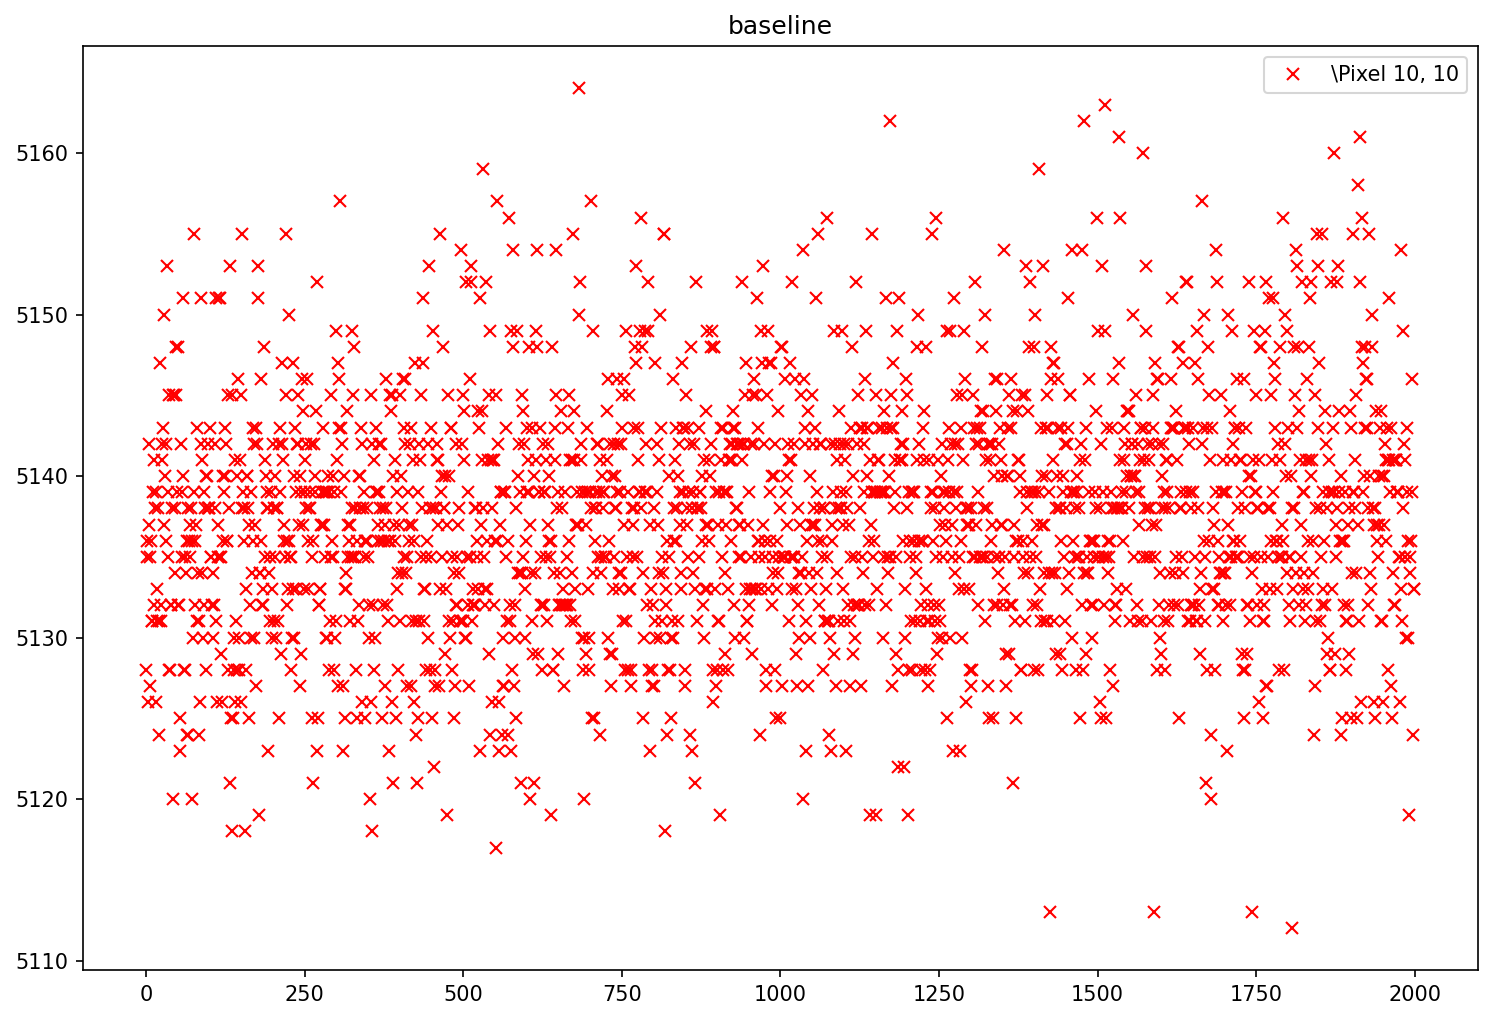

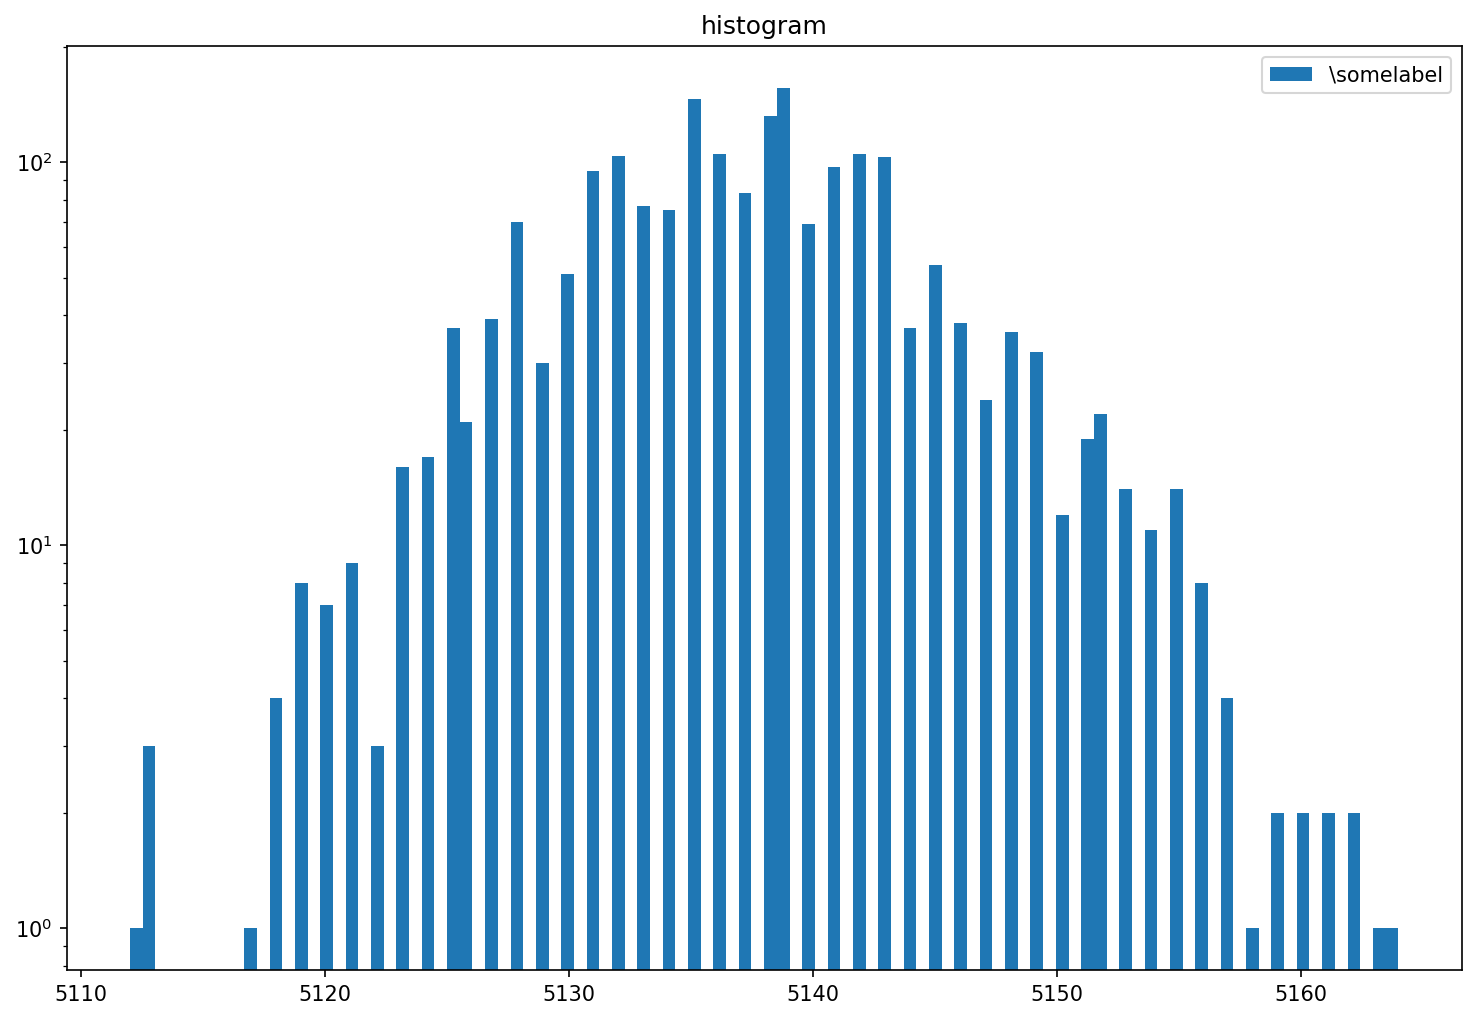

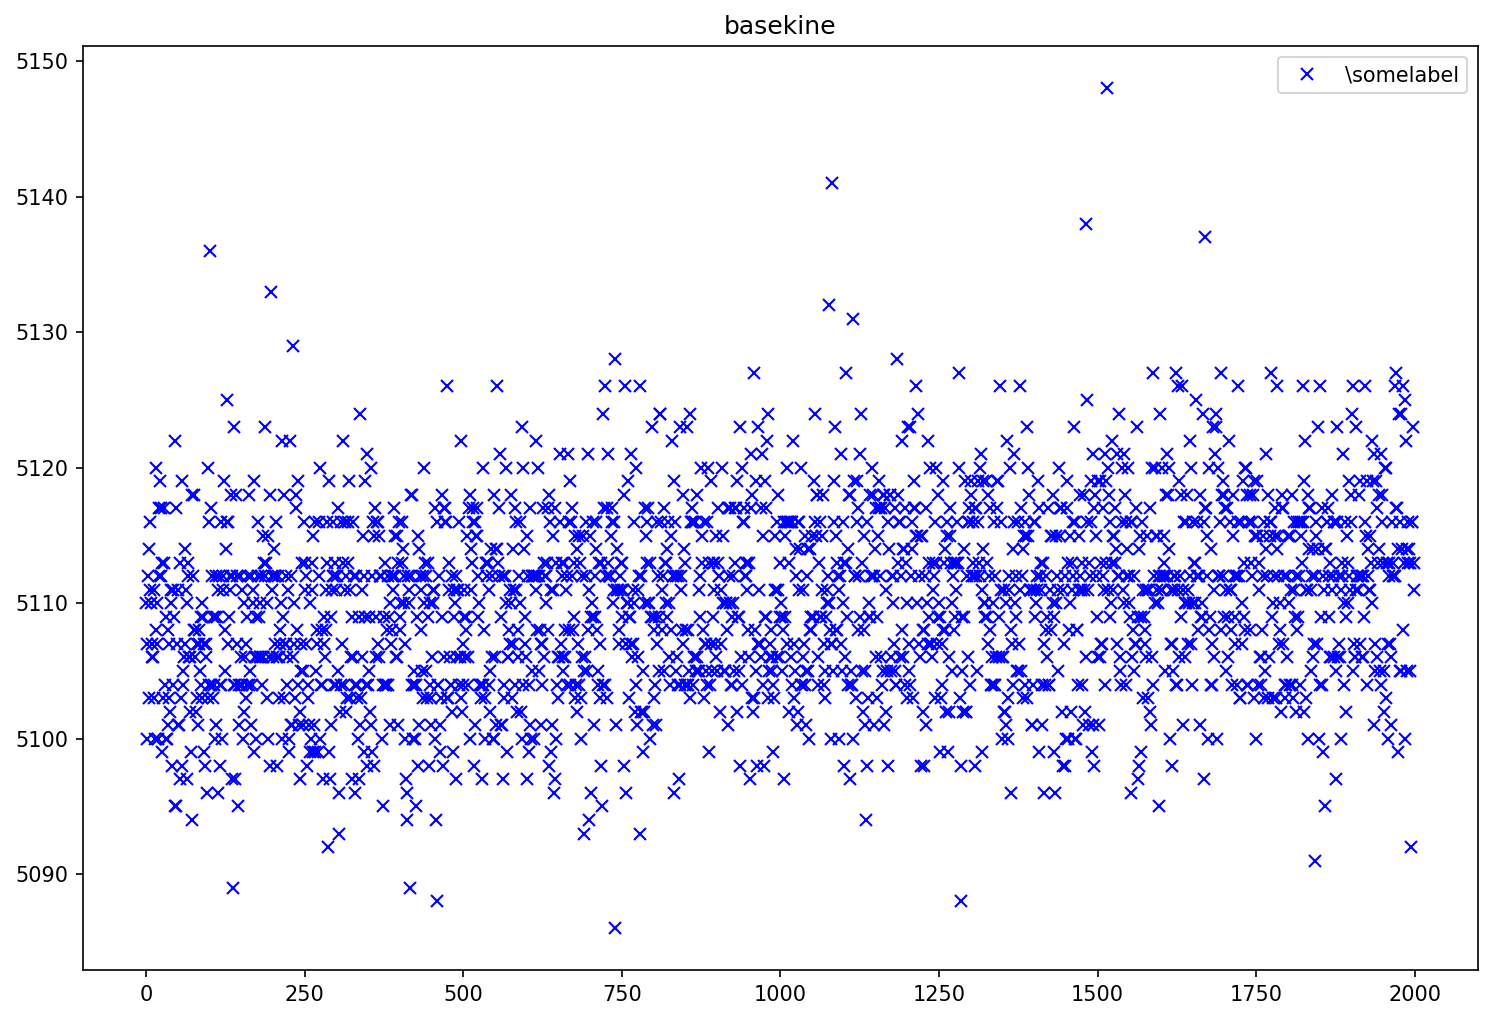

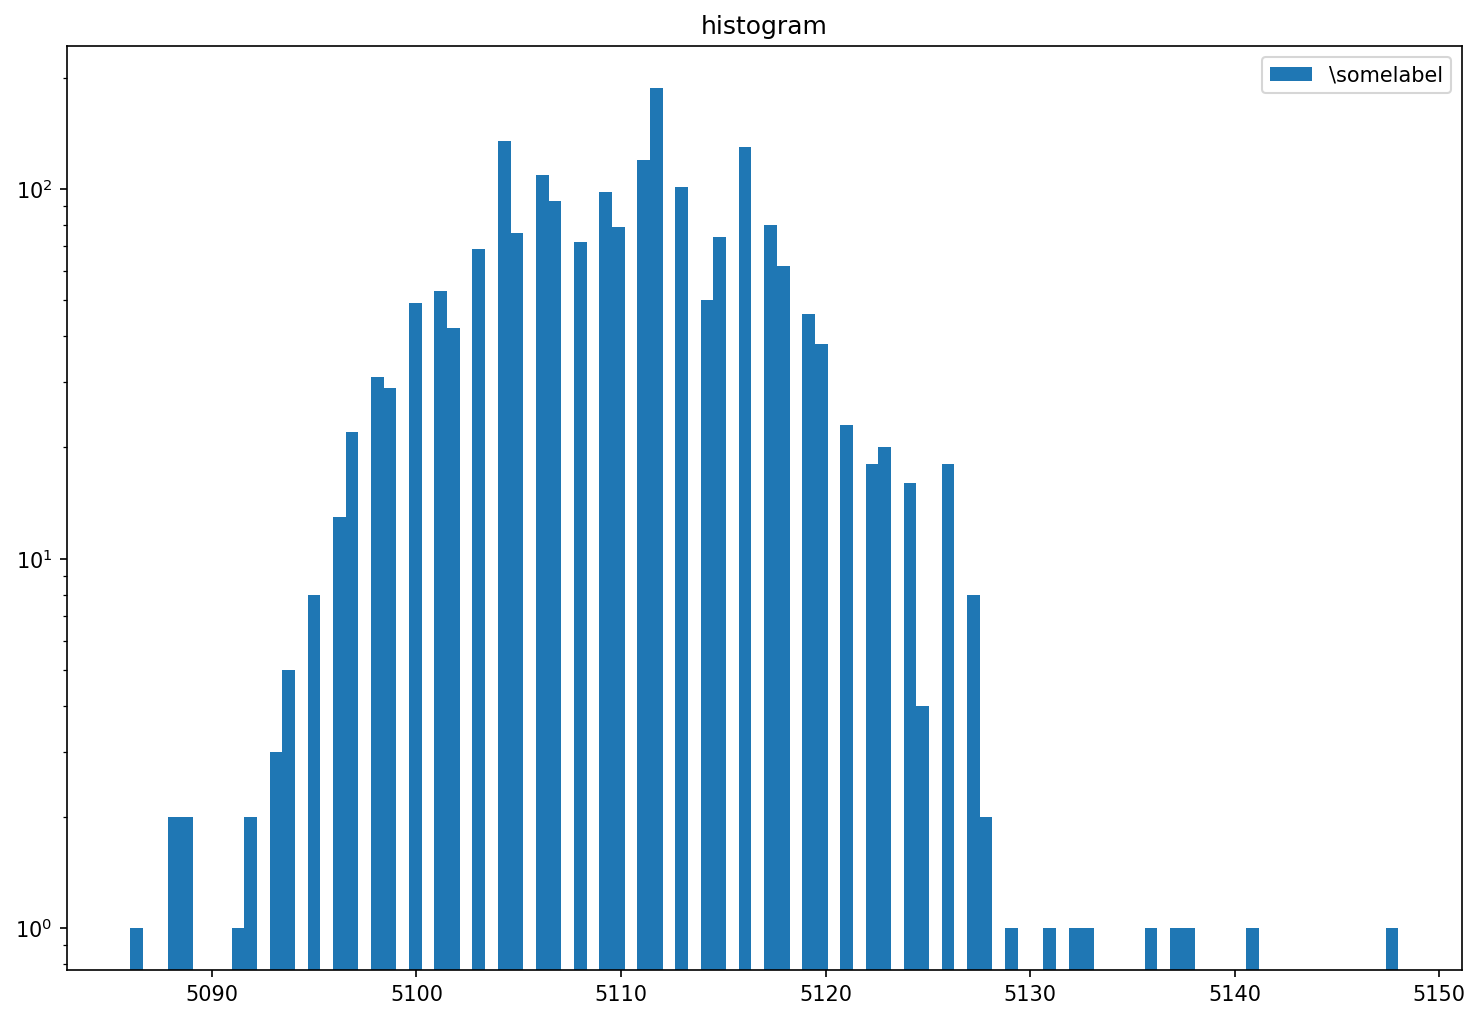

In [15]:
print('DHG', ASIC.DHg.get())
print('RefGenB', ASIC.RefGenB.get())
print('RefGenC', ASIC.RefGenC.get())
print('S2D_1_b', ASIC.S2D_1_b.get())
print('shvc_DAC', ASIC.shvc_DAC.get())
print('S2dDacBias', ASIC.S2dDacBias.get())



#scatter plot
plt.figure(1,figsize=(12,8),dpi=150)
dataset = imgDesc[:,10,10]
plt.plot(dataset, 'rx', label=f'\Pixel 10, 10') 
plt.title("baseline") 
plt.legend()
plt.show()

plt.figure(2,figsize=(12,8),dpi=150)
plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
plt.yscale('log')
plt.title("histogram") 
plt.legend()
plt.show()


plt.figure(1,figsize=(12,8),dpi=150)
dataset = imgDesc[:,140,75]
plt.plot(dataset, 'bx', label=f'\somelabel') 
plt.title("basekine") 
plt.legend()
plt.show()

plt.figure(2,figsize=(12,8),dpi=150)
plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
plt.yscale('log')
plt.title("histogram") 
plt.legend()
plt.show()


In [16]:
imgDesc.shape

(2000, 145, 384)

(145, 384)


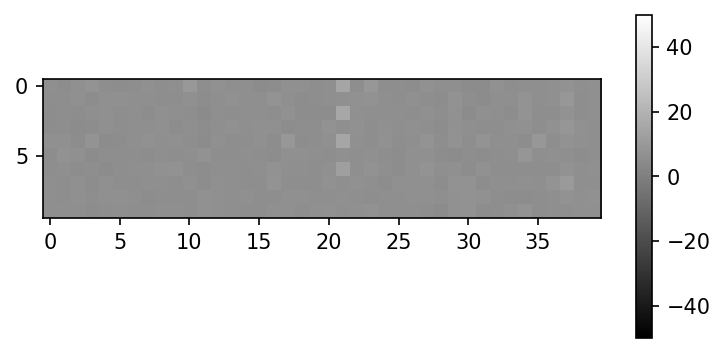

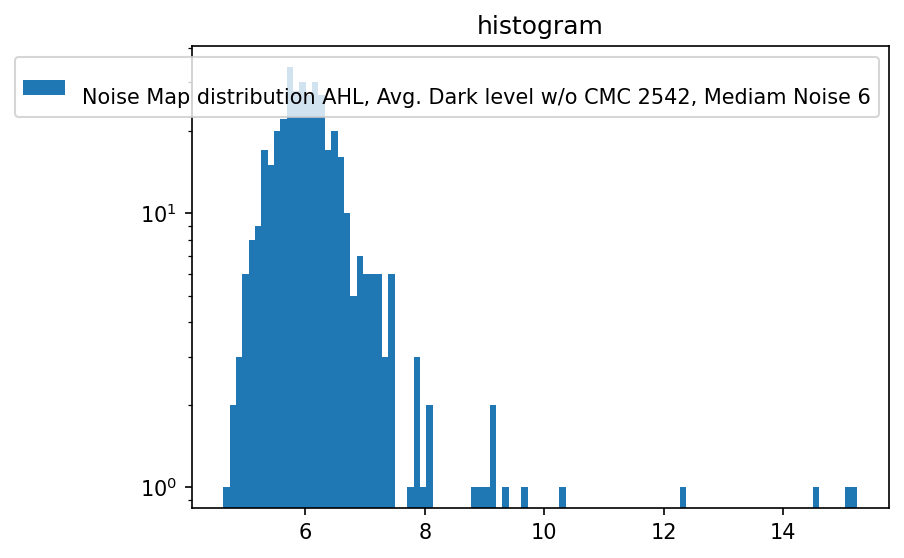

(array([[ 5.99057684,  5.36586074,  6.25172243,  7.47494076,  5.63626411,
          5.27748327,  5.7577714 ,  6.27878565,  5.60628518,  6.03389436,
          9.62284169,  5.54279541,  6.72473899,  5.90227534,  5.87212126,
          4.978919  ,  5.41926026,  6.63577732,  6.30481899,  5.75165672,
          6.14475412, 14.50488188,  5.84512069,  9.08353443,  5.60371767,
          5.72749757,  5.12774165,  6.71307402,  5.90389988,  6.03650939,
          5.01550664,  4.76101815,  6.83395496,  5.84005688,  6.13381114,
          6.18679973,  6.50200671,  7.39447538,  6.15858038,  6.59823811],
        [ 5.85142336,  5.52302898,  6.6351079 ,  5.37682498,  6.27420515,
          6.29671224,  6.05030646,  6.03109066,  5.69556324,  5.50311988,
          6.26693904,  5.16515499,  5.861822  ,  6.85935214,  5.91273744,
          5.96762499,  7.96822572,  6.04768839,  5.15380699,  5.82961298,
          5.94044384,  6.43788107,  6.76586882,  7.24388176,  6.19405202,
          5.76376961,  6.28730202,  5

In [17]:
noise_print_roi(x=65,y=134,width=40,height=10, imgDesc=imgDesc)

(145, 384)


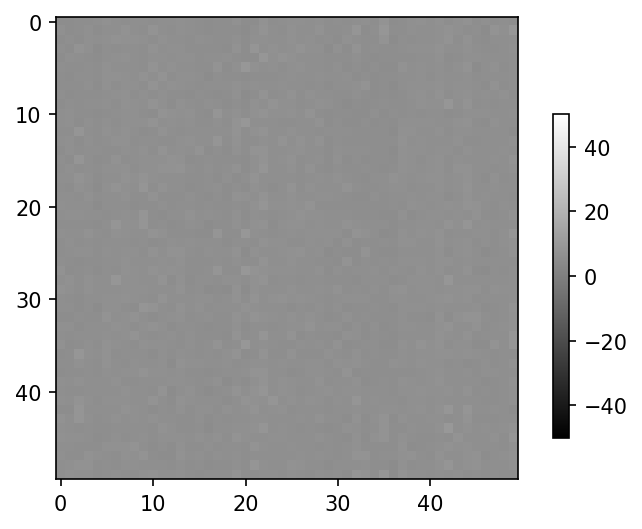

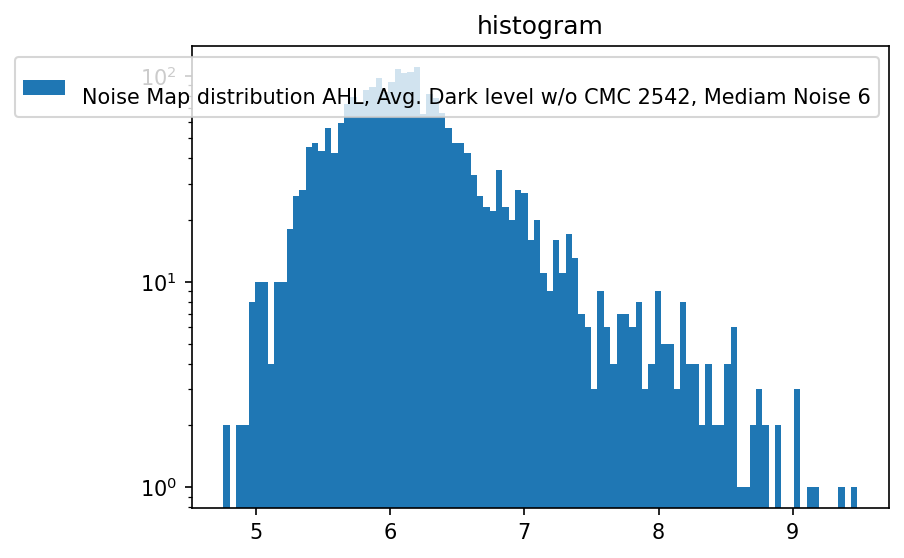

(array([[5.18319368, 5.2396221 , 5.65463542, ..., 5.76340956, 6.1800786 ,
         5.6971374 ],
        [6.29597868, 5.41474842, 5.77320651, ..., 7.5783584 , 6.32341959,
         9.02826531],
        [5.22328735, 6.0899932 , 5.39095514, ..., 6.00816927, 6.22848265,
         6.35329521],
        ...,
        [6.29649787, 5.69537877, 5.79793883, ..., 6.10630698, 6.30835668,
         7.2844967 ],
        [5.97725323, 6.25274528, 7.35763032, ..., 6.23247621, 5.99492409,
         6.71401514],
        [5.89404228, 6.82874328, 6.26823364, ..., 6.02700745, 5.72405231,
         5.64535478]]),
 array([[5224.5965, 5111.7795, 5081.378 , ...,    0.    ,    0.    ,
            0.    ],
        [5316.198 , 5176.7915, 5057.2525, ...,    0.    ,    0.    ,
            0.    ],
        [5140.4775, 5110.2525, 5118.7295, ...,    0.    ,    0.    ,
            0.    ],
        ...,
        [5151.2635, 5045.1795, 5103.284 , ...,    0.    ,    0.    ,
            0.    ],
        [5250.95  , 5058.202 , 4999.

In [18]:
noise_print_roi(x=10,y=10,width=50,height=50, imgDesc=imgDesc)

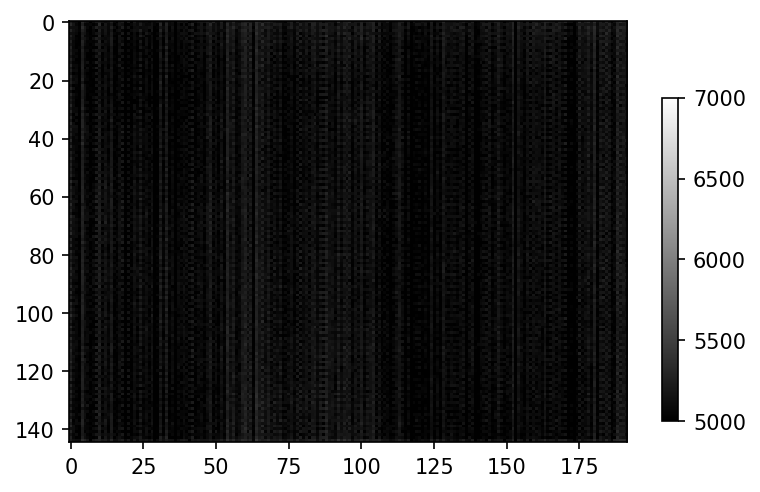

In [19]:
plt.figure(1,figsize=(6,4),dpi=150)
plt.imshow(imgDesc[100,:,0:192], cmap='gray', vmin=5000, vmax=7000, interpolation='none')
plt.colorbar(location='right', anchor=(0, 0.3), shrink=0.7)

In [56]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask

PreampList = [4,7,6,5,4,3,2,1,0] #[4]
Vld1_b = 1
Pixel_CB= 4
Filter_DAC= 38
VRef_DAC = 53

RefGenB    = 1     #3       #2              #3
RefGenC    = 2     #0       #3              #2
S2D_1_b    = 0     #0       #0              #0
shvc_DAC   = 30    #30      #23             #23
S2dDacBias = 3     #3       #3              #3
DHg        = False #True    #True           #True 

for Preamp in PreampList:
    
    ######################################################################################################################
    # Remove previous dataset
    #filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_baseline_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_DHg_%d_RefGenB_%d_RefGenC_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC,DHg,RefGenB,RefGenC))
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_clearMatrix_0_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_DHg_%d_RefGenB_%d_RefGenC_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC,DHg,RefGenB,RefGenC))
    ########################################################################################################################
    imgDesc_raw = read_asic_test(18000)
    imgDesc = np.bitwise_and(imgDesc, 0xFFFC)
    ########################################################################################################################
    #[noiseMap, darkAvg] = noise_print()
    #scatter plot
    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,10,10]
    plt.plot(dataset, 'rx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()


    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,140,75]
    plt.plot(dataset, 'bx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()

    
    noise_print_roi(x=10,y=10,width=50,height=50,imgDesc=imgDesc)

MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask


Camera  ePixHr10kTBatcher  selected.
/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_clearMatrix_0_320MHz_initSequence_5_Preamp_4_Vld1b_1_PixelCB_4_Filter_DAC_38_VRrefdac_53_DHg_0_RefGenB_1_RefGenC_2_run1.dat
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 3
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 4
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 5
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 6
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling ima

NameError: name 'imgDesc' is not defined

In [ ]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xfffe
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask

PreampList = [4]
Vld1_b = 1
Pixel_CB= 4
Filter_DAC= 38
VRef_DAC = 53

for Preamp in PreampList:
    
    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_baseline_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_DHg_%d_RefGenB_%d_RefGenC_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC,DHg,RefGenB,RefGenC))
    ########################################################################################################################
    imgDesc = read_asic_test(20000)
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()
    #scatter plot
    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,10,10]
    plt.plot(dataset, 'rx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()


    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,140,75]
    plt.plot(dataset, 'bx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()

    
    noise_print_roi(x=10,y=10,width=50,height=50)

MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask


In [ ]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xfffc
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask

PreampList = [4]
Vld1_b = 1
Pixel_CB= 4
Filter_DAC= 38
VRef_DAC = 53

for Preamp in PreampList:
    
    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_baseline_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_DHg_%d_RefGenB_%d_RefGenC_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC,DHg,RefGenB,RefGenC))
    ########################################################################################################################
    imgDesc = read_asic_test(20000)
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()
    #scatter plot
    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,10,10]
    plt.plot(dataset, 'rx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()

    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,140,75]
    plt.plot(dataset, 'bx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()
    
    noise_print_roi(x=10,y=10,width=50,height=50)

MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask


In [ ]:
# baseline test with external DAC
print(currentCam.bitMask)

In [ ]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)

PreampList = [4]
Vld1_b = 1
Pixel_CB= 4
Filter_DAC= 38
VRef_DAC = 53

for Preamp in PreampList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    
    ASIC.mTest.set(True)

    #sets HSDAC device
    root.EpixHR.HSDac.enable.set(True)
    #reset status
    root.EpixHR.HSDac.DacChannel.set(1) # 0 means NONE, 1 means SE, 2 Diff, 3 both
    root.EpixHR.HSDac.WFEnabled.set(False)
    root.EpixHR.HSDac.waveformSource.set(0)
    root.EpixHR.HSDac.externalUpdateEn.set(False)
    root.EpixHR.HSDac.run.set(False)

    root.EpixHR.HSDac.DacValue.set(32000)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_baseline_externalDAC_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))
    ########################################################################################################################
    if os.path.exists(filename):
       os.remove(filename)
       print("The file %s was removed" %(filename))
    else:
       print("The file does not exist")
    imgDesc = run_asic_test(20000)
    np.save(filename, imgDesc)
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()
    
    #scatter plot
    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,10,10]
    plt.plot(dataset, 'rx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()

    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,140,75]
    plt.plot(dataset, 'bx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()
    
    noise_print_roi(x=10,y=10,width=50,height=50)

In [ ]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xfffe
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask

PreampList = [4]
Vld1_b = 1
Pixel_CB= 4
Filter_DAC= 38
VRef_DAC = 53

for Preamp in PreampList:
    
    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_baseline_externalDAC_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))
    ########################################################################################################################
    imgDesc = read_asic_test(20000)
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()
    #scatter plot
    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,10,10]
    plt.plot(dataset, 'rx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()


    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,140,75]
    plt.plot(dataset, 'bx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()

    
    noise_print_roi(x=10,y=10,width=50,height=50)

MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask


In [22]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)

Preamp = 4 #[4,7,6,5,3,2,1,0] #4
Vld1_b = 1 #1
Pixel_CB= 4 #4
Filter_DAC= 38 #33
VRef_DAC = 53 #22

          #lorenzo#reduced banding#default
RefGenB = 1       #2              #3
RefGenC = 2       #3              #2
S2D_1_b = 0       #0              #0
shvc_DAC = 30     #23             #23
S2dDacBias = 3    #3              #3
DHg = False
print("")
ASIC.DHg.set(DHg)  
ASIC.RefGenB.set(RefGenB)
ASIC.RefGenC.set(RefGenC)
ASIC.S2D_1_b.set(S2D_1_b)
ASIC.shvc_DAC.set(shvc_DAC)
ASIC.S2dDacBias.set(S2dDacBias)
print('DHG', ASIC.DHg.get())
print('RefGenB', ASIC.RefGenB.get())
print('RefGenC', ASIC.RefGenC.get())
print('S2D_1_b', ASIC.S2D_1_b.get())
print('shvc_DAC', ASIC.shvc_DAC.get())
print('S2dDacBias', ASIC.S2dDacBias.get())

ASIC.ClearMatrix(0)

for VRef_DAC in range(0,64,4):
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_DHg_%d_RefGenB_%d_RefGenC_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC,DHg,RefGenB,RefGenC))
    ########################################################################################################################
    if os.path.exists(filename):
       #os.remove(filename)
       print("")
       print("The file %s was skipped" %(filename))
       print("")
    else:
       print("The file does not exist")
       imgDesc = run_asic_test(4000)
       np.save(filename, imgDesc)
    ########################################################################################################################
    #[noiseMap, darkAvg] = noise_print()


DHG False
RefGenB 1
RefGenC 2
S2D_1_b 0
shvc_DAC 30
S2dDacBias 3
Command executed :  <class 'pyrogue._Command.BaseCommand'> - ePixHr10kT.EpixHR.Hr10kTAsic2.ClearMatrix
Preamp 4
Vld1_b 1
Pixel_CB 4
Filter_DAC 38
VRef_DAC 0

The file /u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_5_Preamp_4_Vld1b_1_PixelCB_4_Filter_DAC_38_VRrefdac_0_DHg_0_RefGenB_1_RefGenC_2_run1.dat was skipped

Preamp 4
Vld1_b 1
Pixel_CB 4
Filter_DAC 38
VRef_DAC 4

The file /u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_5_Preamp_4_Vld1b_1_PixelCB_4_Filter_DAC_38_VRrefdac_4_DHg_0_RefGenB_1_RefGenC_2_run1.dat was skipped

Preamp 4
Vld1_b 1
Pixel_CB 4
Filter_DAC 38
VRef_DAC 8

The file /u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_5_Preamp_4_Vld1b_1_PixelCB_4_Filter_DAC_38_VRrefdac_8_DHg_0_RefGenB_1_RefGenC_2_run1.dat was skipped

Pre

Camera  ePixHr10kTBatcher  selected.
/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_5_Preamp_4_Vld1b_1_PixelCB_4_Filter_DAC_38_VRrefdac_0_DHg_0_RefGenB_1_RefGenC_2_run1.dat
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)


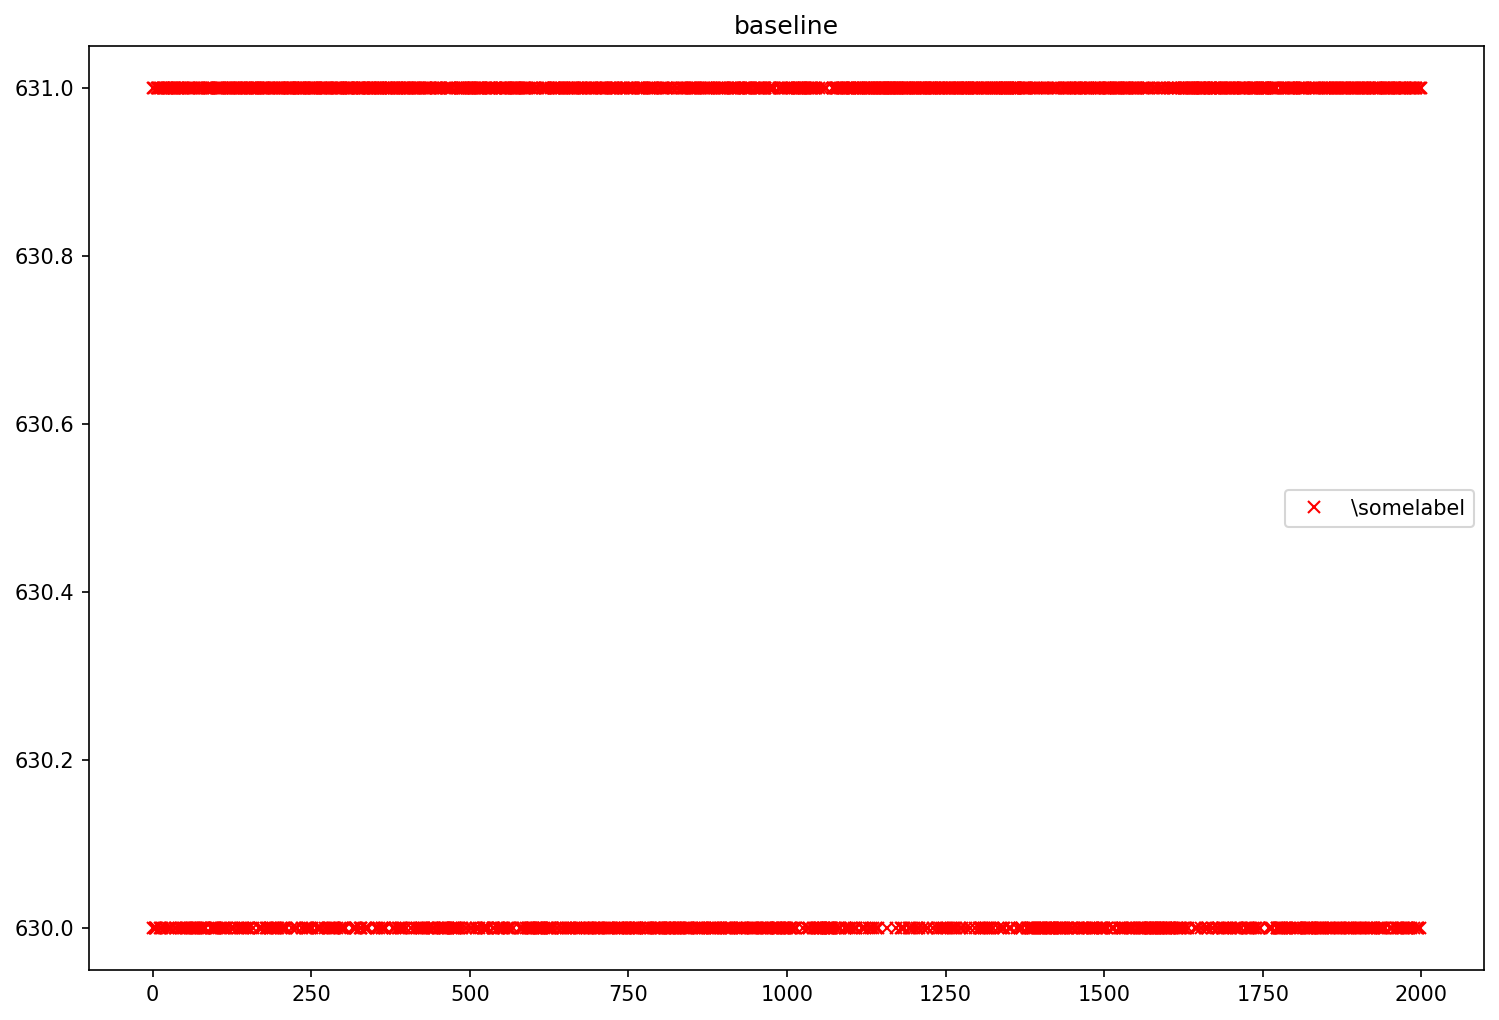

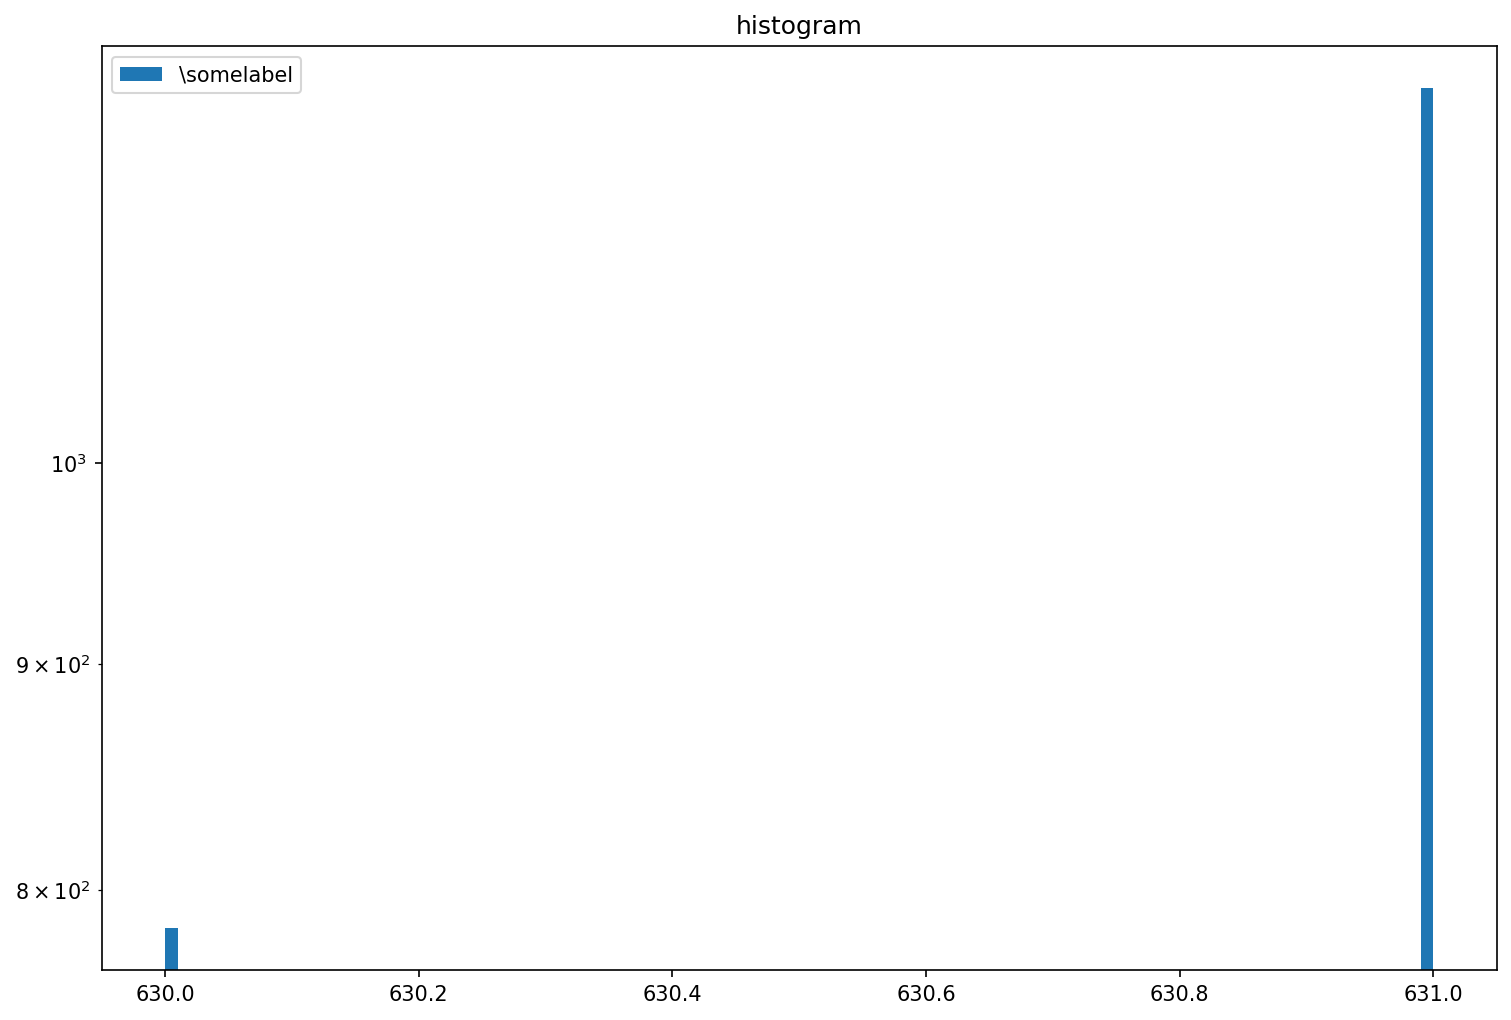

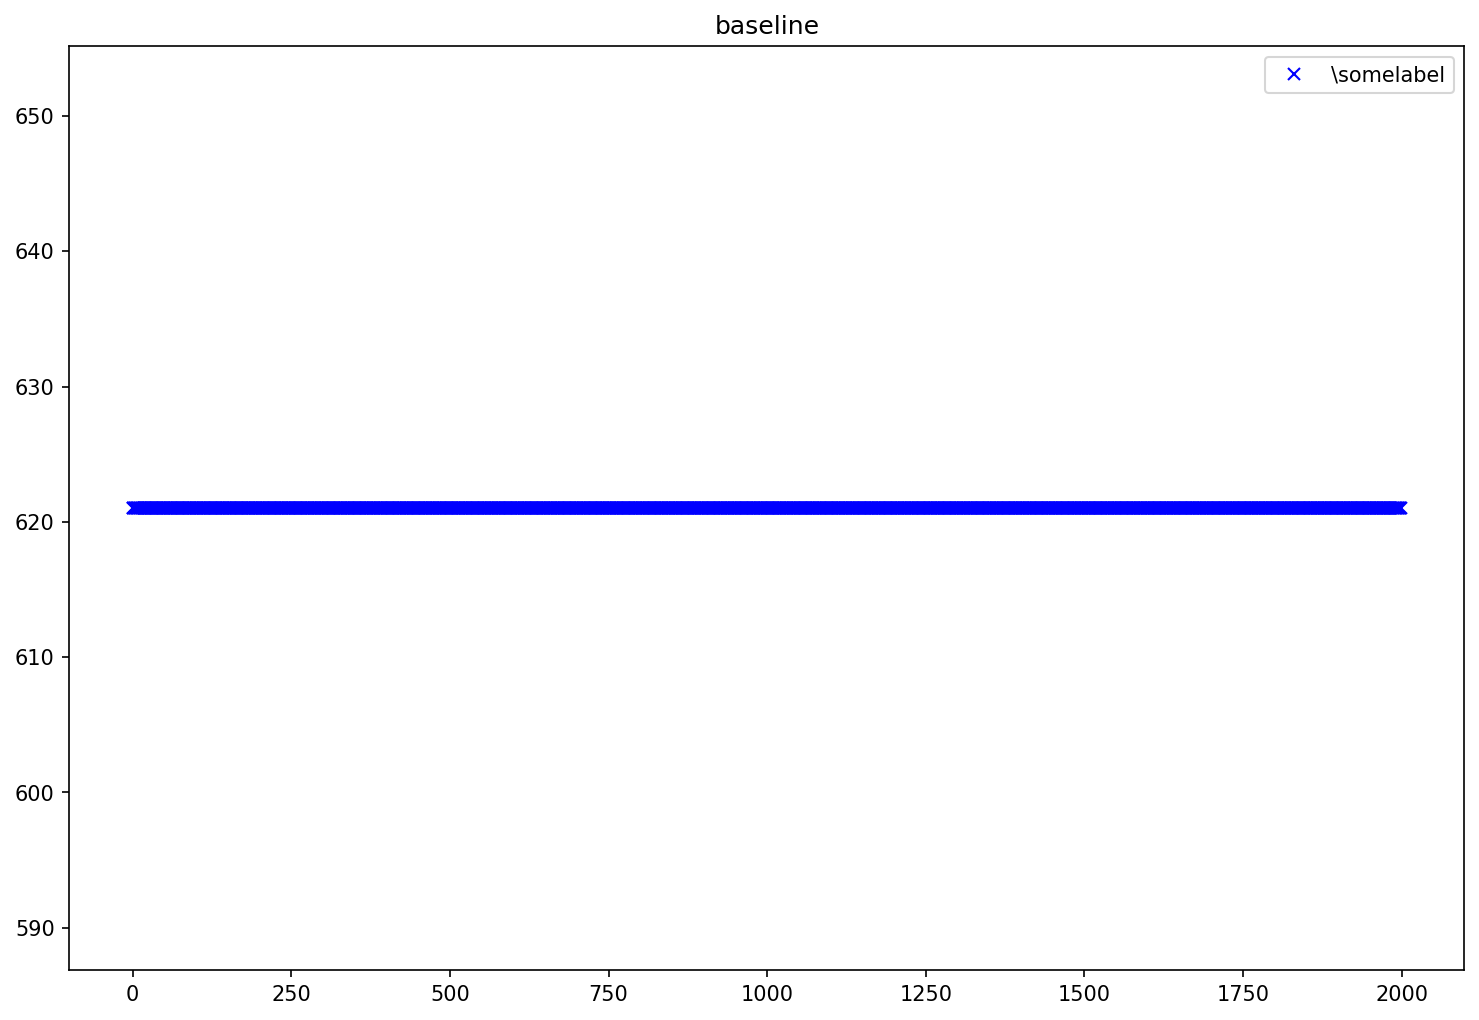

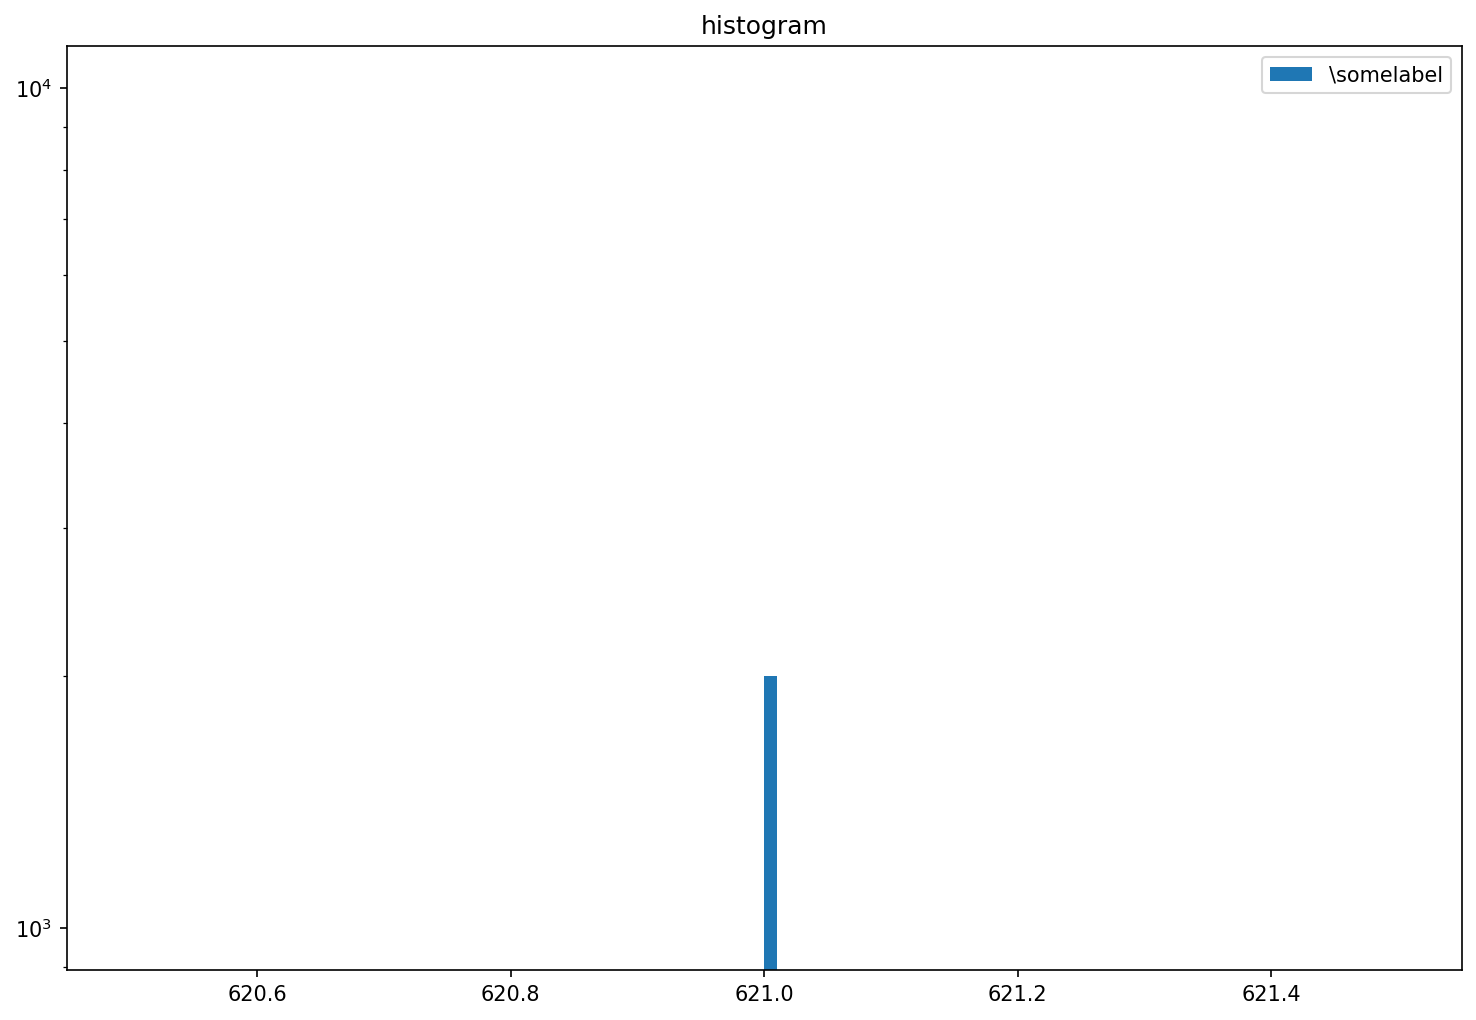

(145, 384)


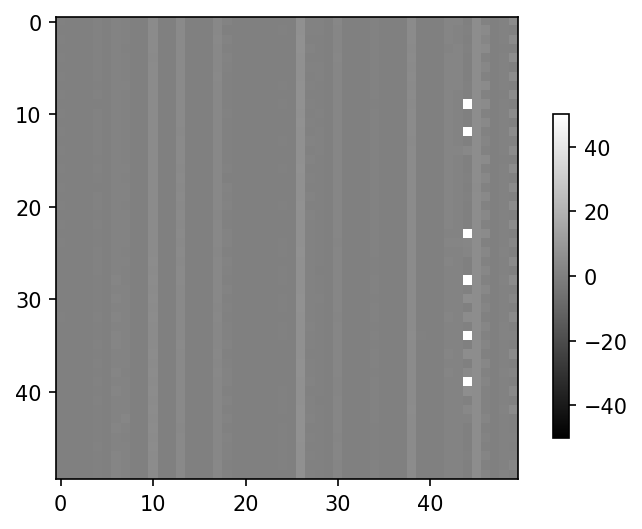

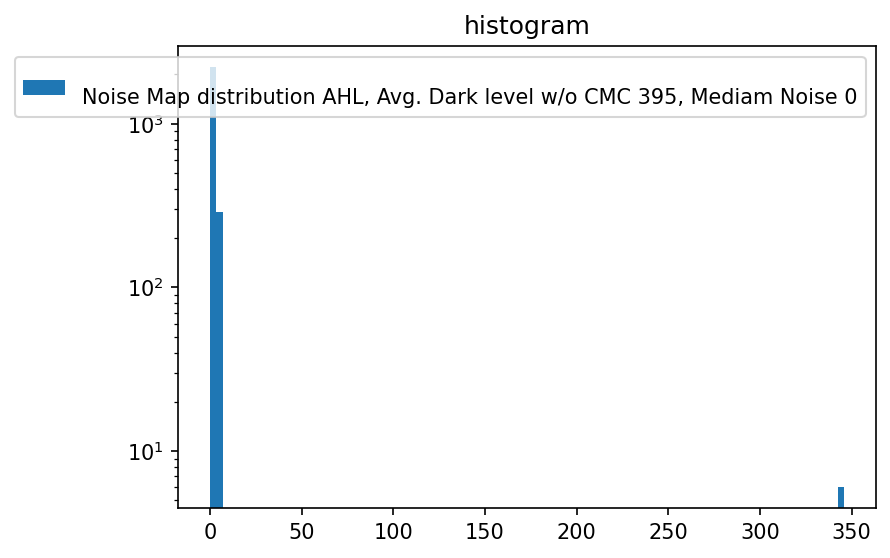


/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_5_Preamp_4_Vld1b_1_PixelCB_4_Filter_DAC_38_VRrefdac_4_DHg_0_RefGenB_1_RefGenC_2_run1.dat
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)


/tmp/ipykernel_153973/1146968416.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (imgDescCum == []):


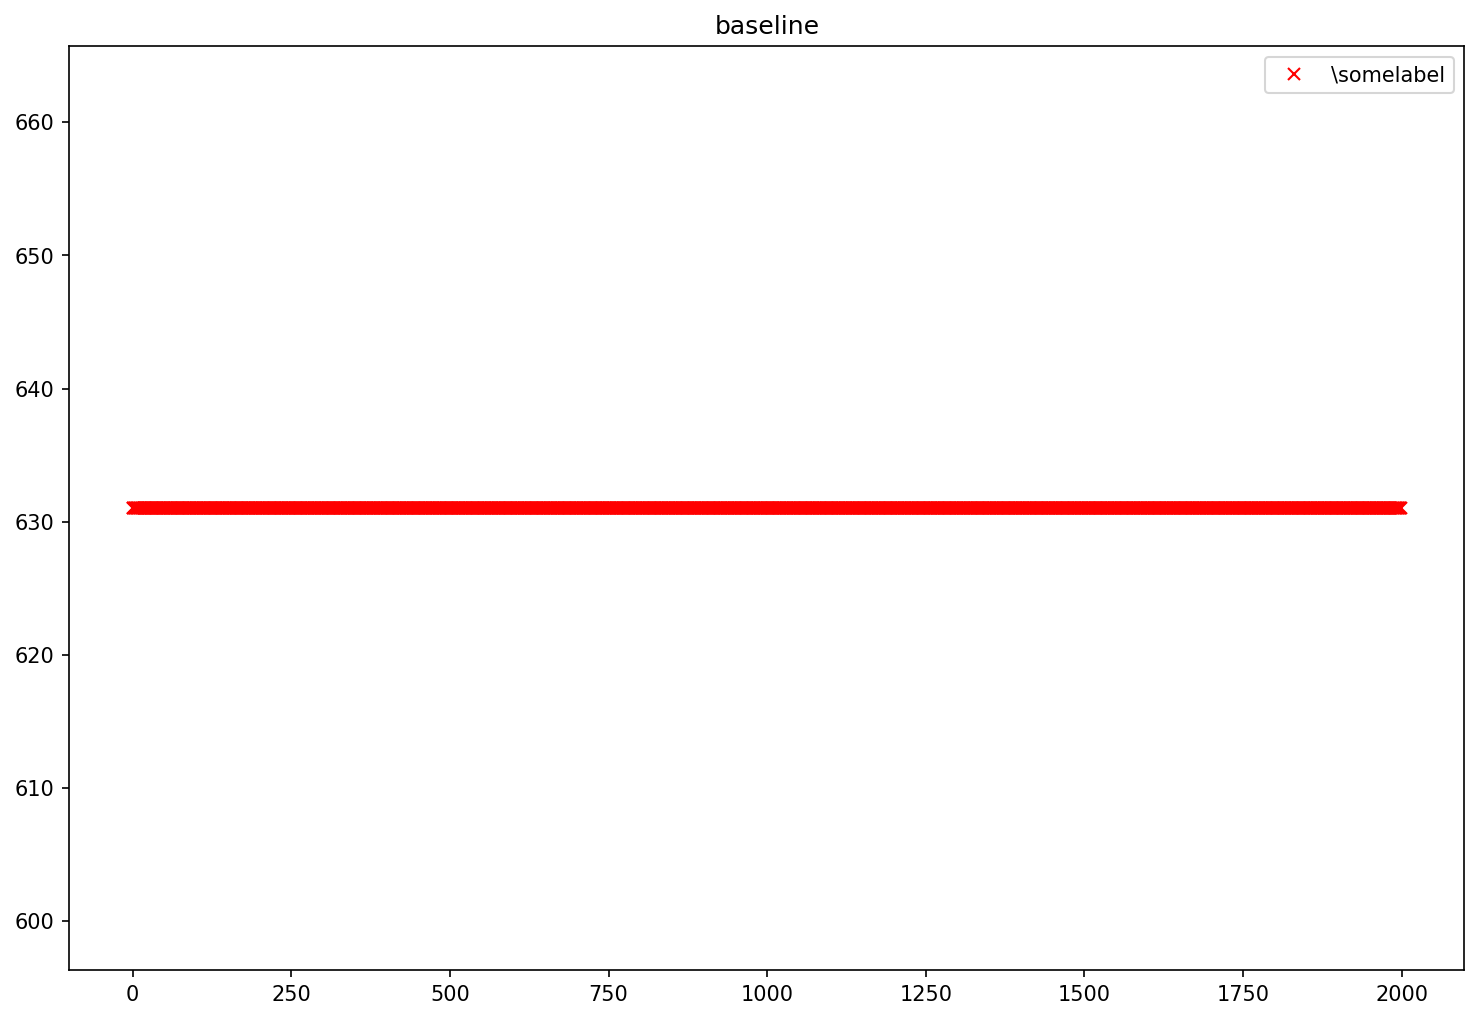

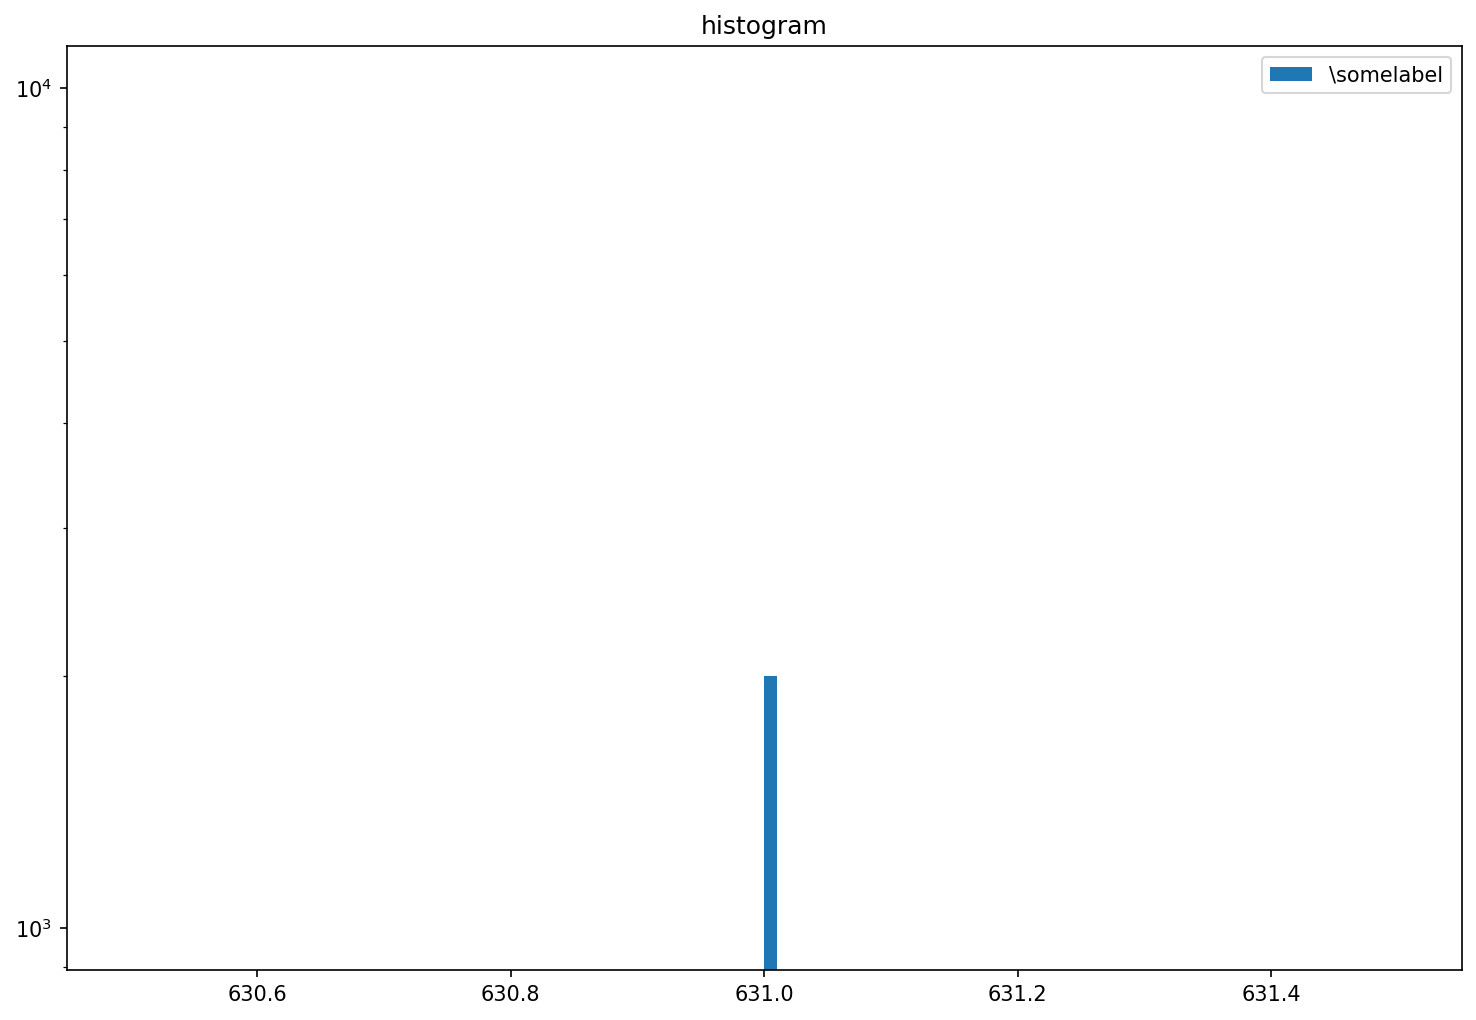

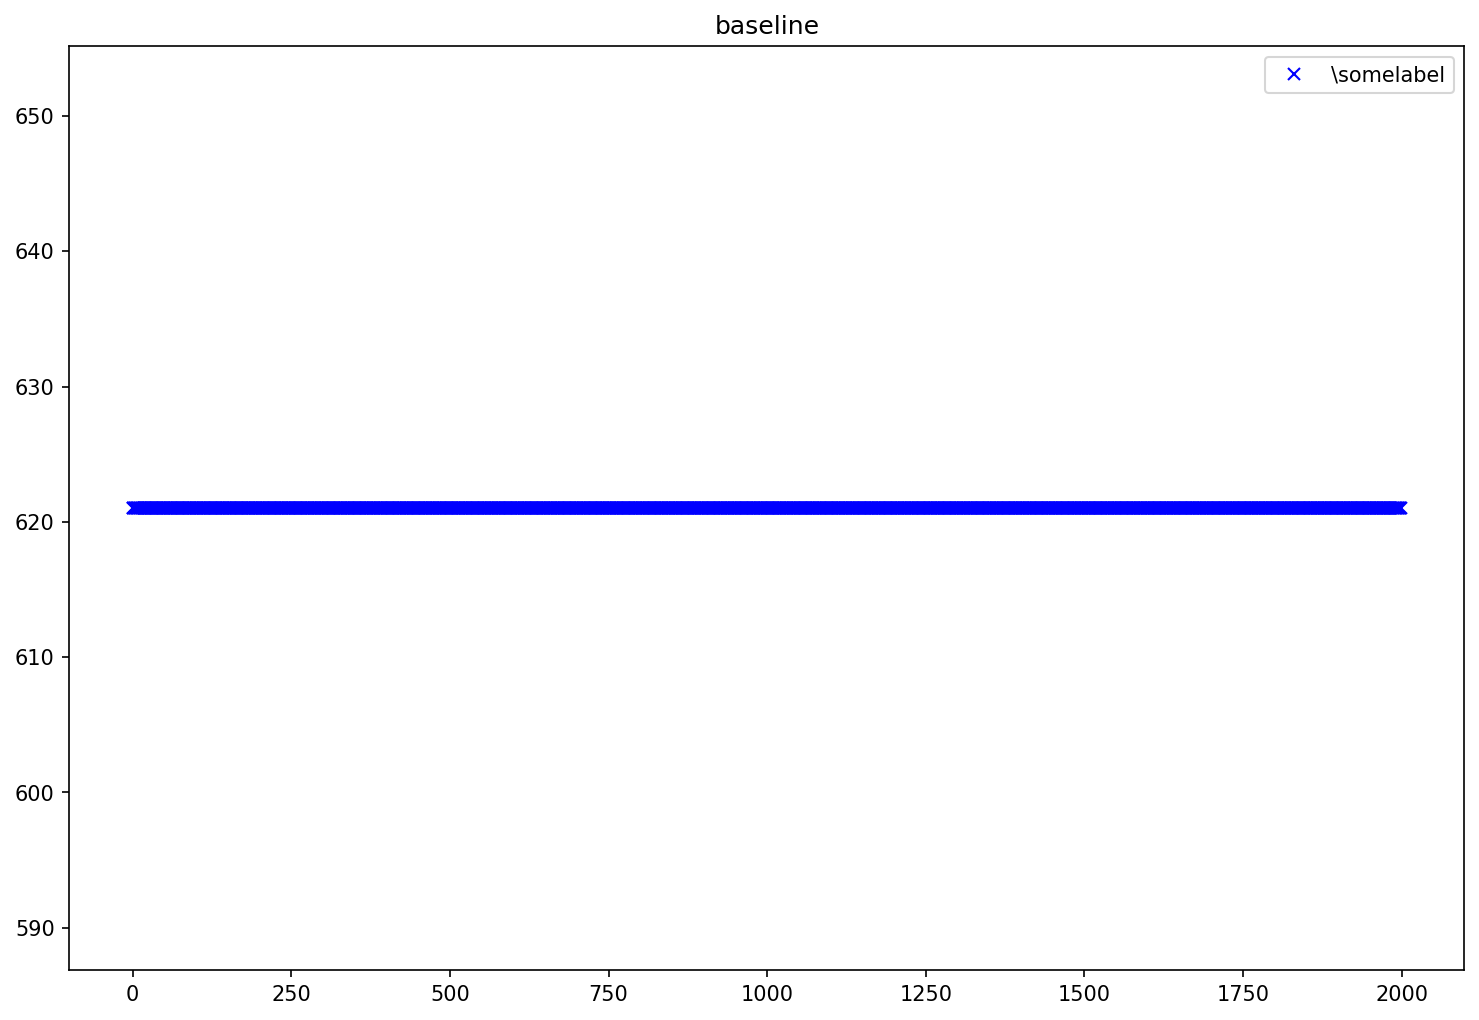

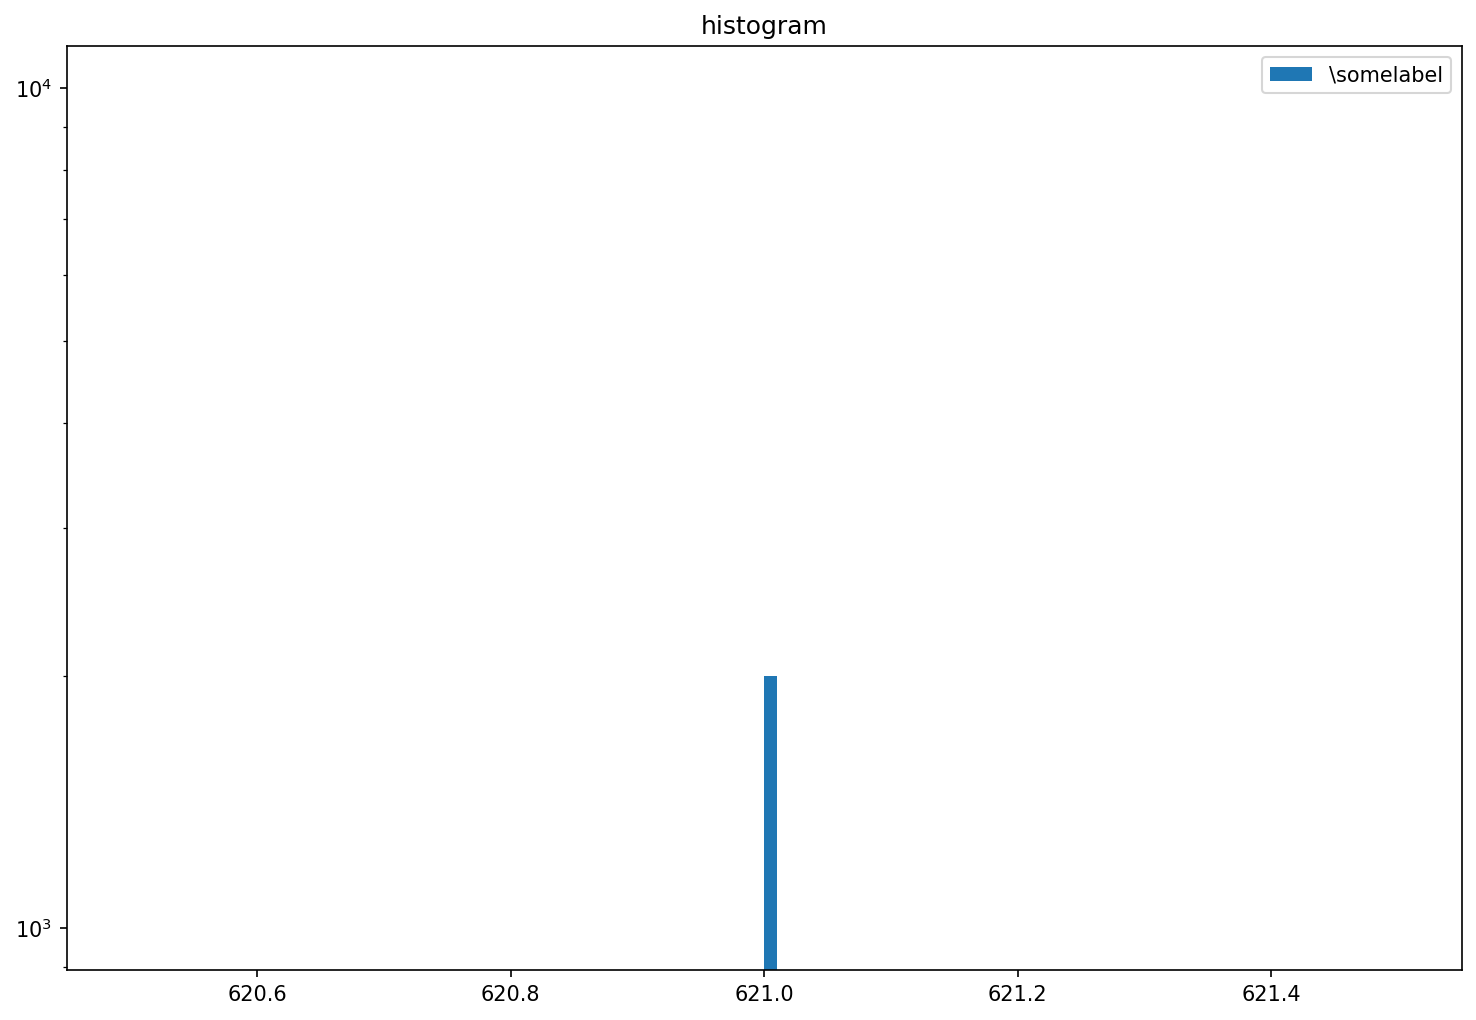

(145, 384)


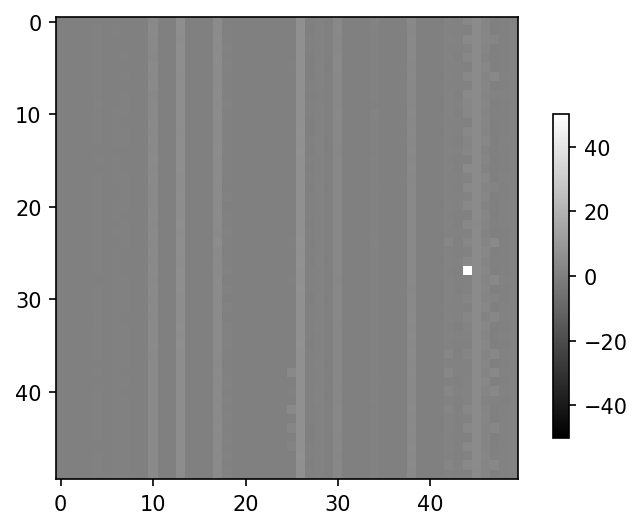

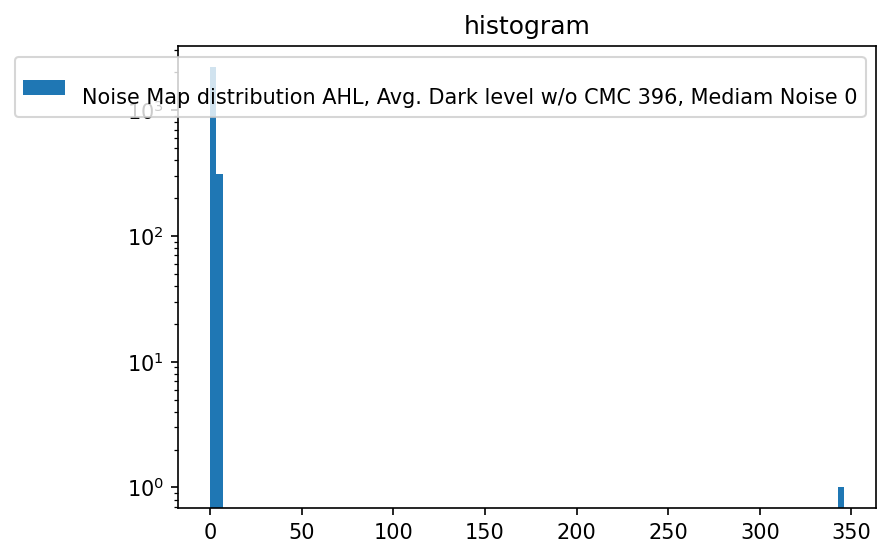


/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_5_Preamp_4_Vld1b_1_PixelCB_4_Filter_DAC_38_VRrefdac_8_DHg_0_RefGenB_1_RefGenC_2_run1.dat
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)


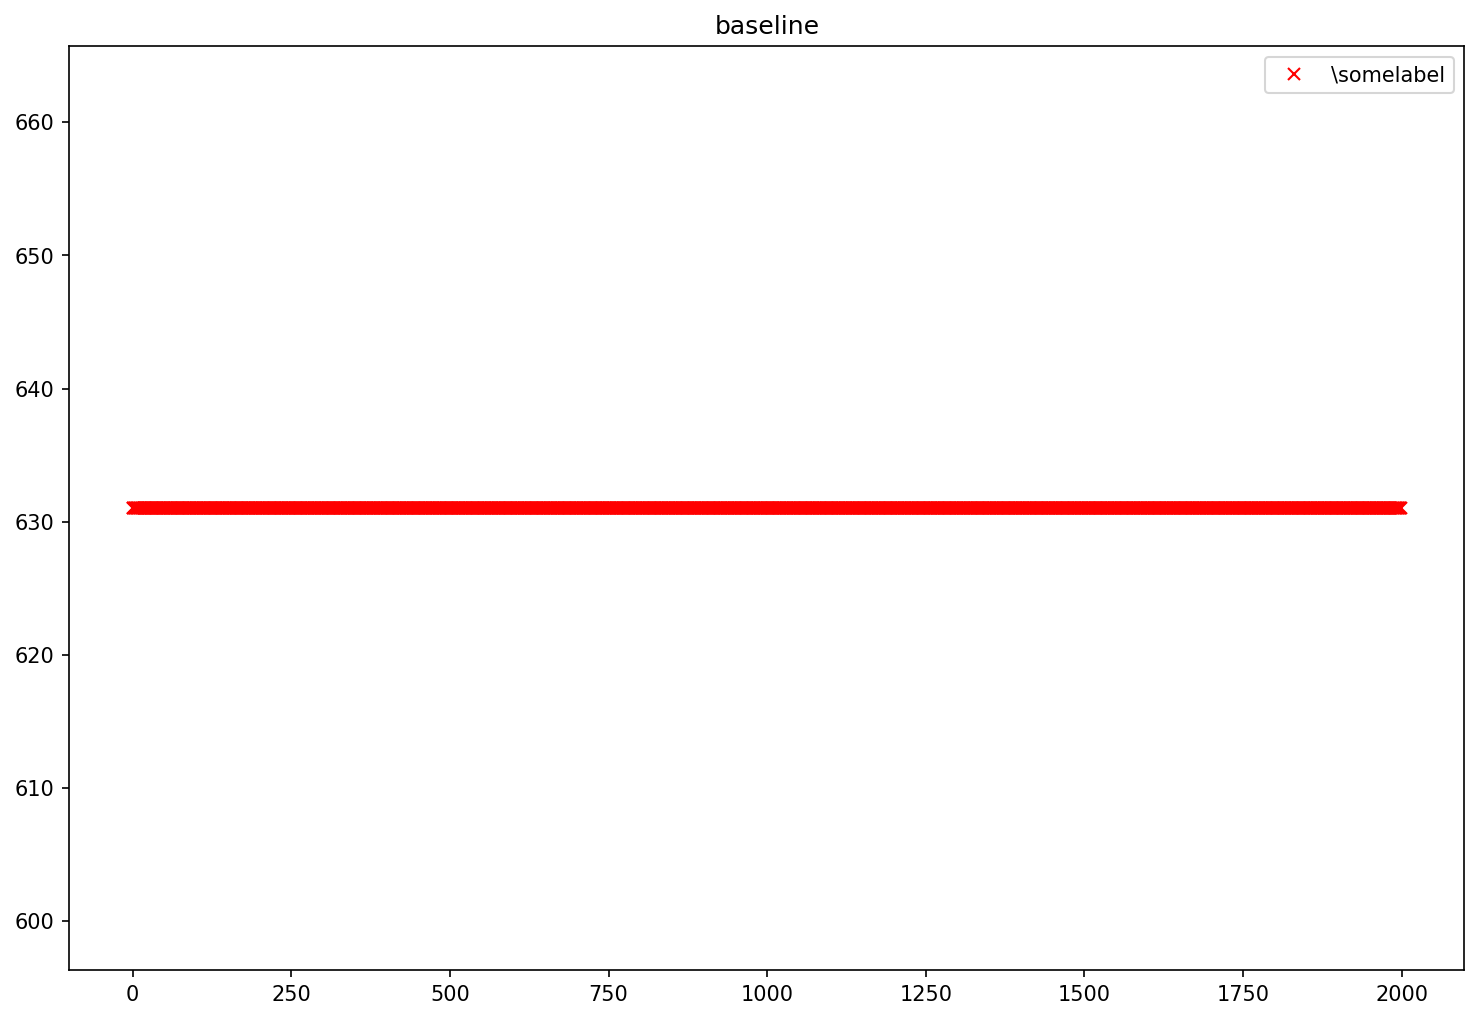

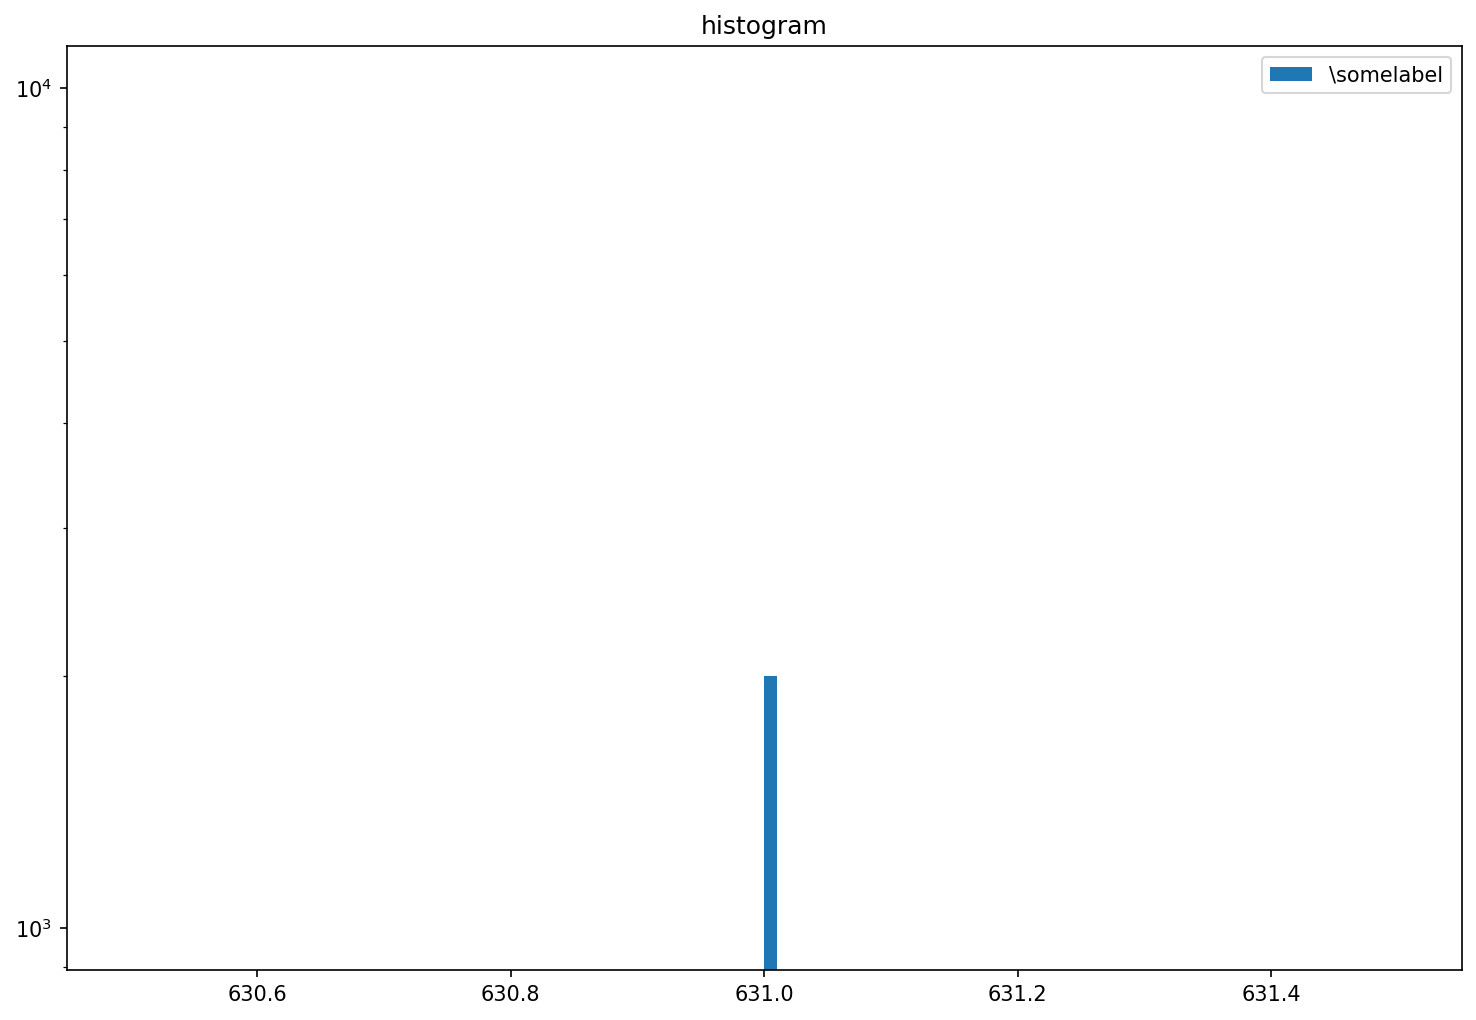

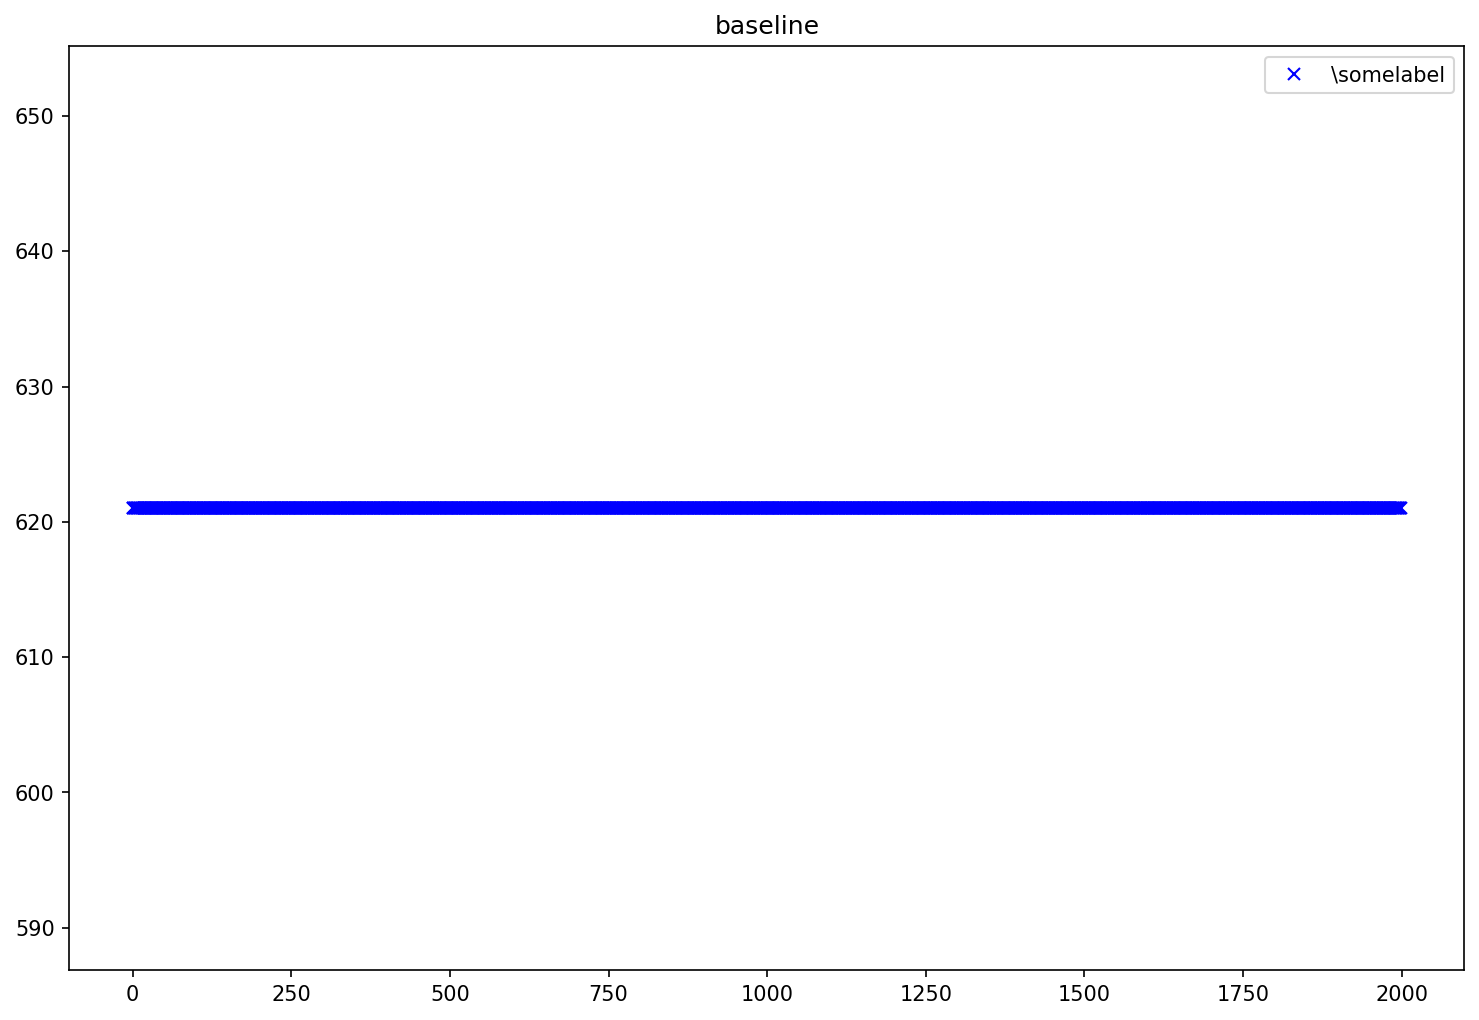

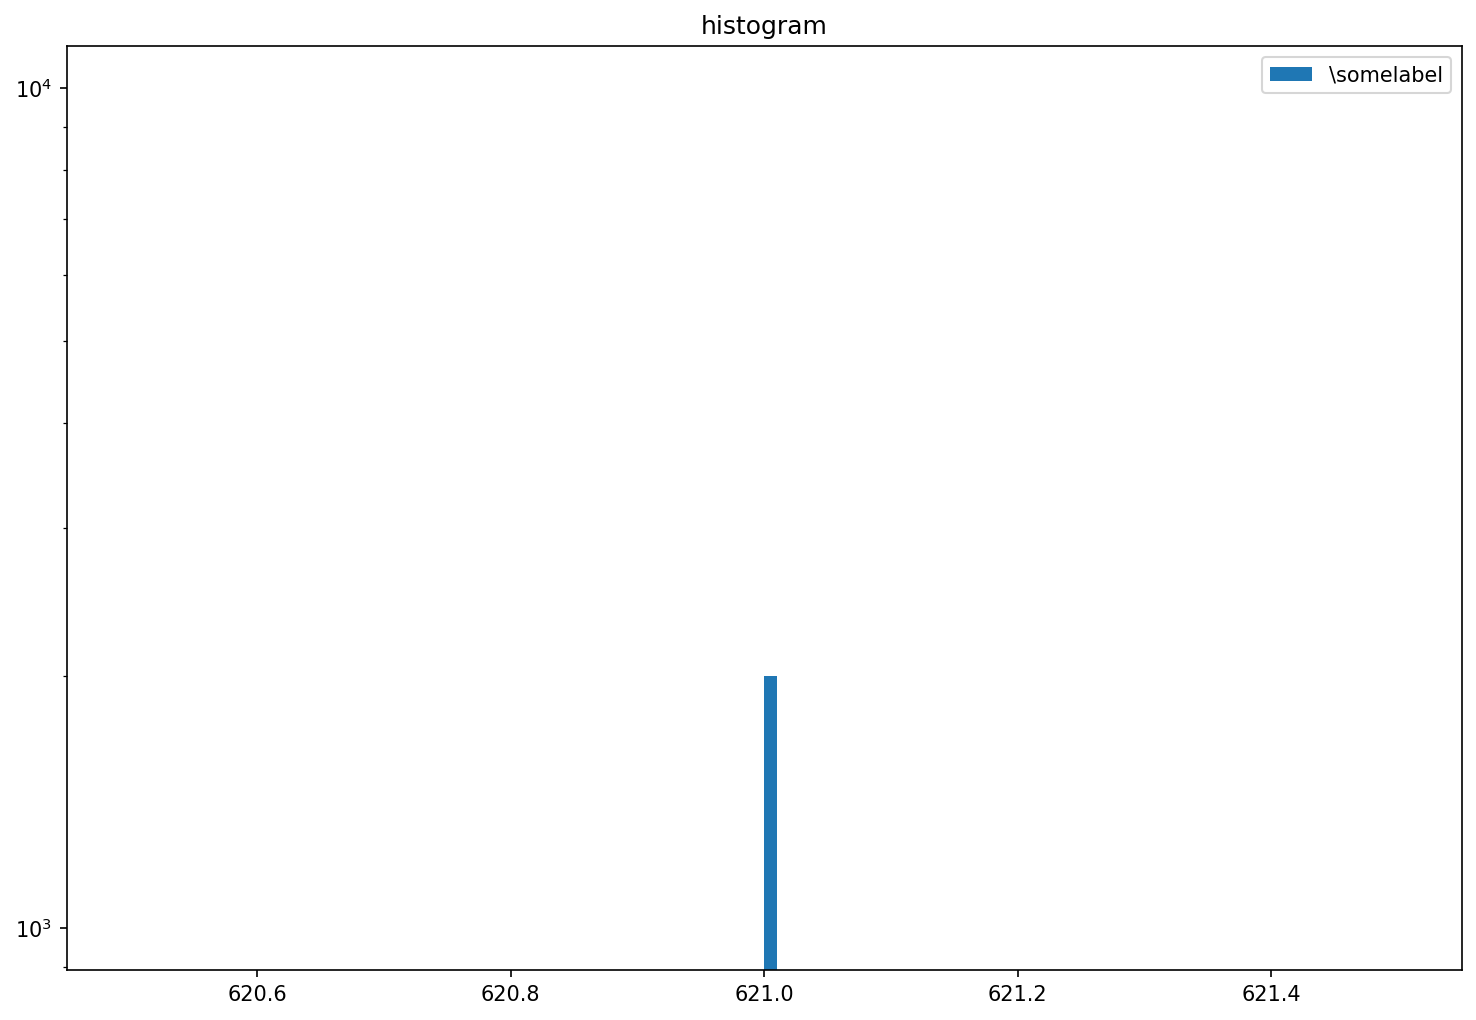

(145, 384)


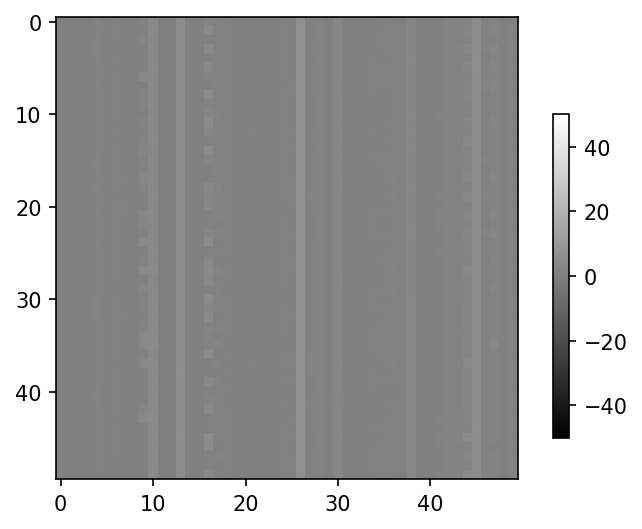

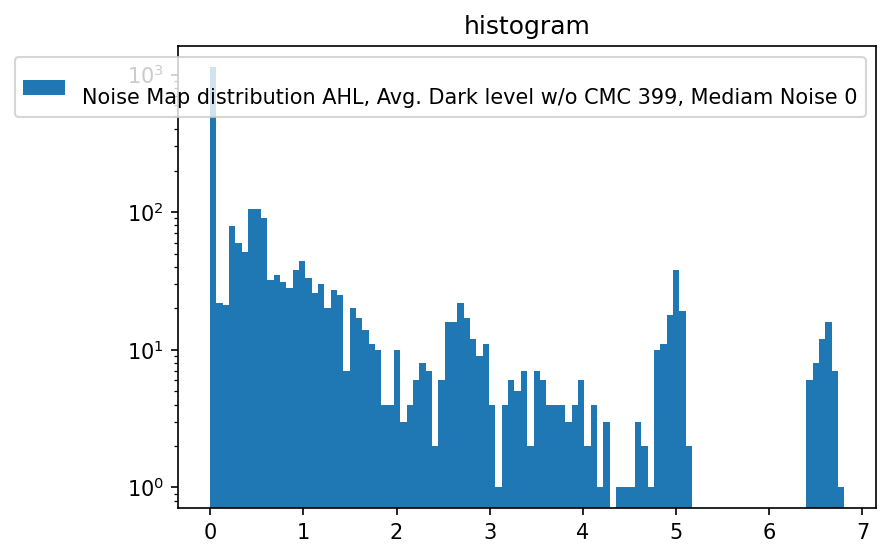


/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_5_Preamp_4_Vld1b_1_PixelCB_4_Filter_DAC_38_VRrefdac_12_DHg_0_RefGenB_1_RefGenC_2_run1.dat
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)


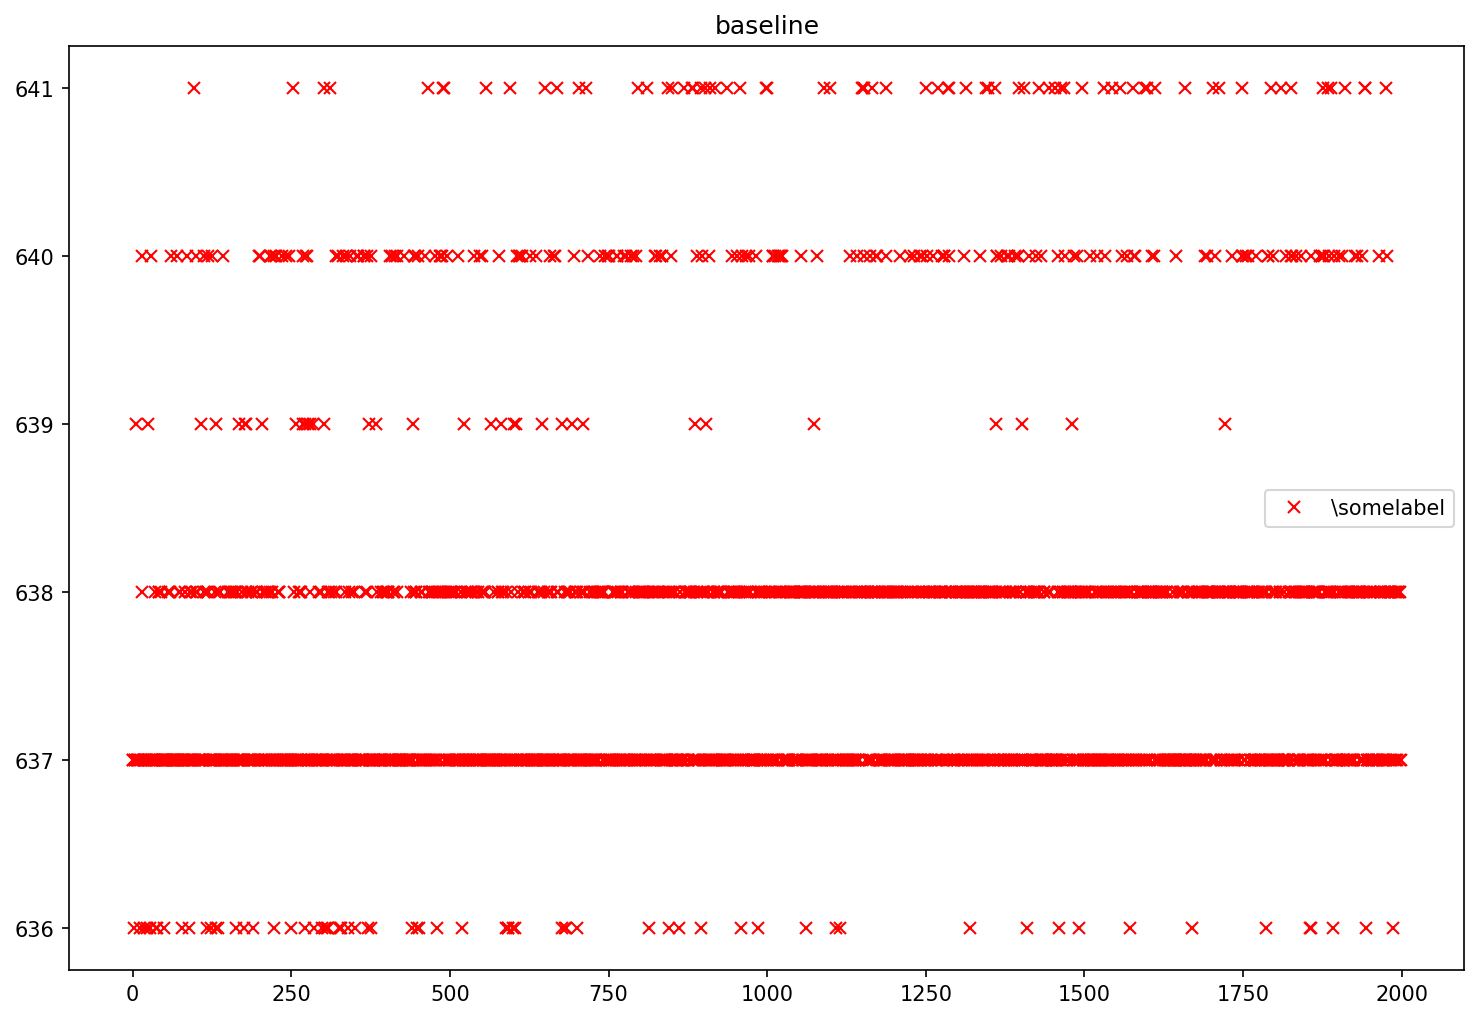

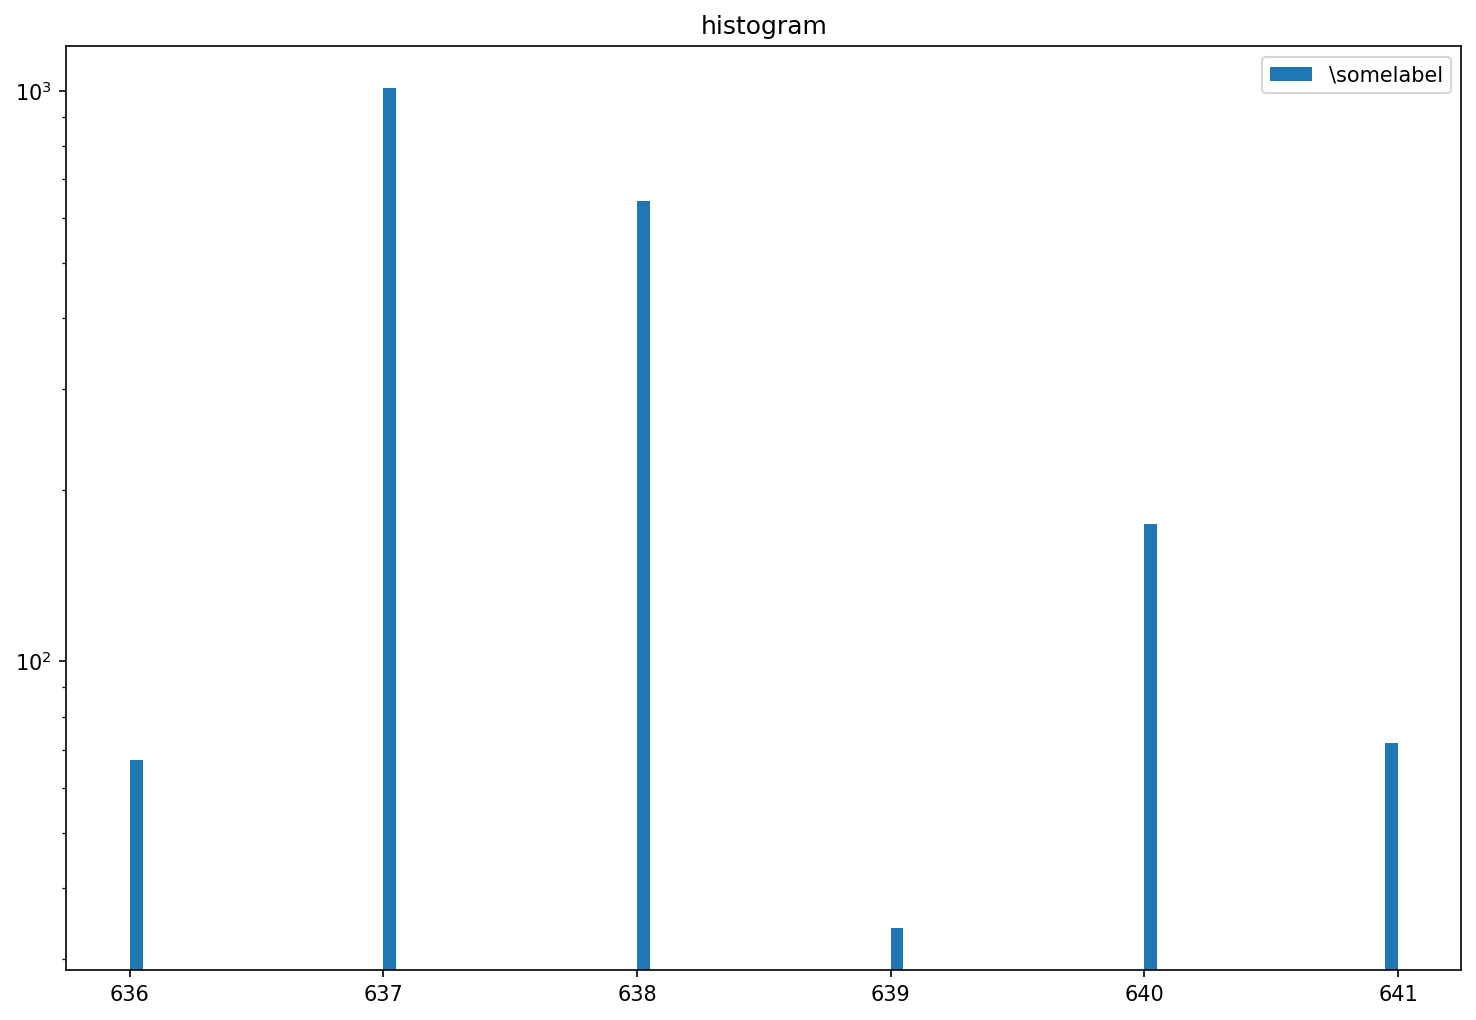

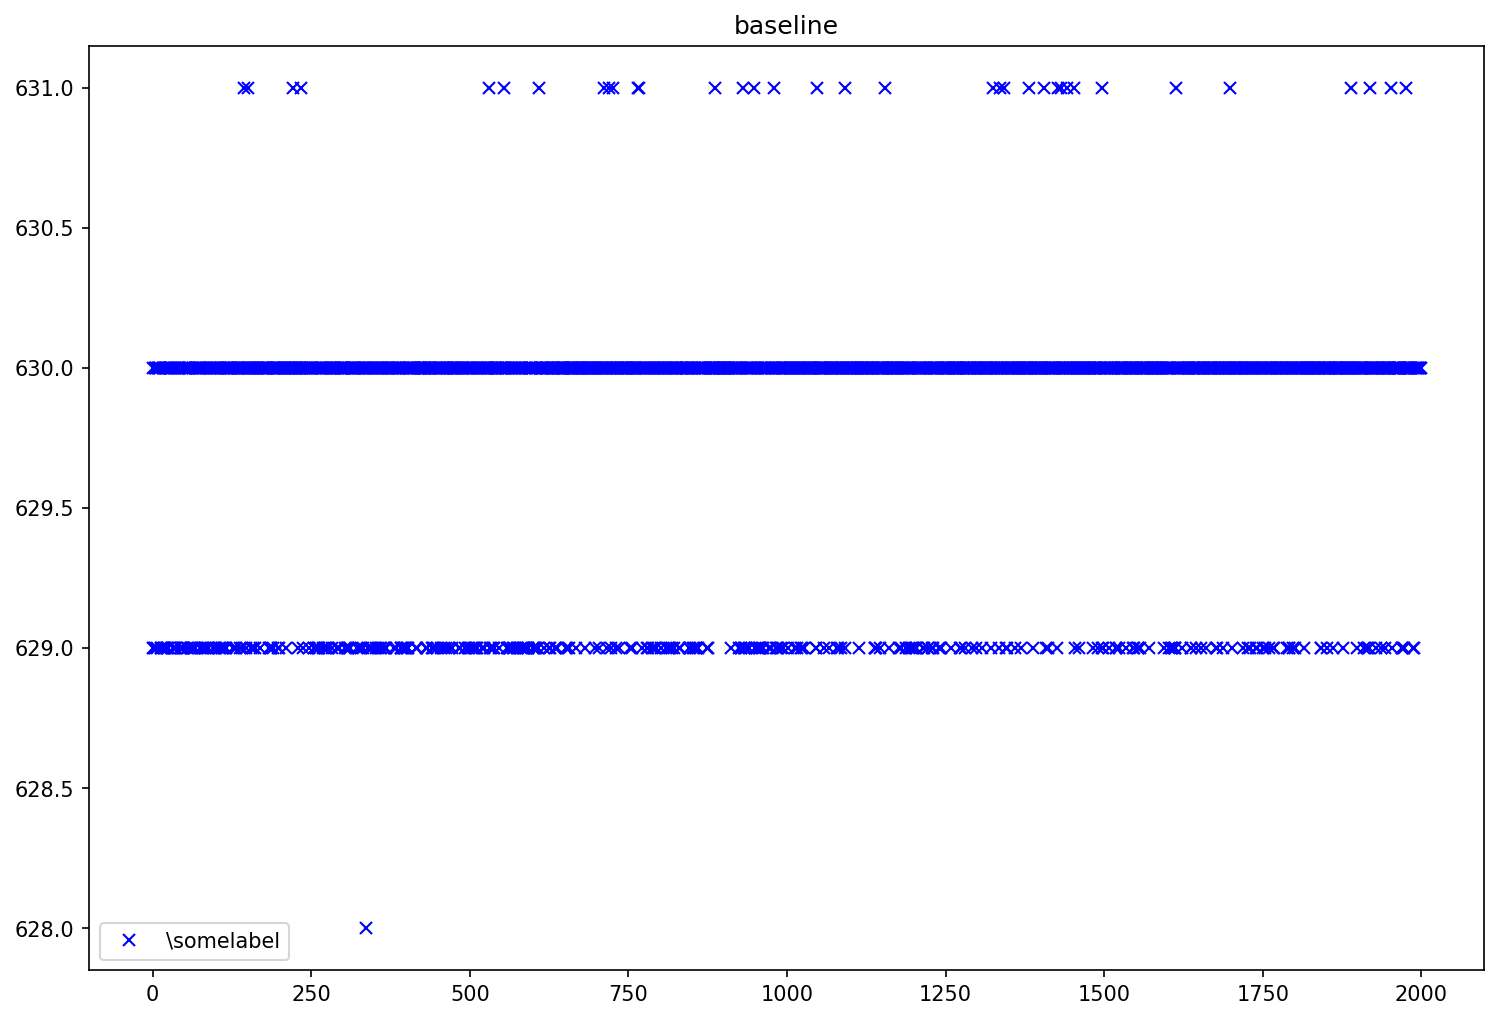

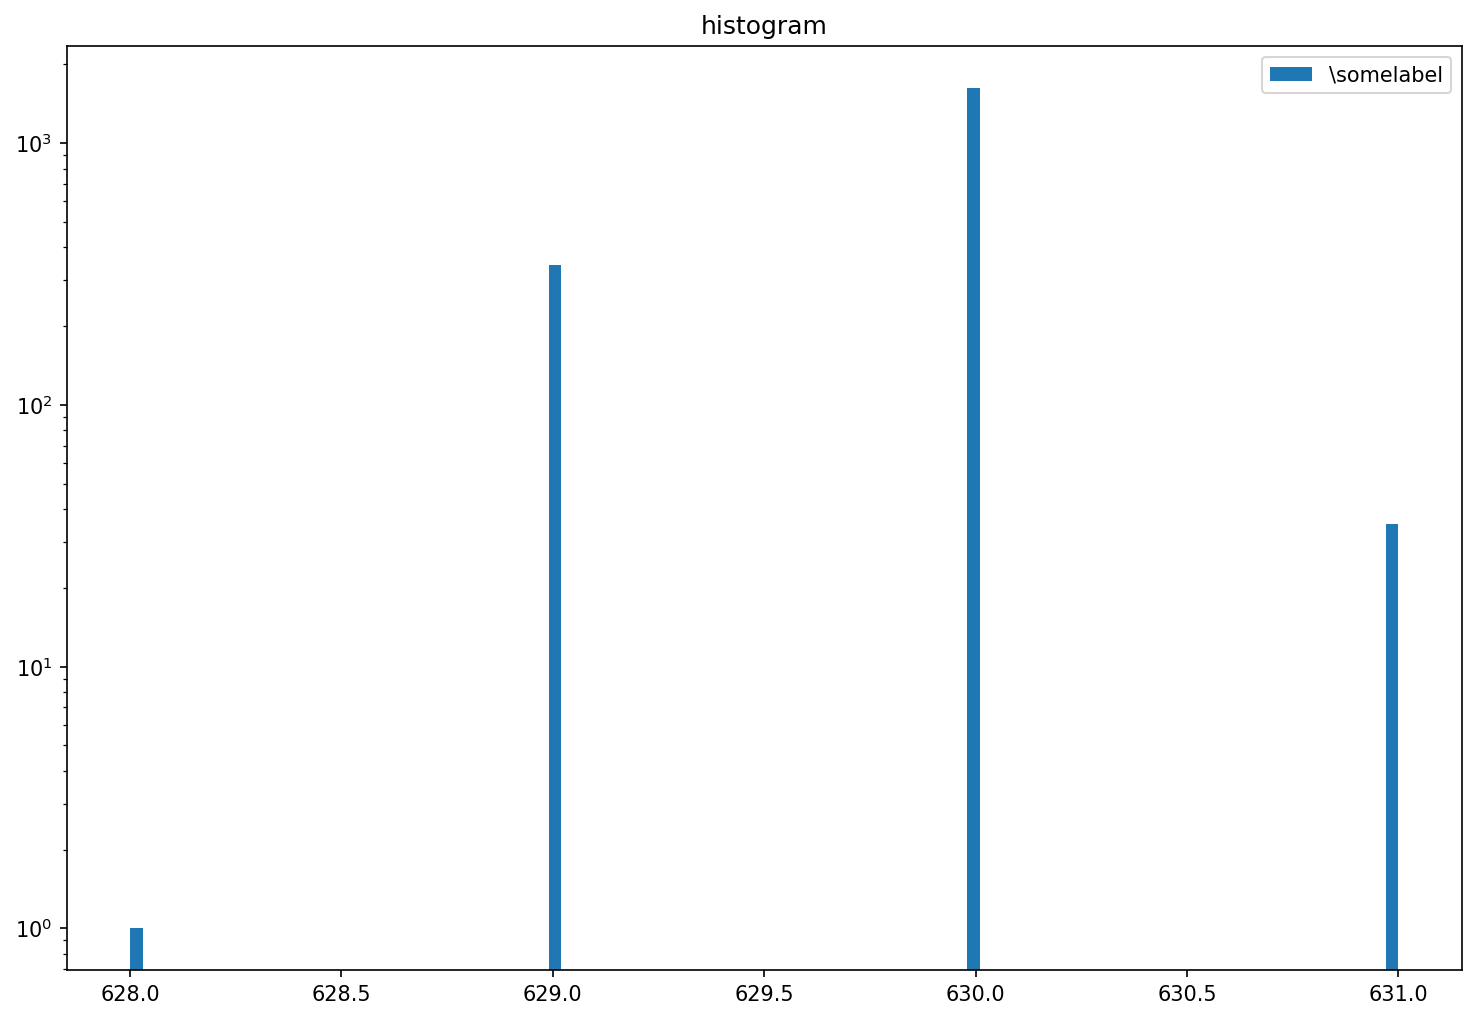

(145, 384)


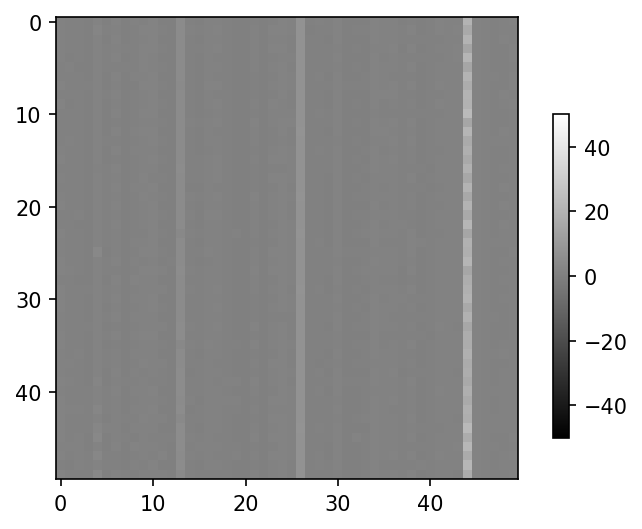

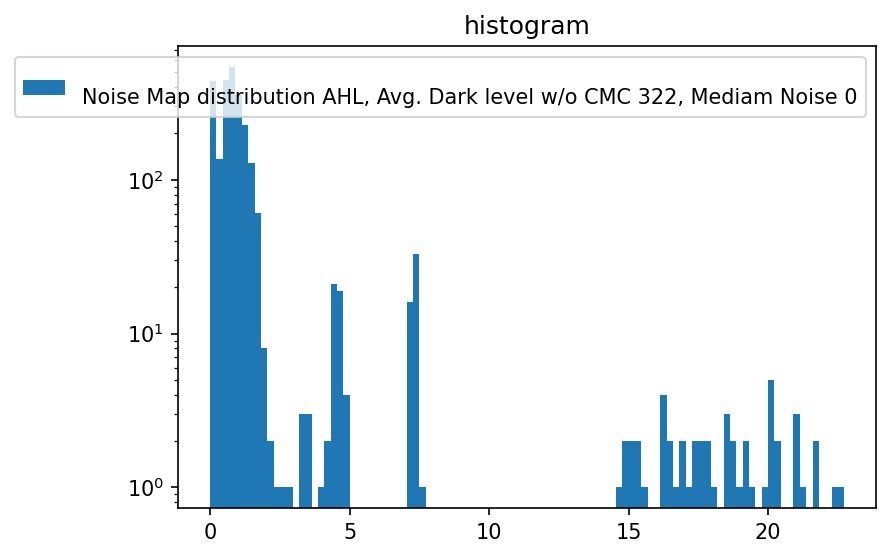


/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_5_Preamp_4_Vld1b_1_PixelCB_4_Filter_DAC_38_VRrefdac_16_DHg_0_RefGenB_1_RefGenC_2_run1.dat
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)


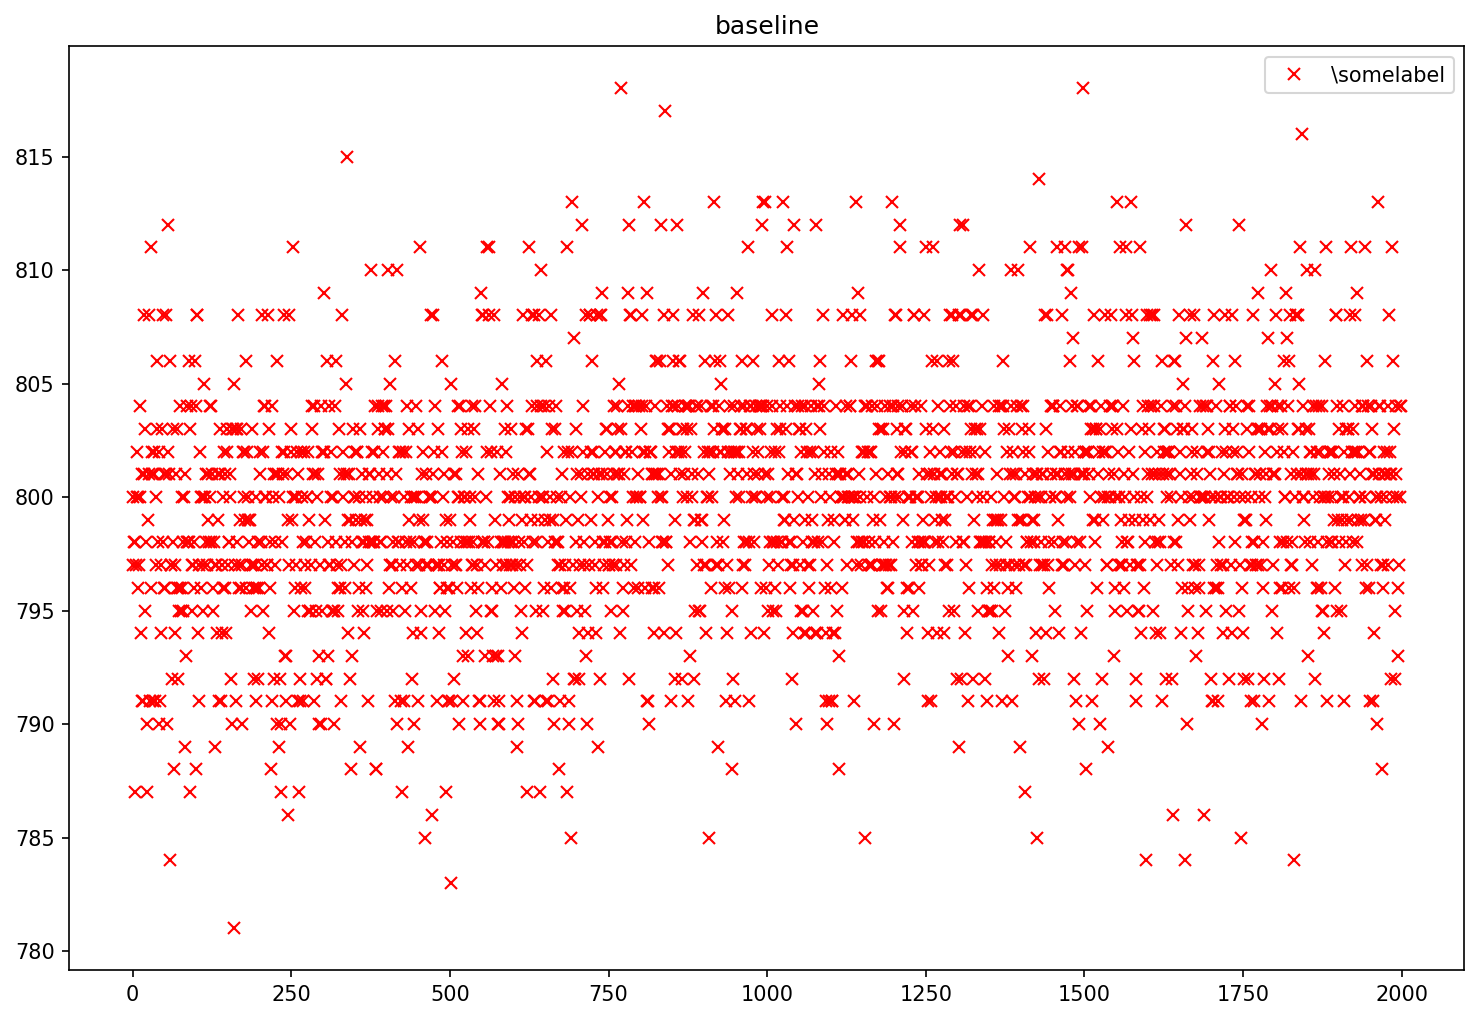

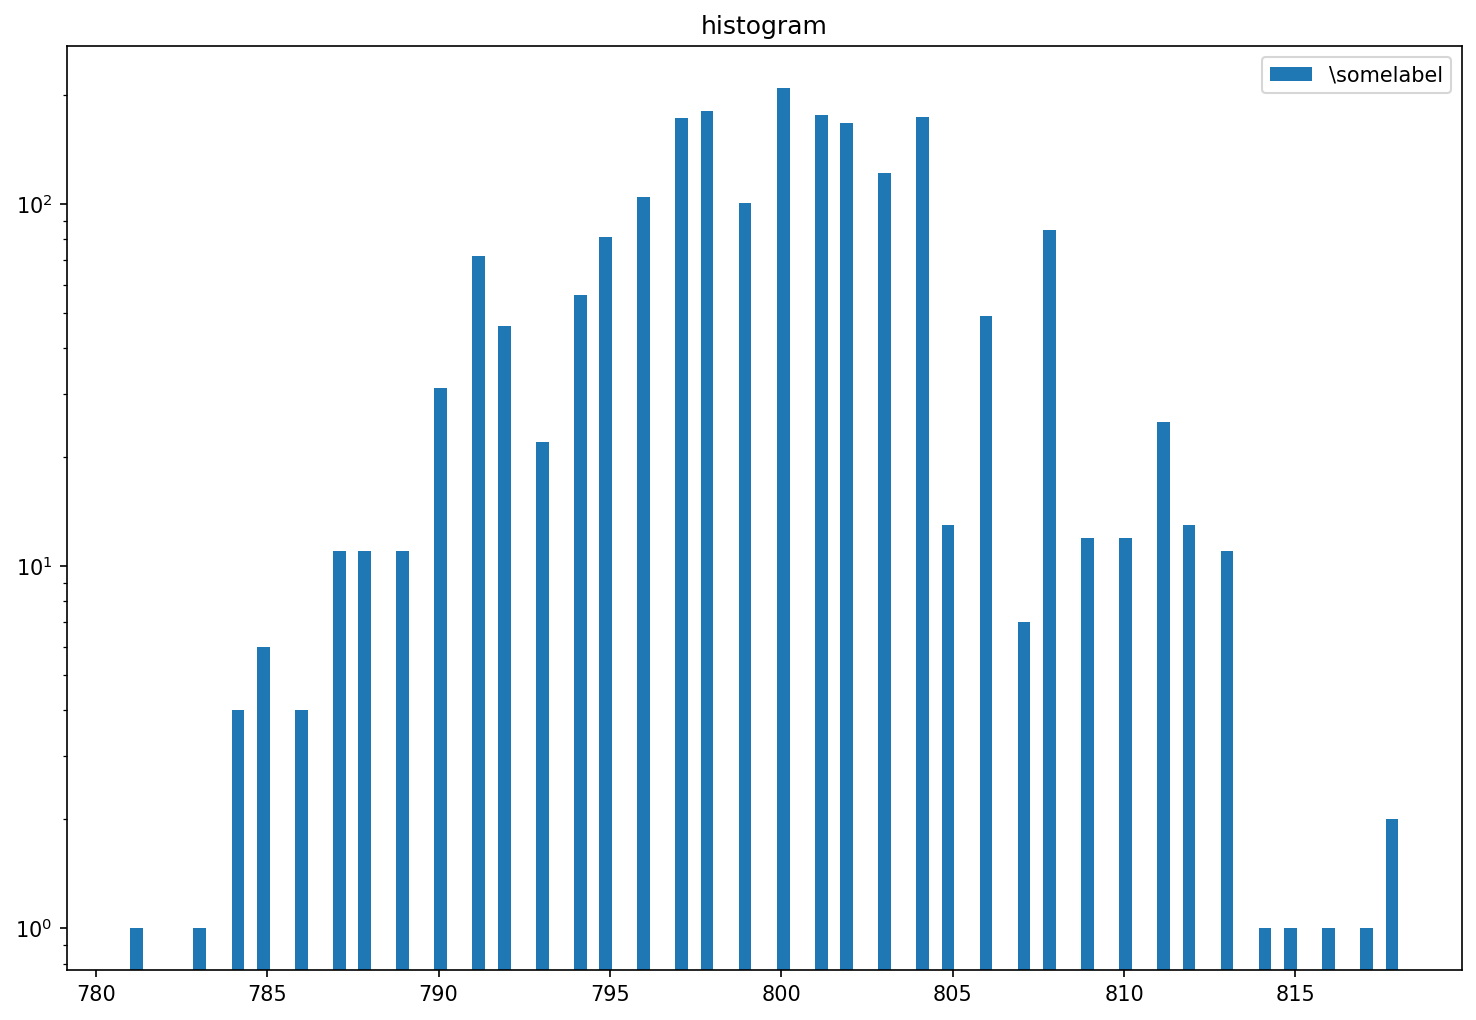

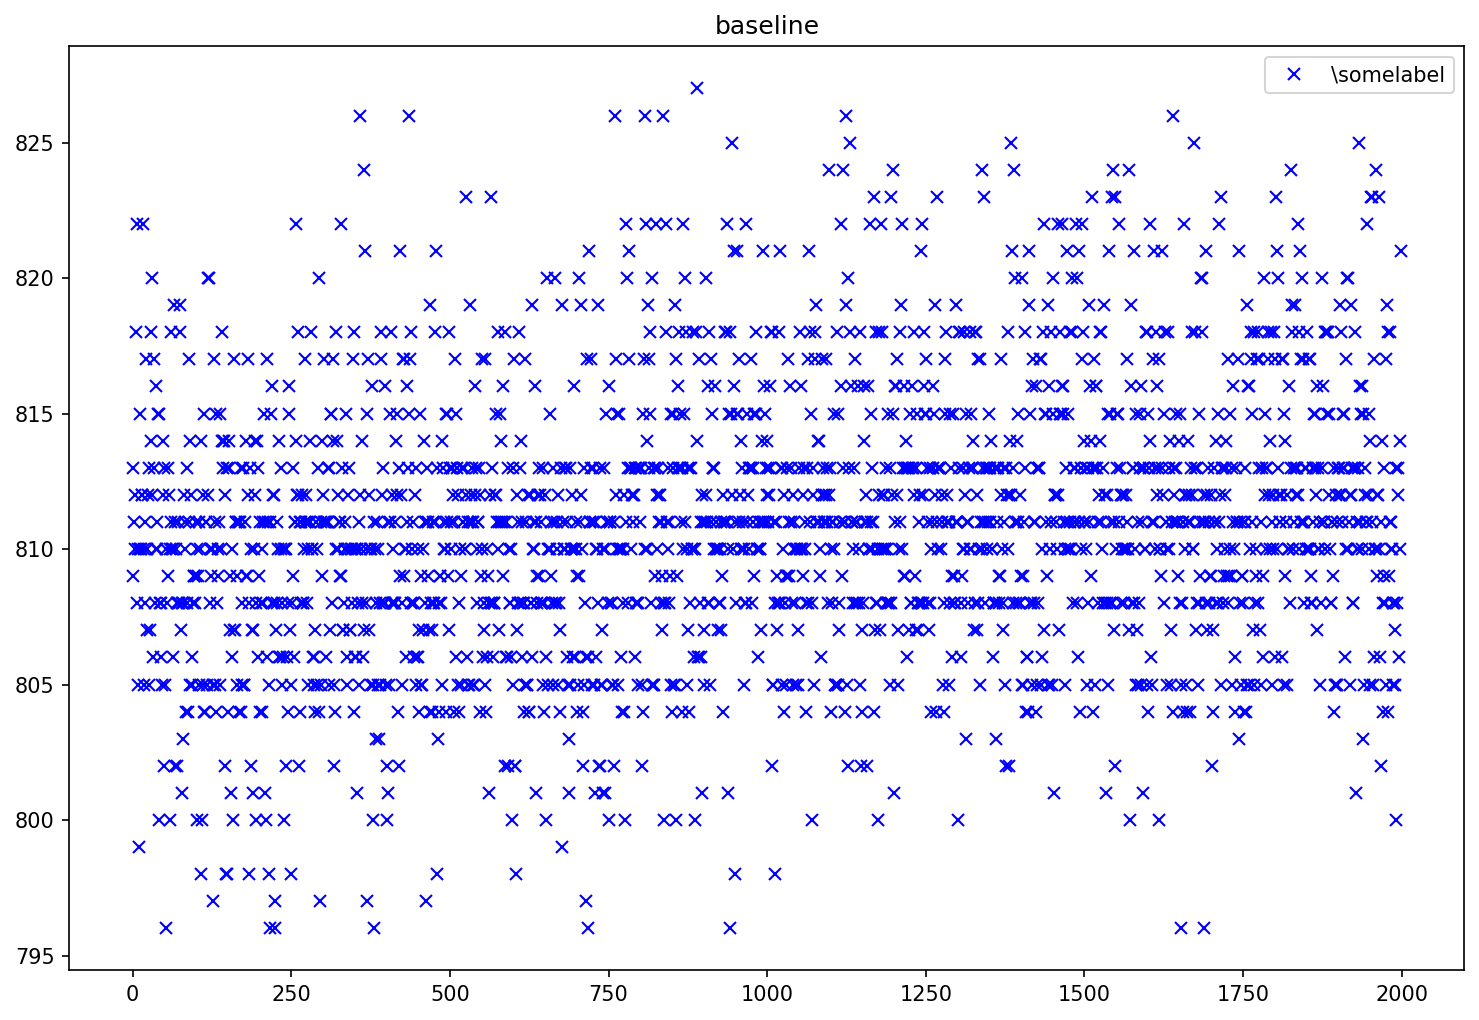

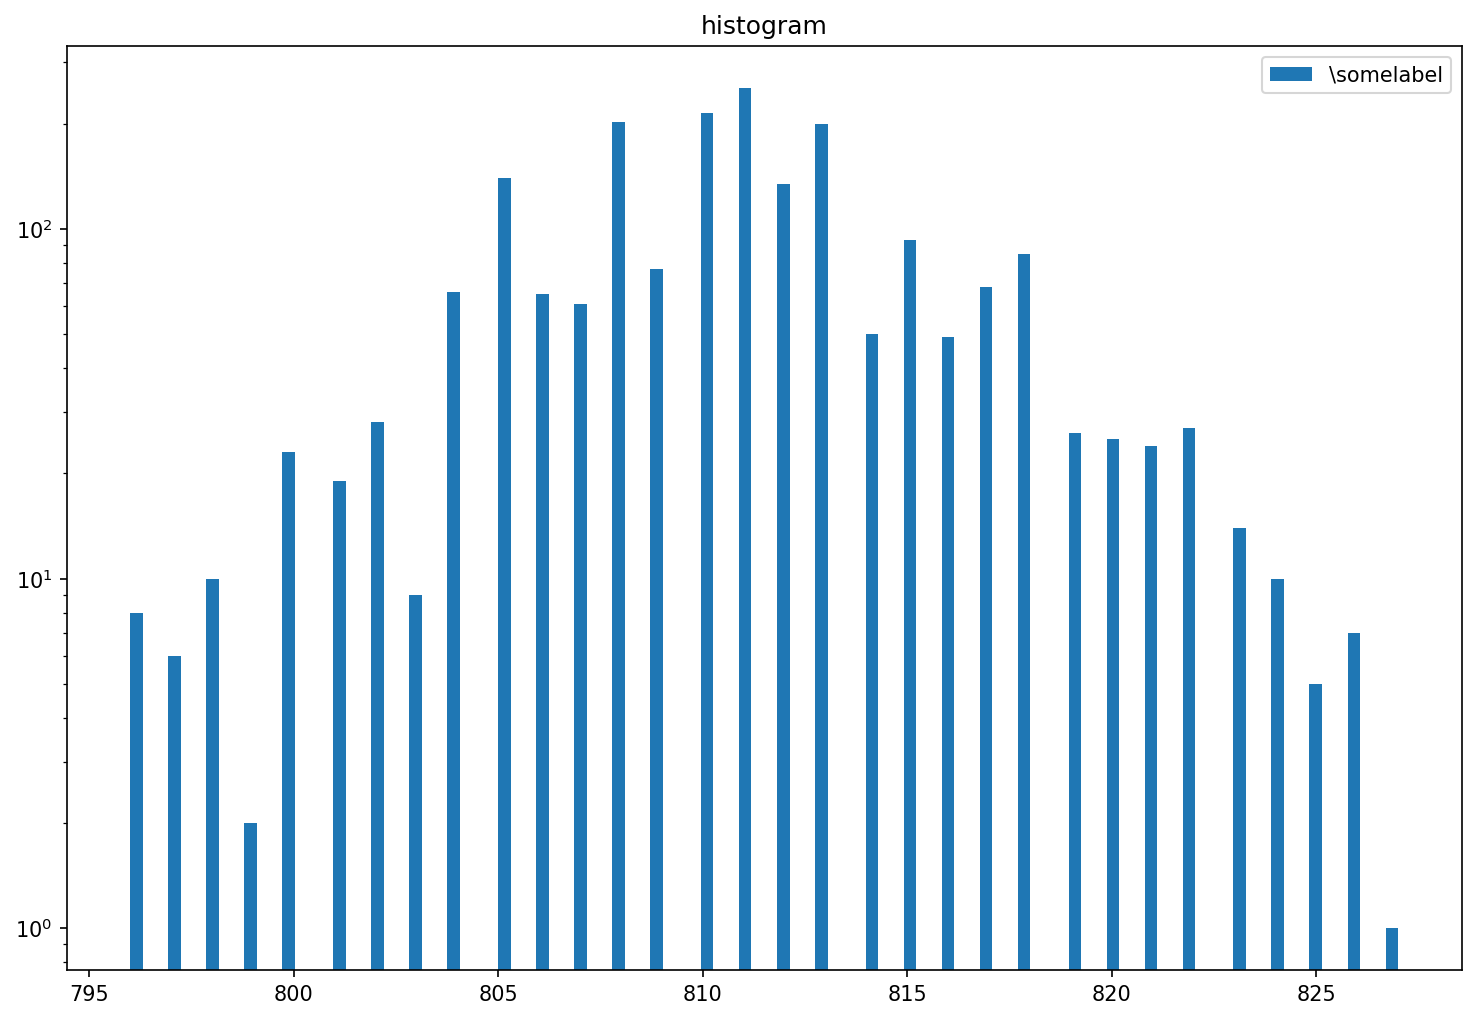

(145, 384)


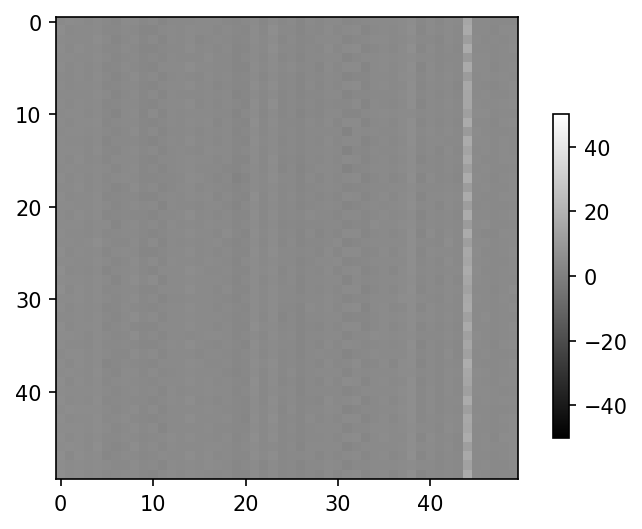

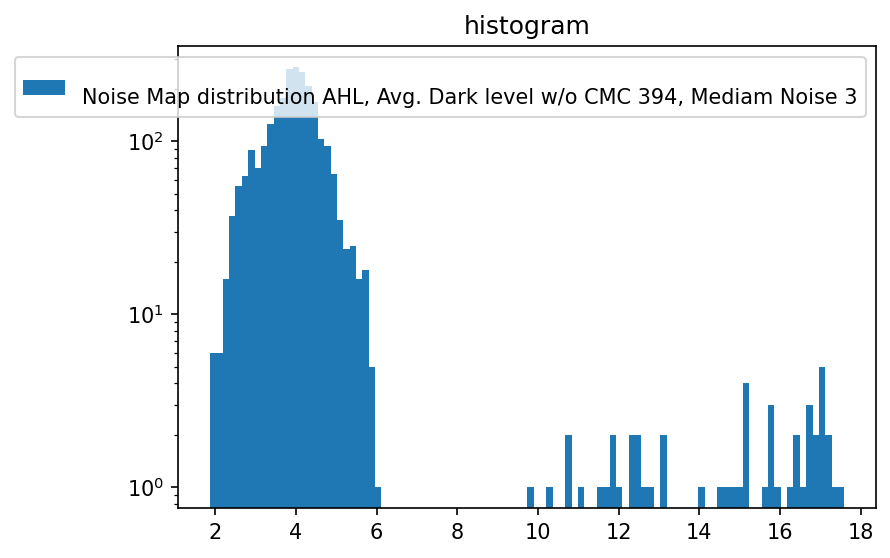


/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_5_Preamp_4_Vld1b_1_PixelCB_4_Filter_DAC_38_VRrefdac_20_DHg_0_RefGenB_1_RefGenC_2_run1.dat
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)


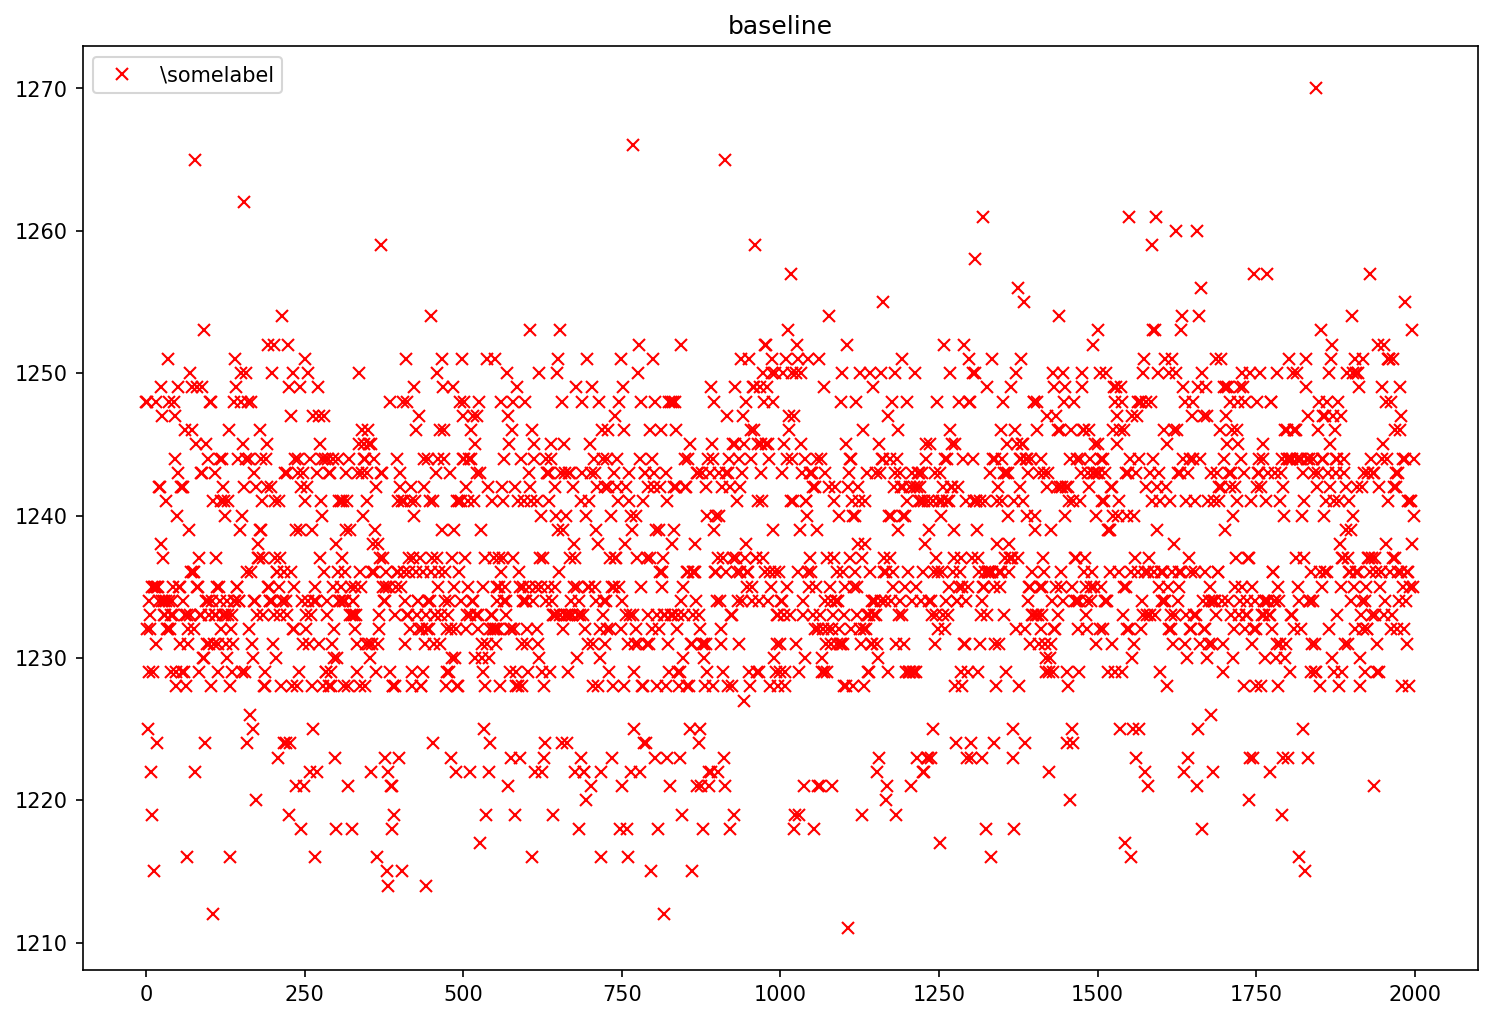

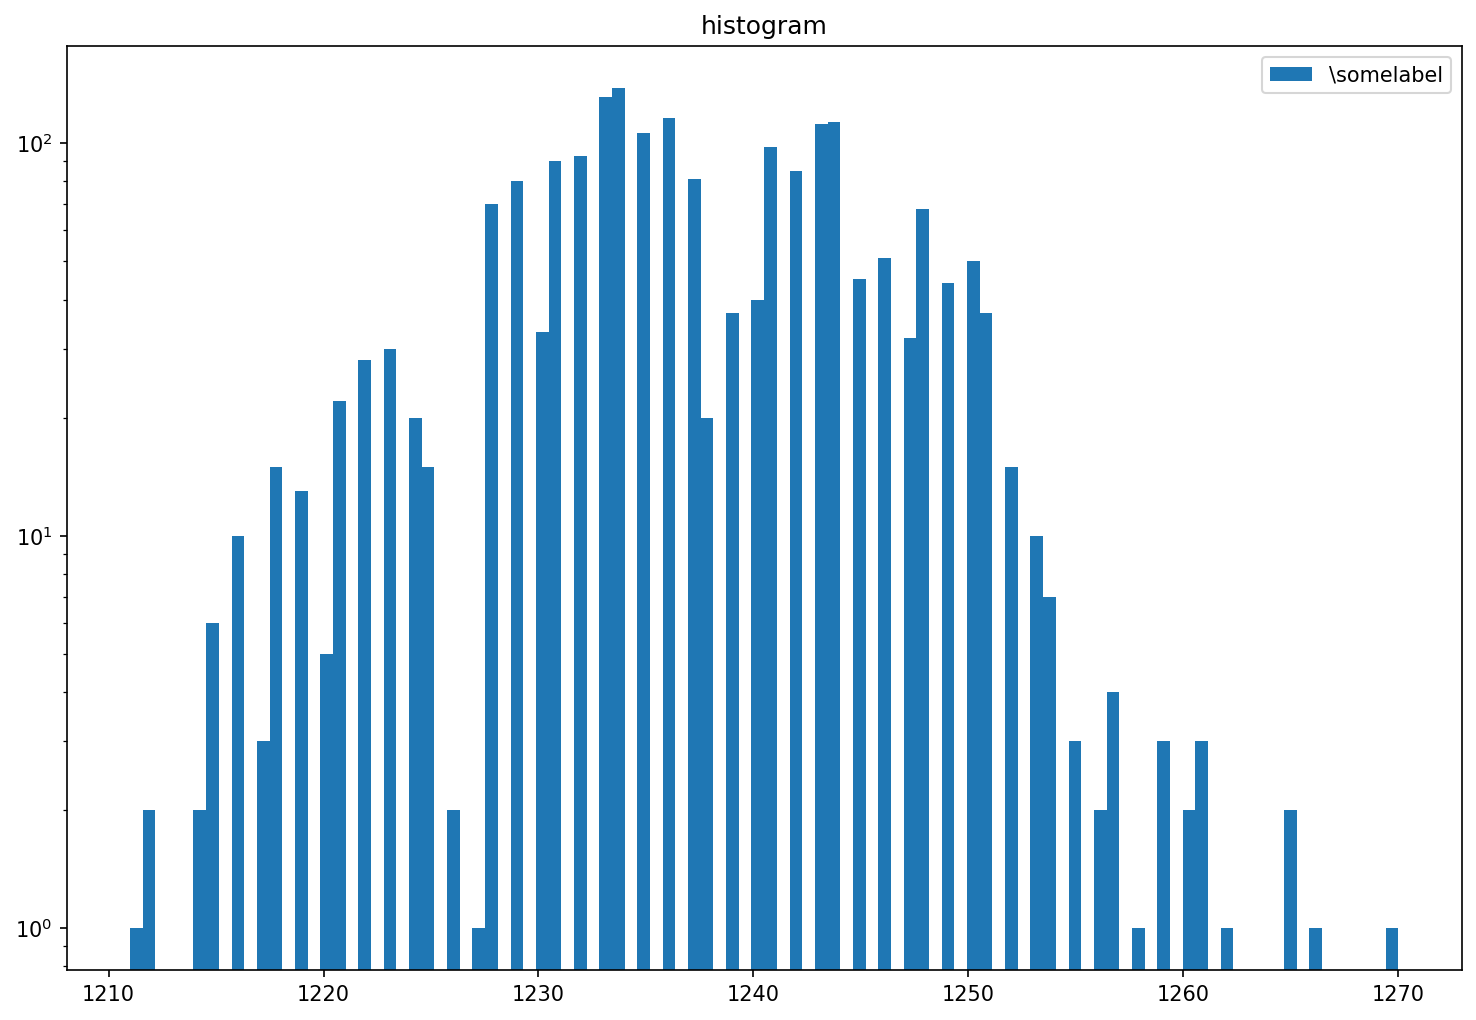

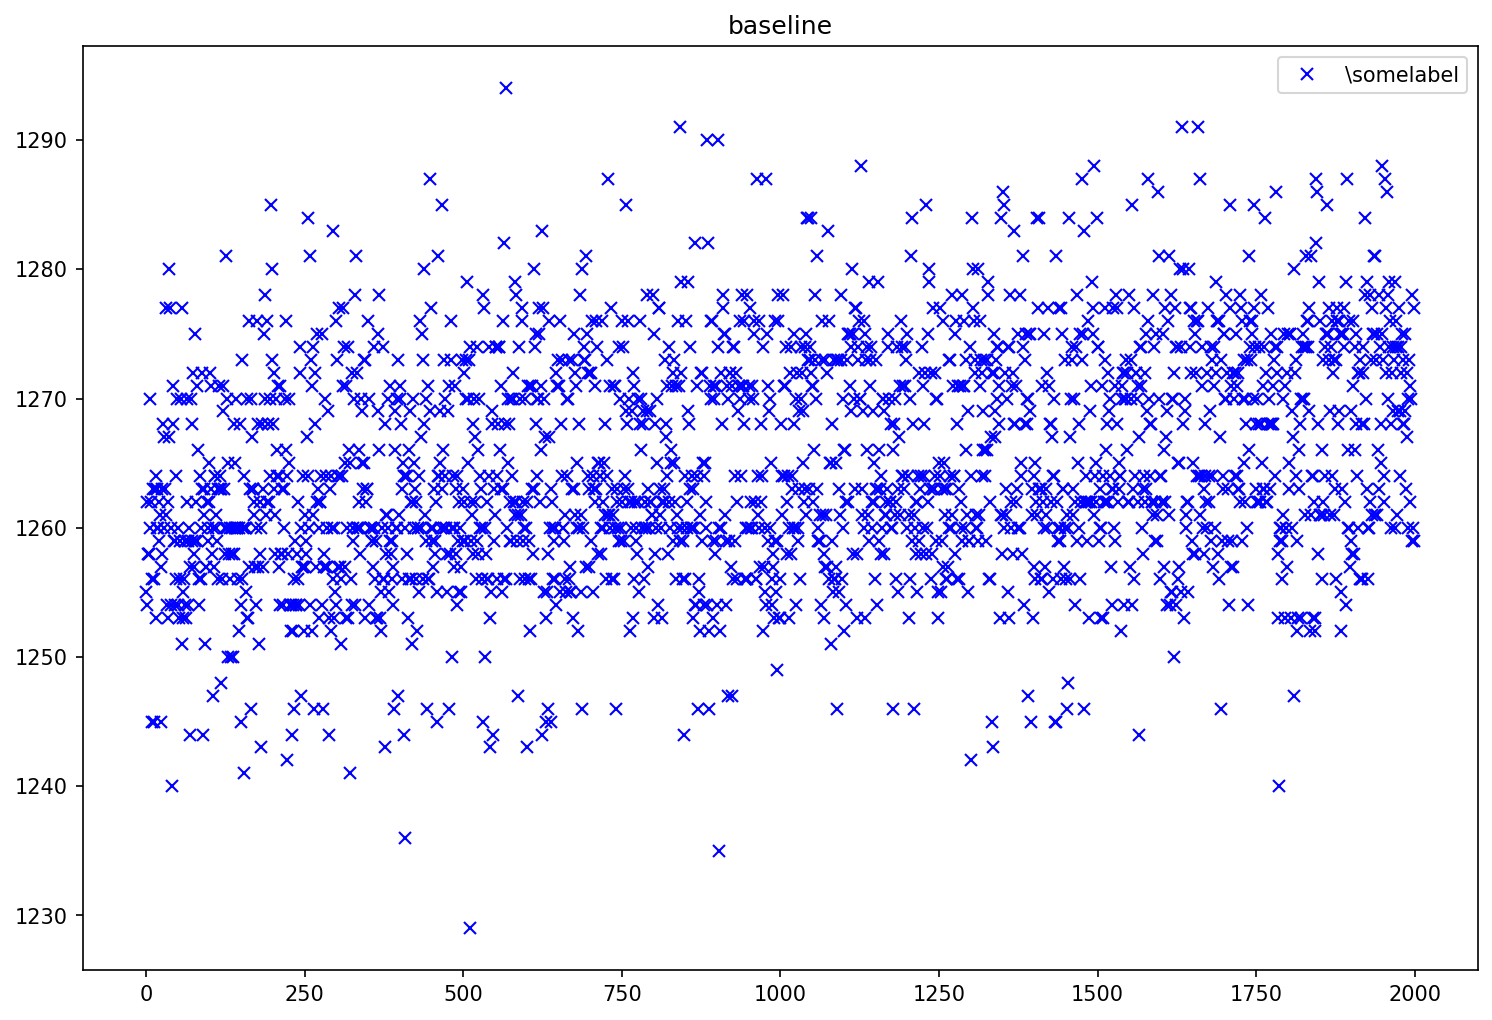

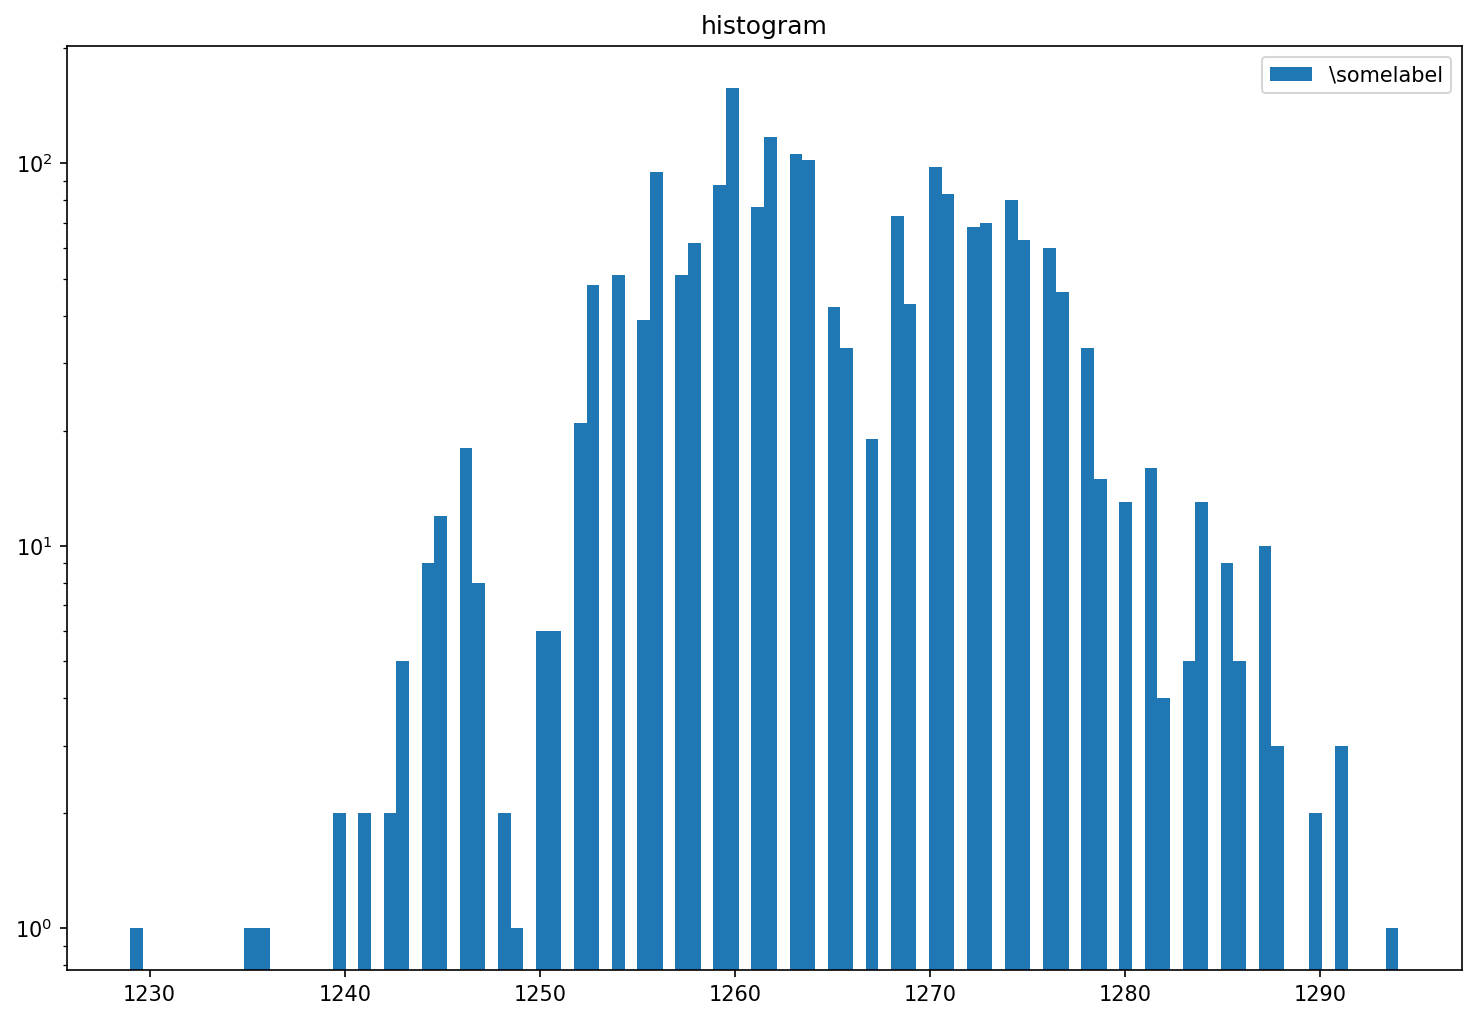

(145, 384)


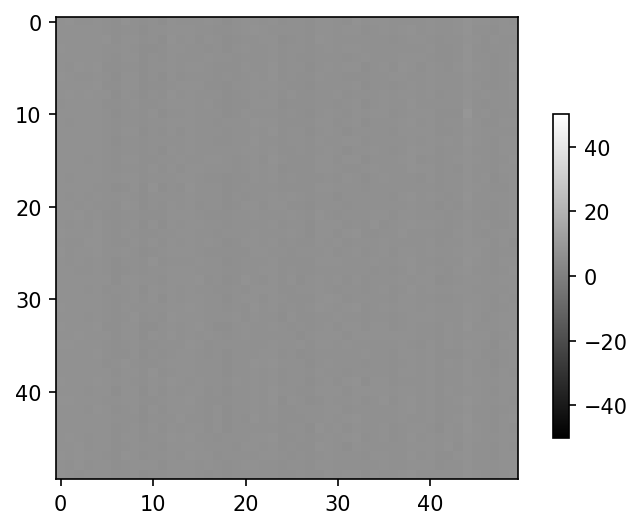

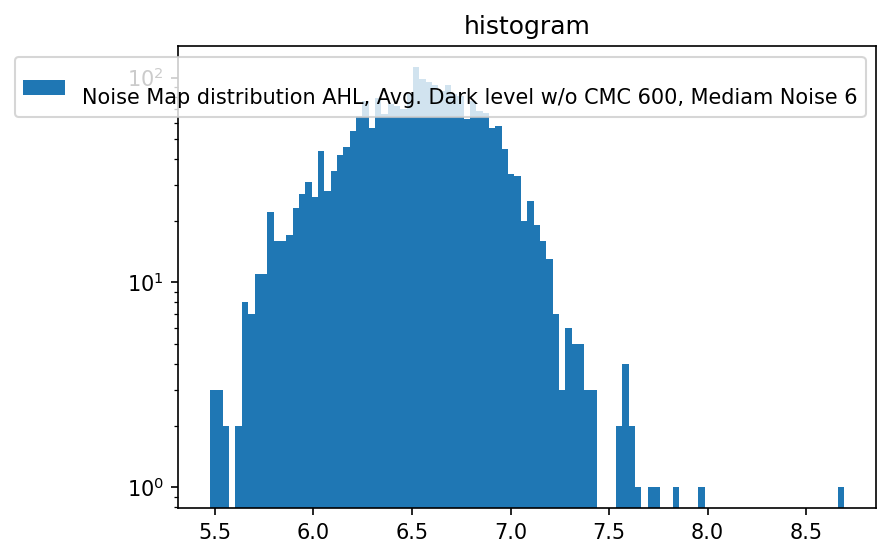


/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_5_Preamp_4_Vld1b_1_PixelCB_4_Filter_DAC_38_VRrefdac_24_DHg_0_RefGenB_1_RefGenC_2_run1.dat
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)


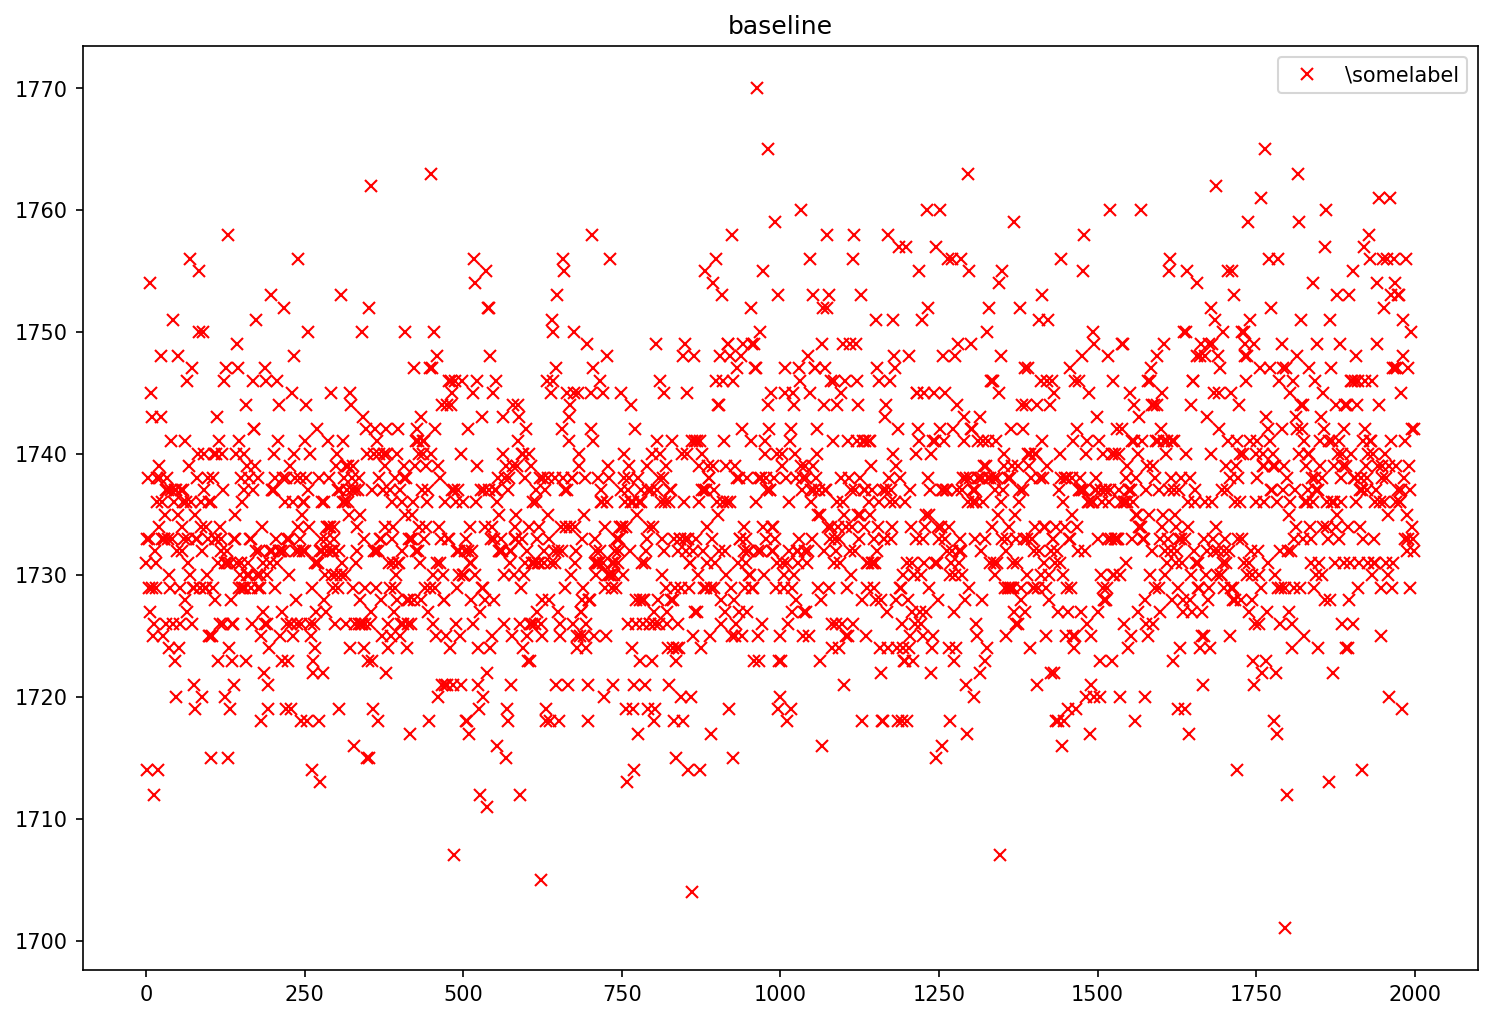

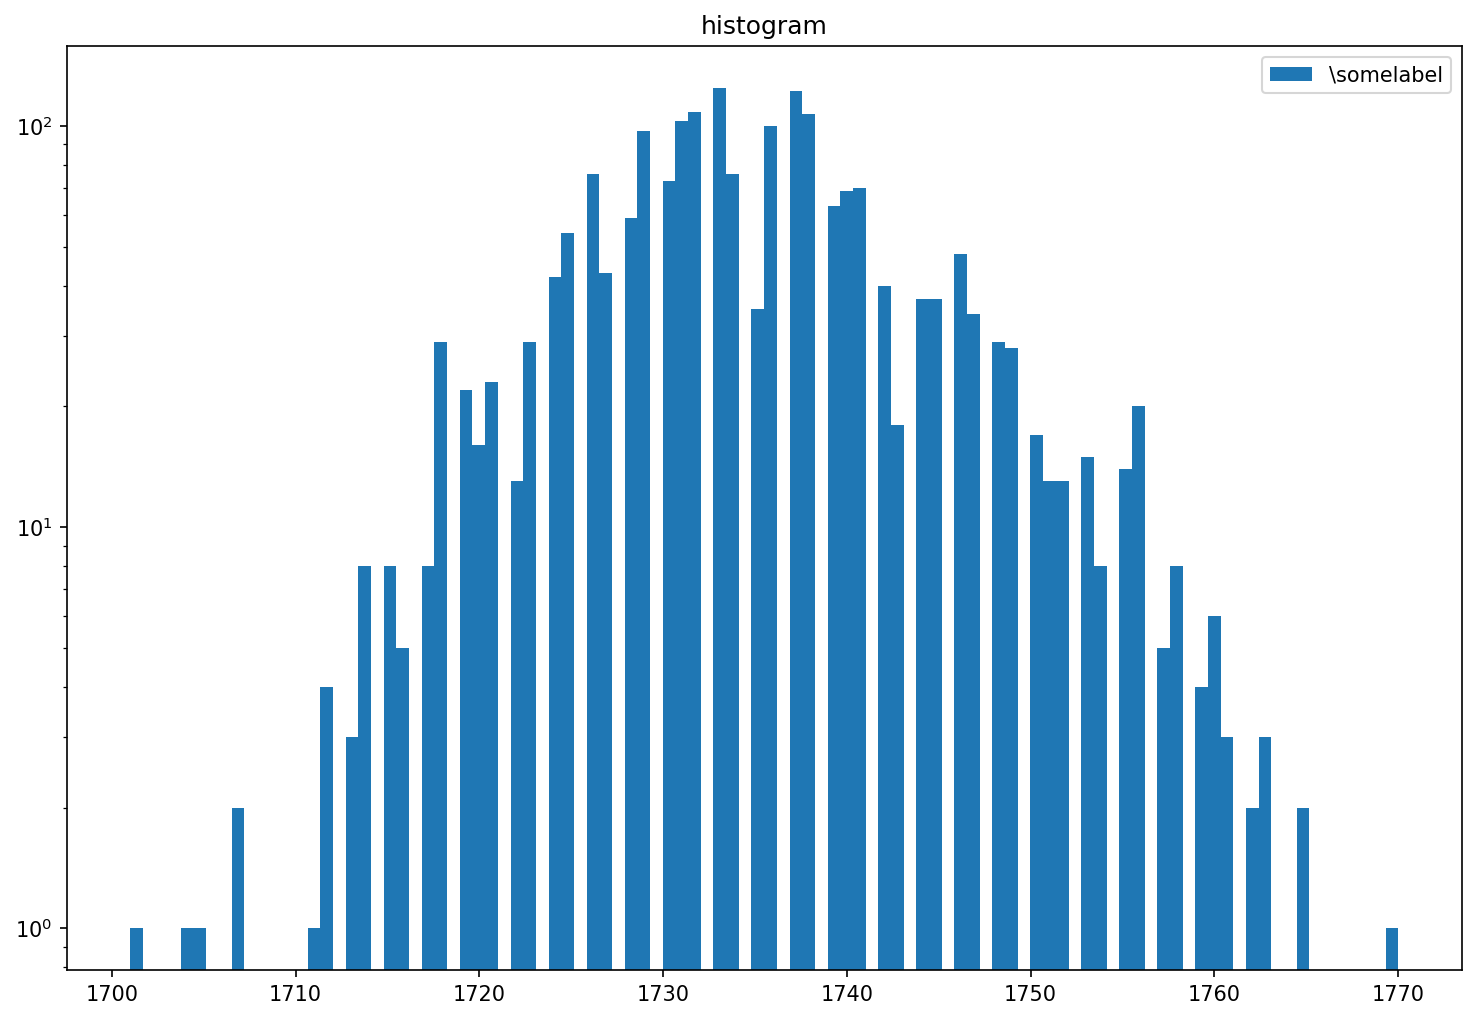

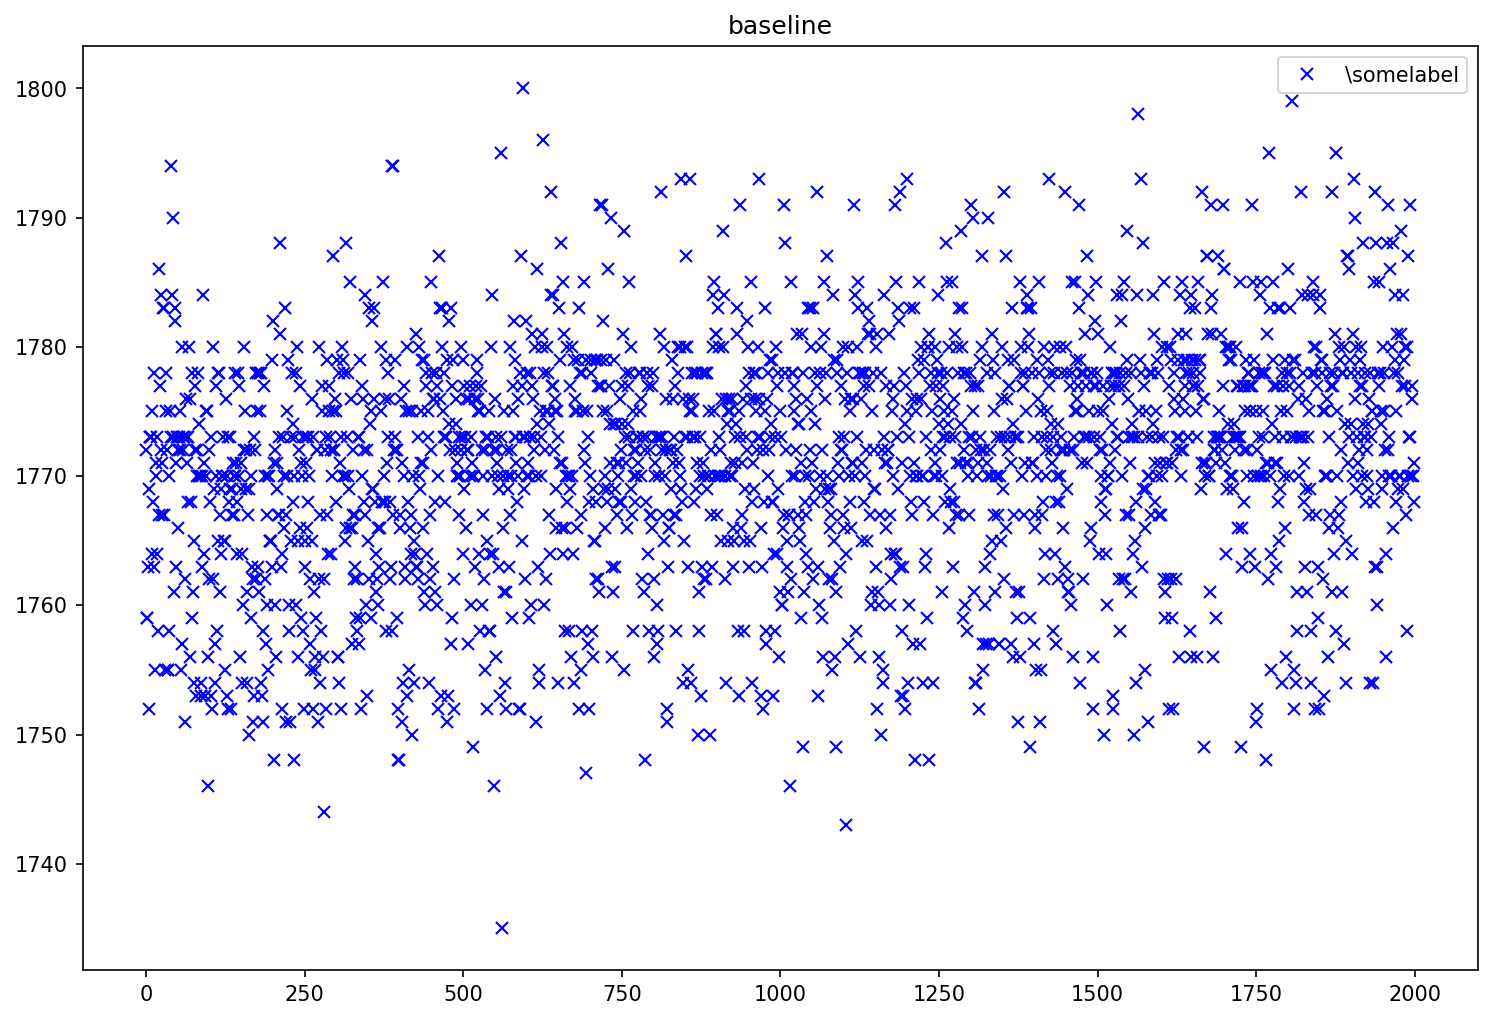

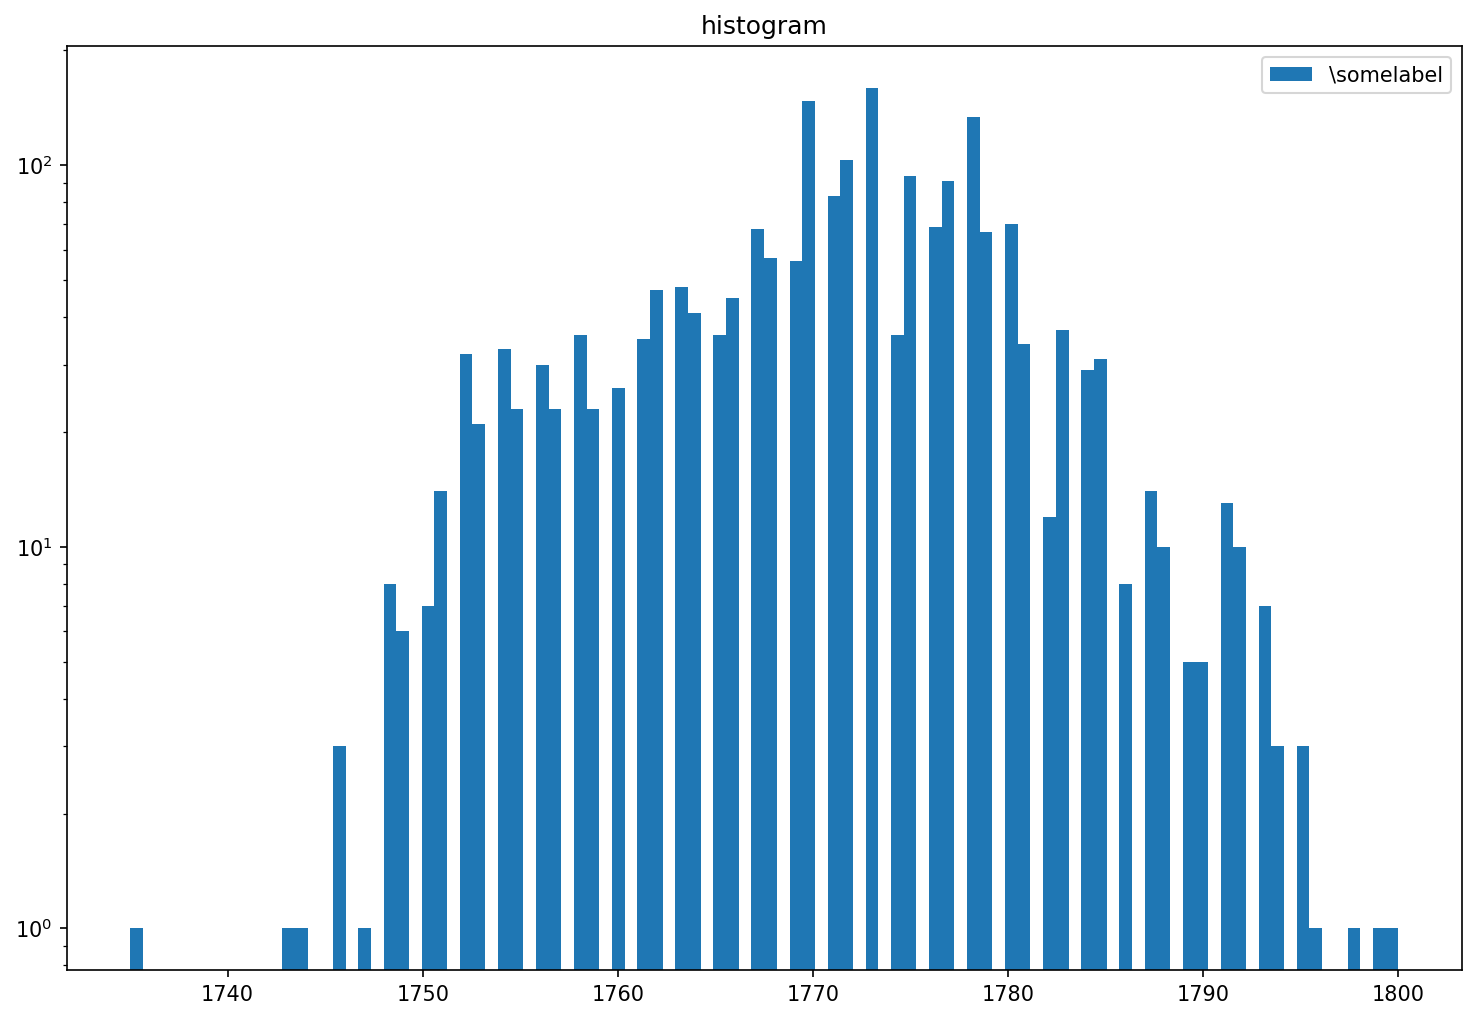

(145, 384)


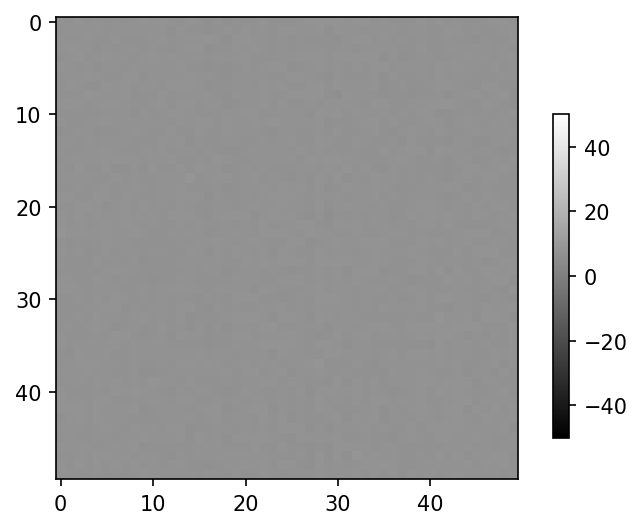

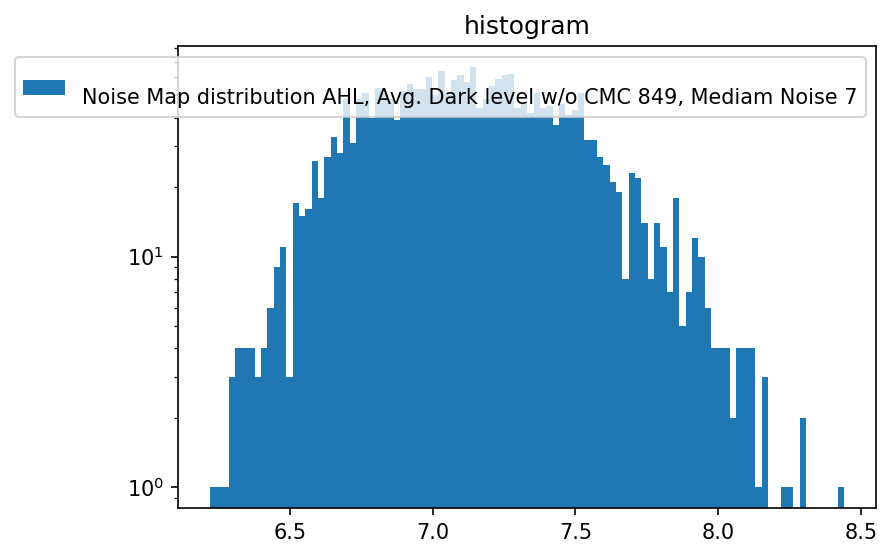


/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_5_Preamp_4_Vld1b_1_PixelCB_4_Filter_DAC_38_VRrefdac_28_DHg_0_RefGenB_1_RefGenC_2_run1.dat
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)


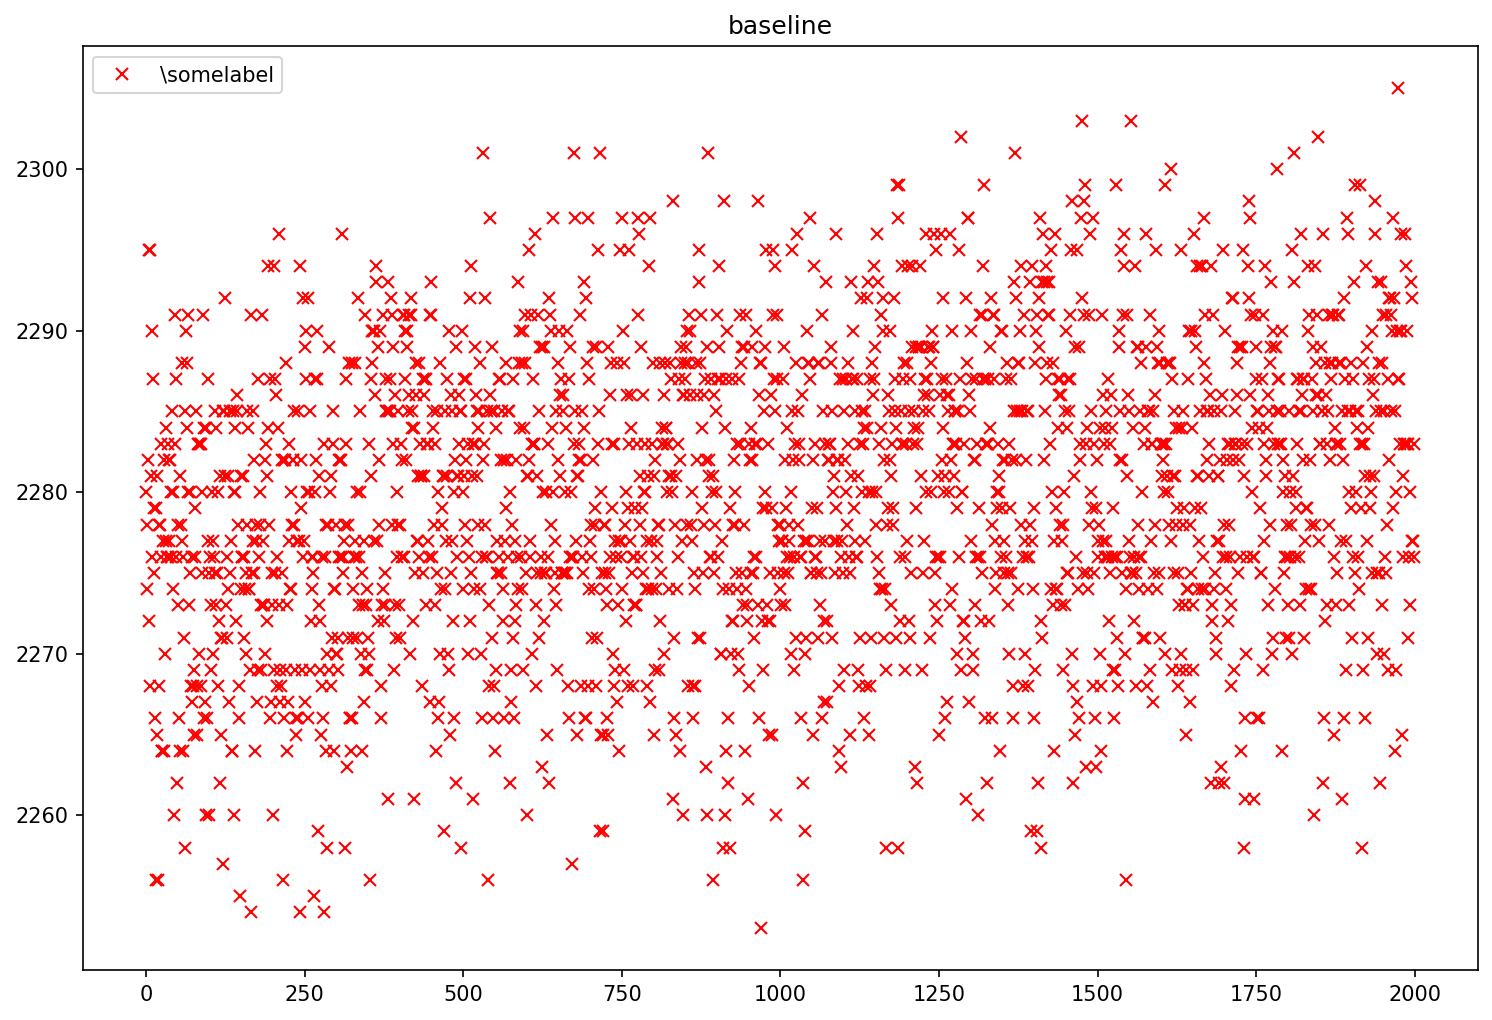

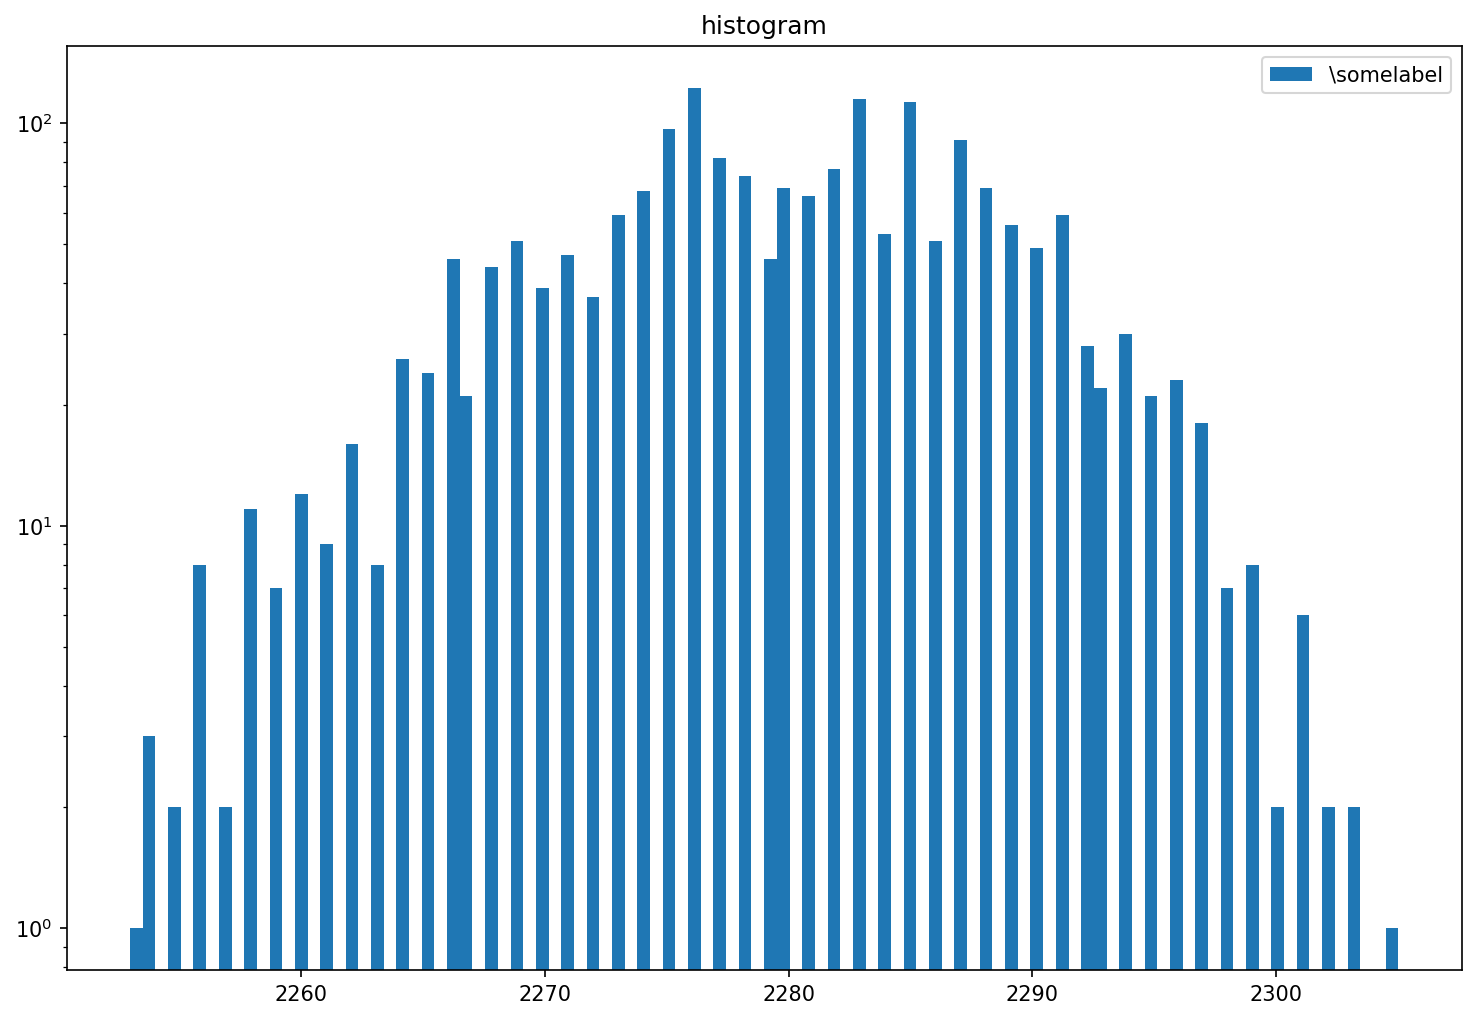

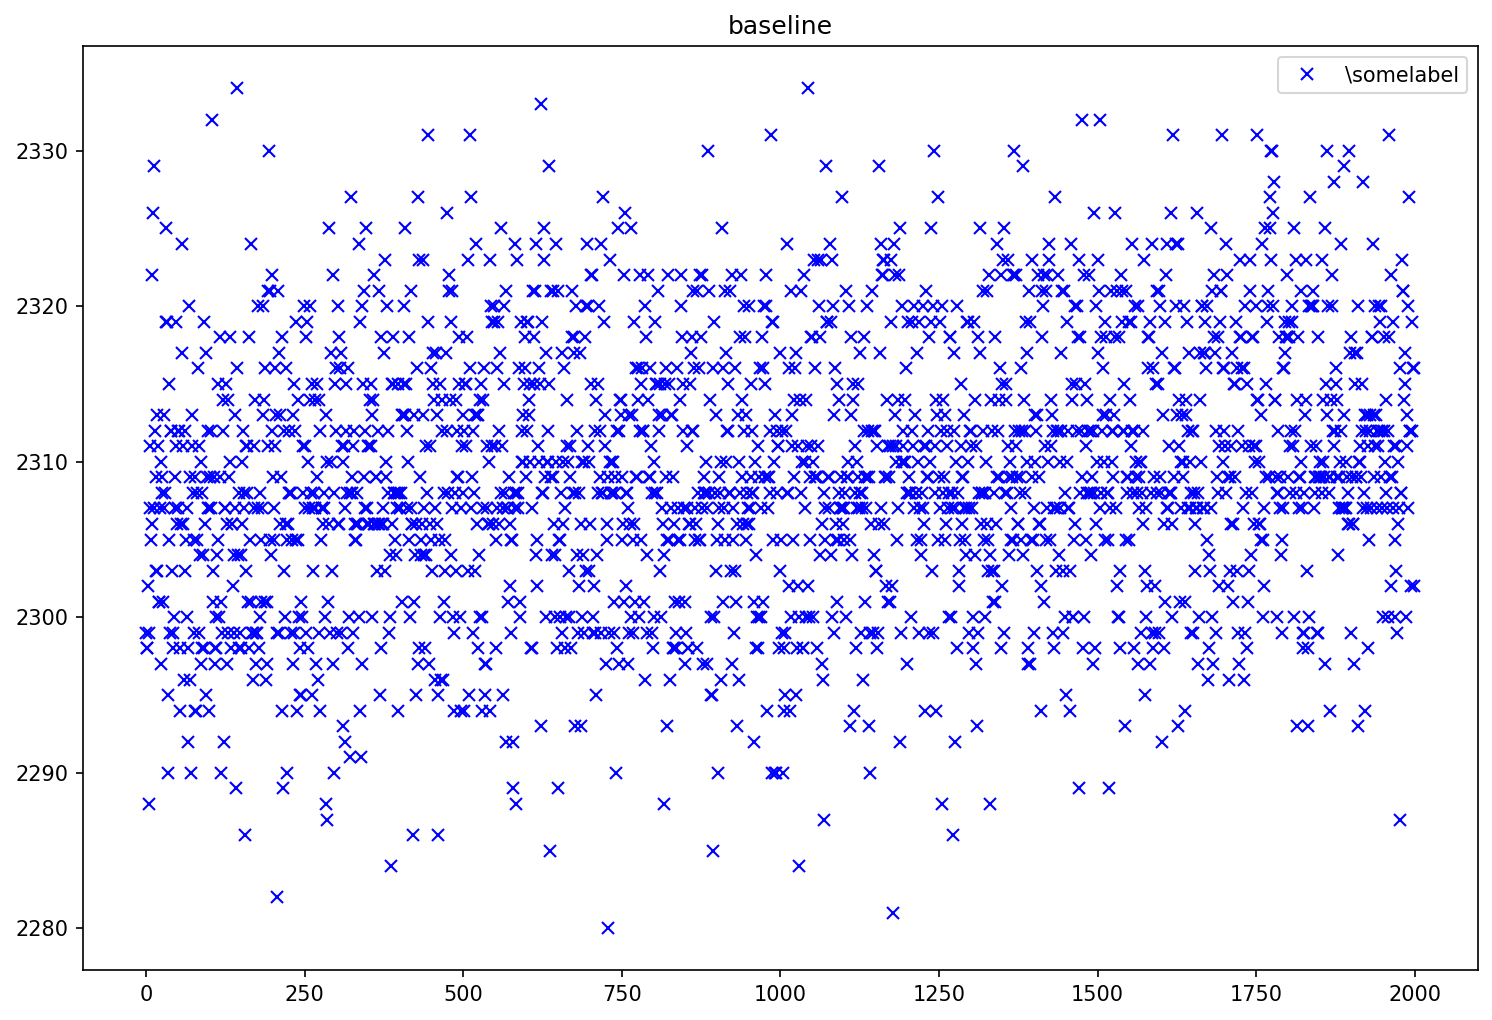

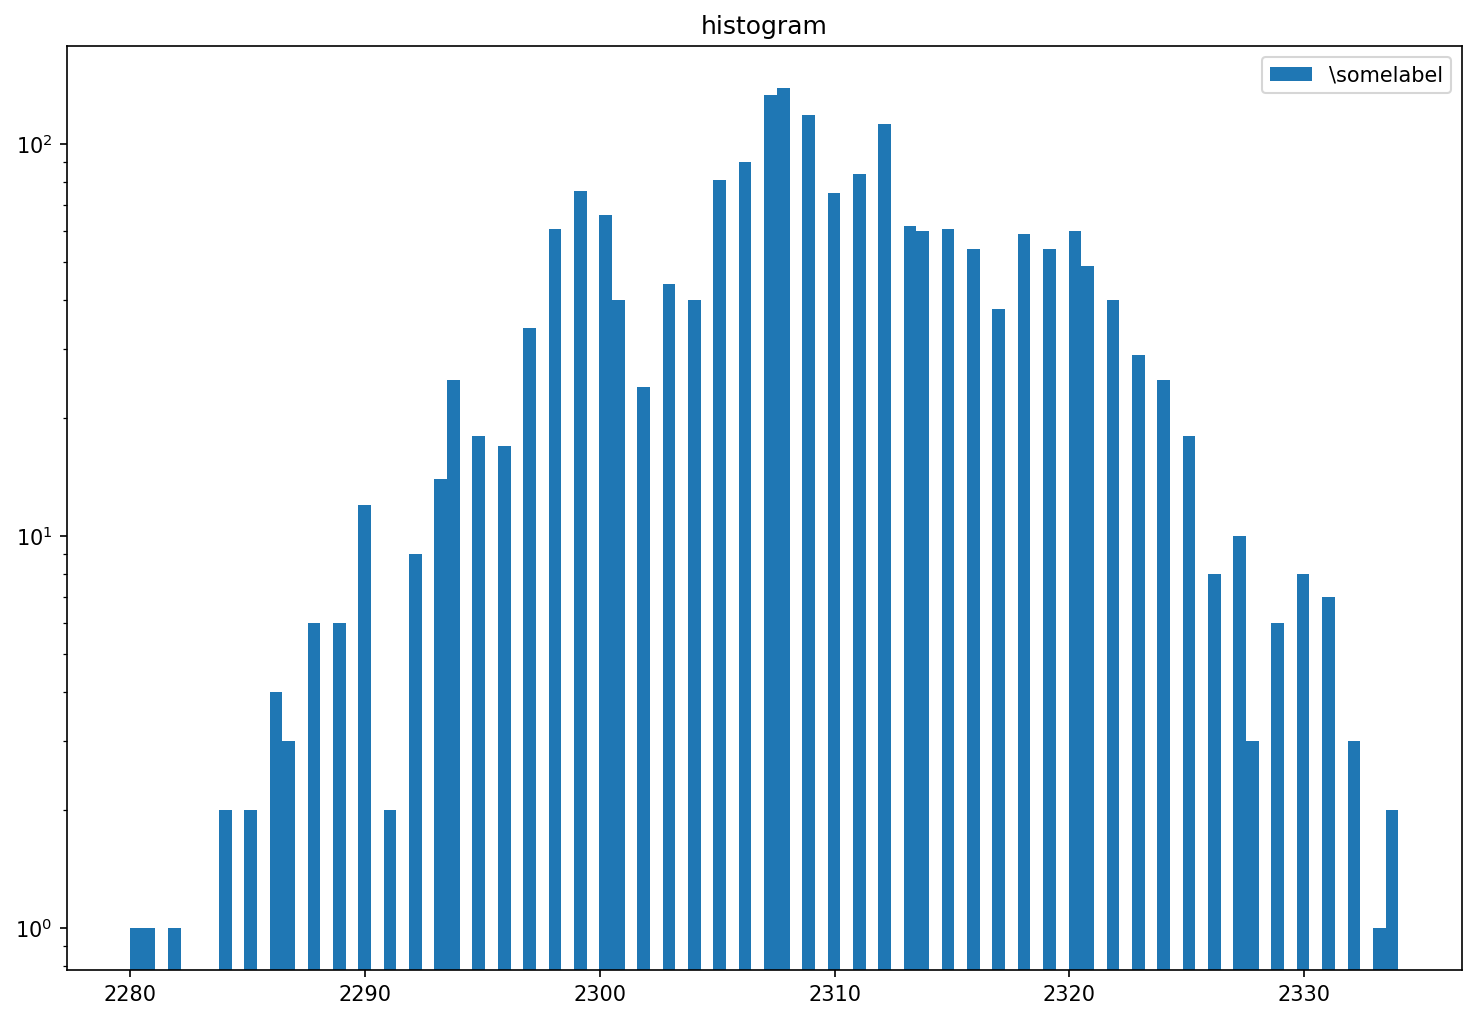

(145, 384)


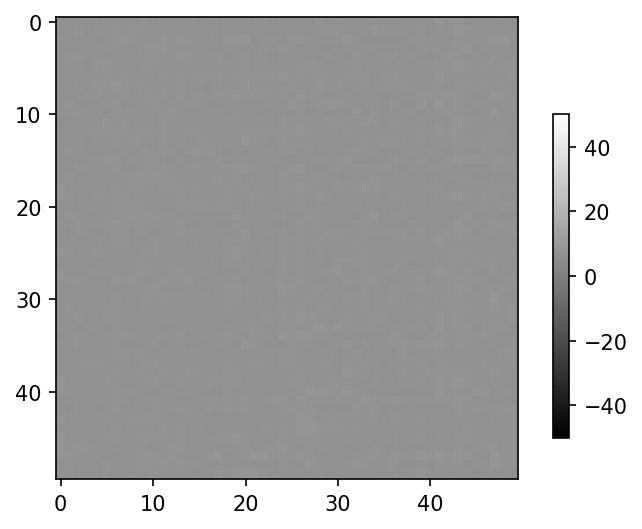

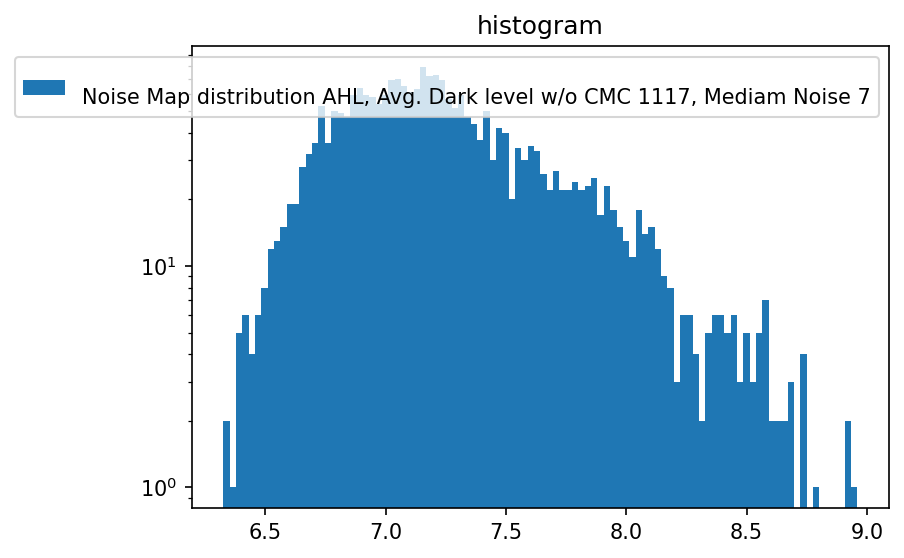


/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_5_Preamp_4_Vld1b_1_PixelCB_4_Filter_DAC_38_VRrefdac_32_DHg_0_RefGenB_1_RefGenC_2_run1.dat
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)


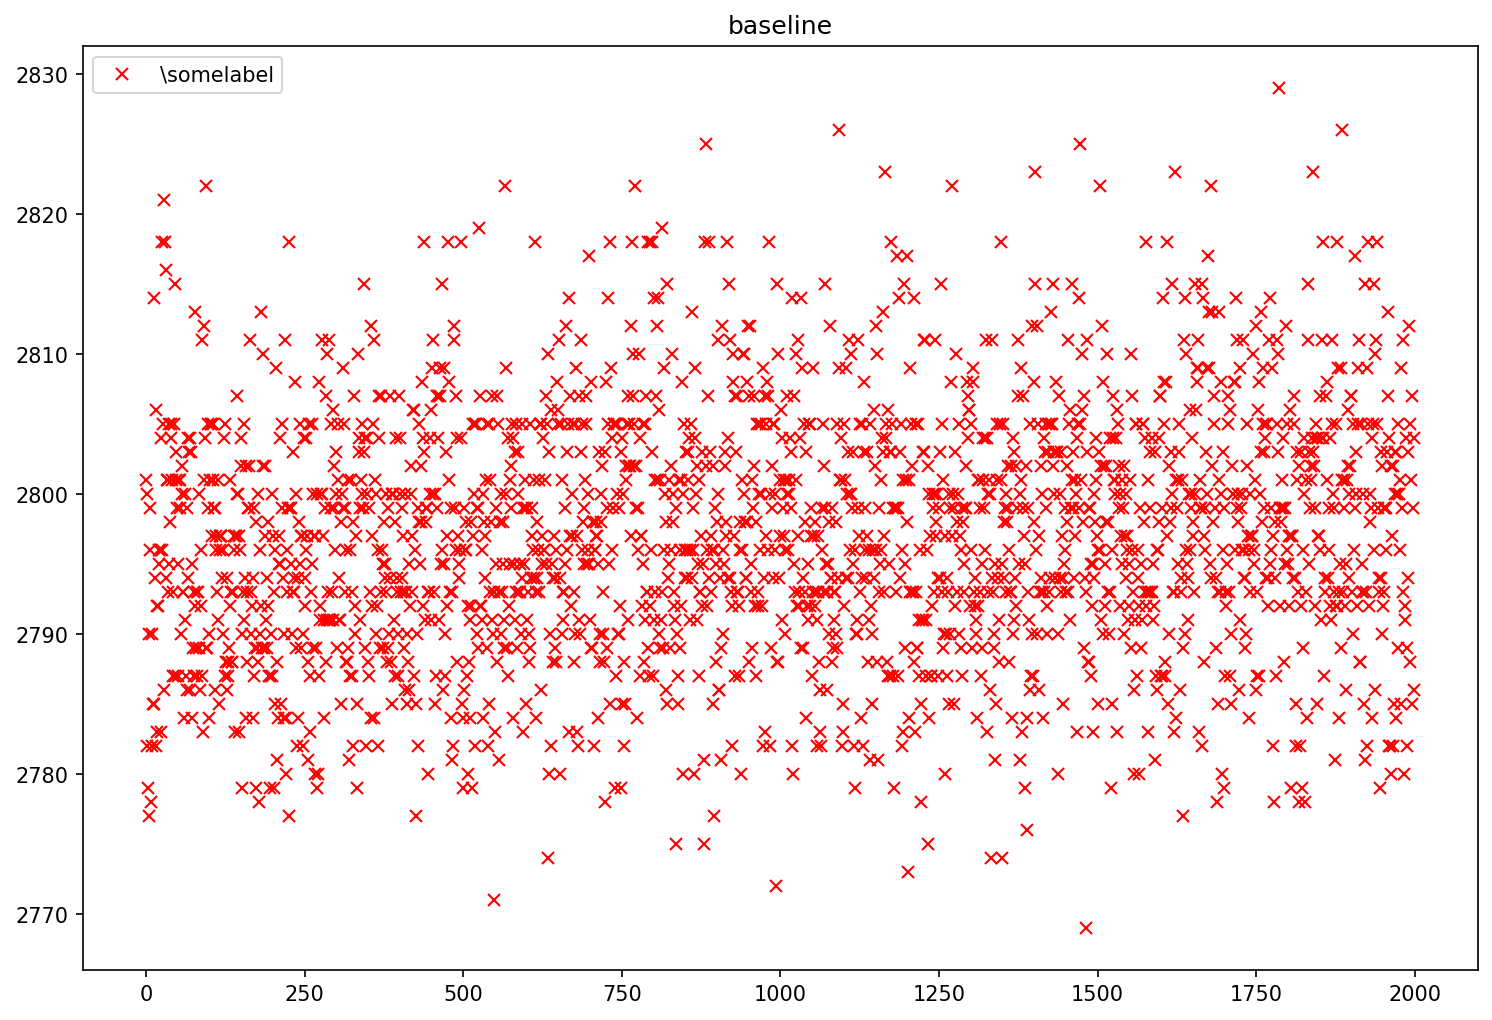

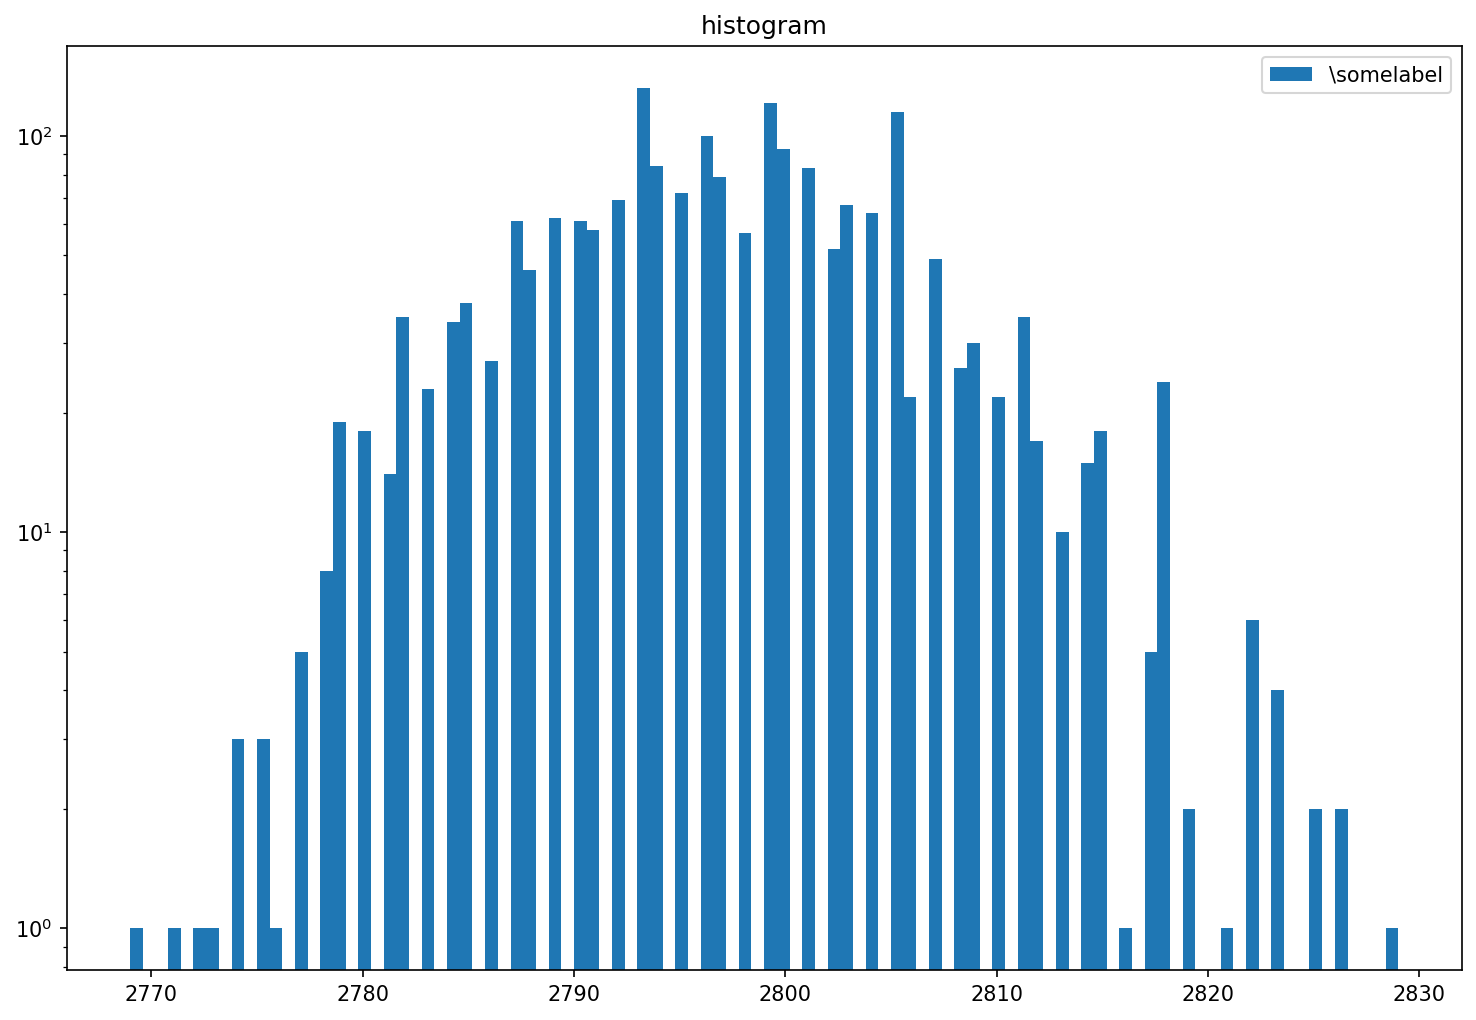

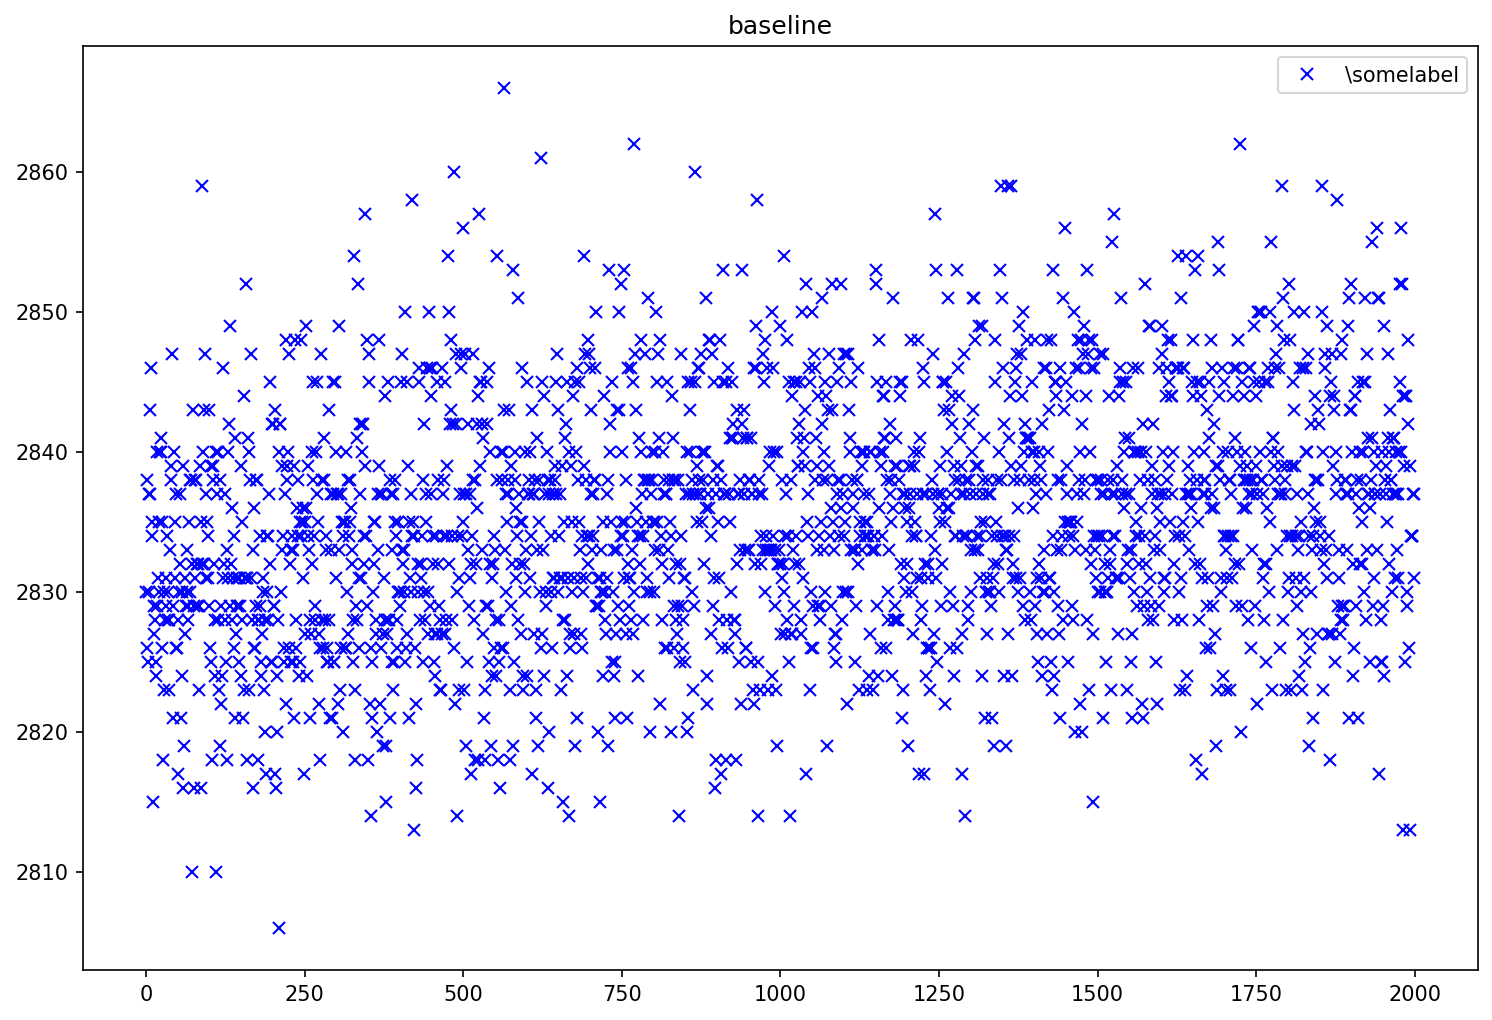

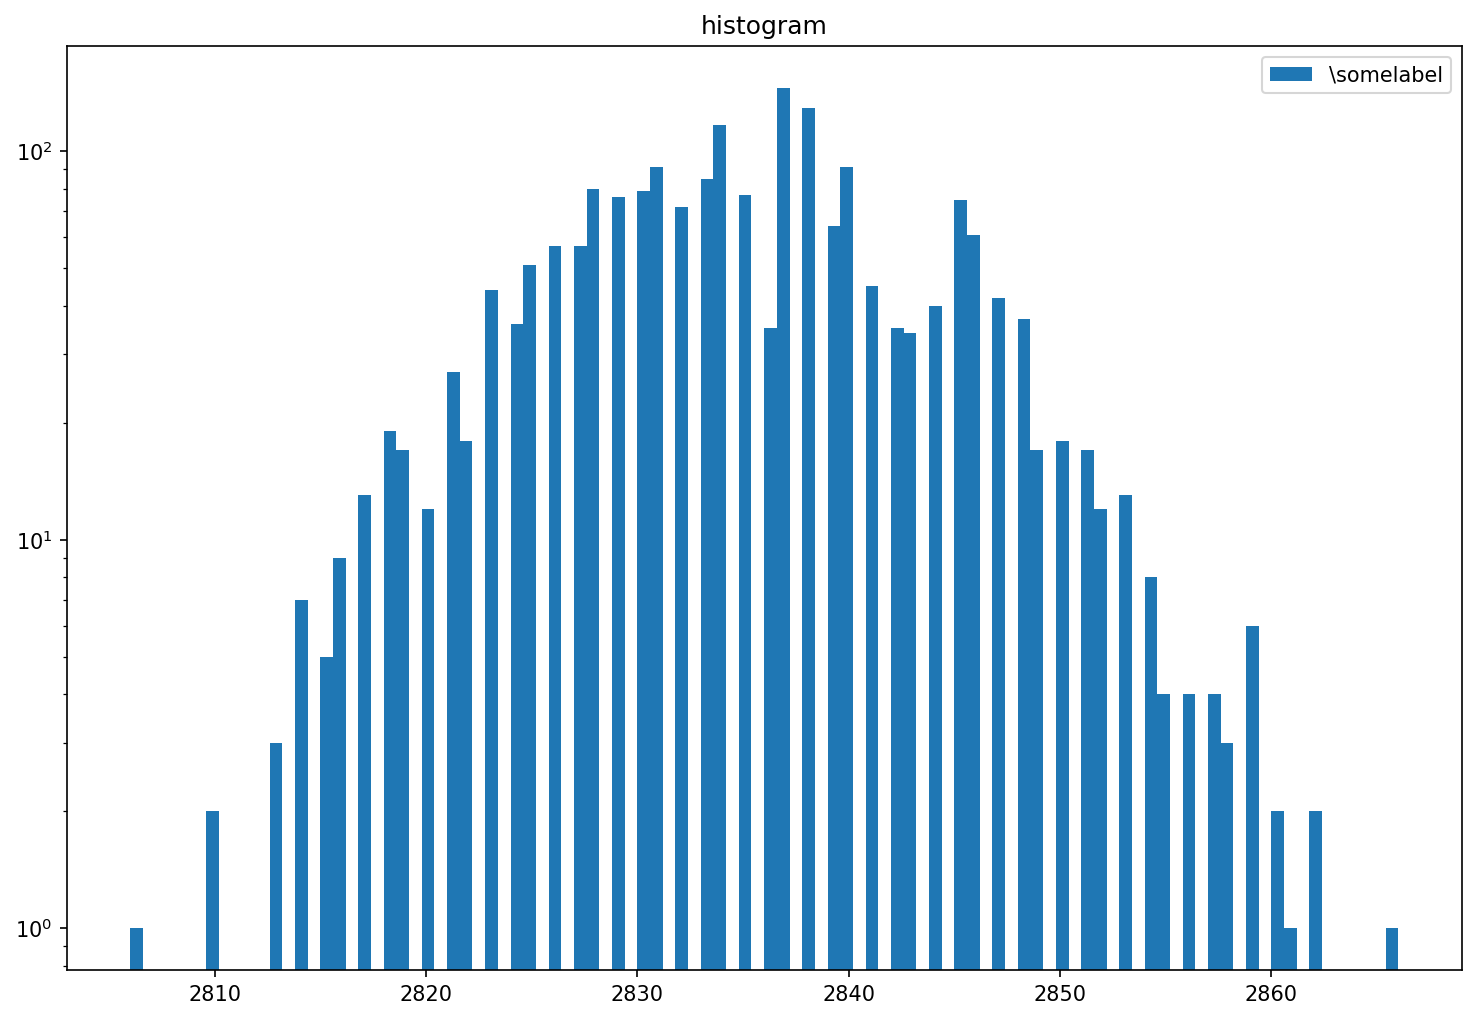

(145, 384)


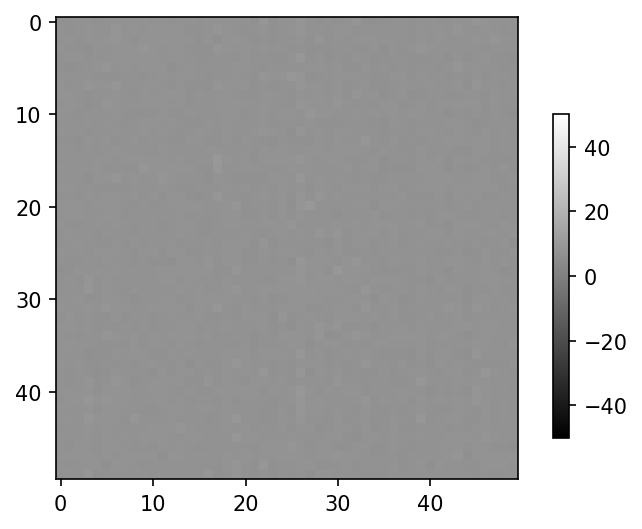

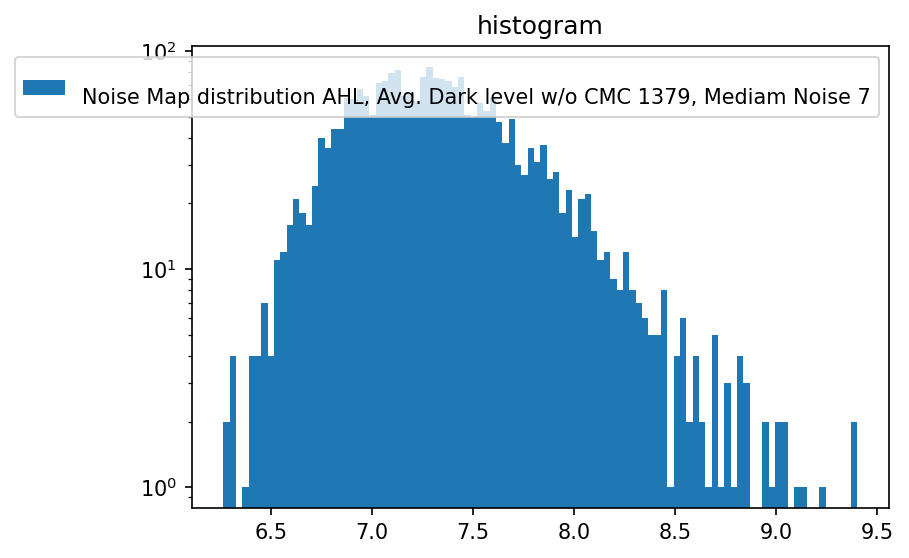


/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_5_Preamp_4_Vld1b_1_PixelCB_4_Filter_DAC_38_VRrefdac_36_DHg_0_RefGenB_1_RefGenC_2_run1.dat
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)


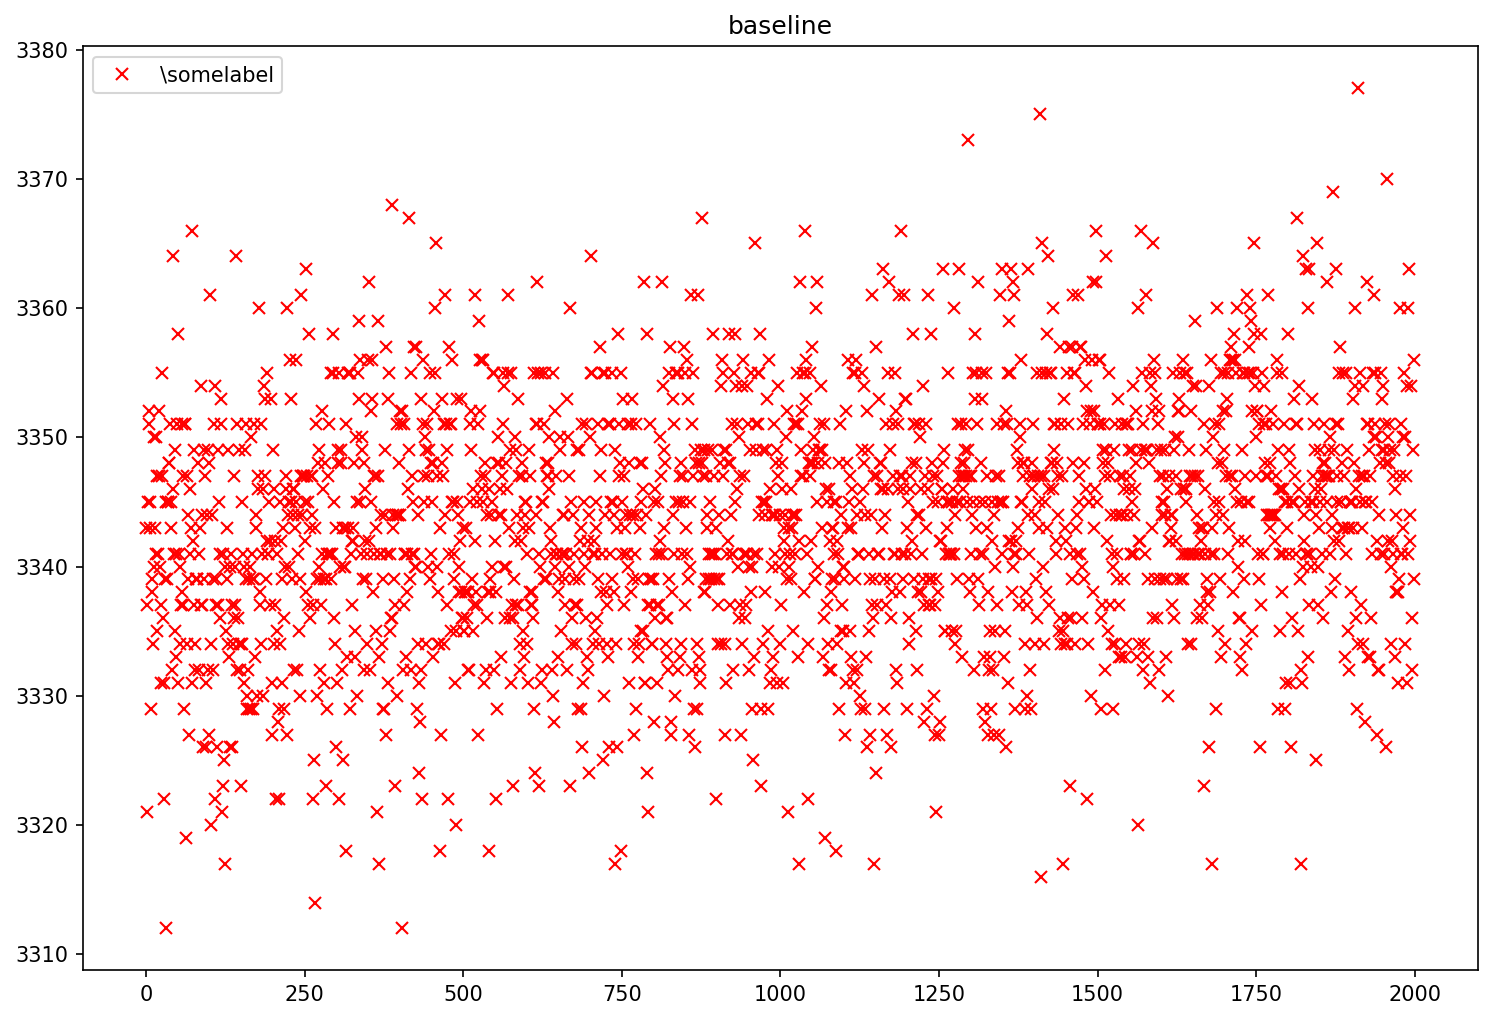

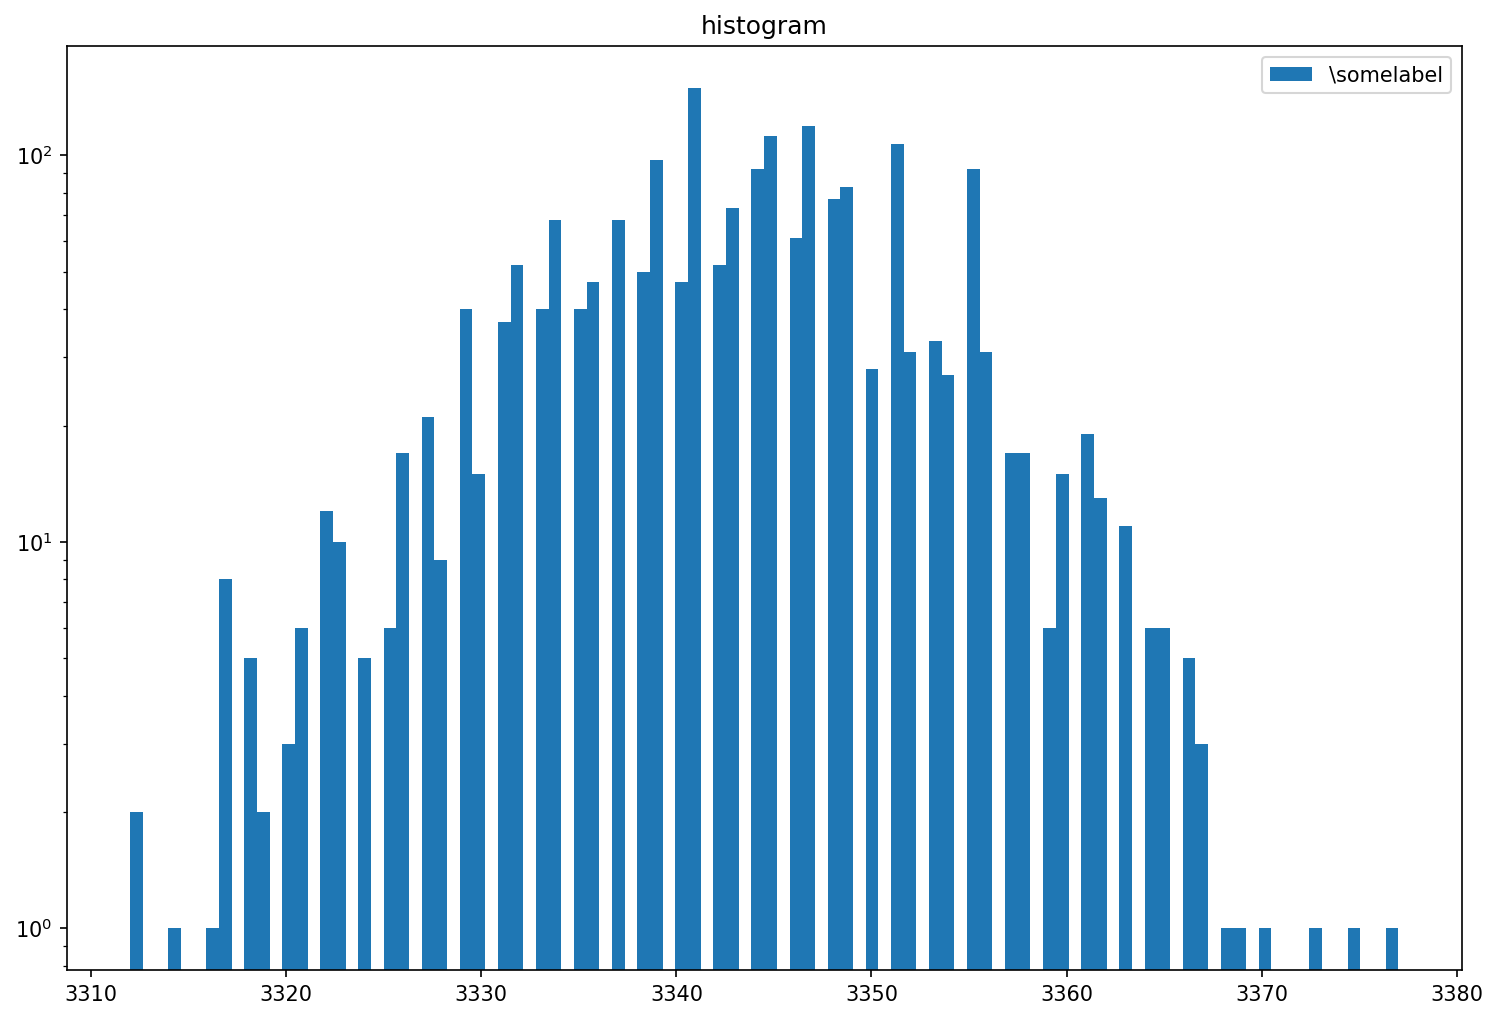

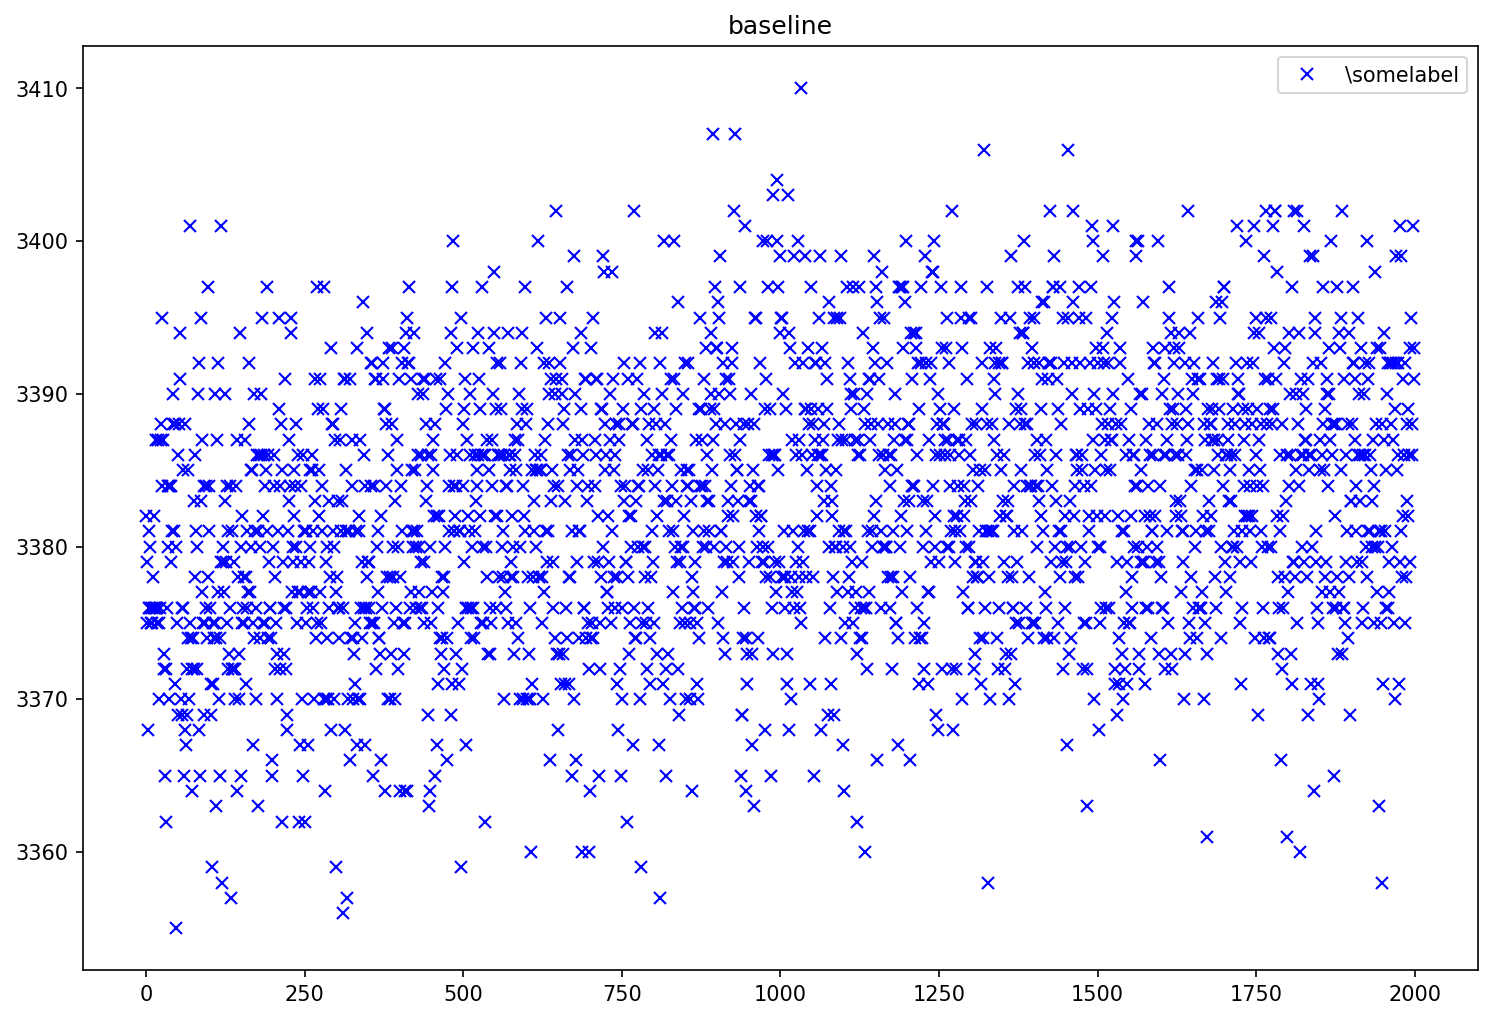

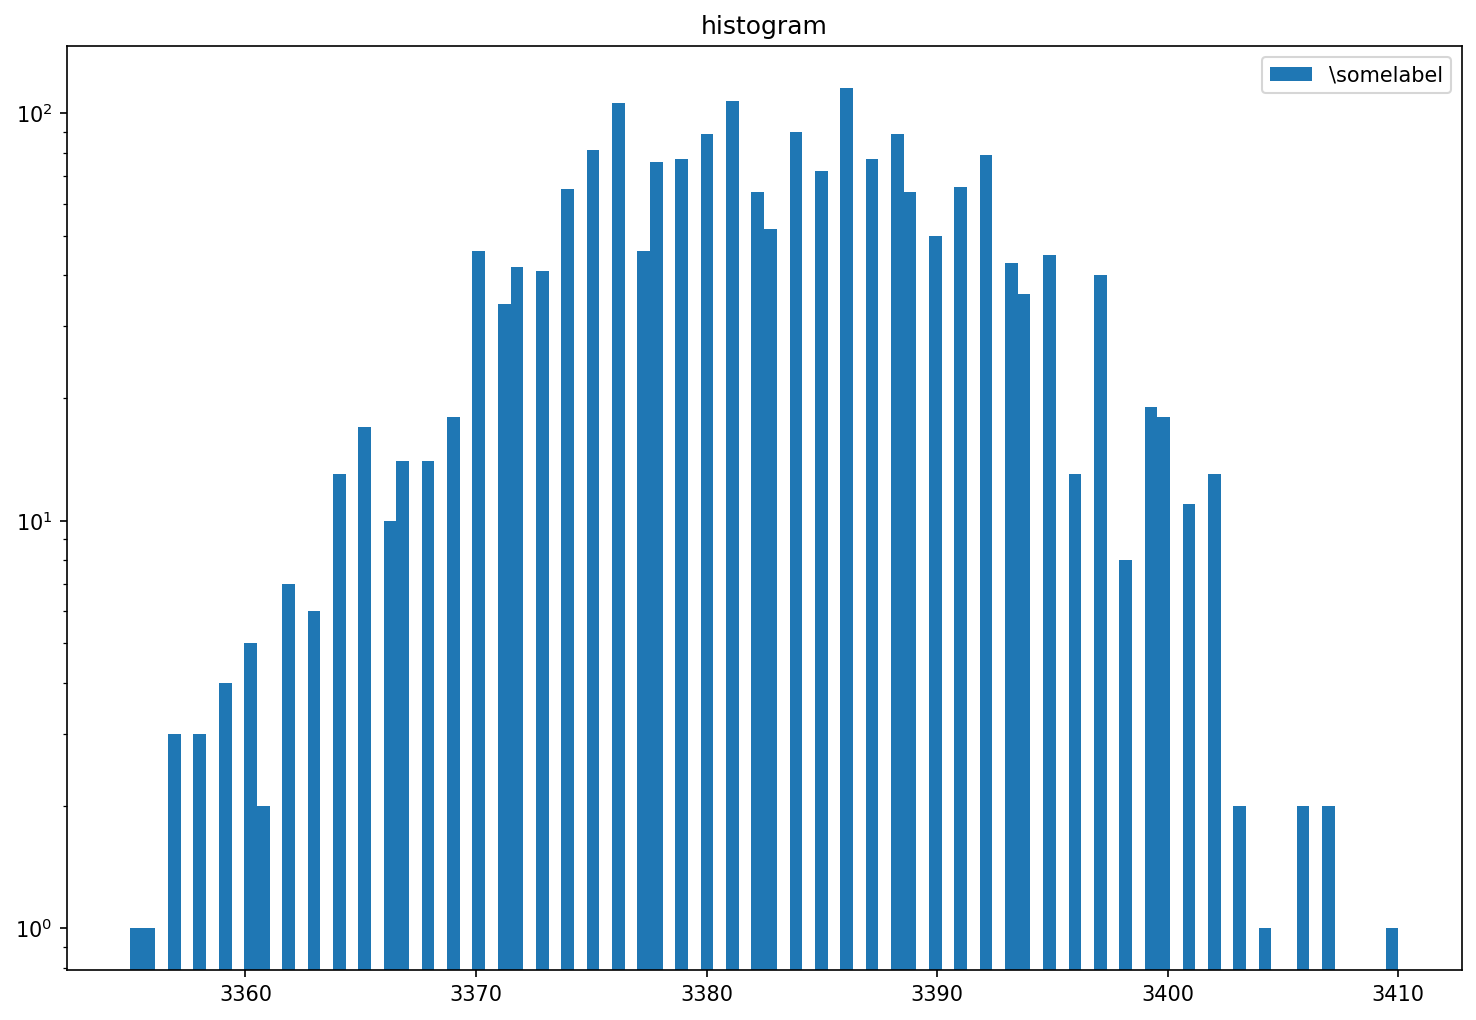

(145, 384)


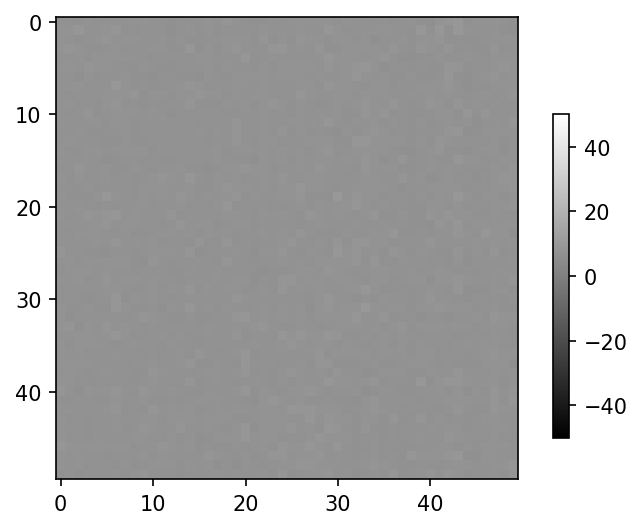

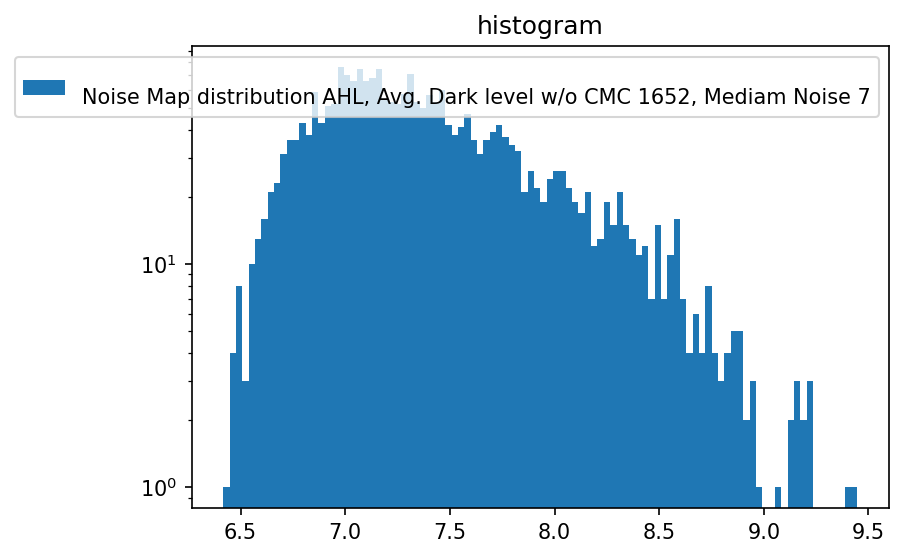


/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_5_Preamp_4_Vld1b_1_PixelCB_4_Filter_DAC_38_VRrefdac_40_DHg_0_RefGenB_1_RefGenC_2_run1.dat
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)


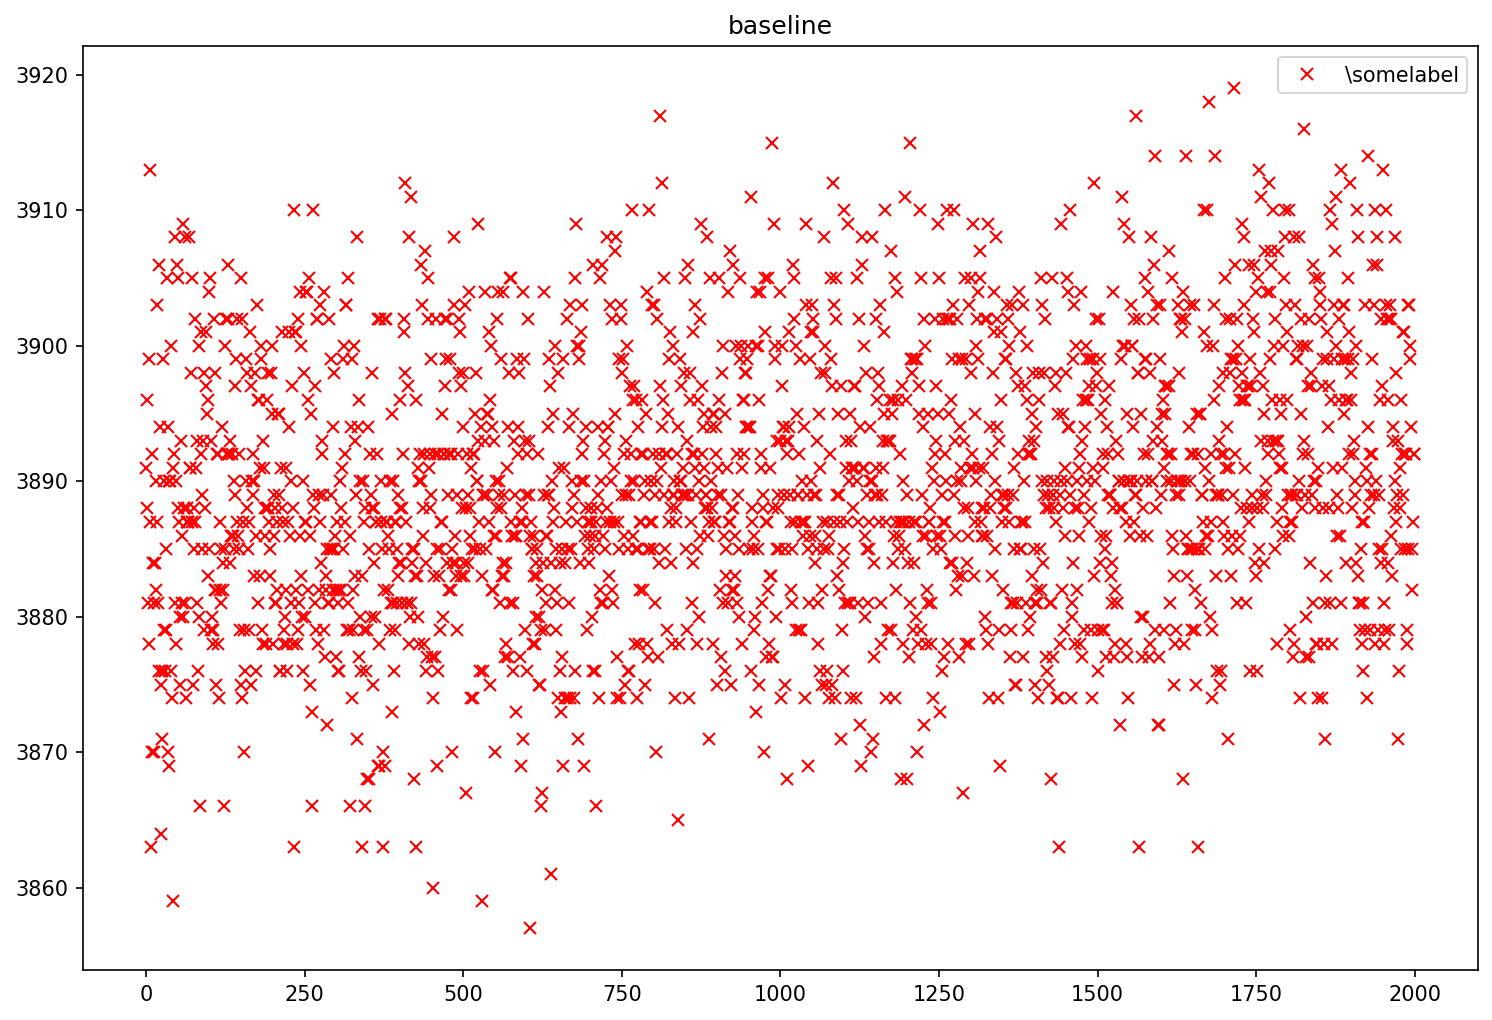

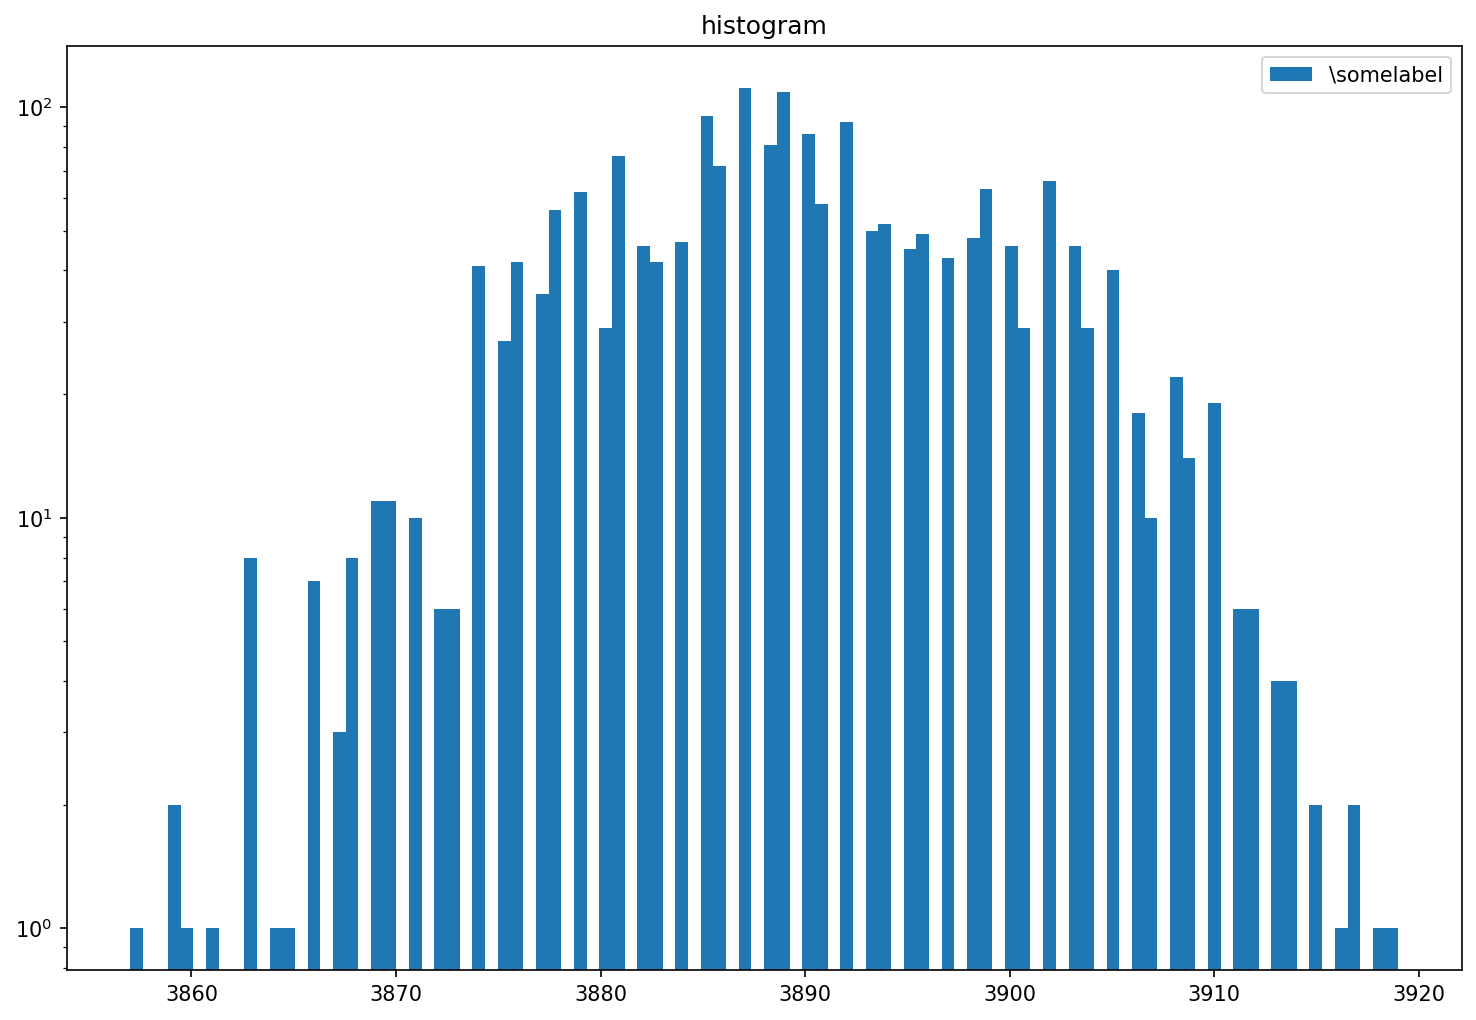

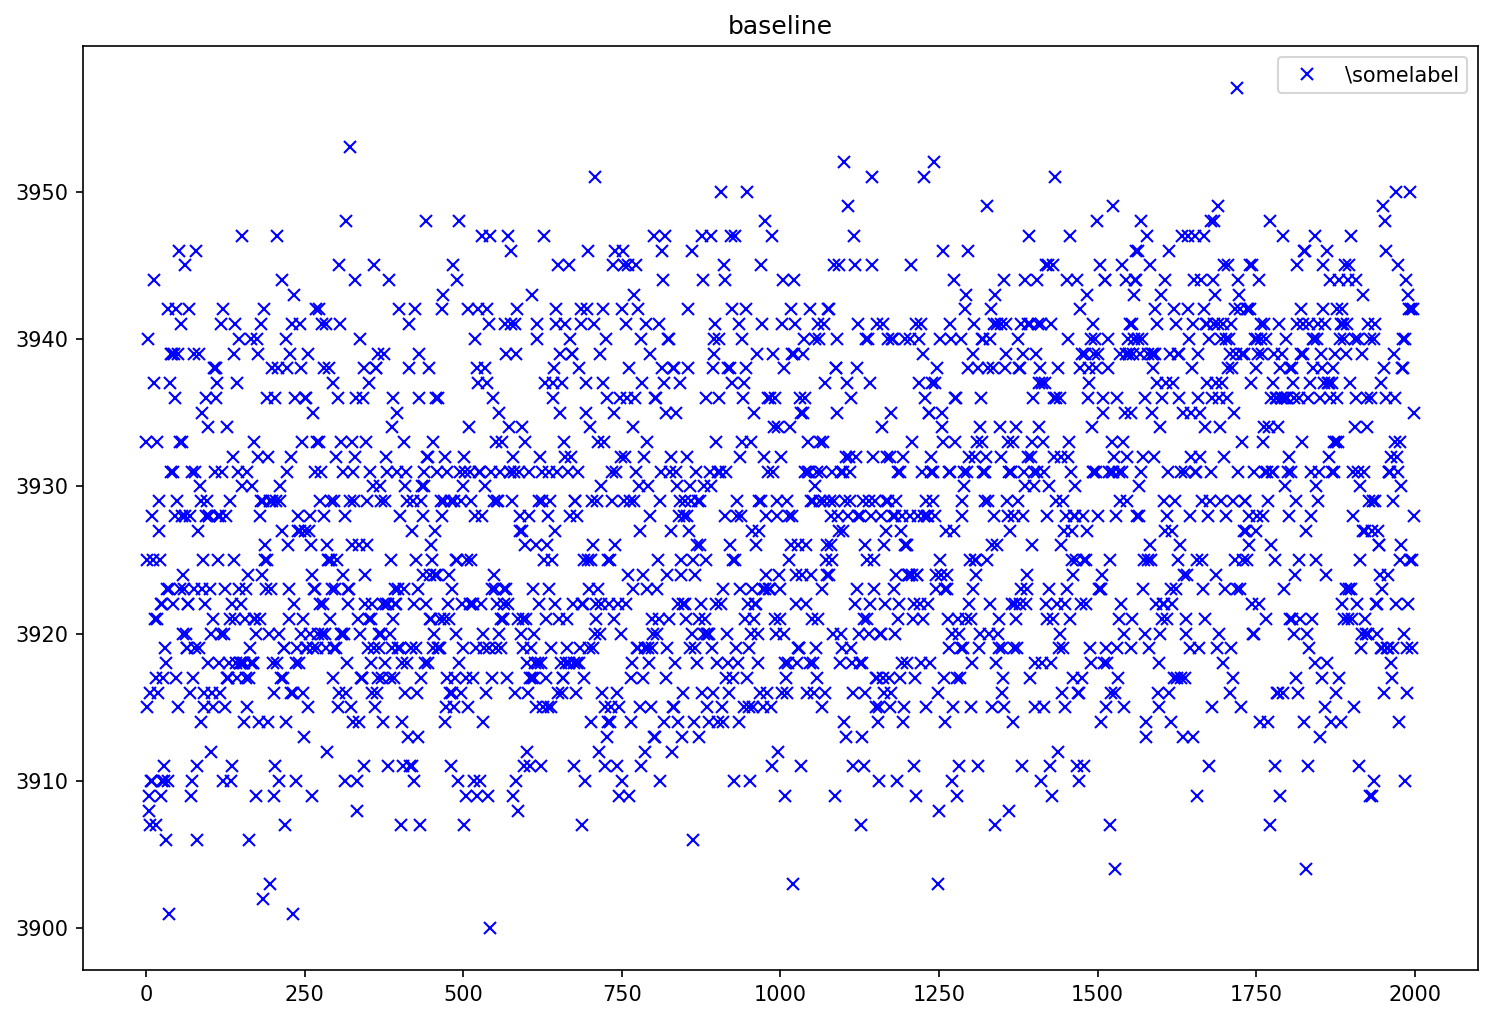

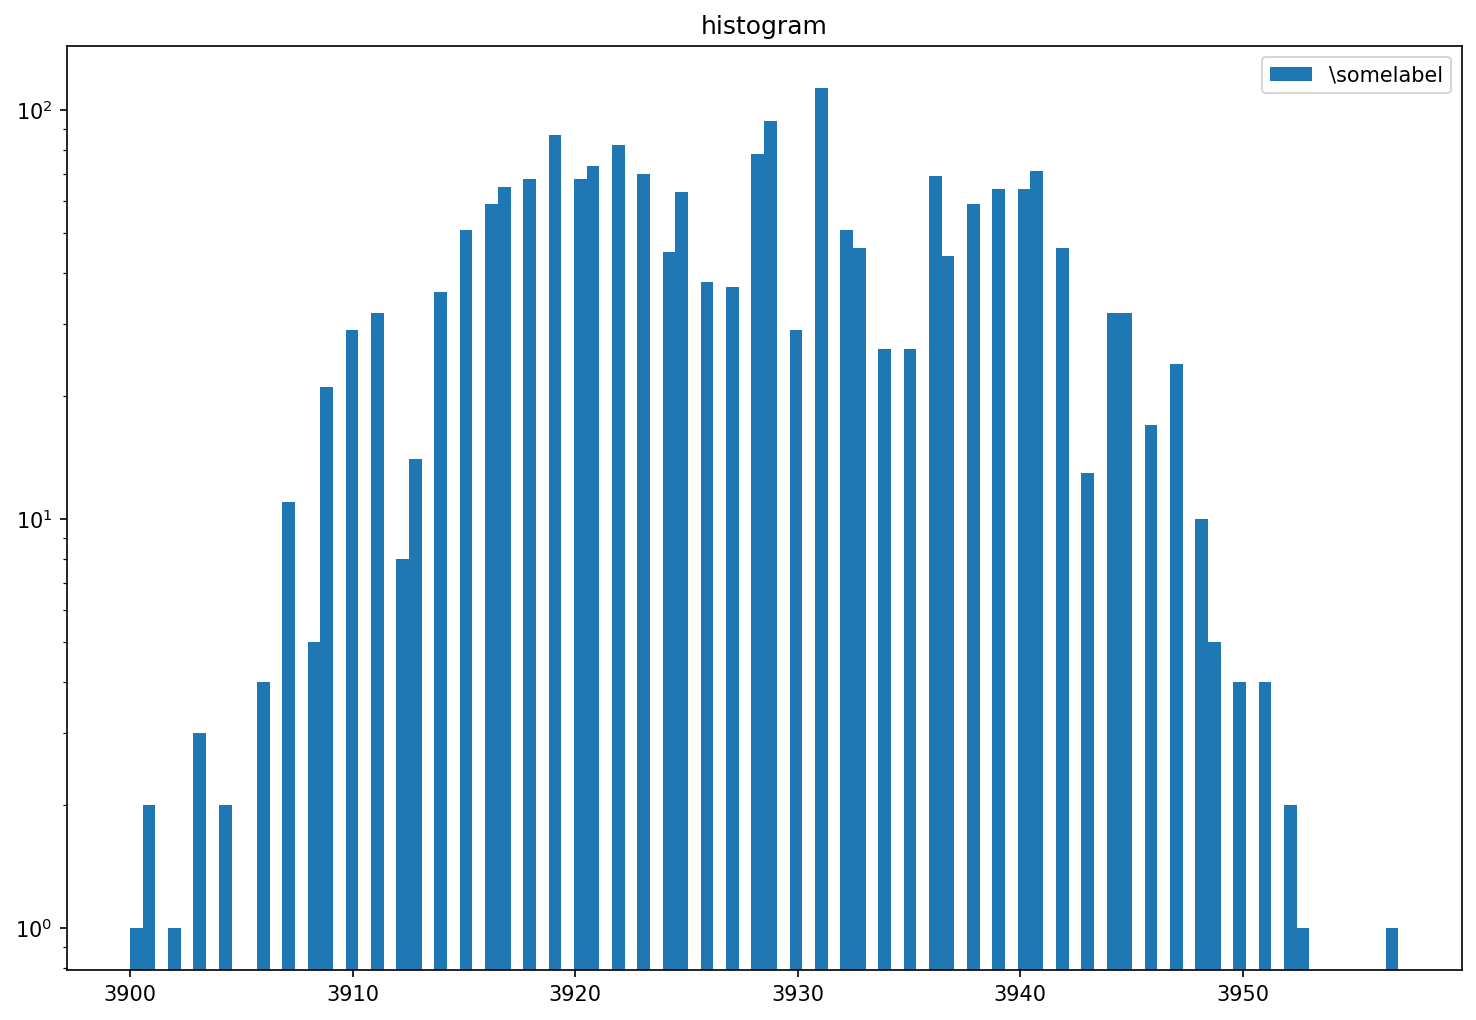

(145, 384)


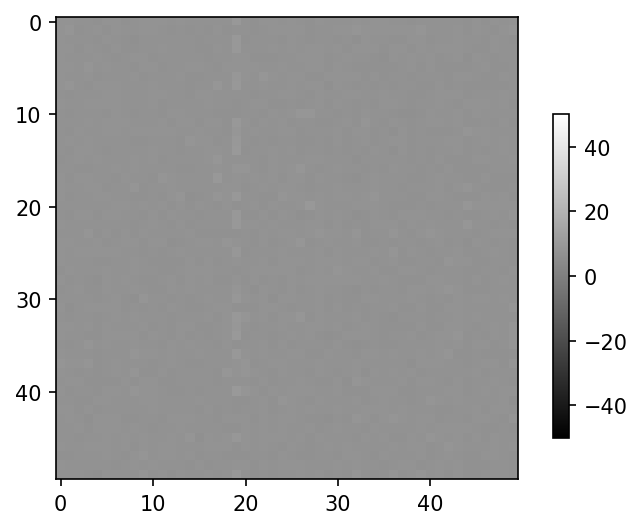

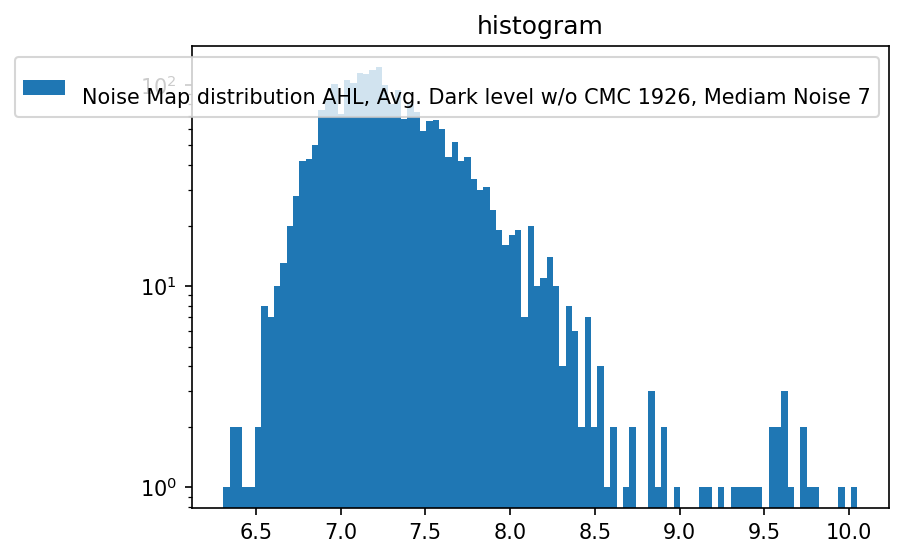


/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_5_Preamp_4_Vld1b_1_PixelCB_4_Filter_DAC_38_VRrefdac_44_DHg_0_RefGenB_1_RefGenC_2_run1.dat
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)


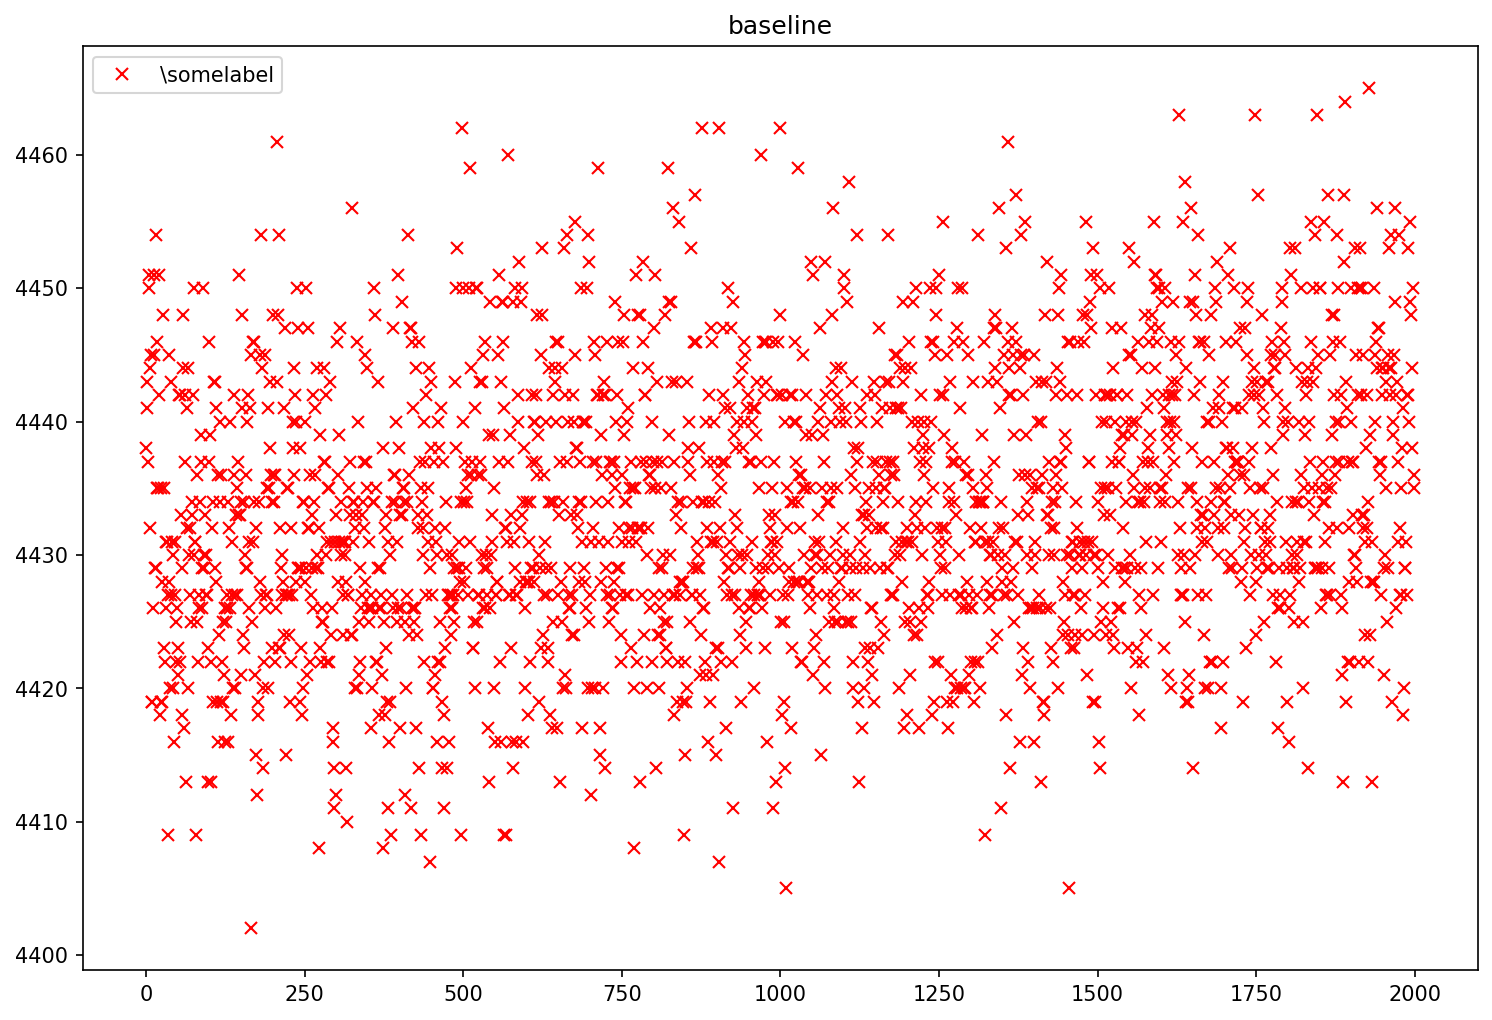

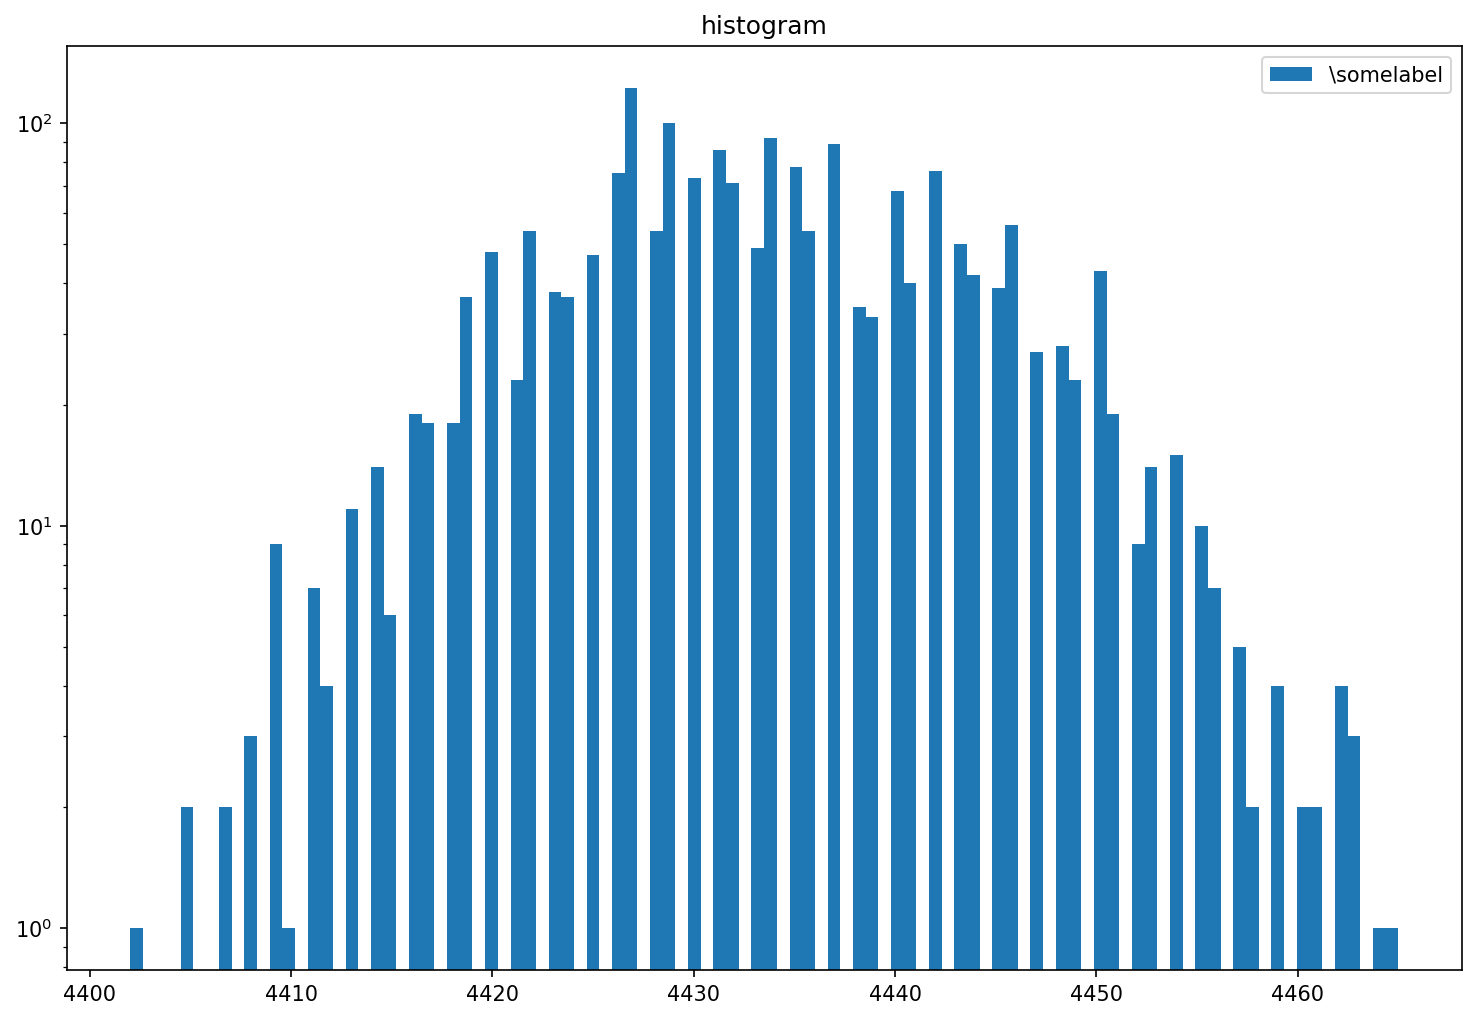

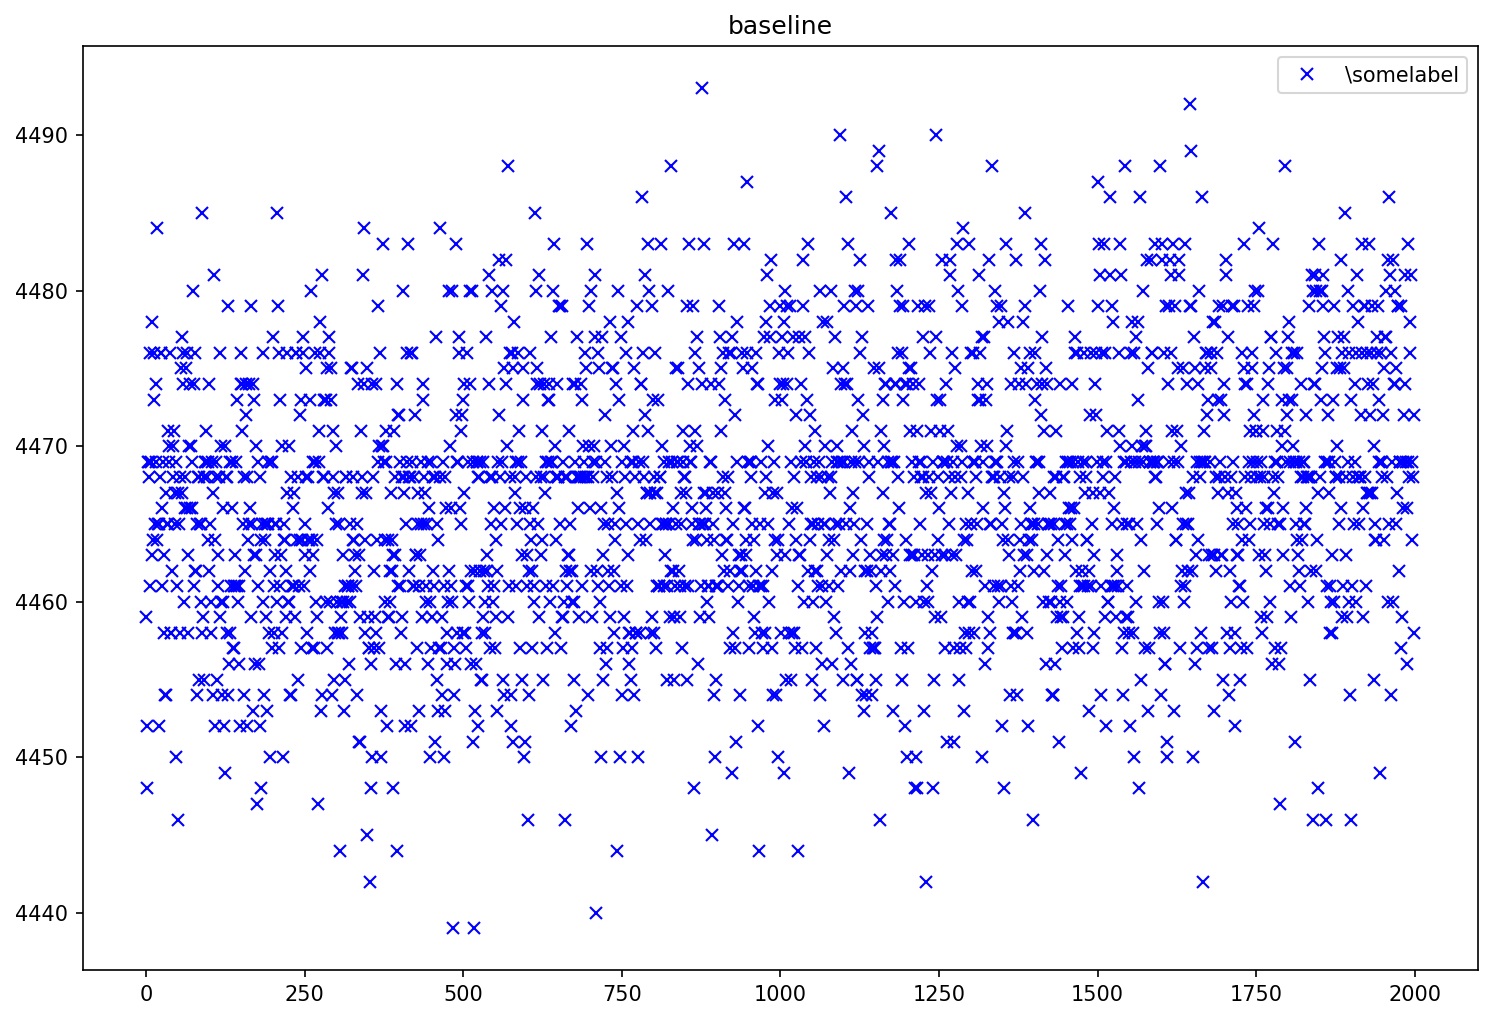

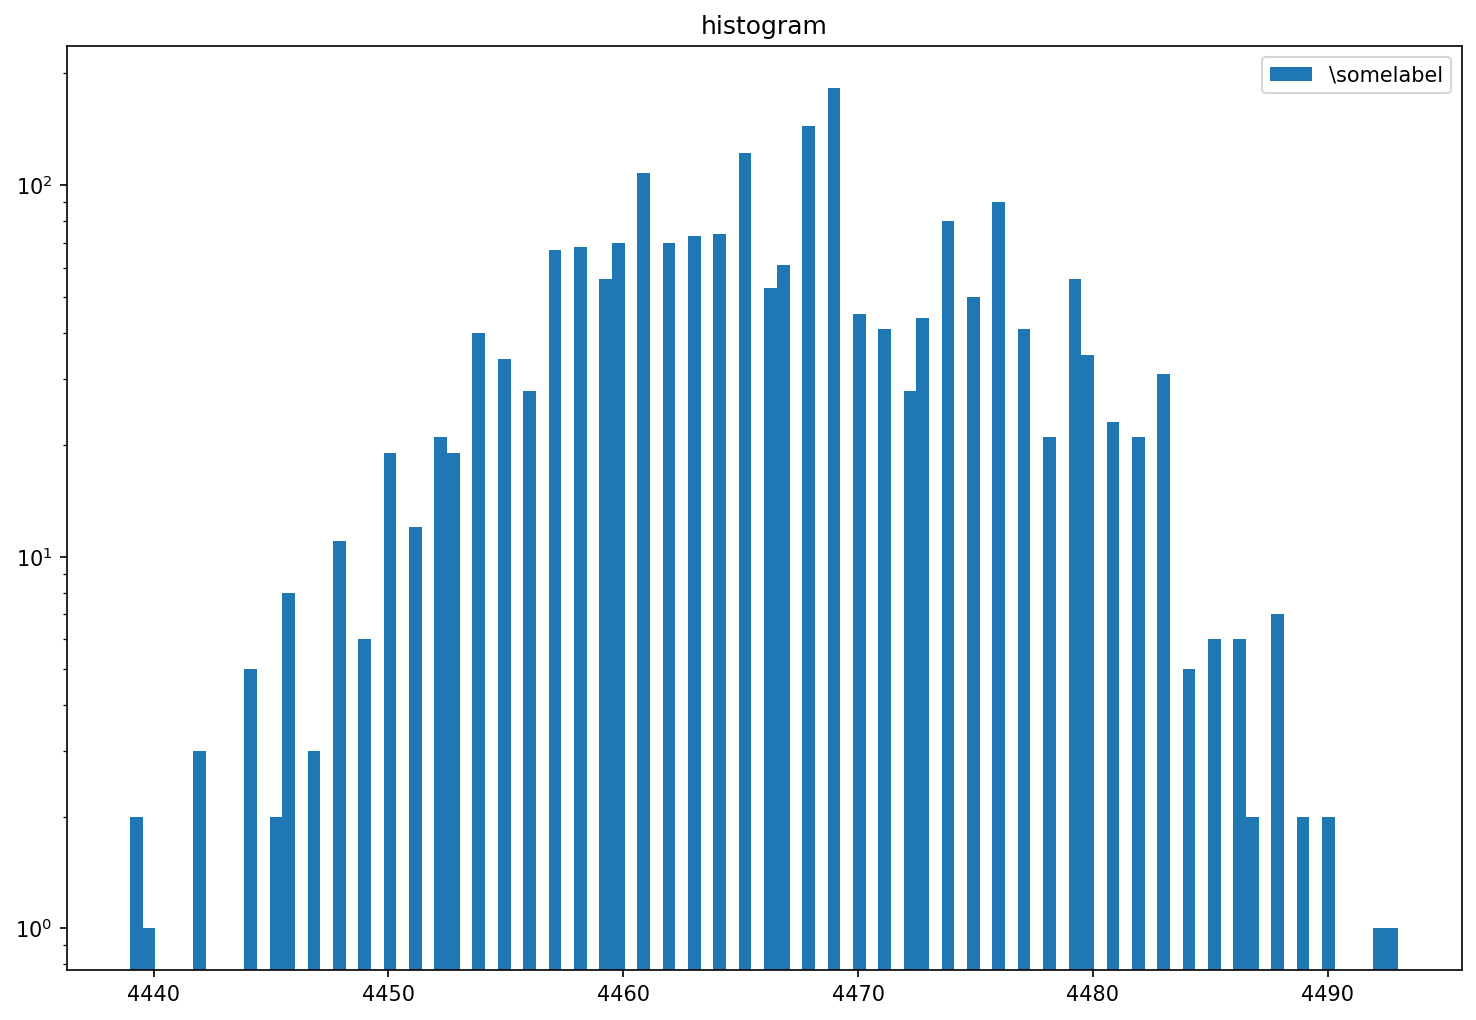

(145, 384)


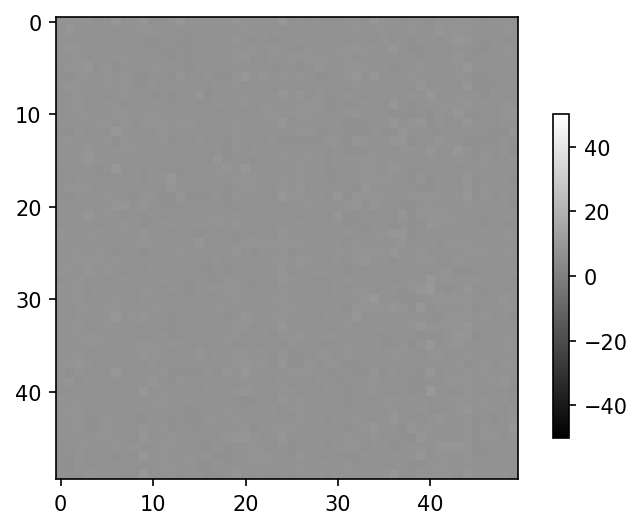

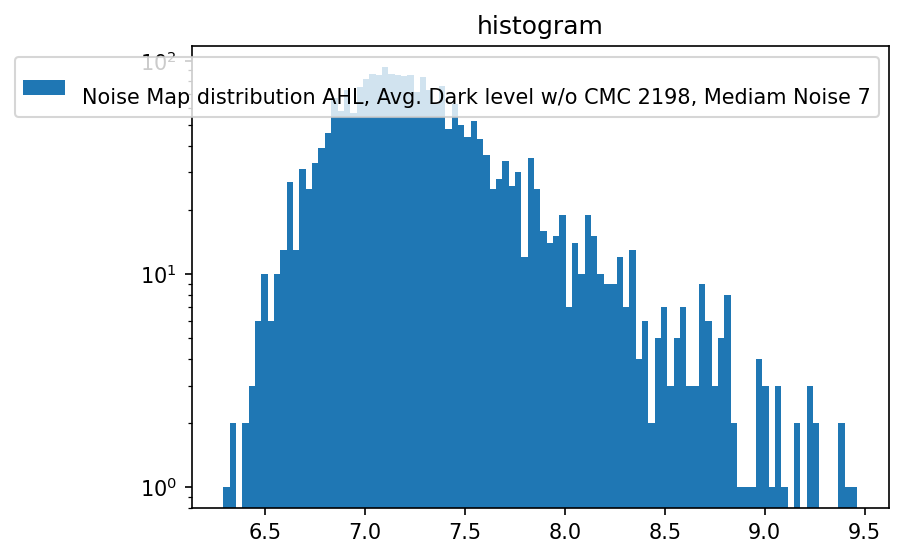


/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_5_Preamp_4_Vld1b_1_PixelCB_4_Filter_DAC_38_VRrefdac_48_DHg_0_RefGenB_1_RefGenC_2_run1.dat
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)


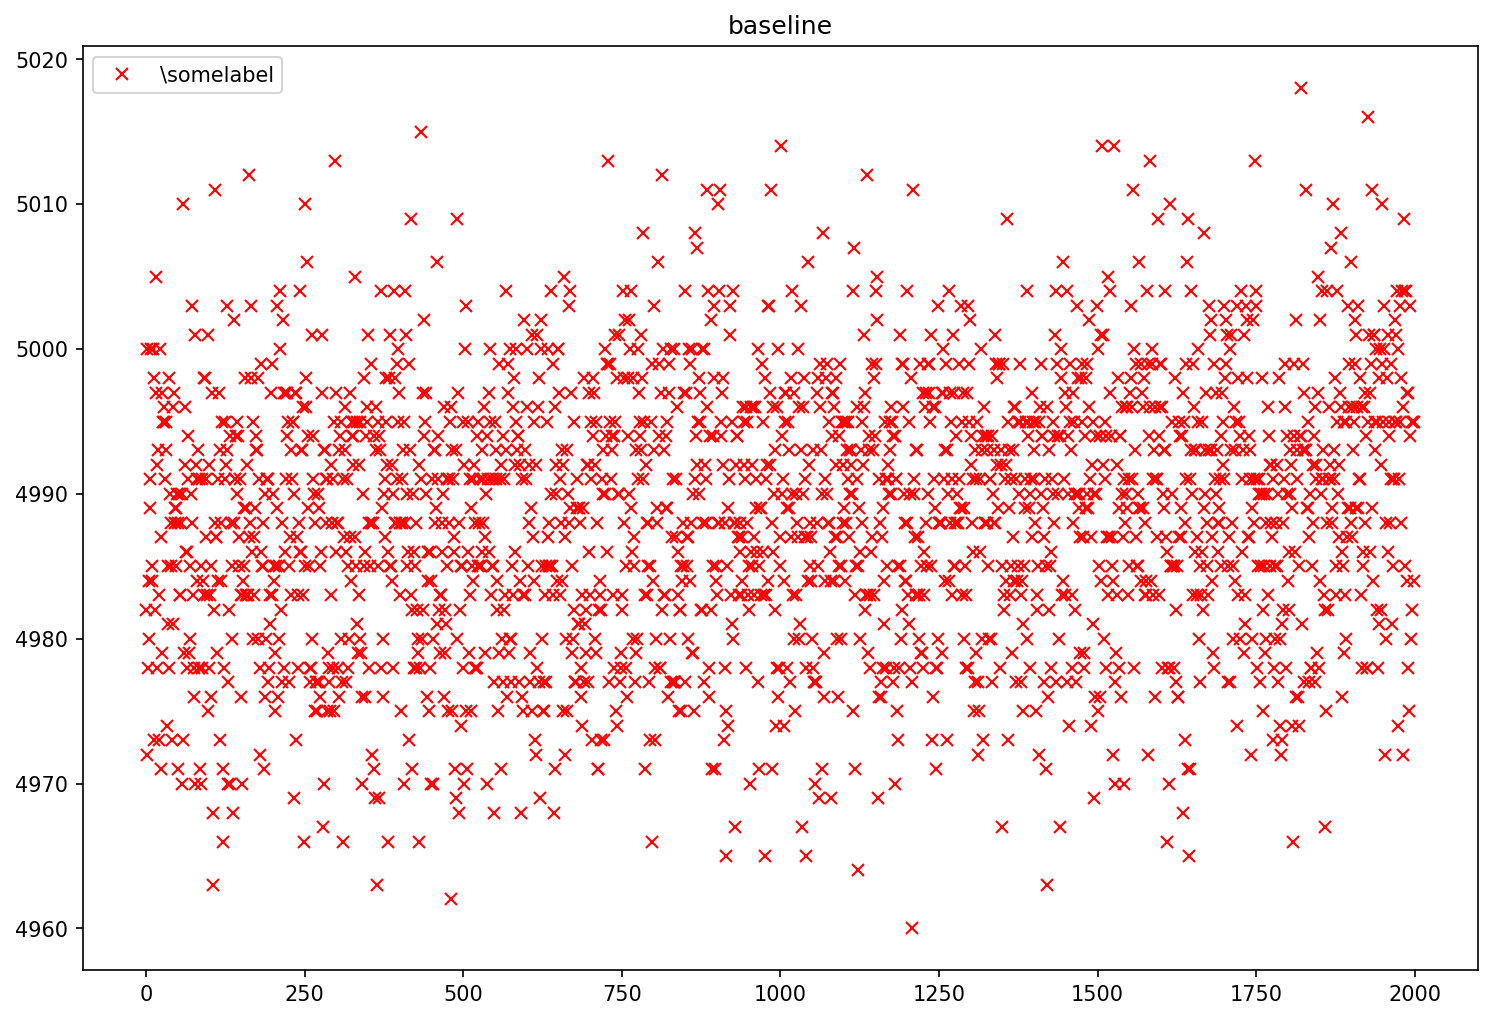

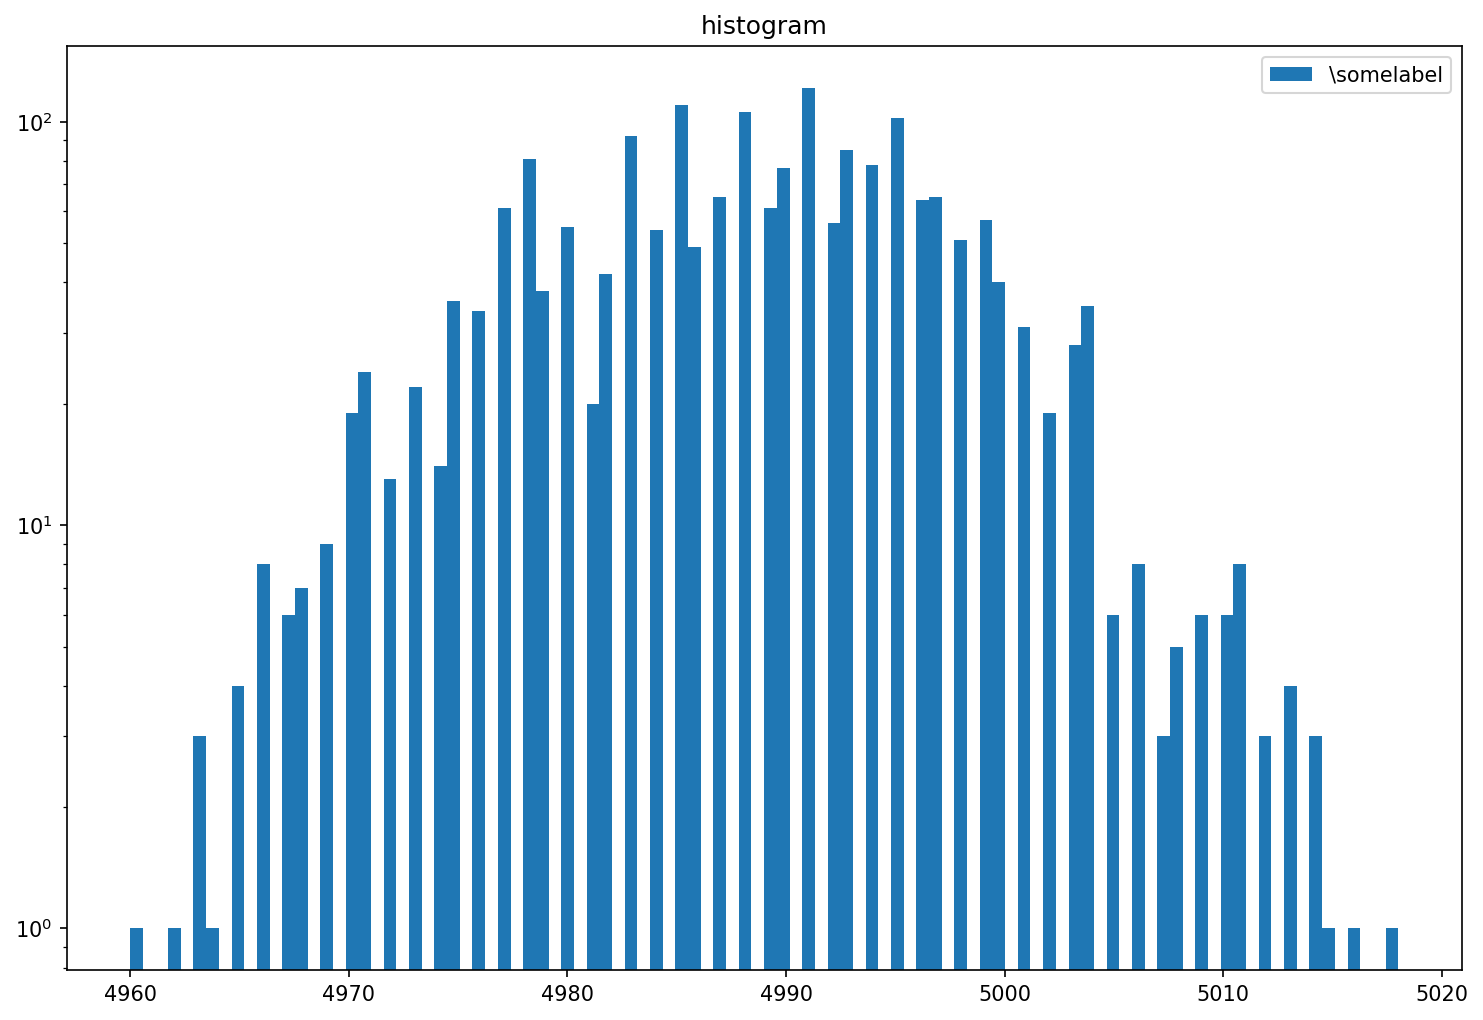

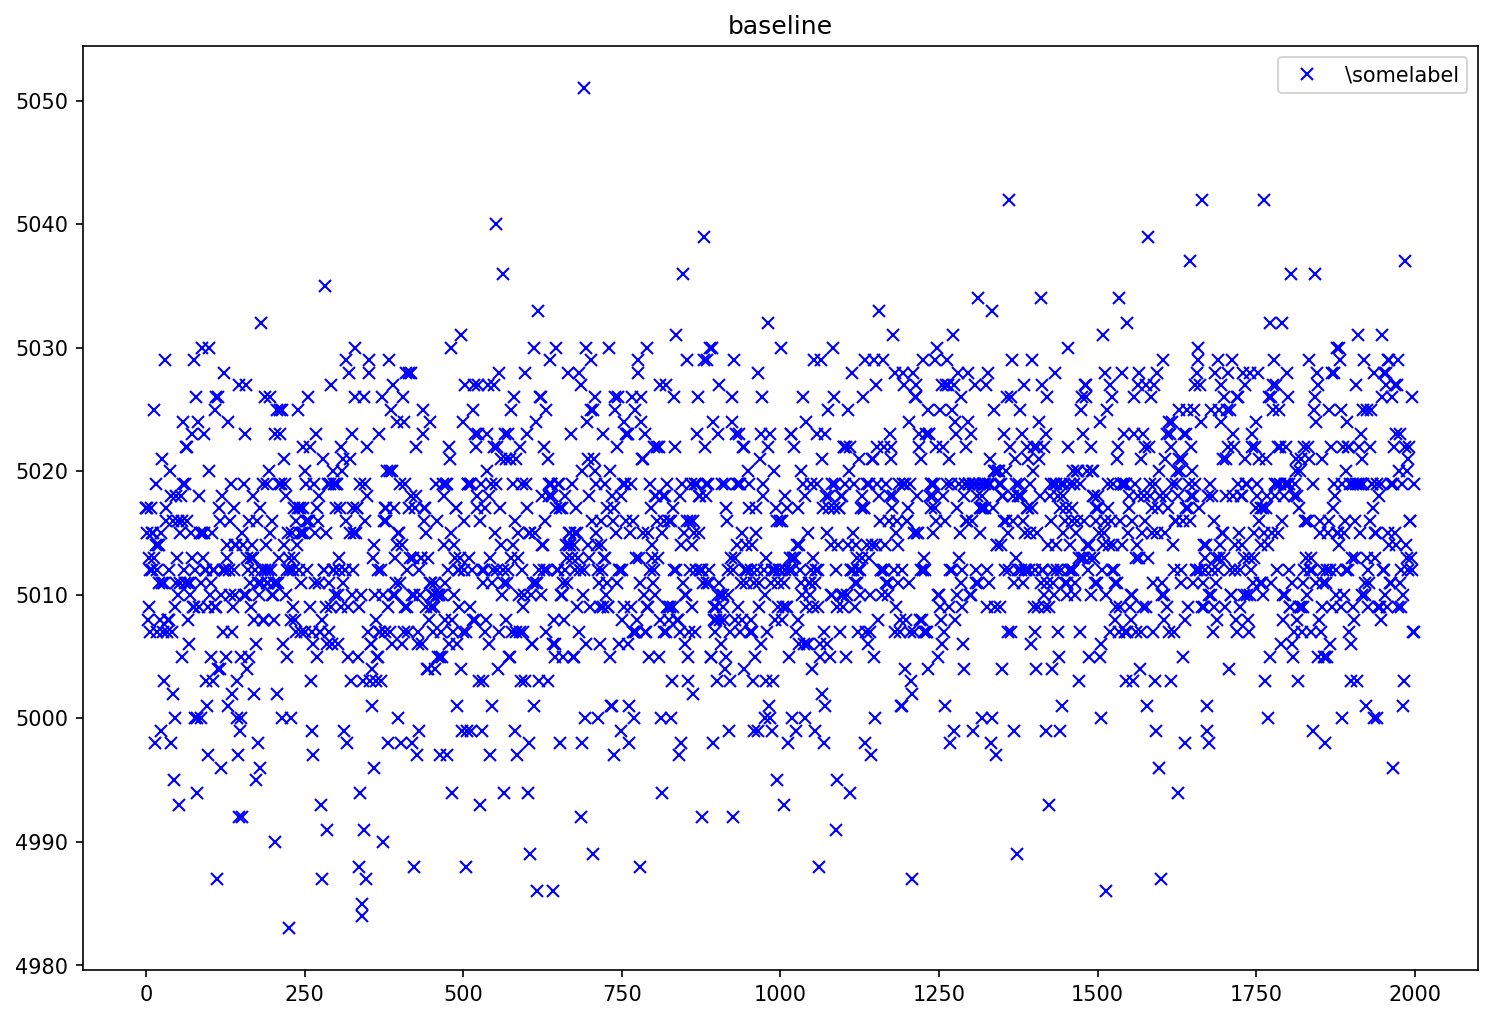

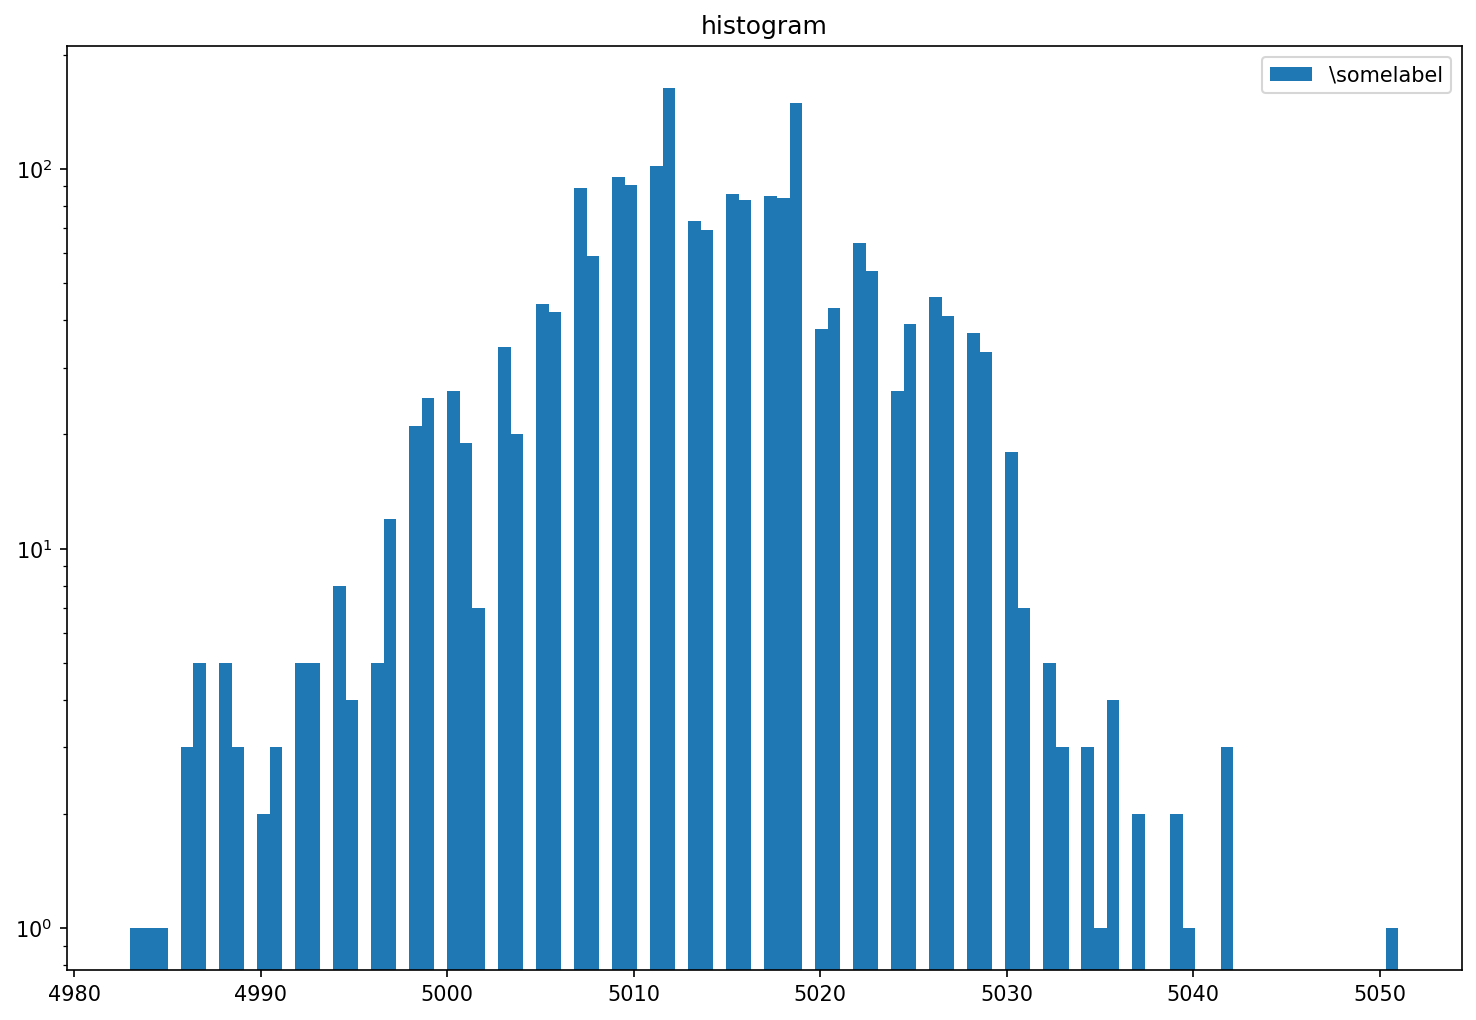

(145, 384)


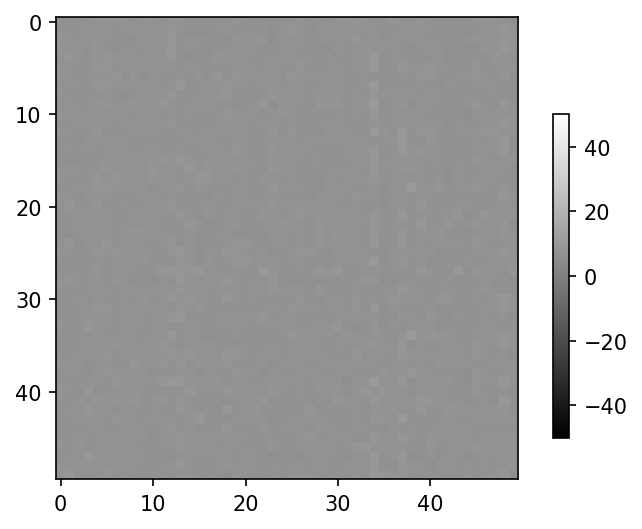

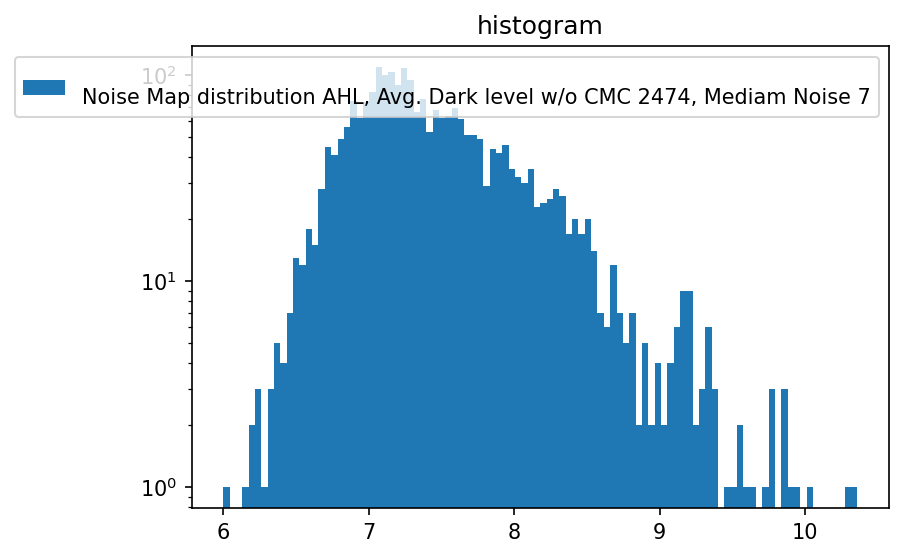


/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_5_Preamp_4_Vld1b_1_PixelCB_4_Filter_DAC_38_VRrefdac_52_DHg_0_RefGenB_1_RefGenC_2_run1.dat
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)


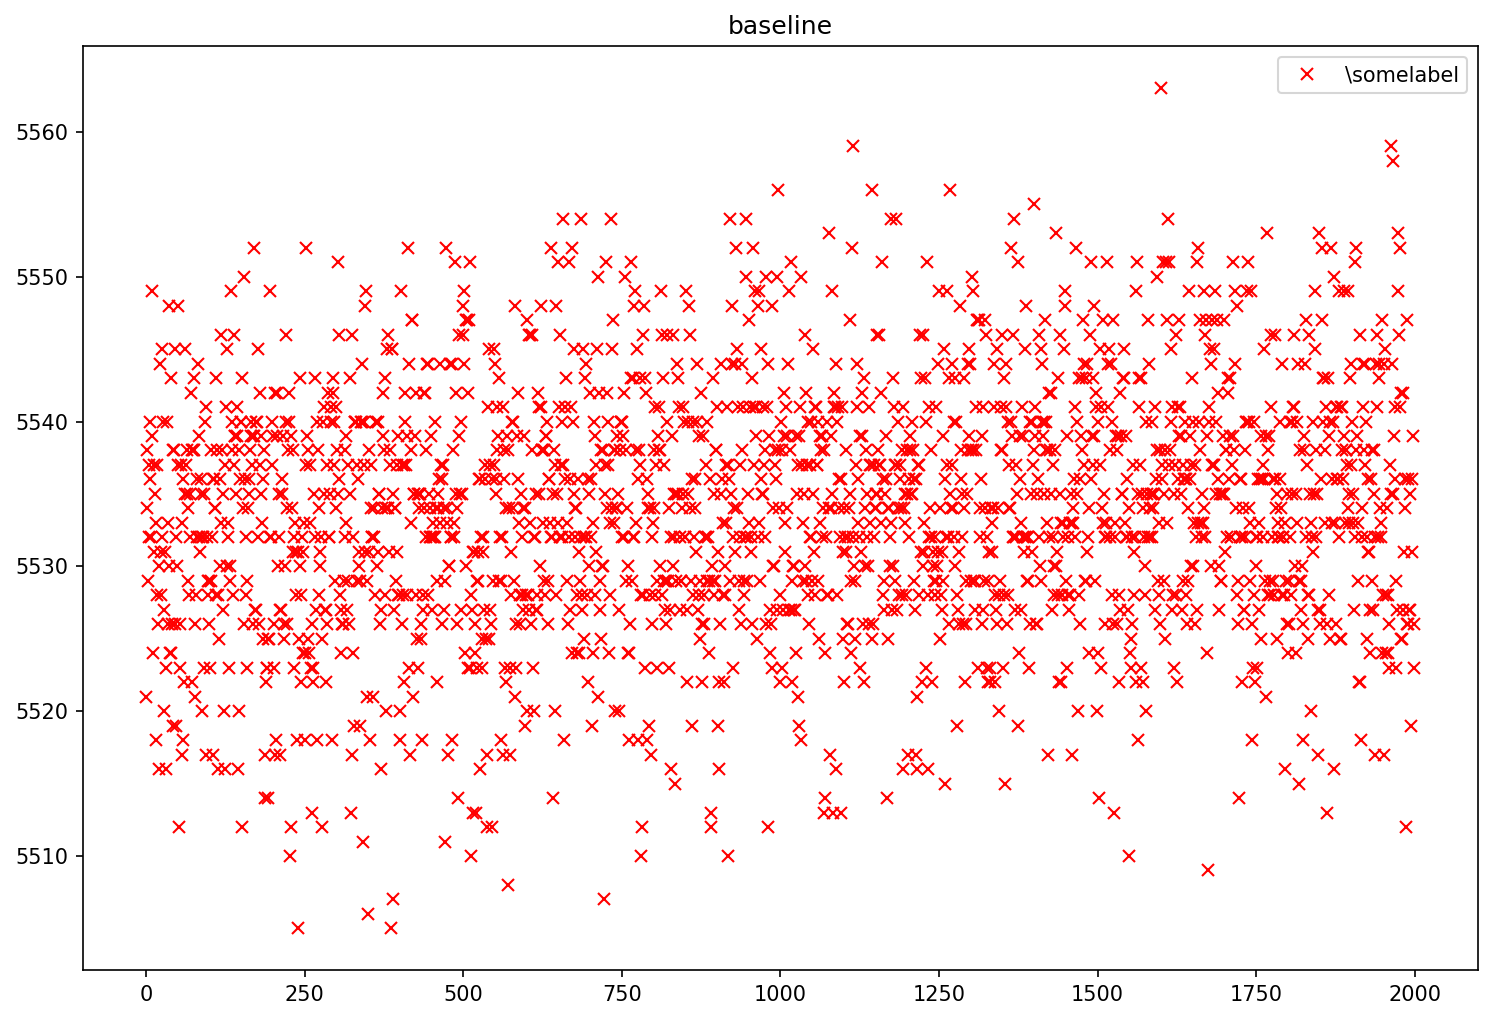

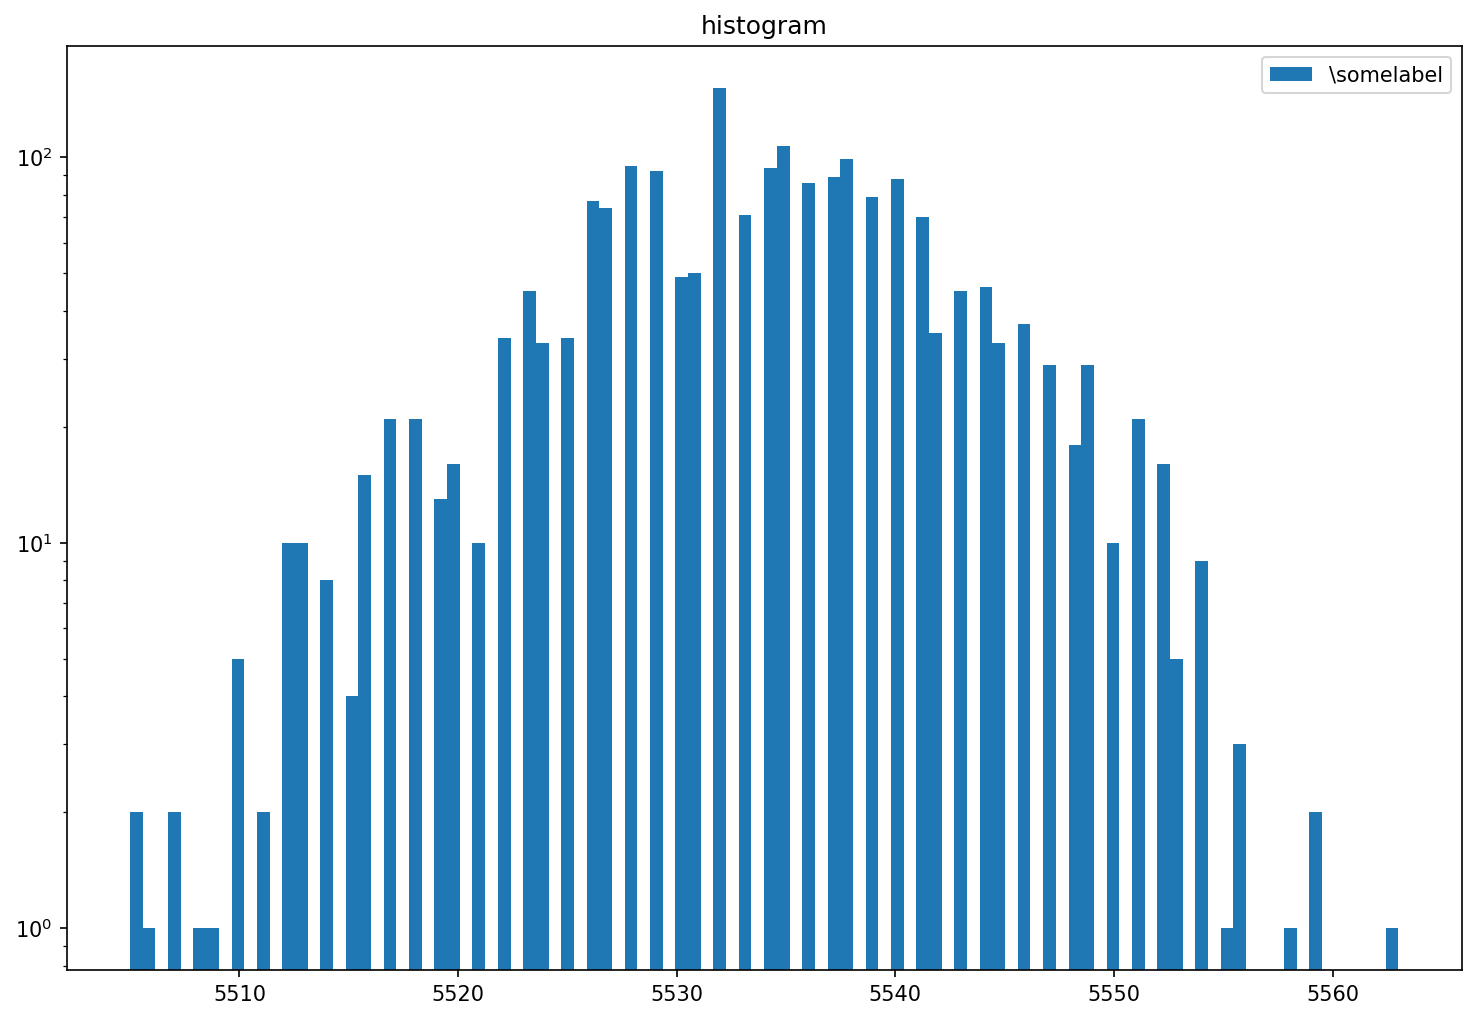

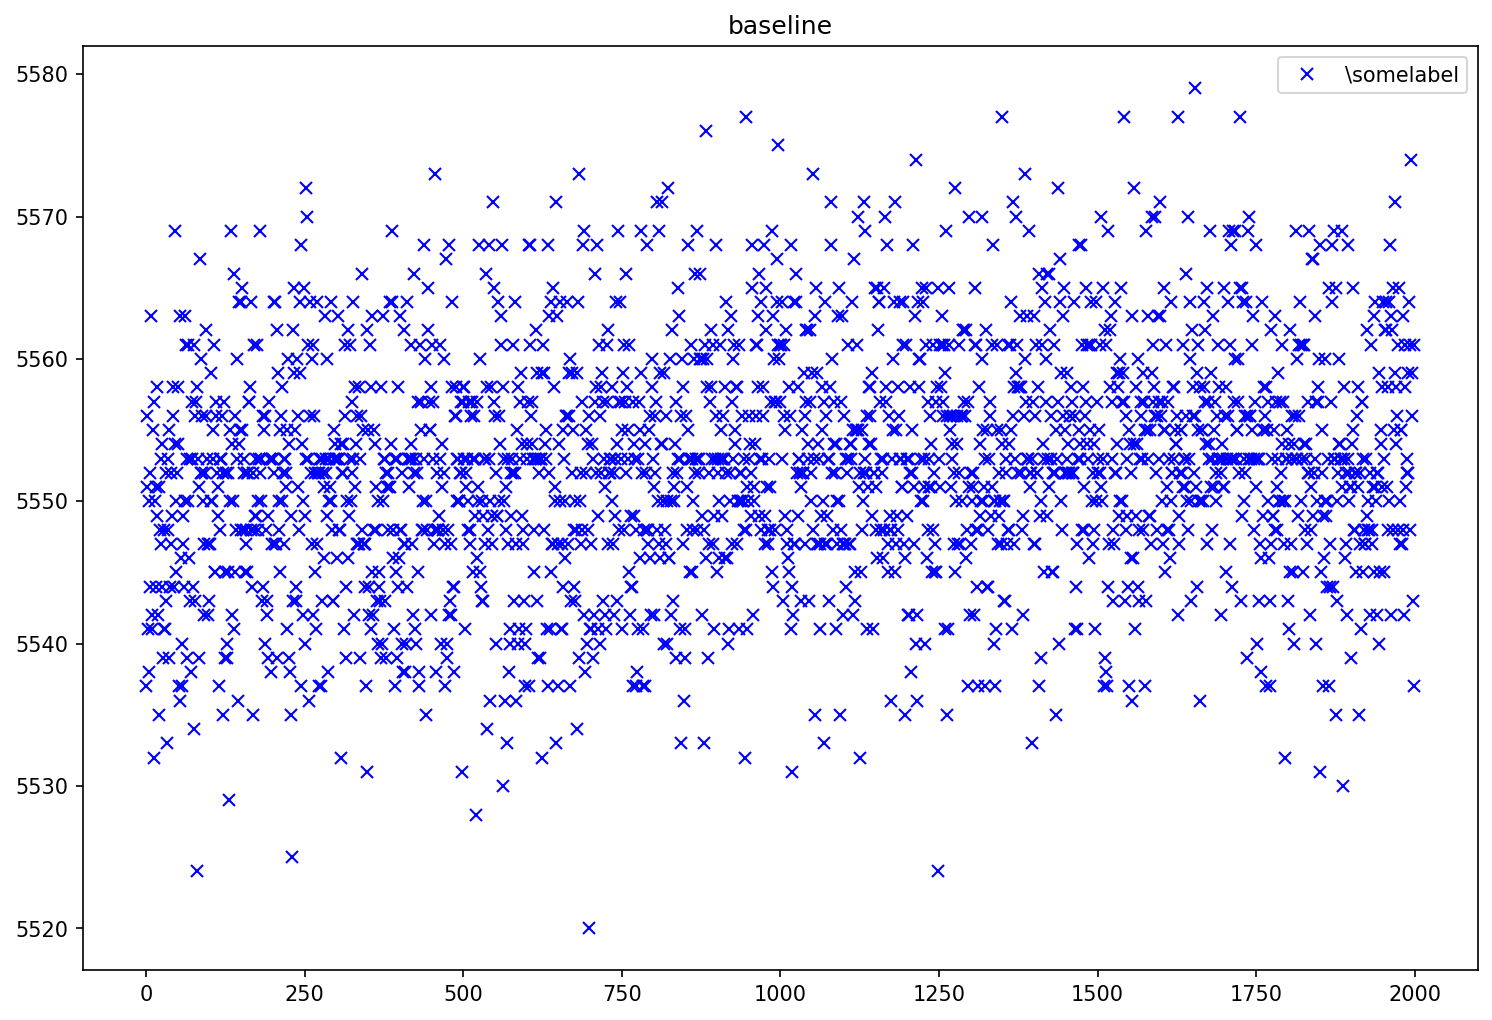

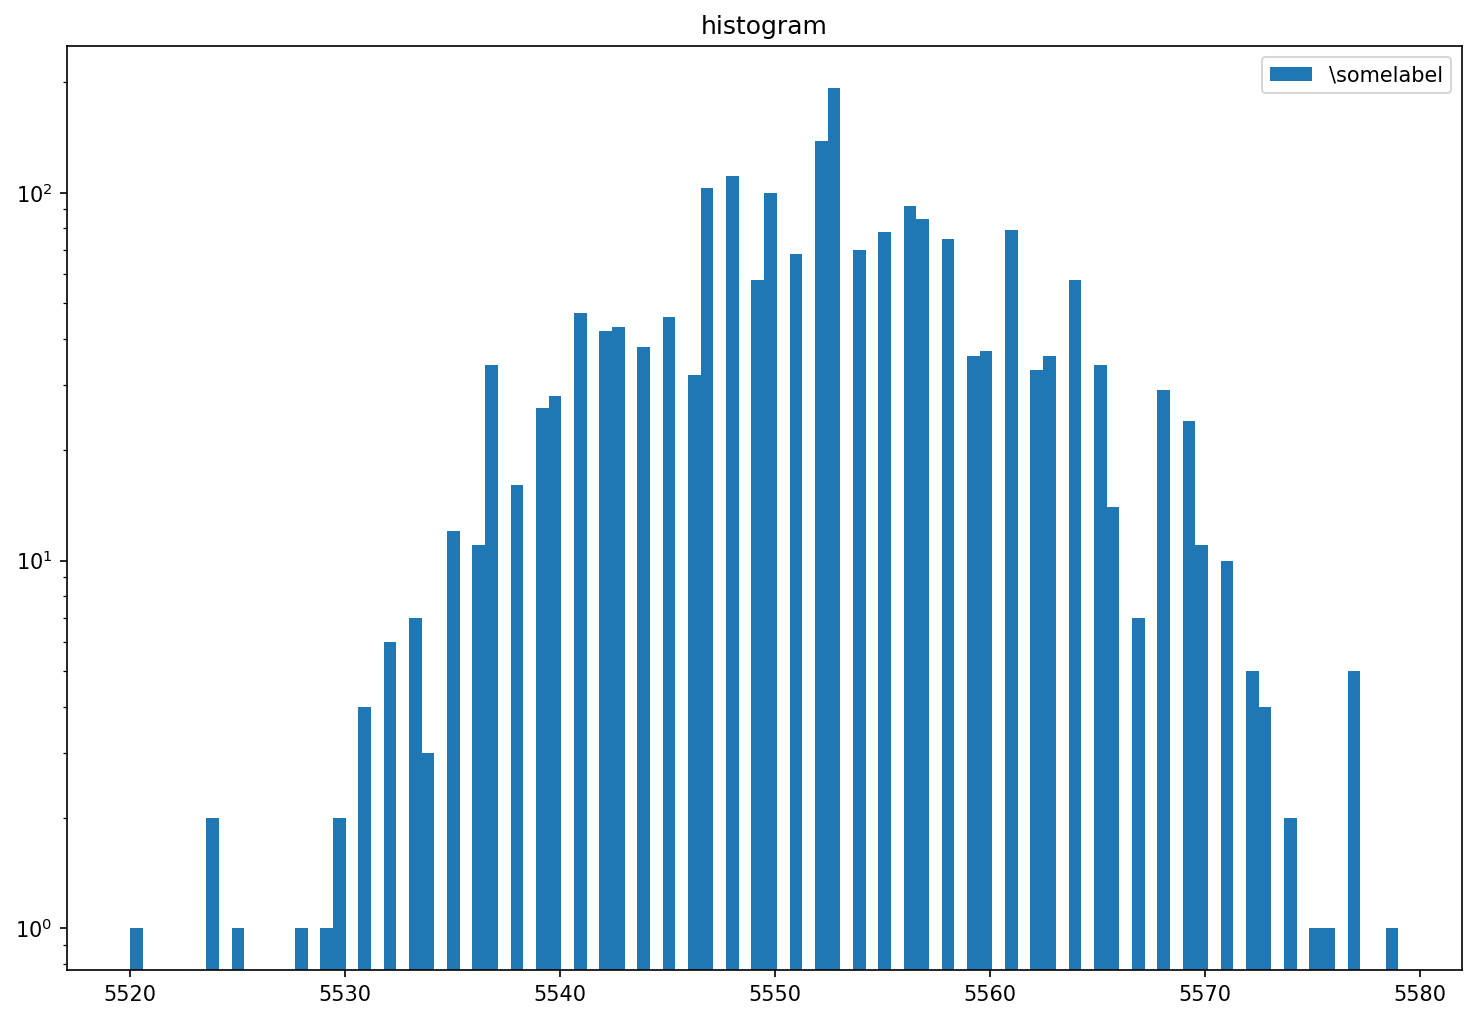

(145, 384)


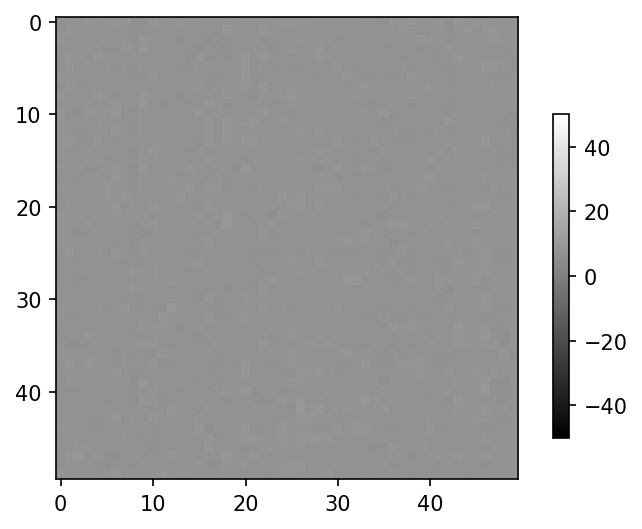

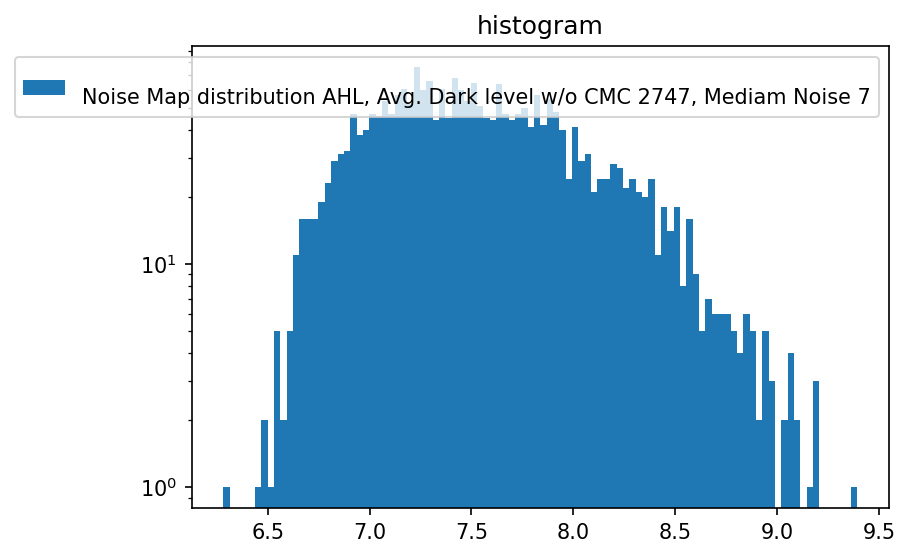


/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_5_Preamp_4_Vld1b_1_PixelCB_4_Filter_DAC_38_VRrefdac_56_DHg_0_RefGenB_1_RefGenC_2_run1.dat
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)


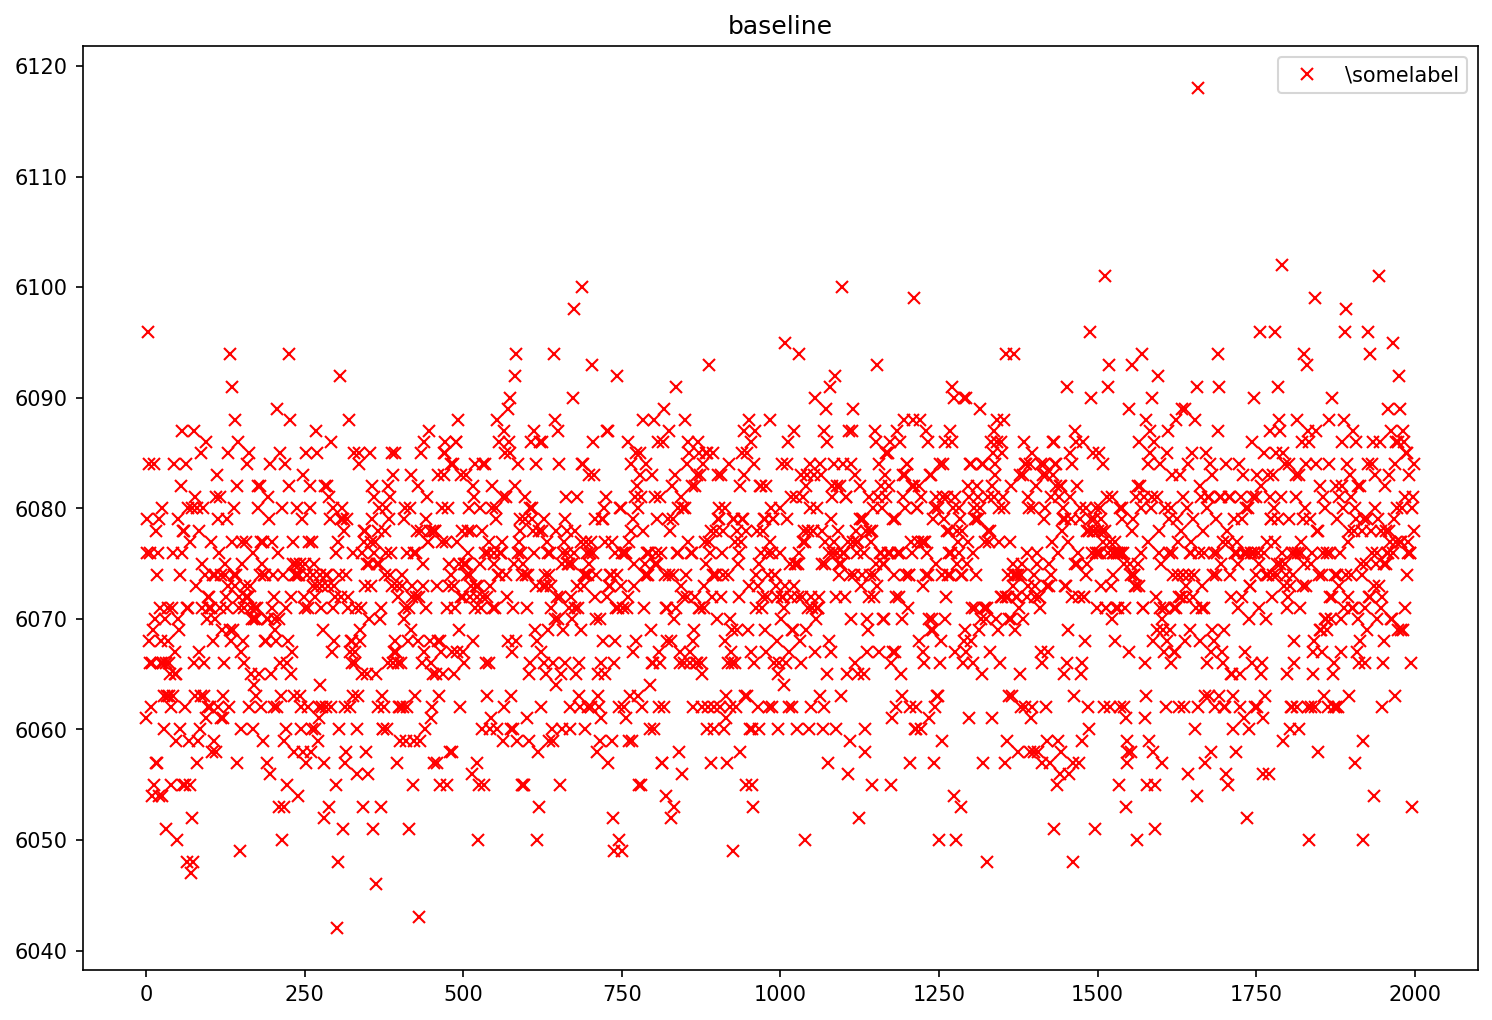

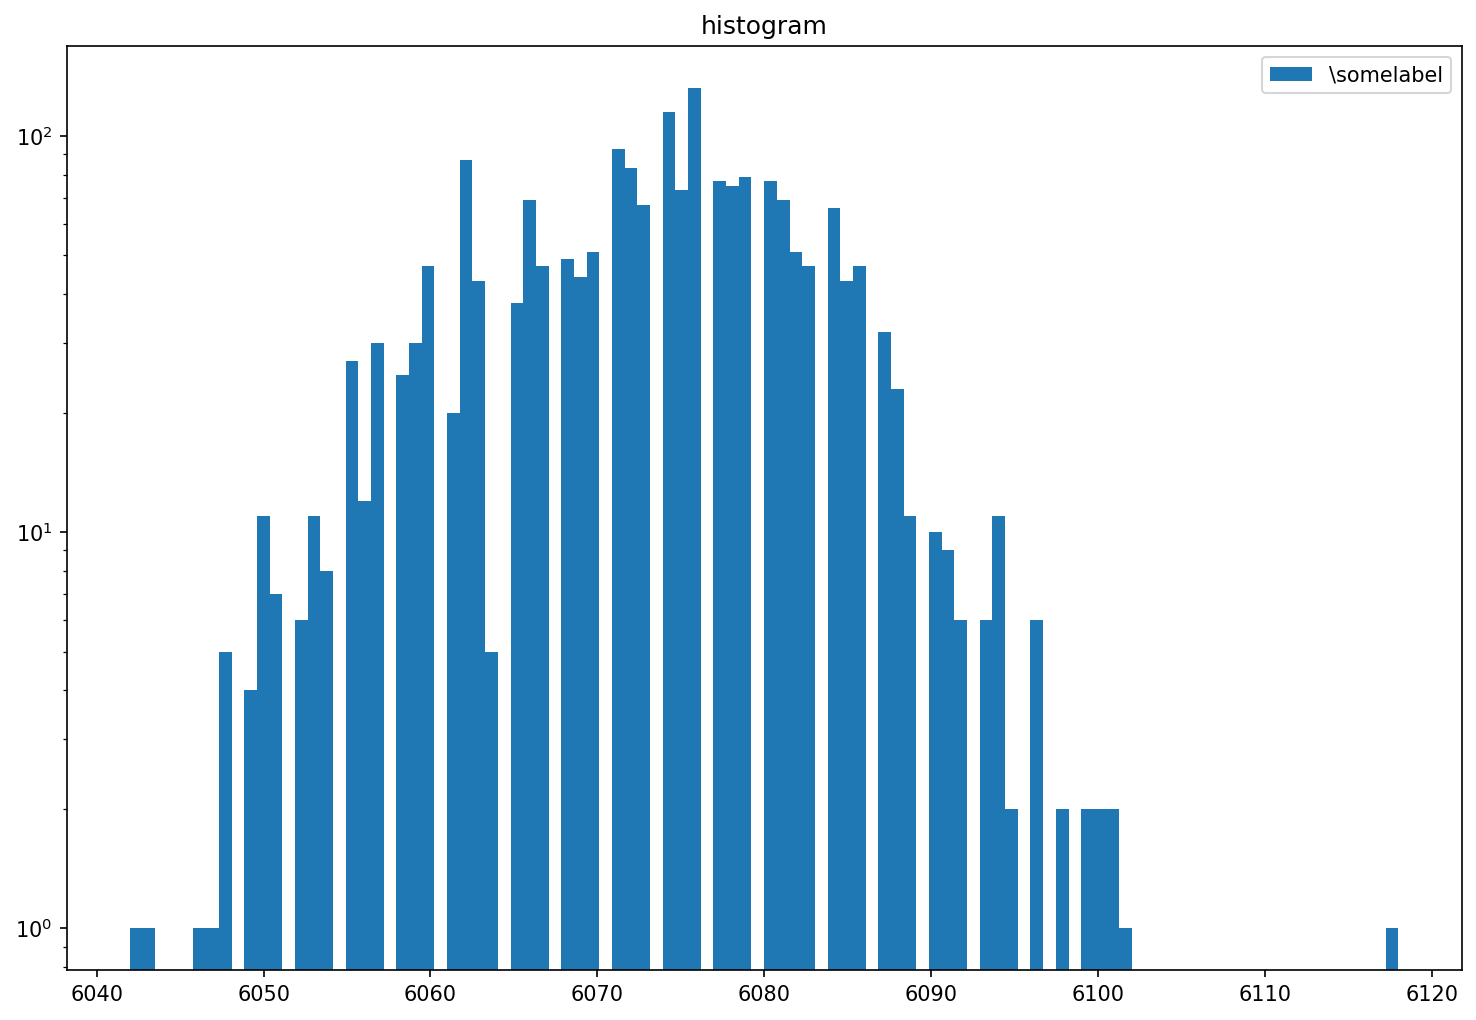

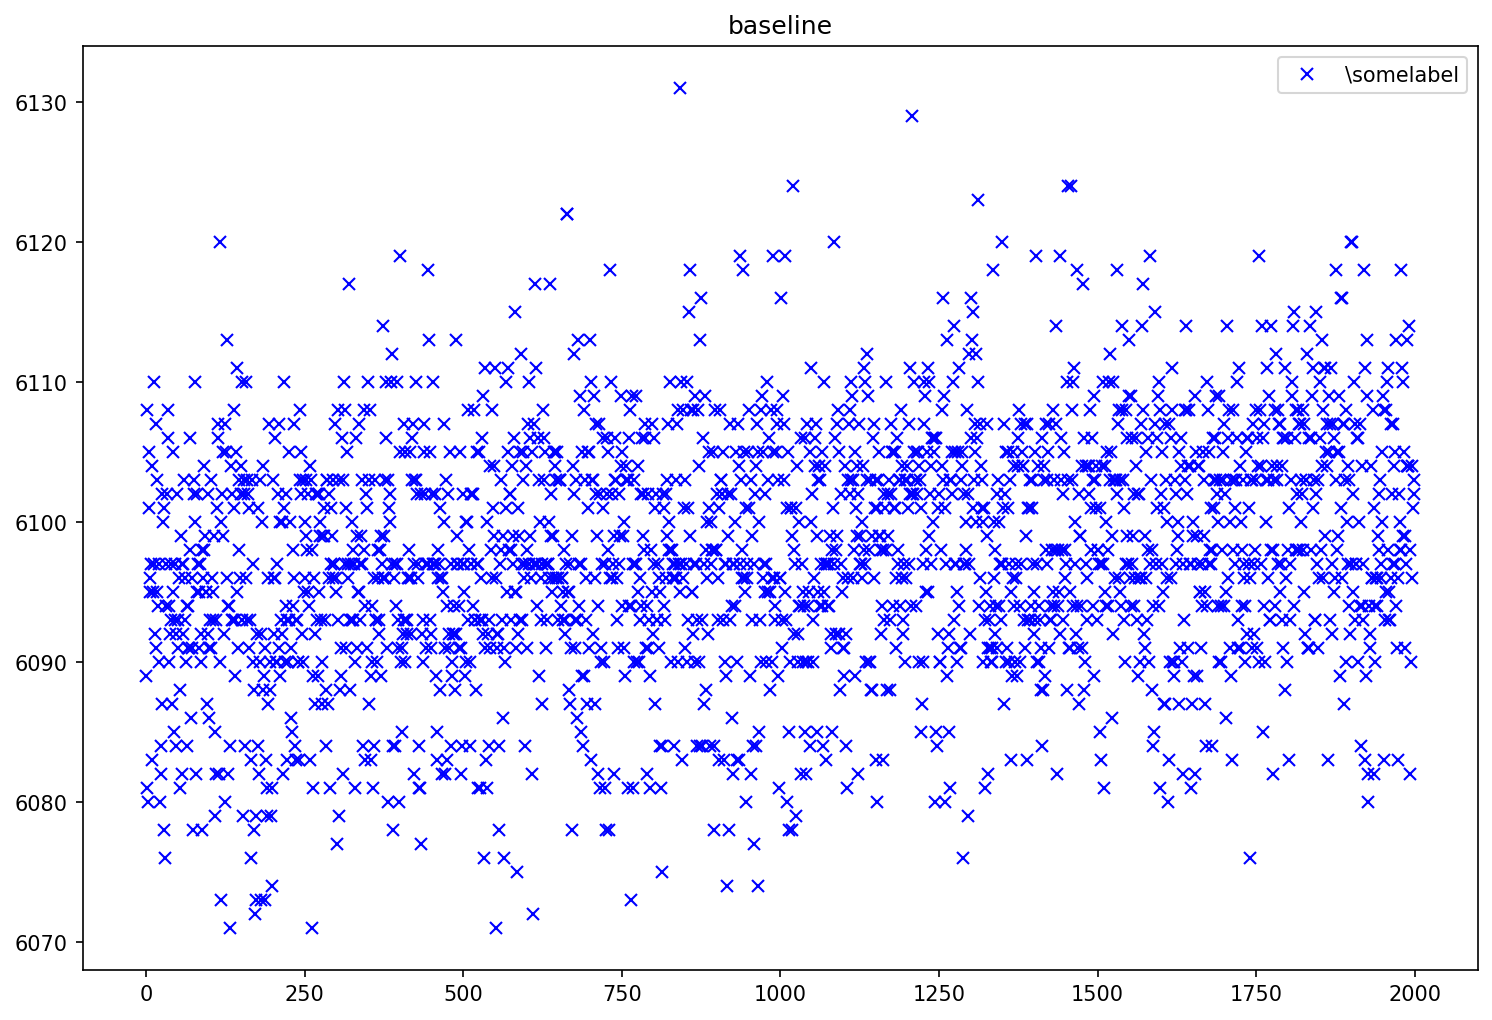

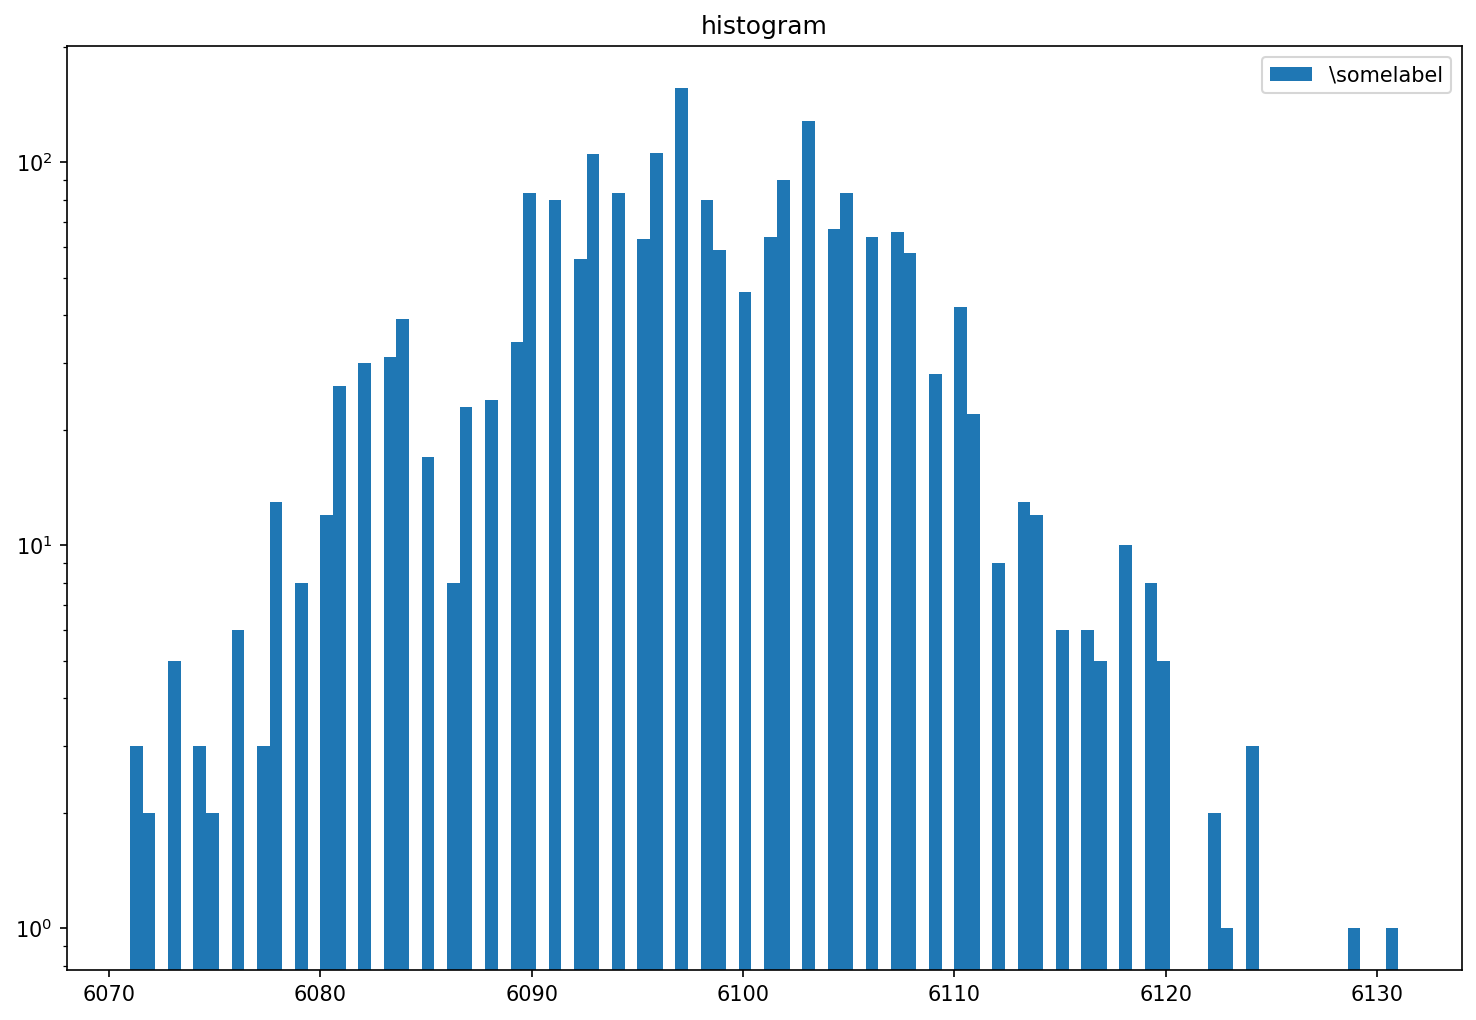

(145, 384)


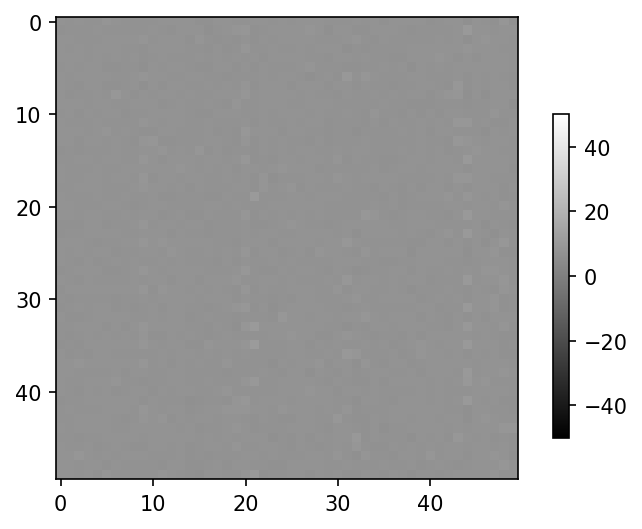

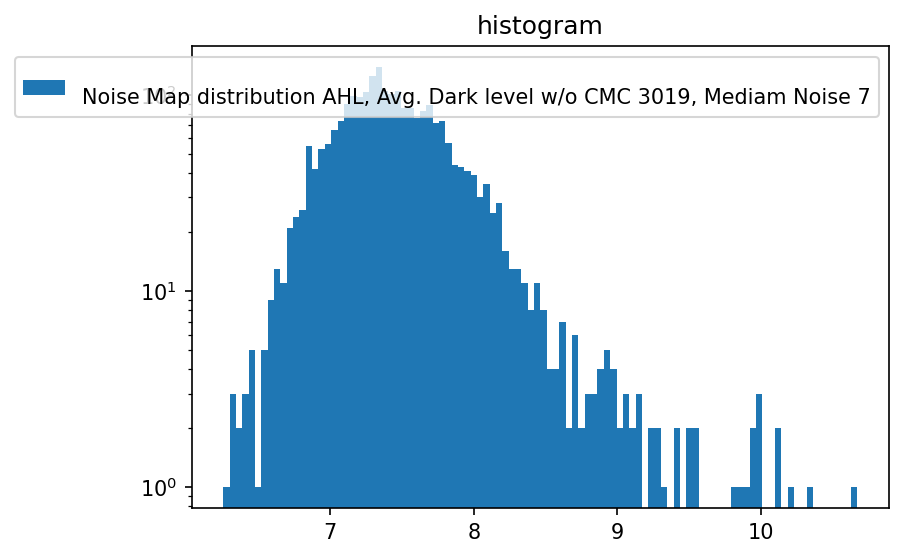


/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_5_Preamp_4_Vld1b_1_PixelCB_4_Filter_DAC_38_VRrefdac_60_DHg_0_RefGenB_1_RefGenC_2_run1.dat
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)


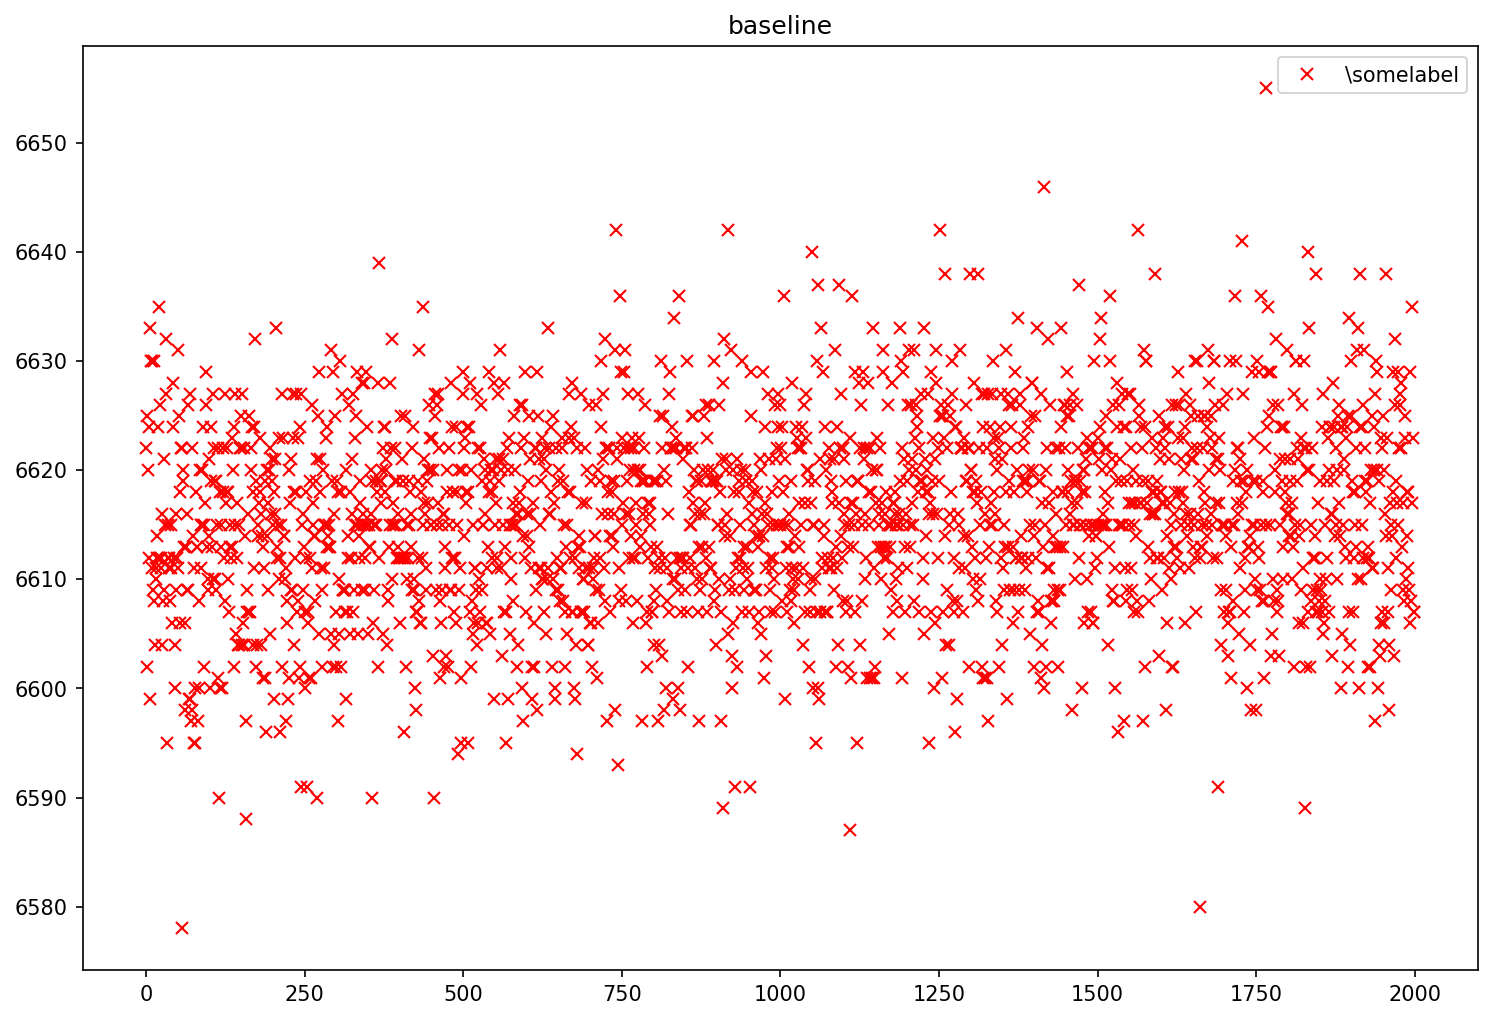

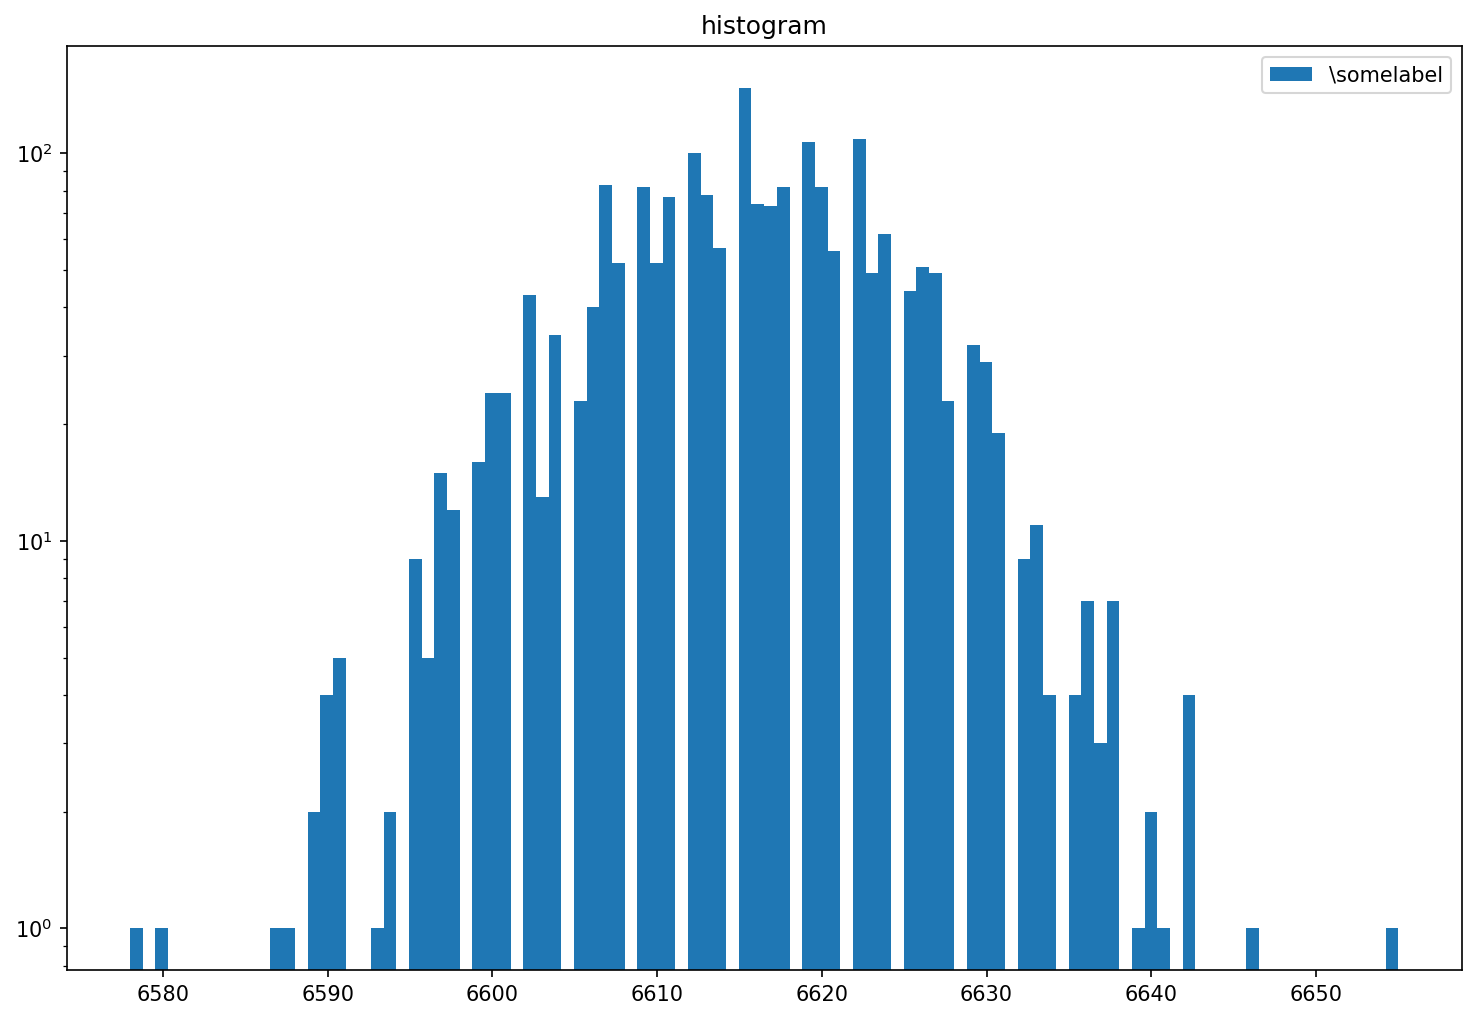

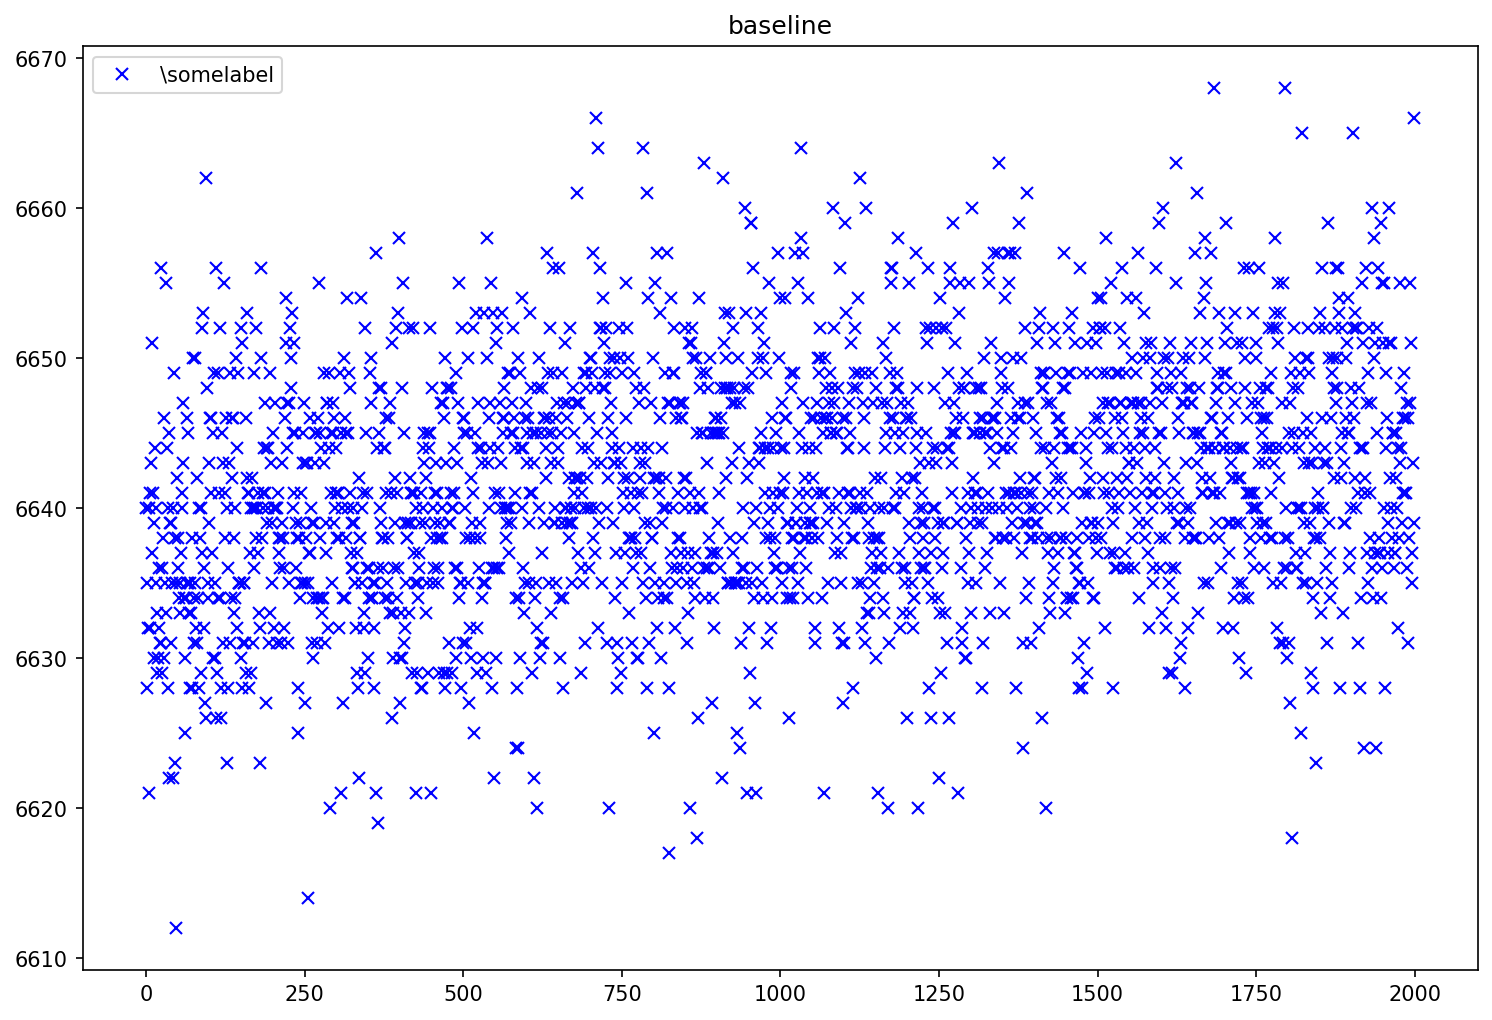

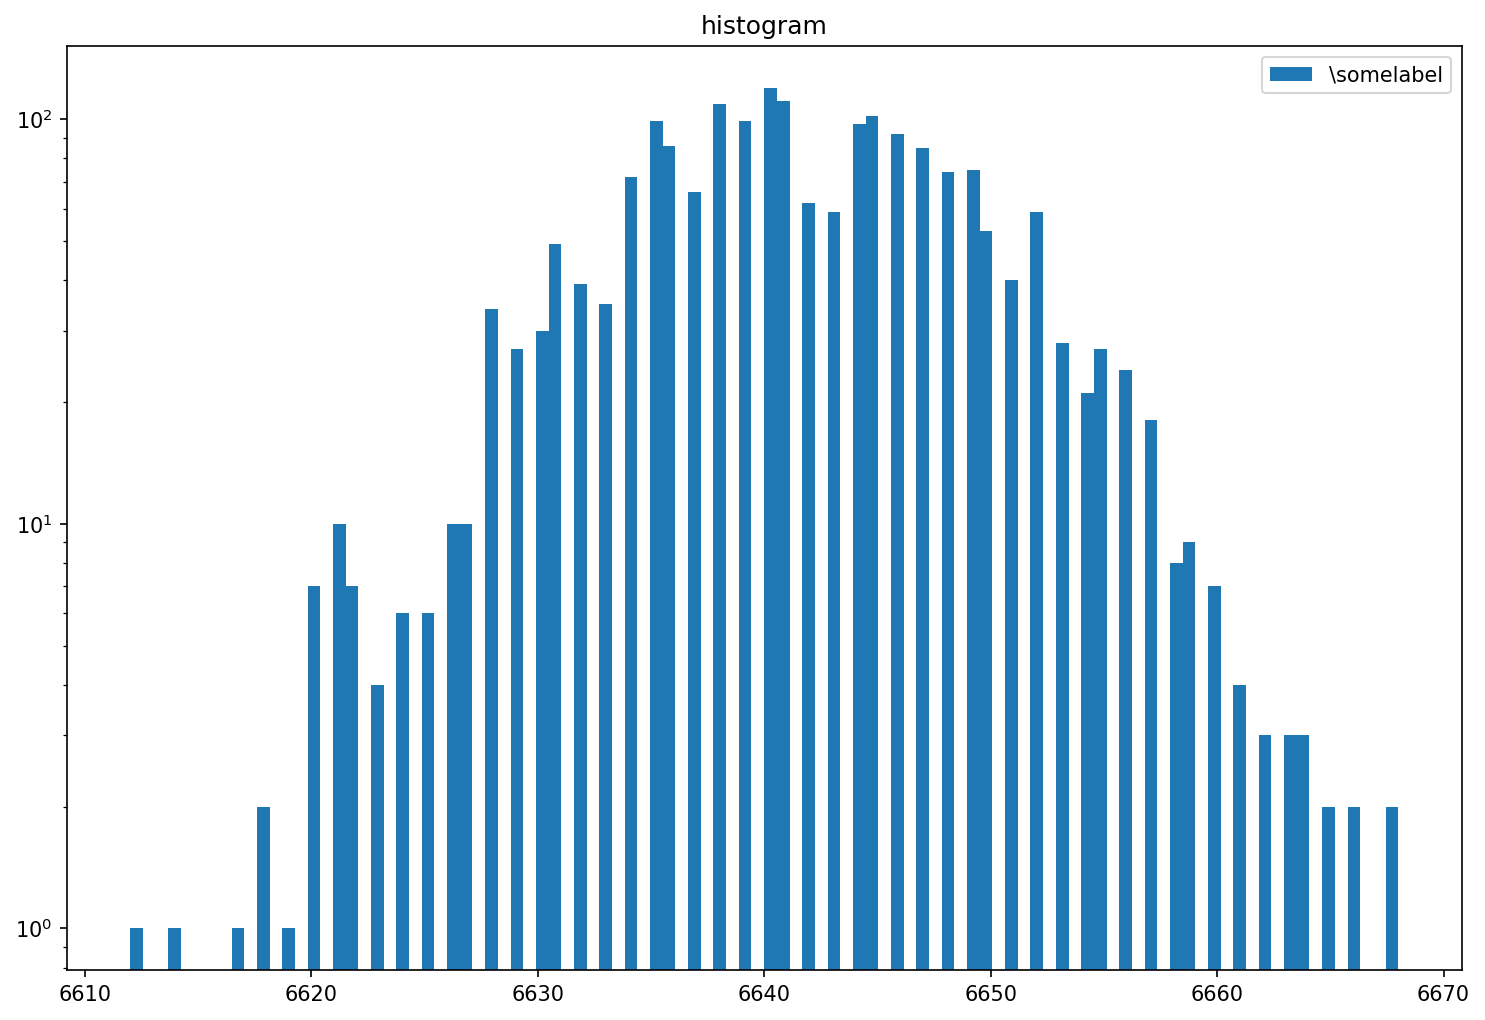

(145, 384)


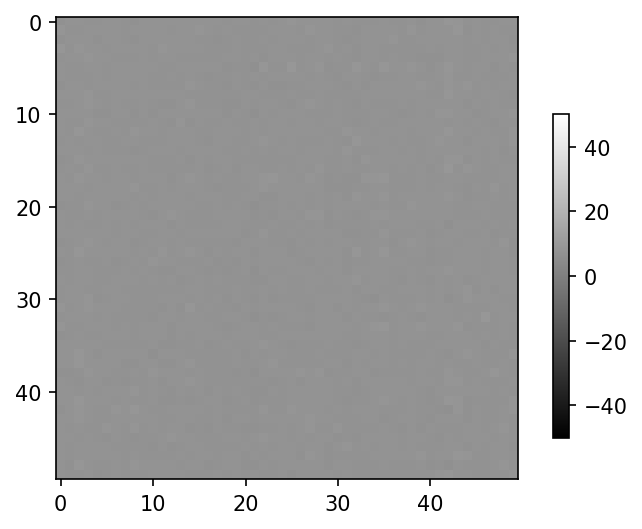

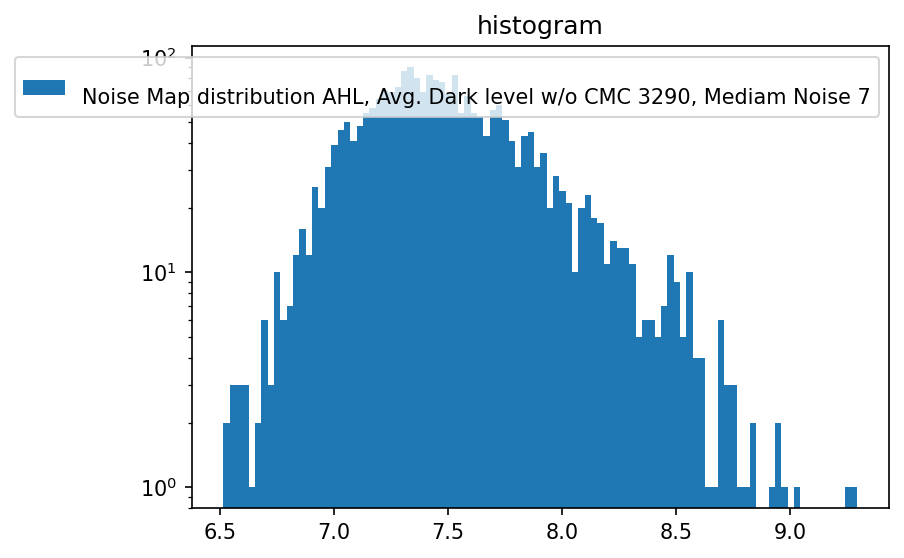


Camera  ePixHr10kTBatcher  selected.


In [23]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask

Preamp = 4 #[4,7,6,5,4,3,2,1,0] #[4]
Vld1_b = 1
Pixel_CB= 4
Filter_DAC= 38
VRef_DAC = 53

RefGenB    = 1     #3       #2              #3
RefGenC    = 2     #0       #3              #2
S2D_1_b    = 0     #0       #0              #0
shvc_DAC   = 30    #30      #23             #23
S2dDacBias = 3     #3       #3              #3
DHg        = False #True    #True           #True 


imgDescCum = []

for VRef_DAC in range(0,64,4):
    
    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_2V6Supply_clearMatrix_0_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_DHg_%d_RefGenB_%d_RefGenC_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC,DHg,RefGenB,RefGenC))
    ########################################################################################################################
    imgDesc = read_asic_test(4000)
    if (imgDescCum == []):
        imgDescCum = imgDesc
    else:
        imgDescCum = np.concatenate((imgDescCum, imgDesc),0)
    ########################################################################################################################
    #[noiseMap, darkAvg] = noise_print()
    #scatter plot
    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,10,10]
    plt.plot(dataset, 'rx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()


    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,140,75]
    plt.plot(dataset, 'bx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()

    
    noise_print_roi(x=10,y=10,width=50,height=50,imgDesc=imgDesc)

MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask


In [29]:
#/u2/ddoering/ASIC_V4_ASIC2_SB/
#np.save("imgDescCum.npy",imgDescCum)
np.save("imgDescCum2V6Supply.npy",imgDescCum)

In [30]:
imgDescCumLoaded = np.load("imgDescCum2V6Supply.npy")

In [31]:
imgDescCumLoaded.shape

(32000, 145, 384)

In [32]:
y_index = np.arange(0, 26)

print(y_index.shape)

print((y_index / 3).astype(int))


y_index = np.arange(0, imgDescCumLoaded.shape[0])
y_index = (y_index / 2000).astype(int)*4

print(y_index.shape)


(26,)
[0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8]
(32000,)


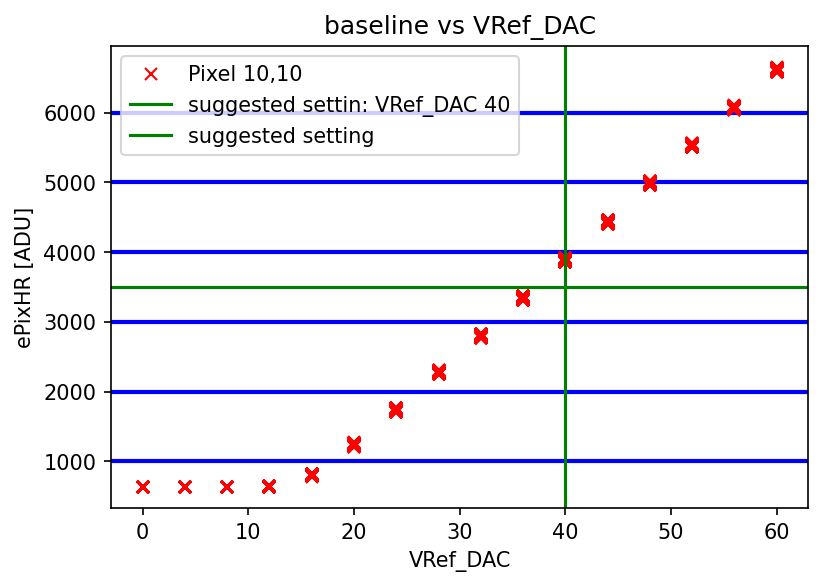

In [33]:
#scatter plot
plt.figure(1,figsize=(6,4),dpi=150)
dataset = imgDescCumLoaded[:,10,10]
plt.plot(y_index, dataset, 'rx', label=(f'Pixel %d,%d' % (10,10)))
plt.axvline(x=40, color = 'g', label = 'suggested settin: VRef_DAC 40')
plt.axhline(y=3500, color = 'g', label = 'suggested setting')
plt.grid(color='b', linestyle='-', linewidth=2, which='both', axis='y')
plt.title("baseline vs VRef_DAC")
# adding axis labels     
plt.xlabel('VRef_DAC') 
plt.ylabel('ePixHR [ADU]')         
plt.legend()
plt.show()



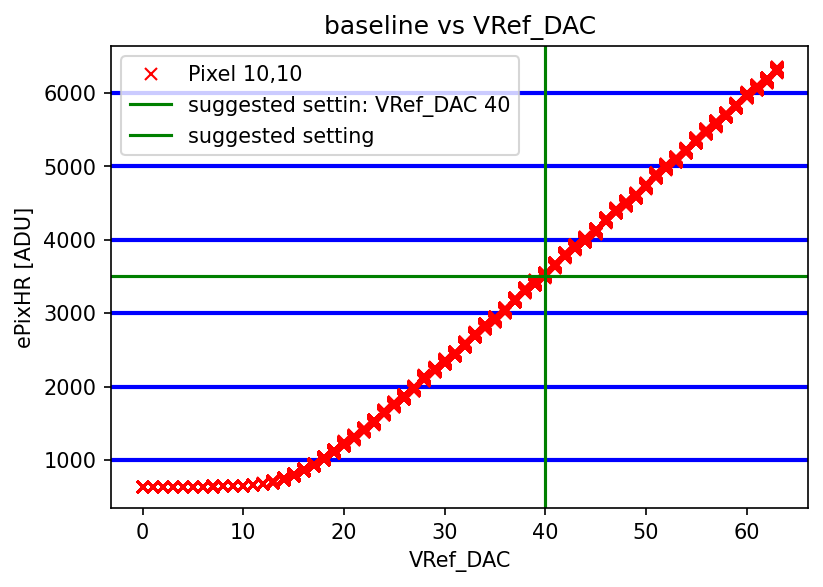

In [97]:
#scatter plot
plt.figure(1,figsize=(6,4),dpi=150)
dataset = imgDescCumLoaded[:,10,10]
plt.plot(y_index, dataset, 'rx', label=(f'Pixel %d,%d' % (10,10)))
plt.axvline(x=40, color = 'g', label = 'suggested settin: VRef_DAC 40')
plt.axhline(y=3500, color = 'g', label = 'suggested setting')
plt.grid(color='b', linestyle='-', linewidth=2, which='both', axis='y')
plt.title("baseline vs VRef_DAC")
# adding axis labels     
plt.xlabel('VRef_DAC') 
plt.ylabel('ePixHR [ADU]')         
plt.legend()
plt.show()



In [34]:
dataset1 = dataset.reshape(16, -1)

In [26]:
dataset1 = dataset.reshape(64, -1)
print(dataset1.shape)
plt.figure(1,figsize=(12,8),dpi=150)
#dataset = imgDescCumLoaded[:,10,10].reshape(4000,-1)
plt.plot(dataset1.transpose(), 'bx', label=(f'Pixel %d,%d' % (10,10)))
plt.title("baseline") 
#plt.legend()
plt.show()

ValueError: cannot reshape array of size 26000 into shape (64,newaxis)

(16, 2000)


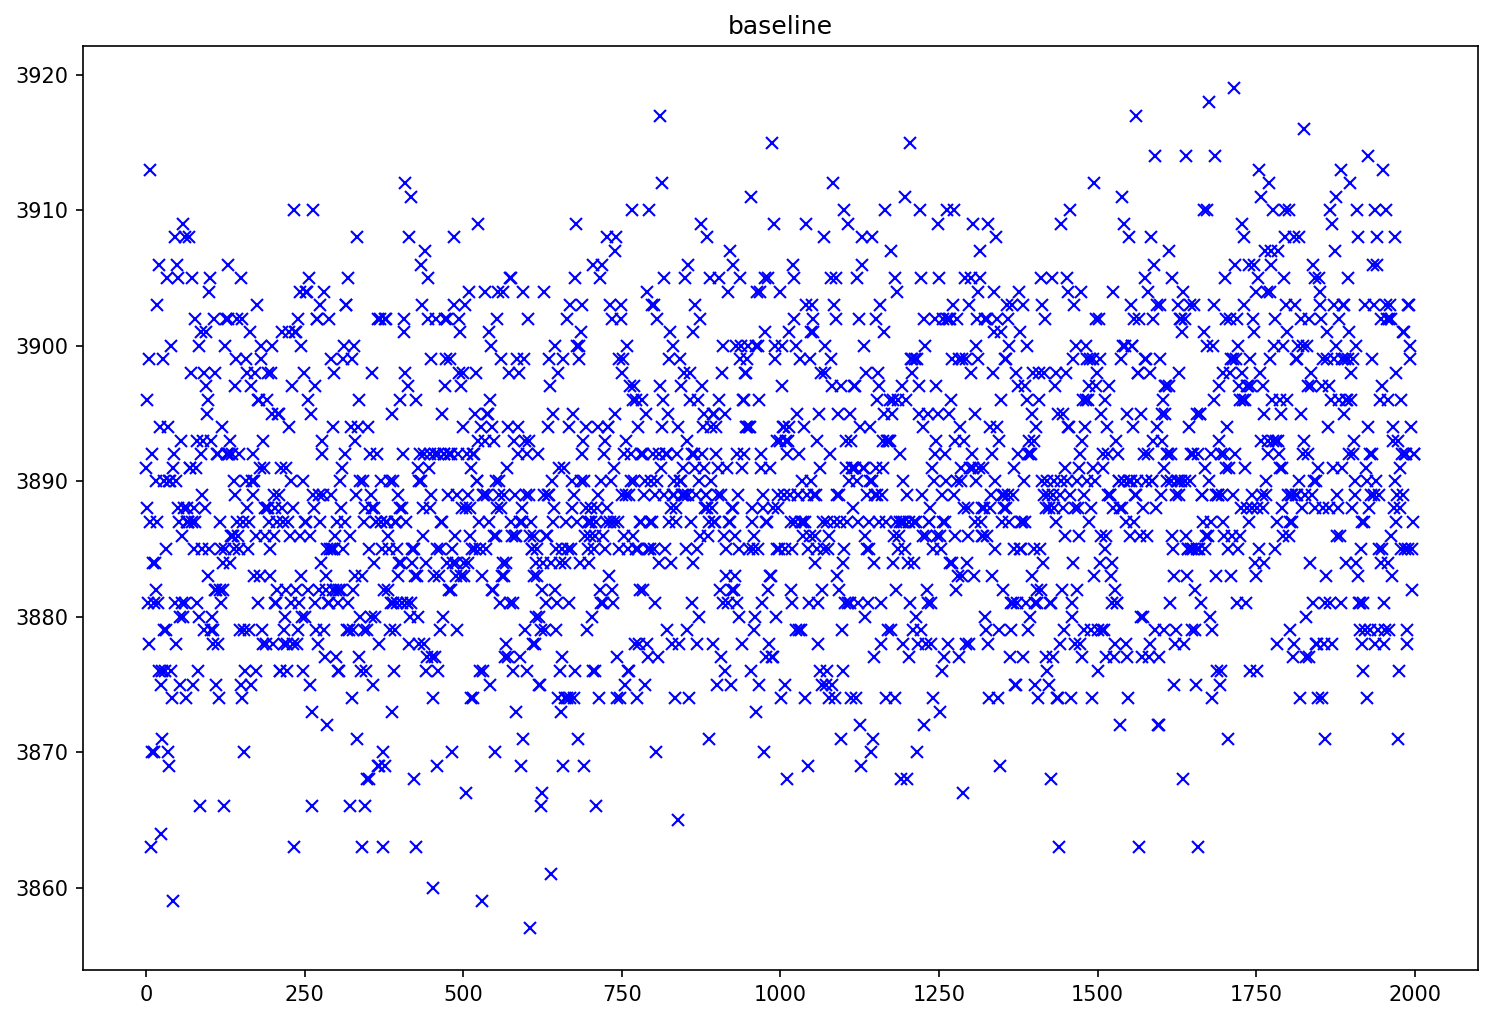

In [35]:
print(dataset1.shape)
plt.figure(1,figsize=(12,8),dpi=150)
#dataset = imgDescCumLoaded[:,10,10].reshape(4000,-1)
plt.plot(dataset1[10], 'bx', label=(f'Pixel %d,%d' % (10,10)))
plt.title("baseline") 
#plt.legend()
plt.show()

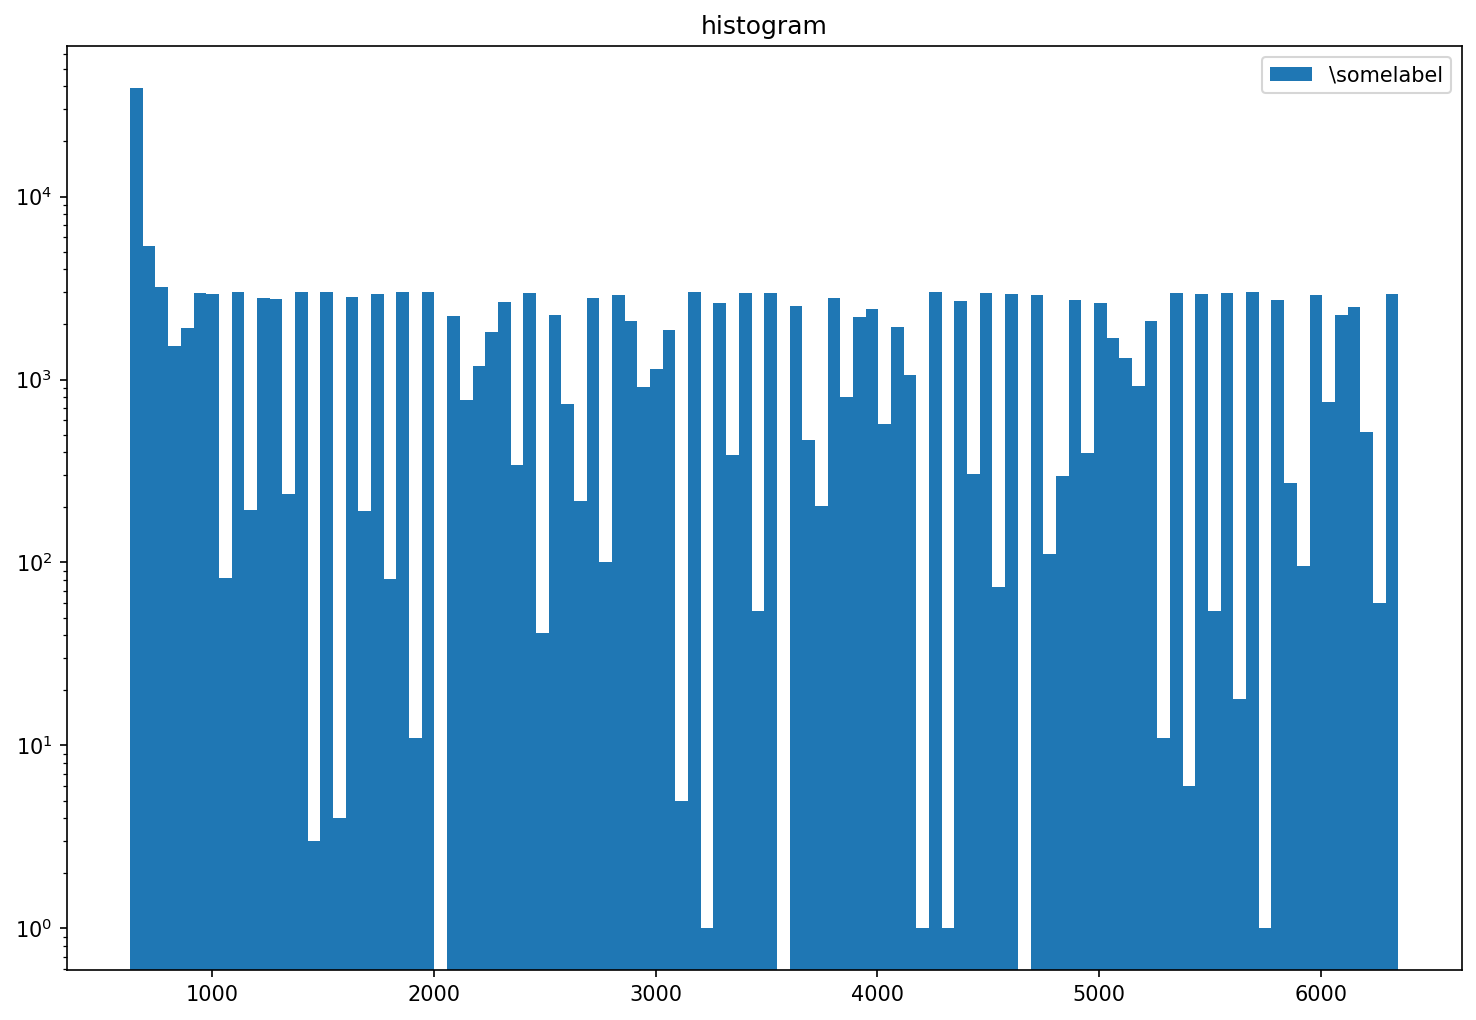

In [33]:
plt.figure(2,figsize=(12,8),dpi=150)
plt.hist(dataset1.reshape(-1), bins=100, label=f'\somelabel') 
plt.yscale('log')
plt.title("histogram") 
plt.legend()
plt.show()

In [41]:
imgDesc13b = np.bitwise_and(dataset1[:],0xFFFE)
imgDesc12b = np.bitwise_and(dataset1[:],0xFFFC)
imgDesc11b = np.bitwise_and(dataset1[:],0xFFF8)

(64, 3000)


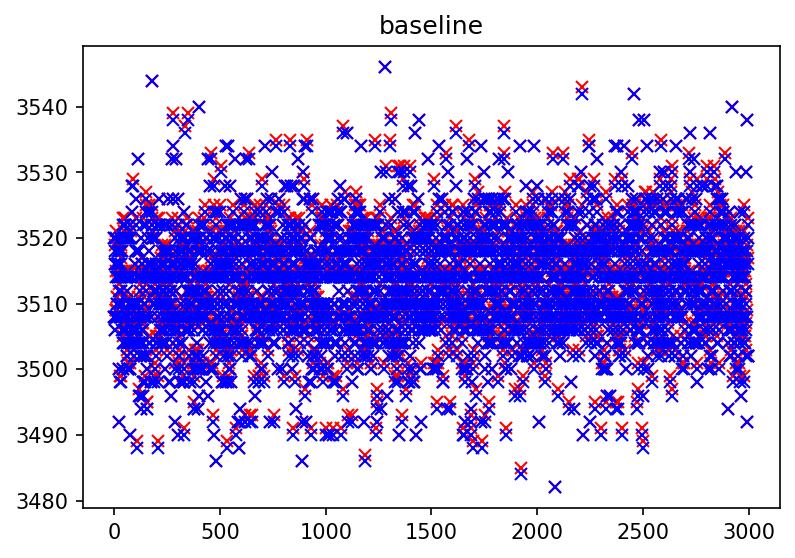

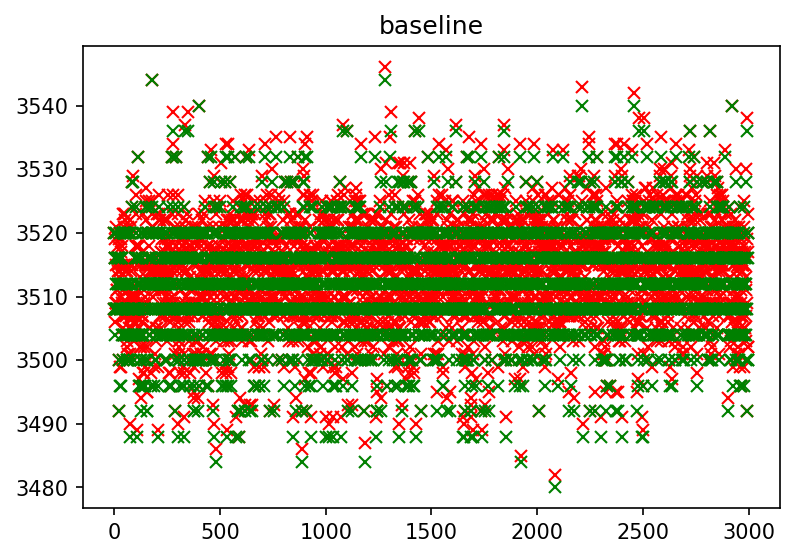

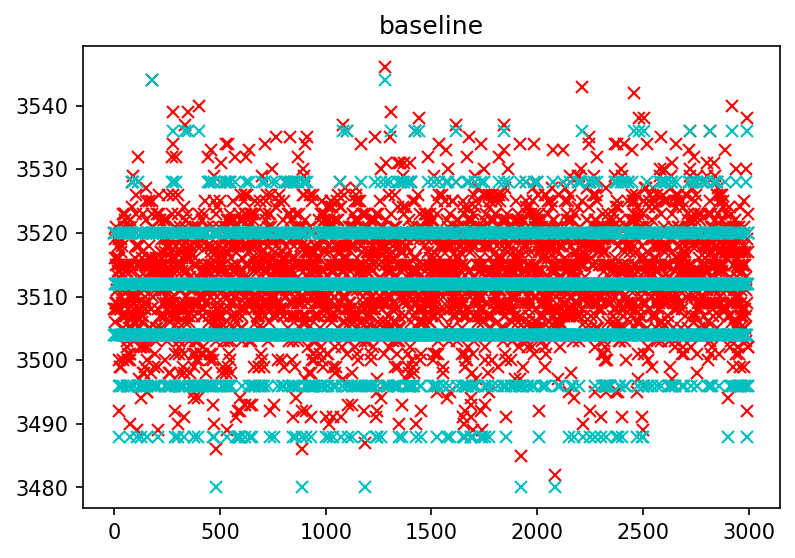

In [48]:
print(dataset1.shape)
plt.figure(figsize=(6,4),dpi=150)
#dataset = imgDescCumLoaded[:,10,10].reshape(4000,-1)
plt.plot(dataset1[40], 'rx', label=(f'Pixel %d,%d' % (10,10)))
plt.plot(imgDesc13b[40], 'bx', label=(f'Pixel %d,%d' % (10,10)))
plt.title("baseline") 
#plt.legend()
plt.show()

plt.figure(figsize=(6,4),dpi=150)
plt.plot(dataset1[40], 'rx', label=(f'Pixel %d,%d' % (10,10)))
plt.plot(imgDesc12b[40], 'gx', label=(f'Pixel %d,%d' % (10,10)))
plt.title("baseline") 
#plt.legend()
plt.show()

plt.figure(figsize=(6,4),dpi=150)
plt.plot(dataset1[40], 'rx', label=(f'Pixel %d,%d' % (10,10)))
plt.plot(imgDesc11b[40], 'cx', label=(f'Pixel %d,%d' % (10,10)))
plt.title("baseline") 
#plt.legend()
plt.show()


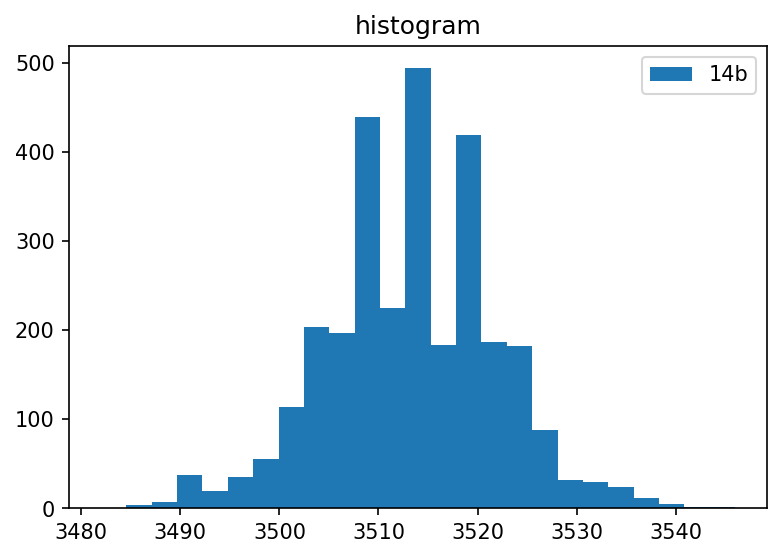

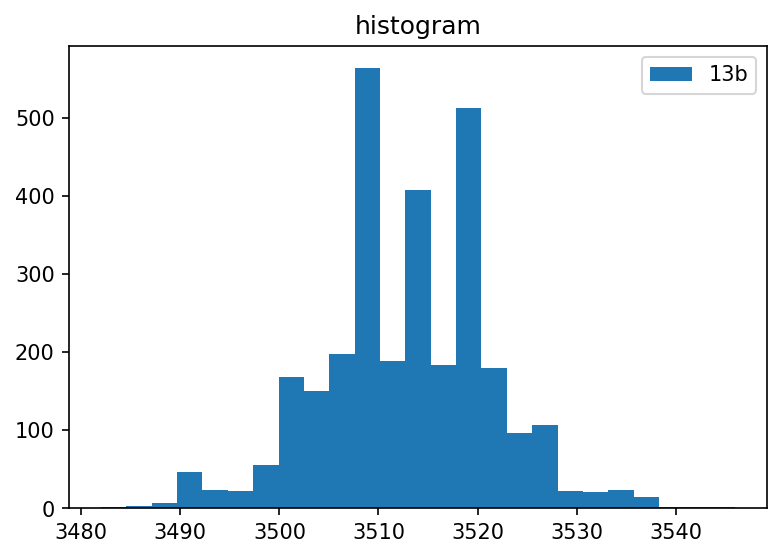

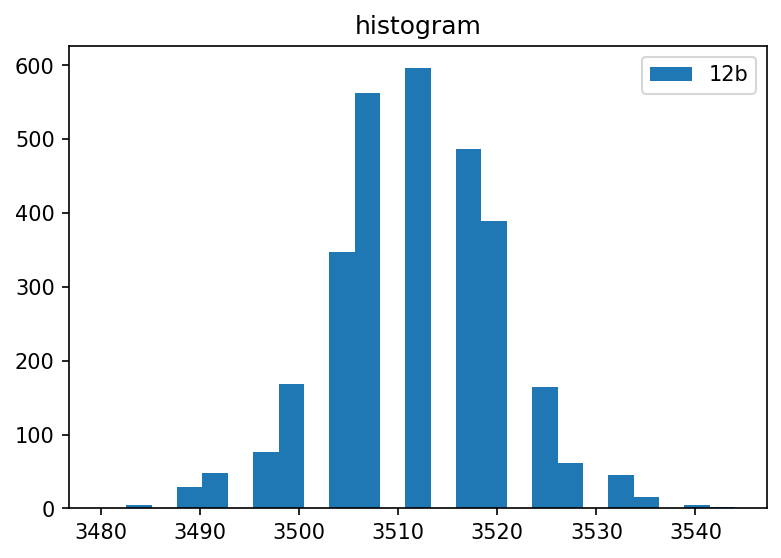

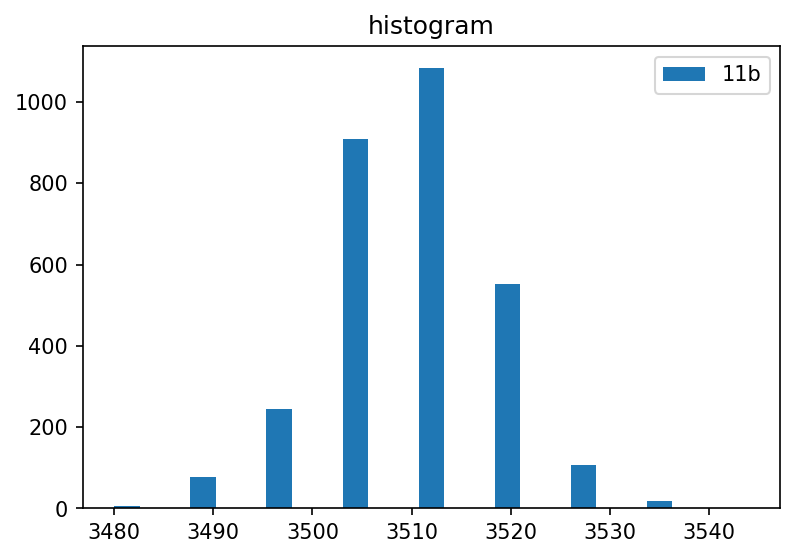

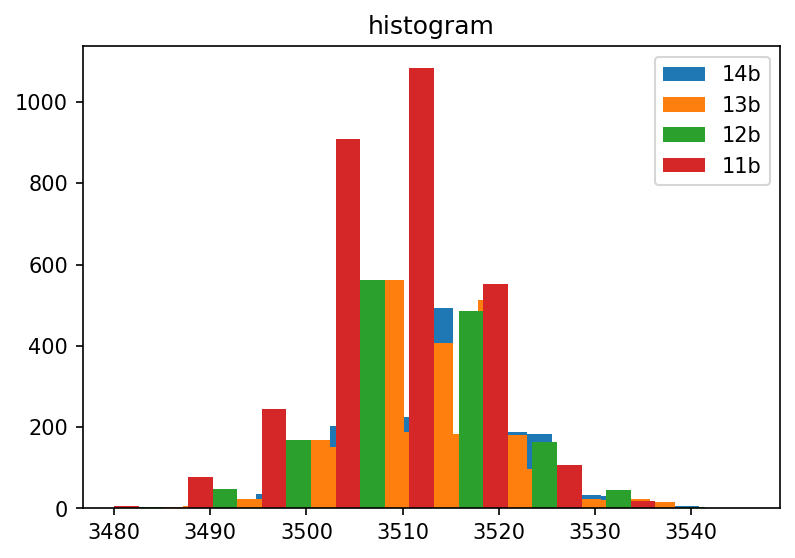

In [53]:
plt.figure(figsize=(6,4),dpi=150)
plt.hist(dataset1[40], bins=25, label=f'14b') 
plt.title("histogram") 
plt.legend()
plt.show()
plt.figure(figsize=(6,4),dpi=150)
plt.hist(imgDesc13b[40], bins=25, label=f'13b') 
plt.title("histogram") 
plt.legend()
plt.show()
plt.figure(figsize=(6,4),dpi=150)
plt.hist(imgDesc12b[40], bins=25, label=f'12b') 
plt.title("histogram") 
plt.legend()
plt.show()
plt.figure(figsize=(6,4),dpi=150)
plt.hist(imgDesc11b[40], bins=25, label=f'11b') 
plt.title("histogram") 
plt.legend()
plt.show()

plt.figure(figsize=(6,4),dpi=150)
plt.hist(dataset1[40], bins=25, label=f'14b') 
plt.hist(imgDesc13b[40], bins=25, label=f'13b') 
plt.hist(imgDesc12b[40], bins=25, label=f'12b') 
plt.hist(imgDesc11b[40], bins=25, label=f'11b') 
plt.title("histogram") 
plt.legend()
plt.show()

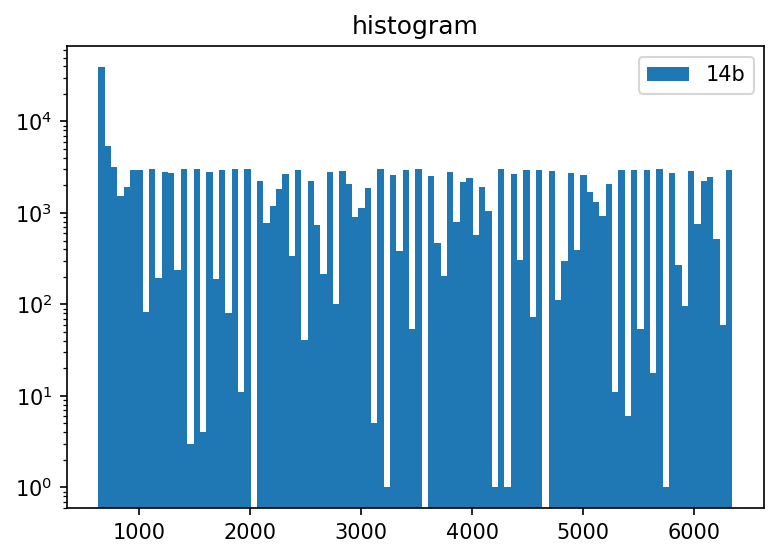

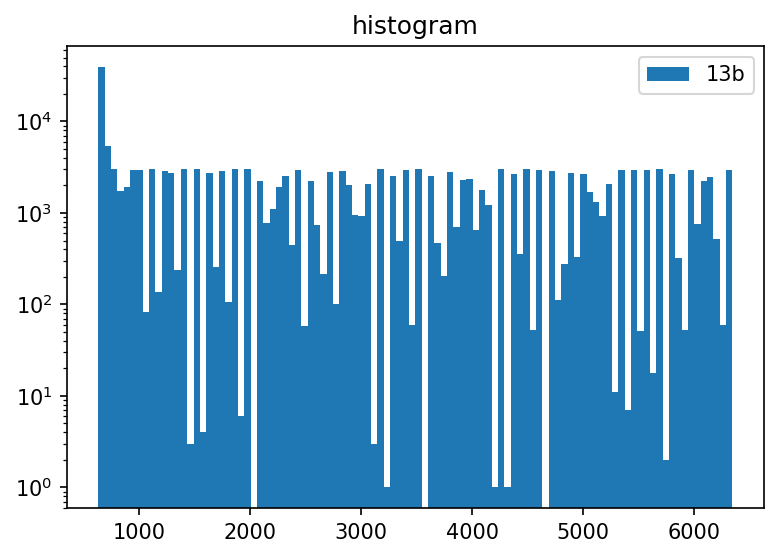

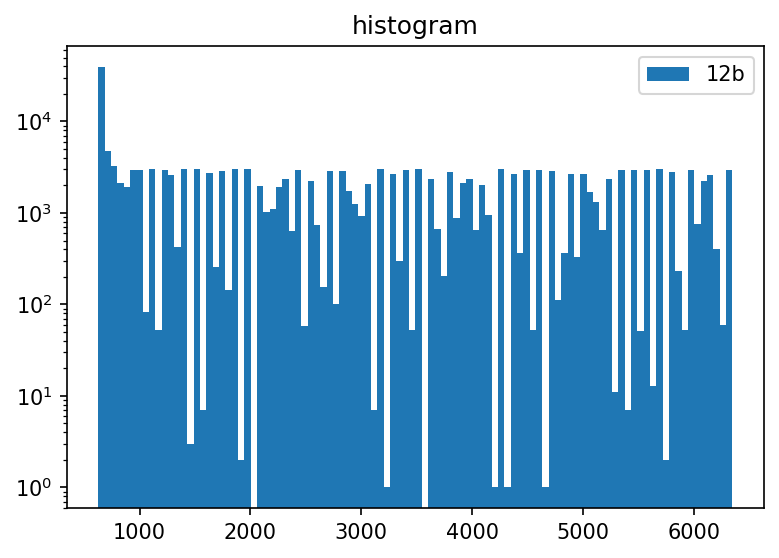

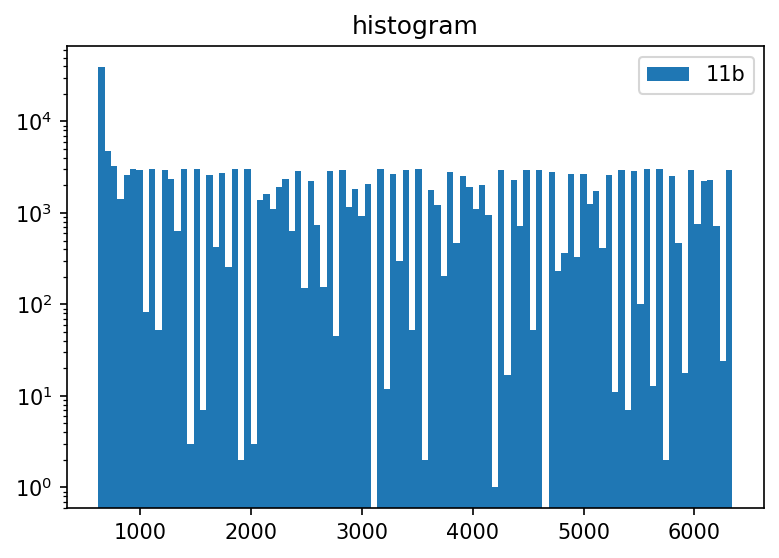

In [42]:
plt.figure(figsize=(6,4),dpi=150)
plt.hist(dataset1.reshape(-1), bins=100, label=f'14b') 
plt.yscale('log')
plt.title("histogram") 
plt.legend()
plt.show()
plt.figure(figsize=(6,4),dpi=150)
plt.hist(imgDesc13b.reshape(-1), bins=100, label=f'13b') 
plt.yscale('log')
plt.title("histogram") 
plt.legend()
plt.show()
plt.figure(figsize=(6,4),dpi=150)
plt.hist(imgDesc12b.reshape(-1), bins=100, label=f'12b') 
plt.yscale('log')
plt.title("histogram") 
plt.legend()
plt.show()
plt.figure(figsize=(6,4),dpi=150)
plt.hist(imgDesc11b.reshape(-1), bins=100, label=f'11b') 
plt.yscale('log')
plt.title("histogram") 
plt.legend()
plt.show()

# Baseline Matrix in RESET TEST

In [ ]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask

In [ ]:
#Initialze the camera
#[routine, asic0, asic1, asic2, asic3]'
initSequence = 5
root.EpixHR.InitASIC([initSequence,0,0,1,0])
#points to the ASIC device under test
ASIC = root.EpixHR.Hr10kTAsic2
root.EpixHR.BatcherEventBuilder0.Blowoff.set(True)
root.EpixHR.BatcherEventBuilder0.Bypass.set(1)
root.EpixHR.BatcherEventBuilder1.Blowoff.set(False)
root.EpixHR.BatcherEventBuilder1.Bypass.set(1)
root.EpixHR.BatcherEventBuilder2.Blowoff.set(True)

In [ ]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(10)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)


In [ ]:
#use system with batcher and missing ASICs
root.EpixHR.SspLowSpeedDecoderReg.enable.set(True)
print ("Locked lanes: %x" % root.EpixHR.SspLowSpeedDecoderReg.Locked.get())
#Only ASIC 1 is available so disable the 6 lower lanes
root.EpixHR.PacketRegisters0.DisableLane.set(0x3FF)
root.EpixHR.PacketRegisters1.DisableLane.set(0xFC0)
#using internal triggers, so bypassing timing channel at the batcher 
root.EpixHR.BatcherEventBuilder0.Bypass.set(1)
root.EpixHR.BatcherEventBuilder1.Bypass.set(1)
root.EpixHR.BatcherEventBuilder2.Blowoff.set(True)


In [ ]:
print(ASIC.Preamp.get())
print(ASIC.Vld1_b.get())
print(ASIC.Pixel_CB.get())
print(ASIC.Filter_DAC.get())
print(ASIC.VRef_DAC.get())

In [ ]:
print('DHG', ASIC.DHg.get())
print('RefGenB', ASIC.RefGenB.get())
print('RefGenC', ASIC.RefGenC.get())
print('S2D_1_b', ASIC.S2D_1_b.get())
print('shvc_DAC', ASIC.shvc_DAC.get())
print('S2dDacBias', ASIC.S2dDacBias.get())
DHg = True
RefGenB = 2
RefGenC = 3
S2D_1_b = 0
shvc_DAC = 23
S2dDacBias = 3
print("")
ASIC.DHg.set(DHg)  
ASIC.RefGenB.set(RefGenB)
ASIC.RefGenC.set(RefGenC)
ASIC.S2D_1_b.set(S2D_1_b)
ASIC.shvc_DAC.set(shvc_DAC)
ASIC.S2dDacBias.set(S2dDacBias)
print('DHG', ASIC.DHg.get())
print('RefGenB', ASIC.RefGenB.get())
print('RefGenC', ASIC.RefGenC.get())
print('S2D_1_b', ASIC.S2D_1_b.get())
print('shvc_DAC', ASIC.shvc_DAC.get())
print('S2dDacBias', ASIC.S2dDacBias.get())

In [ ]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)

PreampList = [7,6,5,4,3,2,1,0] #4
Vld1_b = 1 #1
Pixel_CB= 4 #4
Filter_DAC= 38 #33
VRef_DAC = 53 #22

ASIC.ClearMatrix(2)

for Preamp in PreampList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_clearMatrix_2_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_DHg_%d_RefGenB_%d_RefGenC_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC,DHg,RefGenB,RefGenC))
    ########################################################################################################################
    if os.path.exists(filename):
       os.remove(filename)
       print("The file %s was removed" %(filename))
    else:
       print("The file does not exist")
    imgDesc = run_asic_test(4000)
    np.save(filename, imgDesc)
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

In [ ]:
#scatter plot
plt.figure(1,figsize=(12,8),dpi=150)
dataset = imgDesc[:,10,10]
plt.plot(dataset, 'rx', label=f'\somelabel') 
plt.title("basekine") 
plt.legend()
plt.show()

plt.figure(2,figsize=(12,8),dpi=150)
plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
plt.yscale('log')
plt.title("histogram") 
plt.legend()
plt.show()


plt.figure(1,figsize=(12,8),dpi=150)
dataset = imgDesc[:,140,75]
plt.plot(dataset, 'bx', label=f'\somelabel') 
plt.title("basekine") 
plt.legend()
plt.show()

plt.figure(2,figsize=(12,8),dpi=150)
plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
plt.yscale('log')
plt.title("histogram") 
plt.legend()
plt.show()


In [ ]:
noise_print_roi(x=65,y=134,width=40,height=10)

In [ ]:
noise_print_roi(x=10,y=10,width=50,height=50)

In [ ]:
plt.figure(1,figsize=(6,4),dpi=150)
plt.imshow(imgDesc[100,:,0:192], cmap='gray', vmin=5000, vmax=7000, interpolation='none')
plt.colorbar(location='right', anchor=(0, 0.3), shrink=0.7)

In [ ]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask

PreampList = [4]
Vld1_b = 1
Pixel_CB= 4
Filter_DAC= 38
VRef_DAC = 53

for Preamp in PreampList:
    
    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_baseline_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_DHg_%d_RefGenB_%d_RefGenC_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC,DHg,RefGenB,RefGenC))
    ########################################################################################################################
    imgDesc = read_asic_test(20000)
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()
    #scatter plot
    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,10,10]
    plt.plot(dataset, 'rx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()


    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,140,75]
    plt.plot(dataset, 'bx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()

    
    noise_print_roi(x=10,y=10,width=50,height=50)

MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask


In [ ]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xfffe
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask

PreampList = [4]
Vld1_b = 1
Pixel_CB= 4
Filter_DAC= 38
VRef_DAC = 53

for Preamp in PreampList:
    
    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_baseline_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_DHg_%d_RefGenB_%d_RefGenC_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC,DHg,RefGenB,RefGenC))
    ########################################################################################################################
    imgDesc = read_asic_test(20000)
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()
    #scatter plot
    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,10,10]
    plt.plot(dataset, 'rx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()


    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,140,75]
    plt.plot(dataset, 'bx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()

    
    noise_print_roi(x=10,y=10,width=50,height=50)

MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask


In [ ]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xfffc
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask

PreampList = [4]
Vld1_b = 1
Pixel_CB= 4
Filter_DAC= 38
VRef_DAC = 53

for Preamp in PreampList:
    
    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_baseline_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_DHg_%d_RefGenB_%d_RefGenC_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC,DHg,RefGenB,RefGenC))
    ########################################################################################################################
    imgDesc = read_asic_test(20000)
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()
    #scatter plot
    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,10,10]
    plt.plot(dataset, 'rx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()

    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,140,75]
    plt.plot(dataset, 'bx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()
    
    noise_print_roi(x=10,y=10,width=50,height=50)

MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask


In [ ]:
# baseline test with external DAC
print(currentCam.bitMask)

In [ ]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)

PreampList = [4]
Vld1_b = 1
Pixel_CB= 4
Filter_DAC= 38
VRef_DAC = 53

for Preamp in PreampList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    
    ASIC.mTest.set(True)

    #sets HSDAC device
    root.EpixHR.HSDac.enable.set(True)
    #reset status
    root.EpixHR.HSDac.DacChannel.set(1) # 0 means NONE, 1 means SE, 2 Diff, 3 both
    root.EpixHR.HSDac.WFEnabled.set(False)
    root.EpixHR.HSDac.waveformSource.set(0)
    root.EpixHR.HSDac.externalUpdateEn.set(False)
    root.EpixHR.HSDac.run.set(False)

    root.EpixHR.HSDac.DacValue.set(32000)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_baseline_externalDAC_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))
    ########################################################################################################################
    if os.path.exists(filename):
       os.remove(filename)
       print("The file %s was removed" %(filename))
    else:
       print("The file does not exist")
    imgDesc = run_asic_test(20000)
    np.save(filename, imgDesc)
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()
    
    #scatter plot
    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,10,10]
    plt.plot(dataset, 'rx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()

    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,140,75]
    plt.plot(dataset, 'bx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()
    
    noise_print_roi(x=10,y=10,width=50,height=50)

In [ ]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xfffe
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask

PreampList = [4]
Vld1_b = 1
Pixel_CB= 4
Filter_DAC= 38
VRef_DAC = 53

for Preamp in PreampList:
    
    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_baseline_externalDAC_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))
    ########################################################################################################################
    imgDesc = read_asic_test(20000)
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()
    #scatter plot
    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,10,10]
    plt.plot(dataset, 'rx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()


    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,140,75]
    plt.plot(dataset, 'bx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()

    
    noise_print_roi(x=10,y=10,width=50,height=50)

MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask


# Pipo Delay test

In [ ]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask

In [ ]:
#Initialze the camera
#[routine, asic0, asic1, asic2, asic3]'
initSequence = 5
root.EpixHR.InitASIC([initSequence,0,0,1,0])
#points to the ASIC device under test
ASIC = root.EpixHR.Hr10kTAsic2
root.EpixHR.BatcherEventBuilder0.Blowoff.set(True)
root.EpixHR.BatcherEventBuilder0.Bypass.set(1)
root.EpixHR.BatcherEventBuilder1.Blowoff.set(False)
root.EpixHR.BatcherEventBuilder1.Bypass.set(1)
root.EpixHR.BatcherEventBuilder2.Blowoff.set(True)

In [ ]:
ASIC.pipoclk_delay.get()

In [ ]:
ASIC.mTest.set(True)

#sets HSDAC device
root.EpixHR.HSDac.enable.set(True)
#reset status
root.EpixHR.HSDac.DacChannel.set(1) # 0 means NONE, 1 means SE, 2 Diff, 3 both
root.EpixHR.HSDac.WFEnabled.set(False)
root.EpixHR.HSDac.waveformSource.set(0)
root.EpixHR.HSDac.externalUpdateEn.set(False)
root.EpixHR.HSDac.run.set(False)

root.EpixHR.HSDac.DacValue.set(32000)

In [ ]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)

Preamp = 4
Vld1_b = 1
Pixel_CB= 4
Filter_DAC= 38
VRef_DAC = 53
pipoDelayList = np.arange(15)

for pipoDelay in pipoDelayList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    print(pipoDelay)
    ASIC.pipoclk_delay.set(int(pipoDelay))

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_noise_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_pipoDelay_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC, pipoDelay)) 
    if os.path.exists(filename):
       os.remove(filename)
       print("The file %s was removed" %(filename))
    else:
       print("The file does not exist")
    imgDesc = run_asic_test(numFrames=2000,initialDelay=2.0)
    np.save(filename, imgDesc)
    ########################################################################################################################
    [noiseMap, darkAvg] = glitchFinder_print(x=0,y=0,width=144,height=192)

# Baseline TEST all

In [ ]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask

In [ ]:
#Initialze the camera
#[routine, asic0, asic1, asic2, asic3]'
initSequence = 5
root.EpixHR.InitASIC([initSequence,0,0,1,0])
#points to the ASIC device under test
ASIC = root.EpixHR.Hr10kTAsic2
root.EpixHR.BatcherEventBuilder0.Blowoff.set(True)
root.EpixHR.BatcherEventBuilder0.Bypass.set(1)
root.EpixHR.BatcherEventBuilder1.Blowoff.set(False)
root.EpixHR.BatcherEventBuilder1.Bypass.set(1)
root.EpixHR.BatcherEventBuilder2.Blowoff.set(True)

In [ ]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(10)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)


In [ ]:
#use system with batcher and missing ASICs
root.EpixHR.SspLowSpeedDecoderReg.enable.set(True)
print ("Locked lanes: %x" % root.EpixHR.SspLowSpeedDecoderReg.Locked.get())
#Only ASIC 1 is available so disable the 6 lower lanes
root.EpixHR.PacketRegisters0.DisableLane.set(0x3FF)
root.EpixHR.PacketRegisters1.DisableLane.set(0xFC0)



In [ ]:
print(ASIC.Preamp.get())
print(ASIC.Vld1_b.get())
print(ASIC.Pixel_CB.get())
print(ASIC.Filter_DAC.get())
print(ASIC.VRef_DAC.get())

In [ ]:
print('DHG', ASIC.DHg.get())
print('RefGenB', ASIC.RefGenB.get())
print('RefGenC', ASIC.RefGenC.get())
print('S2D_1_b', ASIC.S2D_1_b.get())
print('shvc_DAC', ASIC.shvc_DAC.get())
print('S2dDacBias', ASIC.S2dDacBias.get())
DHg = True
RefGenB = 2
RefGenC = 3
S2D_1_b = 0
shvc_DAC = 23
S2dDacBias = 3
print("")
ASIC.DHg.set(DHg)  
ASIC.RefGenB.set(RefGenB)
ASIC.RefGenC.set(RefGenC)
ASIC.S2D_1_b.set(S2D_1_b)
ASIC.shvc_DAC.set(shvc_DAC)
ASIC.S2dDacBias.set(S2dDacBias)
print('DHG', ASIC.DHg.get())
print('RefGenB', ASIC.RefGenB.get())
print('RefGenC', ASIC.RefGenC.get())
print('S2D_1_b', ASIC.S2D_1_b.get())
print('shvc_DAC', ASIC.shvc_DAC.get())
print('S2dDacBias', ASIC.S2dDacBias.get())

In [ ]:
def complete_test(filename):
    ########################################################################################################################
    if os.path.exists(filename):
       os.remove(filename)
       print("The file %s was removed" %(filename))
    else:
       print("The file does not exist")
    imgDesc = run_asic_test(4000)
    np.save(filename, imgDesc)
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print(0,imgDesc=imgDesc)
    #scatter plot
    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,10,10]
    plt.plot(dataset, 'rx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()

    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    #plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()


    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,140,75]
    plt.plot(dataset, 'bx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()

    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    #plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()
    
    noise_print_roi(x=65,y=134,width=40,height=10, imgDesc=imgDesc)    
    
    noise_print_roi(x=10,y=10,width=50,height=50, imgDesc=imgDesc)
    
    plt.figure(1,figsize=(6,4),dpi=150)
    plt.imshow(imgDesc[100,:,0:192], cmap='gray', vmin=5000, vmax=7000, interpolation='none')
    plt.colorbar(location='right', anchor=(0, 0.3), shrink=0.7)
    
    ########################################################################################################################
    imgDesc = read_asic_test(20000)
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print(0, imgDesc=imgDesc)
    #scatter plot
    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,10,10]
    plt.plot(dataset, 'rx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()


    plt.figure(1,figsize=(12,8),dpi=150)
    dataset = imgDesc[:,140,75]
    plt.plot(dataset, 'bx', label=f'\somelabel') 
    plt.title("baseline") 
    plt.legend()
    plt.show()
    
    plt.figure(2,figsize=(12,8),dpi=150)
    plt.hist(dataset.reshape(-1), bins=100, label=f'\somelabel') 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()

    
    noise_print_roi(x=10,y=10,width=50,height=50,imgDesc=imgDesc)

In [ ]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)

PreampList = [7,6,5,4,3,2,1,0] #4
Vld1_b = 1 #1
Pixel_CB= 4 #4
Filter_DAC= 38 #33
VRef_DAC = 53 #22

ASIC.ClearMatrix(0)

for Preamp in PreampList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_clearMatrix_2_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_DHg_%d_RefGenB_%d_RefGenC_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC,DHg,RefGenB,RefGenC))
    ######################################################################################################################
    complete_test(filename)
    
    MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
    cameraType            = 'ePixHr10kTBatcher'
    bitMask               = 0xffff
    currentCam = cameras.Camera(cameraType = cameraType)
    currentCam.bitMask = bitMask




In [ ]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)

Preamp = 4 #4
Vld1_bList = [3,2,1,0] #1
Pixel_CB= 4 #4
Filter_DAC= 38 #33
VRef_DAC = 53 #22

ASIC.ClearMatrix(0)

for Vld1_b in Vld1_bList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_clearMatrix_2_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_DHg_%d_RefGenB_%d_RefGenC_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC,DHg,RefGenB,RefGenC))
    ######################################################################################################################
    complete_test(filename)
    
    MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
    cameraType            = 'ePixHr10kTBatcher'
    bitMask               = 0xffff
    currentCam = cameras.Camera(cameraType = cameraType)
    currentCam.bitMask = bitMask




In [ ]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)

Preamp = 4 #4
Vld1_b = 1 #1
Pixel_CBList= [7,6,5,4,3,2,1,0] #4
Filter_DAC= 38 #33
VRef_DAC = 53 #22

ASIC.ClearMatrix(0)

for Pixel_CB in Pixel_CBList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_clearMatrix_2_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_DHg_%d_RefGenB_%d_RefGenC_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC,DHg,RefGenB,RefGenC))
    ######################################################################################################################
    complete_test(filename)
    
    MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
    cameraType            = 'ePixHr10kTBatcher'
    bitMask               = 0xffff
    currentCam = cameras.Camera(cameraType = cameraType)
    currentCam.bitMask = bitMask




In [ ]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)

Preamp = 4 #4
Vld1_b = 1 #1
Pixel_CB= 4 #4
Filter_DACList= [53,48,43,38,33,28,23,18] #33
VRef_DAC = 53 #22

ASIC.ClearMatrix(0)

for Filter_DAC in Filter_DACList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_clearMatrix_2_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_DHg_%d_RefGenB_%d_RefGenC_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC,DHg,RefGenB,RefGenC))
    ######################################################################################################################
    complete_test(filename)
    
    MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
    cameraType            = 'ePixHr10kTBatcher'
    bitMask               = 0xffff
    currentCam = cameras.Camera(cameraType = cameraType)
    currentCam.bitMask = bitMask




In [ ]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)

Preamp = 4 #4
Vld1_b = 1 #1
Pixel_CB= 4 #4
Filter_DAC= 38 #33
VRef_DACList = [53,48,43,38,33,28,23,18] #22

ASIC.ClearMatrix(0)

for VRef_DAC in VRef_DACList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_clearMatrix_2_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_DHg_%d_RefGenB_%d_RefGenC_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC,DHg,RefGenB,RefGenC))
    ######################################################################################################################
    complete_test(filename)
    
    MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
    cameraType            = 'ePixHr10kTBatcher'
    bitMask               = 0xffff
    currentCam = cameras.Camera(cameraType = cameraType)
    currentCam.bitMask = bitMask




# 2

In [ ]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)

Preamp = 7
Vld1_bList = [0, 1, 2, 3]
Pixel_CB= 7
Filter_DAC= 17
VRef_DAC = 58

for Vld1_b in Vld1_bList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_noise_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

In [ ]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)

Preamp = 7
Vld1_b = 0
Pixel_CBList= [7,6,5,4,3,2,1,0]
Filter_DAC= 17
VRef_DAC = 58

for Pixel_CB in Pixel_CBList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_noise_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

In [ ]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)

Preamp = 7
Vld1_b = 0
Pixel_CB= 7
Filter_DACList=[7, 13, 15, 17, 19, 21, 27, 37, 47, 57]
VRef_DAC = 58

for Filter_DAC in Filter_DACList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_noise_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

In [ ]:
Preamp = 7
Vld1_b = 0
Pixel_CB= 7
Filter_DAC= 17
VRef_DACList =[3, 13, 23, 33, 43, 48, 53, 58, 63]

for VRef_DAC in VRef_DACList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_noise_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()